In [247]:
# -*- coding: utf-8 -*-
#%% Imports
import pandas as pd
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
import warnings
from nltk.stem import PorterStemmer
from nltk import word_tokenize, sent_tokenize
from sklearn.manifold import TSNE
from time import clock
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans as kmeans
from sklearn.mixture import GaussianMixture as GMM
from collections import defaultdict
from helpers import cluster_acc, myGMM,nn_arch,nn_reg
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import ShuffleSplit, StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import validation_curve
import sklearn_evaluation 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_mutual_info_score
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import SparseRandomProjection, GaussianRandomProjection
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from helpers import reconstructionError

import random
import sys
import seaborn as sns

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', -1)
get_ipython().run_line_magic('matplotlib', 'inline')
warnings.filterwarnings("ignore")

N_ROWS = 10000
N_FEATURES = 500
RANDOM_SEED = 50

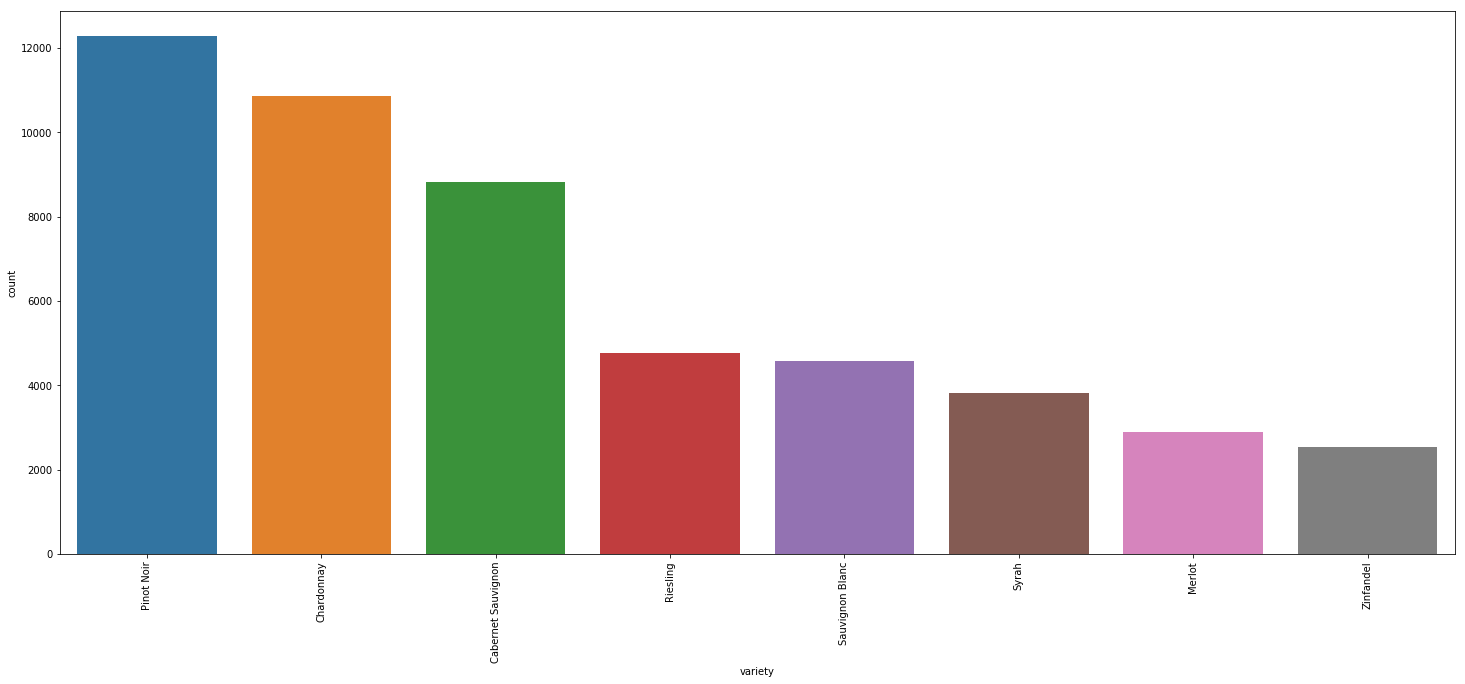

In [248]:
wine = pd.read_csv('wine_reviews.csv')

wine = wine.drop_duplicates('description')
wine[['description','country','variety']].head()
wine['points'][wine['points']<92] = 0
wine['points'][wine['points']>=92] = 1

wine = wine.groupby('variety').filter(lambda x: len(x) > 2000)
wine_list = ['Pinot Noir','Chardonnay','Cabernet Sauvignon','Riesling','Sauvignon Blanc','Syrah','Merlot','Zinfandel']
wine = wine.loc[wine['variety'].isin(wine_list)]

varieties = wine['variety'].value_counts().index.tolist()
fig, ax = plt.subplots(figsize = (25, 10))
sns.countplot(x = wine['variety'], order = varieties, ax = ax)
plt.xticks(rotation = 90)
#wine = wine.sample(n=N_ROWS)
plt.show()

In [249]:
#wine = wine.sample(n=N_ROWS)
wine = wine.sample(frac=1, random_state = RANDOM_SEED).reset_index(drop=True)
wine['variety'].unique()

array(['Chardonnay', 'Zinfandel', 'Pinot Noir', 'Cabernet Sauvignon',
       'Merlot', 'Riesling', 'Syrah', 'Sauvignon Blanc'], dtype=object)

In [250]:
corpus = wine['description']
stemmer = PorterStemmer()
processed_reviews = []
for review in corpus:
    review_tokenized = word_tokenize(review)
    new_review = []
    for word in review_tokenized:
        new_review.append(stemmer.stem(word))
    new_sentence = ' '.join(str(e) for e in new_review)
    processed_reviews.append(new_sentence)

print(processed_reviews[0])

vectorizer = TfidfVectorizer(stop_words = 'english',  max_features = N_FEATURES)
#vectorizer = CountVectorizer(stop_words = 'english', max_features =N_FEATURES, binary = True)
review_words = vectorizer.fit_transform(processed_reviews)
words = vectorizer.get_feature_names()
review_words = review_words.toarray()
review_words.shape

threshold = 50 
country_counts = wine.country.value_counts()
repl = country_counts[country_counts <= threshold].index
countries = pd.get_dummies(wine.country.replace(repl, 'uncommon'))
countries.head()

varieties = pd.get_dummies(wine.variety)
varieties.head(1)

from southern , coastal tuscani come thi opul , richli textur chardonnay that compet with the best of franc and california . thick layer of yellow rose , vanilla and apricot drive a creami , long-last mouthfeel . the wine deliv sophist , class and person .


Cabernet Sauvignon  Chardonnay  Merlot  Pinot Noir  Riesling  \
0  0                   1           0       0           0          

   Sauvignon Blanc  Syrah  Zinfandel  
0  0                0      0

In [251]:
wine = pd.concat([pd.DataFrame(review_words,columns = words), countries, wine['variety']], axis=1)
country_names = list(countries.columns.values)
variety_names = list(varieties.columns.values)
words.extend(country_names)

In [252]:
wine.head()

10  100  2015  2016  2017  2018  2019  2020  accent  acid   ad       add  \
0  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0     0.0   0.0  0.000000   
1  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0     0.0   0.0  0.000000   
2  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0     0.0   0.0  0.000000   
3  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0     0.0   0.0  0.234217   
4  0.0  0.0  0.0   0.0   0.0   0.0   0.0   0.0   0.0     0.0   0.0  0.000000   

   addit  aftertast       age   alcohol  almond  alongsid  alreadi  ampl  \
0  0.0    0.0        0.000000  0.000000  0.0     0.000000  0.0      0.0    
1  0.0    0.0        0.000000  0.294076  0.0     0.000000  0.0      0.0    
2  0.0    0.0        0.000000  0.000000  0.0     0.000000  0.0      0.0    
3  0.0    0.0        0.176329  0.000000  0.0     0.286947  0.0      0.0    
4  0.0    0.0        0.000000  0.000000  0.0     0.000000  0.0      0.0    

   anis  anoth  appeal     appel      appl  approach   apricot  aroma  aromat  \
0  0.0   0.0    0.0     0.000000  0.000000  0.0       0.248351  0.0    0.0      
1  0.0   0.0    0.0     0.000000  0.000000  0.0       0.000000  0.0    0.0      
2  0.0   0.0    0.0     0.287344  0.000000  0.0       0.000000  0.0    0.0      
3  0.0   0.0    0.0     0.000000  0.000000  0.0       0.000000  0.0    0.0      
4  0.0   0.0    0.0     0.000000  0.164021  0.0       0.000000  0.0    0.0      

   asian  astring  attract  bacon  bake  balanc  barrel  basic  beauti  \
0  0.0    0.0      0.0      0.0    0.0   0.0     0.0     0.0    0.0      
1  0.0    0.0      0.0      0.0    0.0   0.0     0.0     0.0    0.0      
2  0.0    0.0      0.0      0.0    0.0   0.0     0.0     0.0    0.0      
3  0.0    0.0      0.0      0.0    0.0   0.0     0.0     0.0    0.0      
4  0.0    0.0      0.0      0.0    0.0   0.0     0.0     0.0    0.0      

       beef     befor  berri      best  better  big       bit  bitter  black  \
0  0.000000  0.000000  0.0    0.239607  0.0     0.0  0.000000  0.0     0.0     
1  0.000000  0.000000  0.0    0.289994  0.0     0.0  0.000000  0.0     0.0     
2  0.000000  0.000000  0.0    0.000000  0.0     0.0  0.224384  0.0     0.0     
3  0.284596  0.260775  0.0    0.000000  0.0     0.0  0.000000  0.0     0.0     
4  0.000000  0.000000  0.0    0.000000  0.0     0.0  0.000000  0.0     0.0     

   blackberri  blanc     blend  blossom  blueberri  boast  bodi  bold  bone  \
0  0.0         0.0    0.000000  0.0      0.0        0.0    0.0   0.0   0.0    
1  0.0         0.0    0.284876  0.0      0.0        0.0    0.0   0.0   0.0    
2  0.0         0.0    0.242889  0.0      0.0        0.0    0.0   0.0   0.0    
3  0.0         0.0    0.000000  0.0      0.0        0.0    0.0   0.0   0.0    
4  0.0         0.0    0.000000  0.0      0.0        0.0    0.0   0.0   0.0    

   bottl  bouquet  boysenberri  brambl  bright  brighten  bring  brisk  broad  \
0  0.0    0.0      0.0          0.0     0.0     0.0       0.0    0.0    0.0     
1  0.0    0.0      0.0          0.0     0.0     0.0       0.0    0.0    0.0     
2  0.0    0.0      0.0          0.0     0.0     0.0       0.0    0.0    0.0     
3  0.0    0.0      0.0          0.0     0.0     0.0       0.0    0.0    0.0     
4  0.0    0.0      0.0          0.0     0.0     0.0       0.0    0.0    0.0     

   brown  burst    butter  butteri  butterscotch  cab  cabernet  california  \
0  0.0    0.0    0.000000  0.0      0.0           0.0  0.0       0.307972     
1  0.0    0.0    0.000000  0.0      0.0           0.0  0.0       0.000000     
2  0.0    0.0    0.000000  0.0      0.0           0.0  0.0       0.000000     
3  0.0    0.0    0.000000  0.0      0.0           0.0  0.0       0.000000     
4  0.0    0.0    0.226722  0.0      0.0           0.0  0.0       0.000000     

   candi   caramel  carri  case  cassi    cedar  cellar  chalki  char  \
0  0.0    0.000000  0.0    0.0   0.0    0.00000  0.0     0.0     0.0    
1  0.0    0.000000  0.0    0.0   0.0    0.00000  0.0     0.0     0.0  

In [253]:
y_labels = np.array(wine['variety'])
wine_train = wine.iloc[0:N_ROWS,:]
wine_valid = wine.iloc[N_ROWS:2*N_ROWS,:]
wine_test = wine.iloc[2*N_ROWS:3*N_ROWS,:]

del wine['variety']
#x_data = StandardScaler().fit_transform(wine)
x_data = np.asarray(wine)
x_train = x_data[0:N_ROWS,:]
x_valid =  x_data[N_ROWS:2*N_ROWS,:]
x_test =  x_data[2*N_ROWS:3*N_ROWS,:]

y_train = y_labels[0:N_ROWS]
y_valid = y_labels[N_ROWS:2*N_ROWS]
y_test = y_labels[2*N_ROWS:3*N_ROWS]

print("Train Rows:" + str(x_train.shape))
print("Train Labels:" + str(y_train.shape))
print("Validation Rows:" + str(x_valid.shape))
print("Validation Labels:" + str(y_valid.shape))
print("Test Rows:" + str(x_test.shape))
print("Test Labels" + str(y_test.shape))

Train Rows:(10000, 517)
Train Labels:(10000,)
Validation Rows:(10000, 517)
Validation Labels:(10000,)
Test Rows:(10000, 517)
Test Labels(10000,)


In [254]:
### PERFORMANCE OF K MEANS AND EM CLUSTERING WITH NUMBER OF CLUSTERS
clusters =  [2,3,5,8,10,12,14,16,18,20,25,30,35,40,50,60,75]
#clusters =  [2,3,5,8,10]

SSE = defaultdict(dict)
ll = defaultdict(dict)
bic = defaultdict(dict)
aic = defaultdict(dict)
silhoutte = defaultdict(dict)

km = kmeans(random_state=RANDOM_SEED, init ='random')
gmm = GMM(random_state=RANDOM_SEED)

st = clock()
for k in clusters:
    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    km.fit(x_train )
    gmm.fit(x_train)
    SSE[k]['Wine Reviews'] = km.score(x_train)
    ll[k]['Wine Reviews'] = gmm.score(x_train)
    bic[k]['Wine Reviews'] = gmm.bic(x_train)  
    aic[k]['Wine Reviews'] = gmm.aic(x_train)   

    print(k, clock()-st, SSE[k]['Wine Reviews'], ll[k]['Wine Reviews']
          , bic[k]['Wine Reviews'],aic[k]['Wine Reviews'])
    

2 5.67533800000092 -11985.601933564792 1015.4374969885104 -17832632.82382776 -19771067.939770207
3 14.050294000000576 -11066.962670657278 1061.6289574015398 -17518398.868946936 -20426055.148030795
5 92.07583700000032 -10927.157962964608 1205.0723829592494 -17911141.053818308 -22757239.65918499
8 303.29341900000145 -10492.974724939924 1254.5279223662374 -15186062.352533836 -22939824.44732475
10 478.7593960000013 -10137.685497640101 1326.9456168132758 -14158289.915191783 -23850494.336265516
12 683.100902000002 -9809.483493873548 1373.7080478678283 -12617412.21000001 -24248058.957356565
14 1003.3286350000017 -9778.07352491758 1389.1133642151005 -10449392.210662633 -24018481.28430201
16 1264.8029239999996 -9543.00273296037 1429.0071778813283 -8771142.157704368 -24278673.557626564
18 1693.407639000001 -9395.096383544835 1474.26464389575 -7200165.151709981 -24646138.877915
20 2054.157462000003 -9353.487041007142 1528.1636613857415 -5802019.17522699 -25186435.22771483
25 2200.595873000002 -91

Text(0,0.5,'SSE')

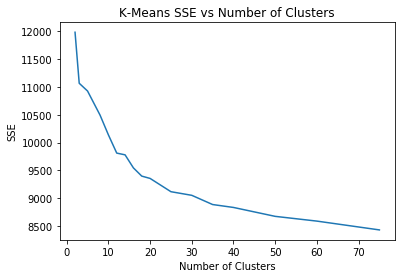

In [324]:
SSE = (-pd.DataFrame(SSE)).T
ax = SSE.plot(legend =False, title = 'K-Means SSE vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("SSE")

Text(0.5,1,'Log Likelihood and BIC vs Number of Clusters K')

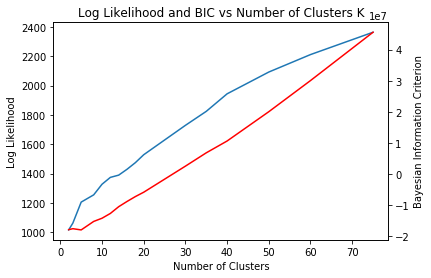

In [335]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(ll)
ax1.set_xlabel("Number of Clusters")
ax1.set_ylabel("Log Likelihood")

ax2 = ax1.twinx()
ax2.plot(bic, 'r-')
ax2.set_ylabel("Bayesian Information Criterion")

plt.title('Log Likelihood and BIC vs Number of Clusters K')

Text(17.2,0.5,'Log Likelihood')

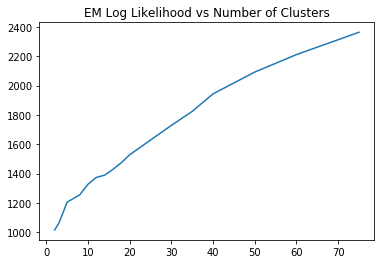

In [322]:
ll = pd.DataFrame(ll).T
ll.plot(legend =False, title = 'EM Log Likelihood vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Log Likelihood")

Text(17.2,0.5,'Bayesian Information Criterion')

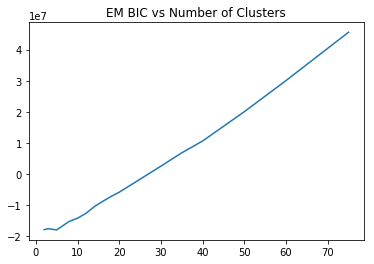

In [313]:
bic = pd.DataFrame(bic).T
bic.plot(legend =False, title = 'EM BIC vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Bayesian Information Criterion")

Text(17.2,0.5,'Alkaline Information Criterion')

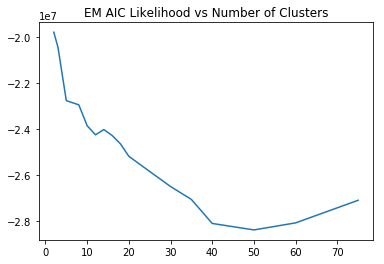

In [260]:
aic = pd.DataFrame(aic).T
aic.plot(legend =False, title = 'EM AIC Likelihood vs Number of Clusters')
ax.set_xlabel("Number of Clusters")
ax.set_ylabel("Alkaline Information Criterion")

For n_clusters = 2 The average silhouette_score is : 0.22547455221703477
For n_clusters = 3 The average silhouette_score is : 0.25225142317176036
For n_clusters = 4 The average silhouette_score is : 0.05794075517704145
For n_clusters = 5 The average silhouette_score is : 0.05612344132690138
For n_clusters = 6 The average silhouette_score is : 0.05597385503867194
For n_clusters = 7 The average silhouette_score is : 0.05537432448181203
For n_clusters = 8 The average silhouette_score is : 0.06572073894447085
For n_clusters = 9 The average silhouette_score is : 0.06950790768386417
For n_clusters = 10 The average silhouette_score is : 0.07617291482050383
For n_clusters = 12 The average silhouette_score is : 0.0856186212148101
For n_clusters = 15 The average silhouette_score is : 0.09293232445957551
For n_clusters = 20 The average silhouette_score is : 0.09225061213365128
For n_clusters = 25 The average silhouette_score is : 0.06170492030053151
For n_clusters = 30 The average silhouette_scor

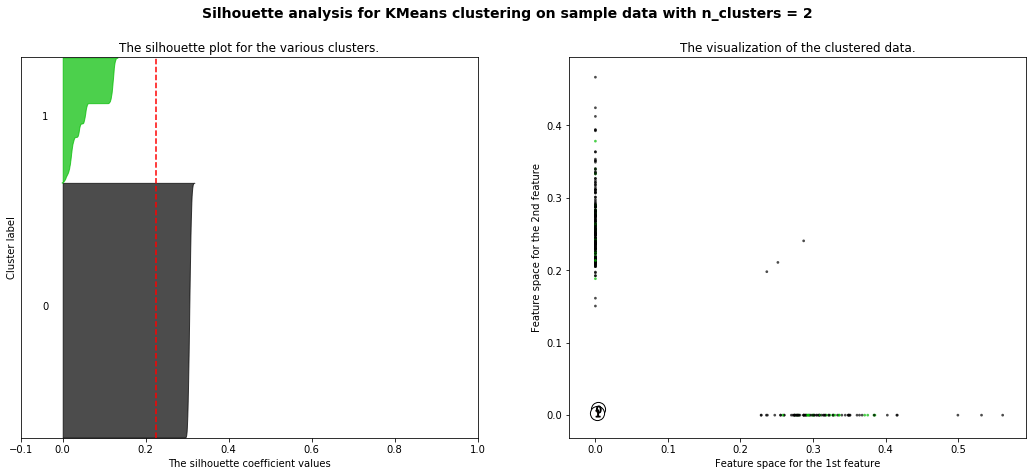

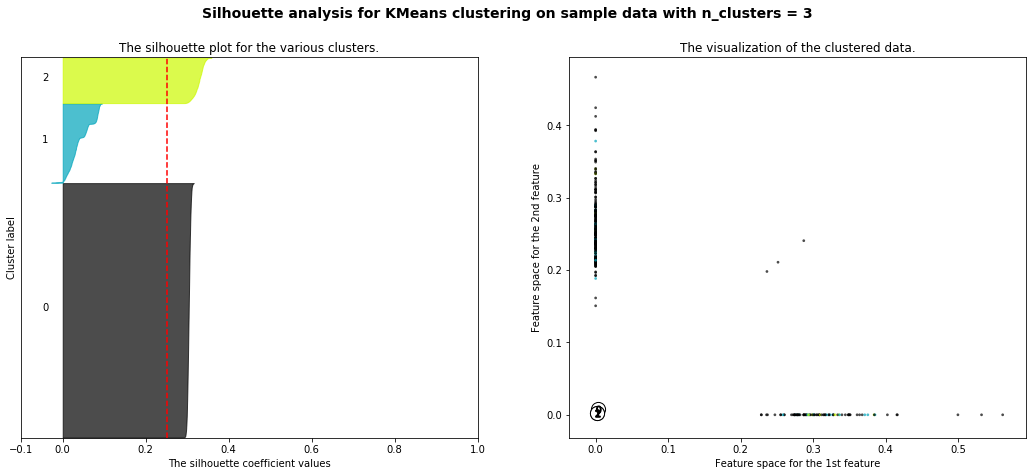

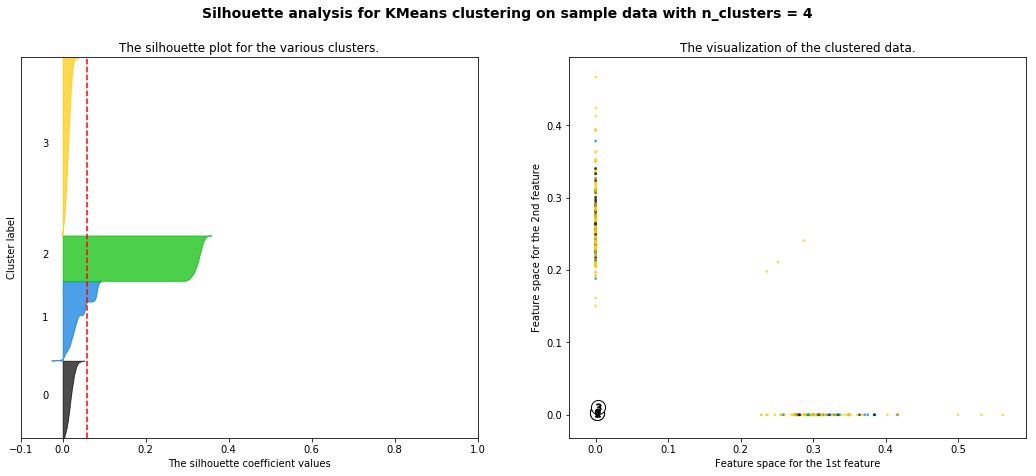

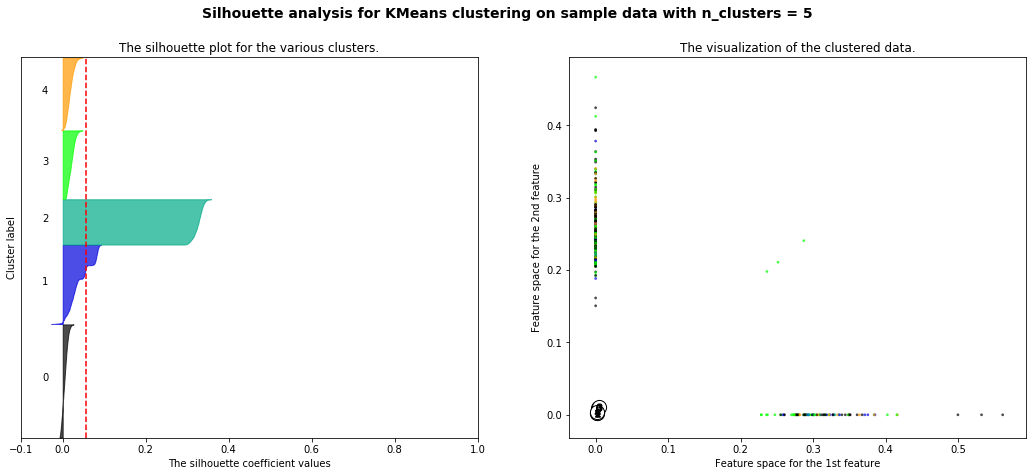

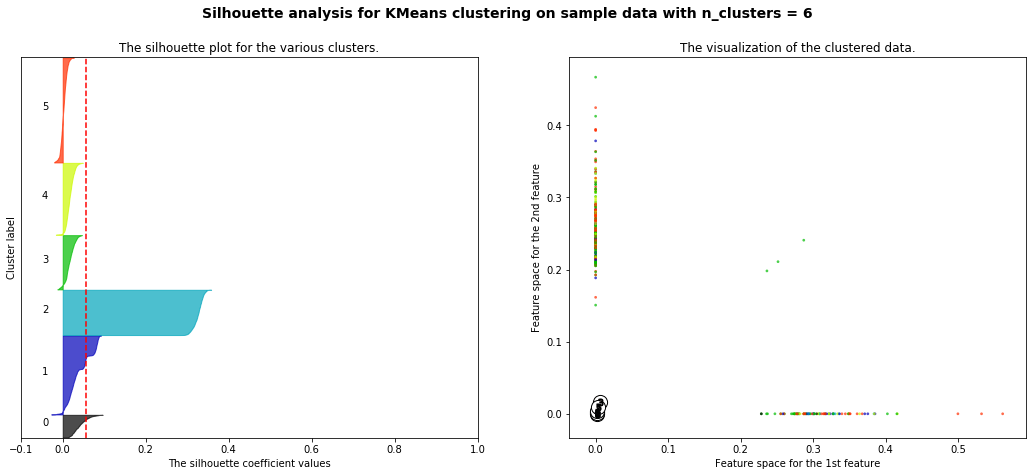

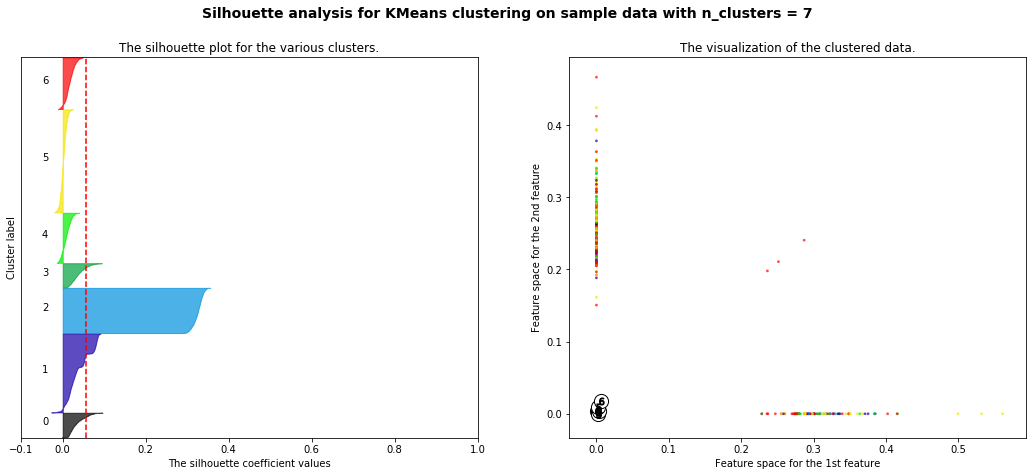

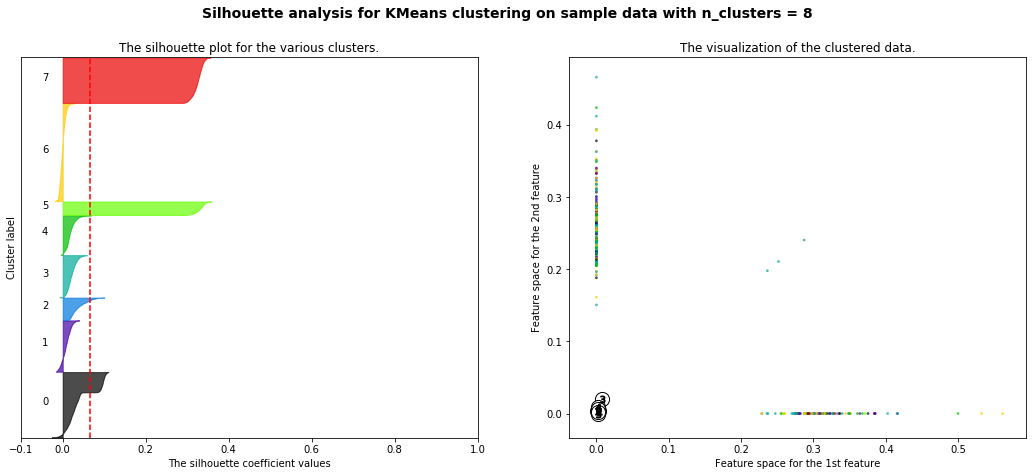

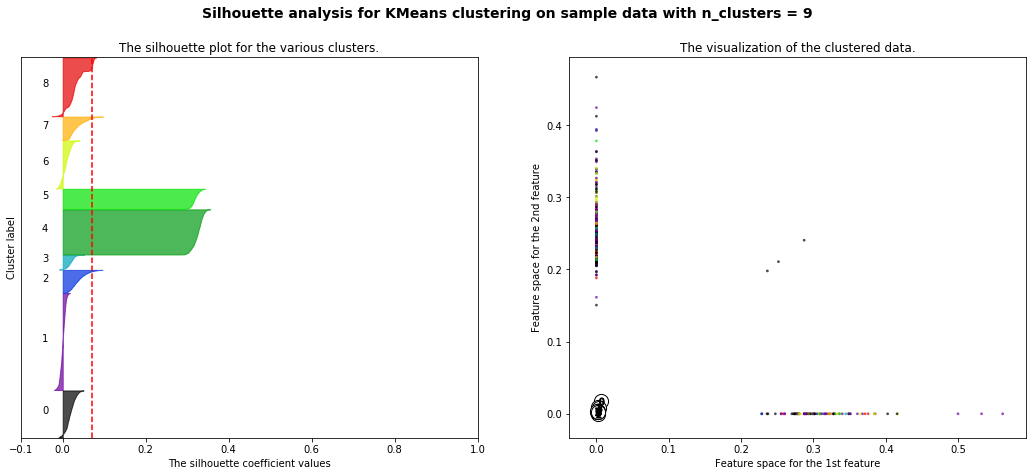

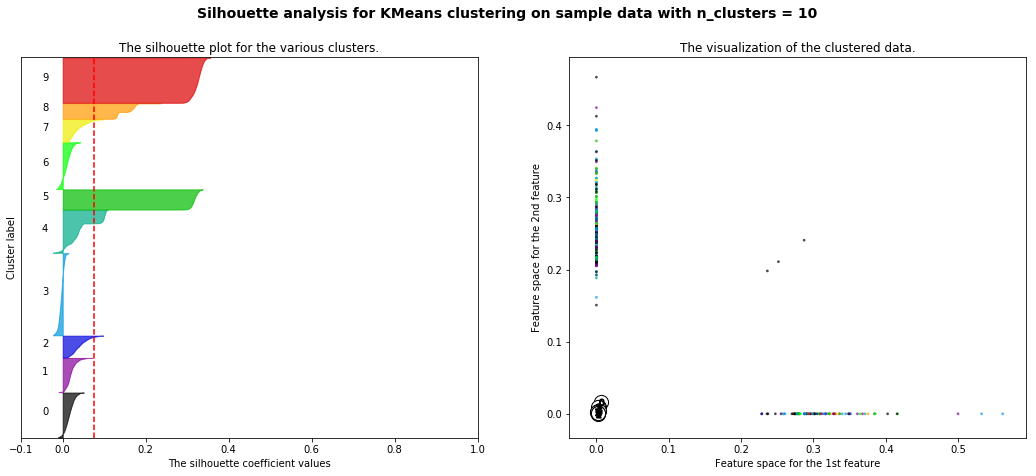

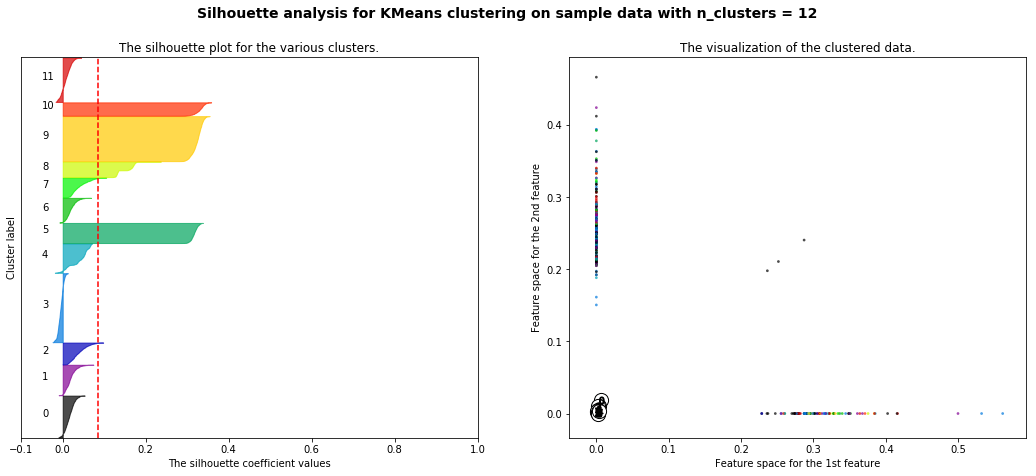

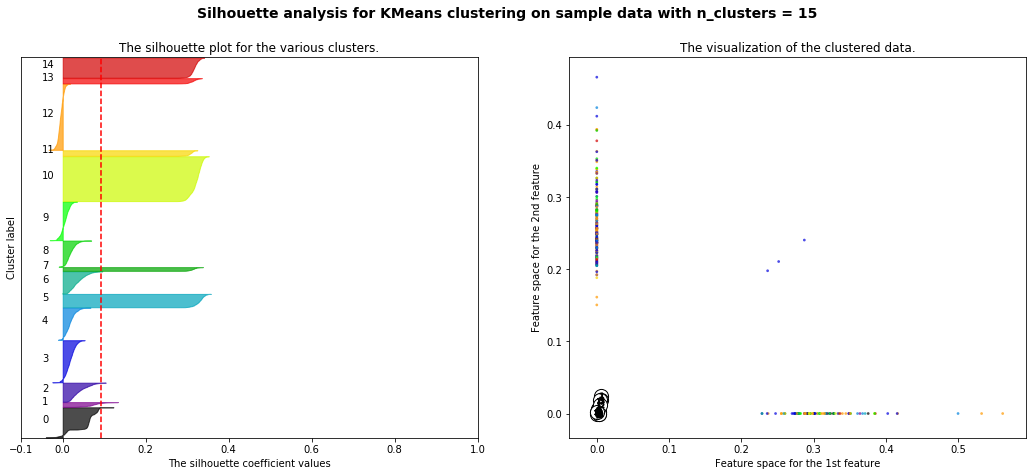

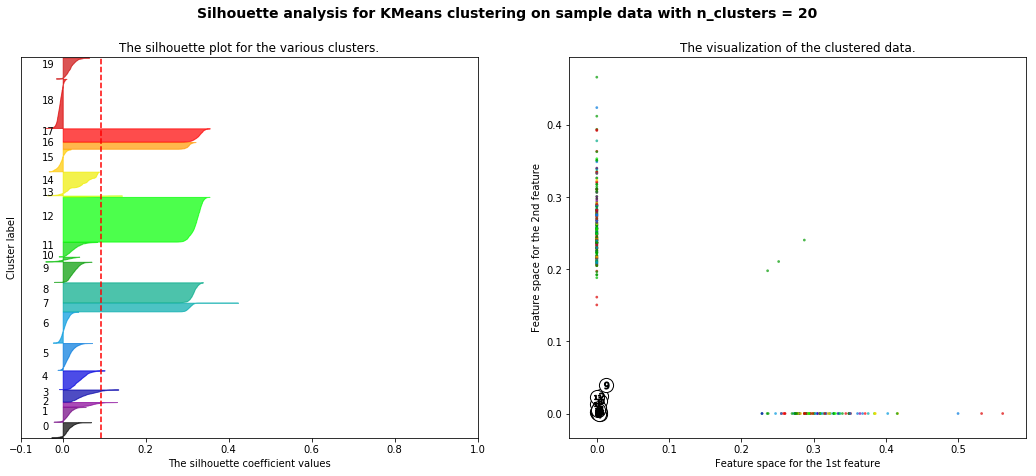

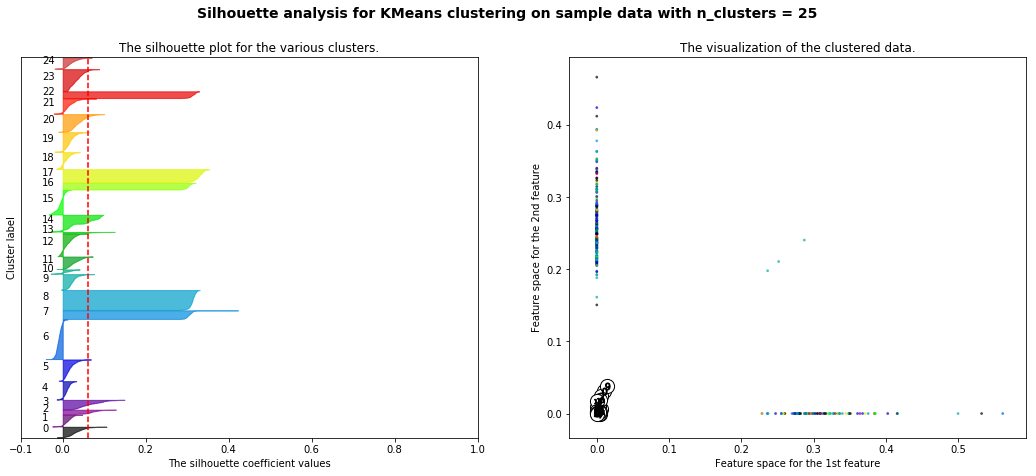

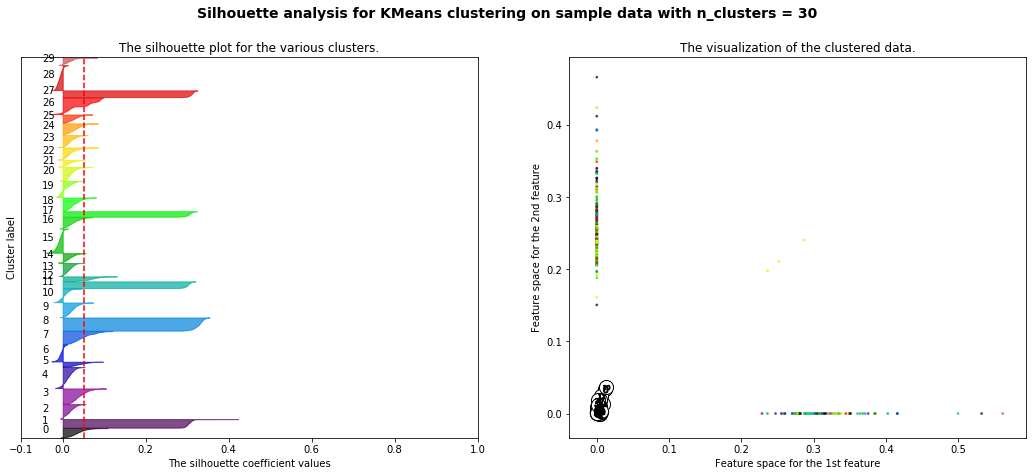

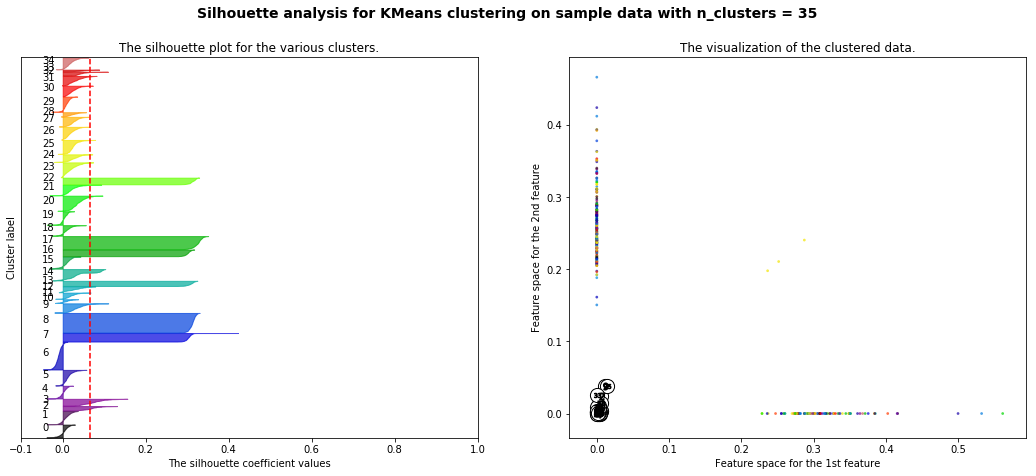

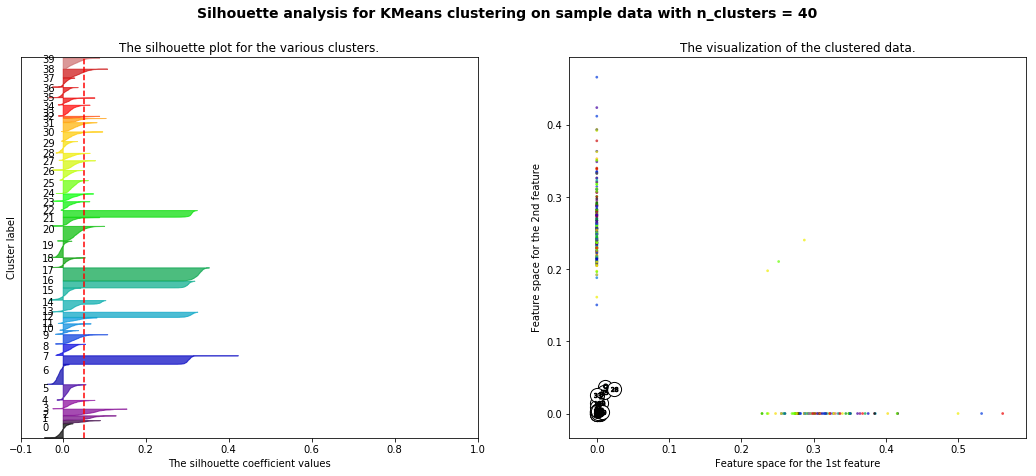

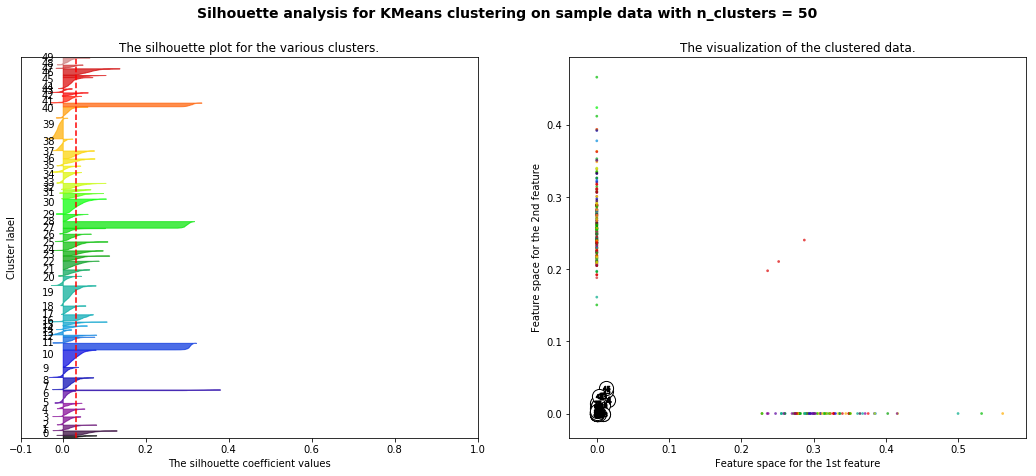

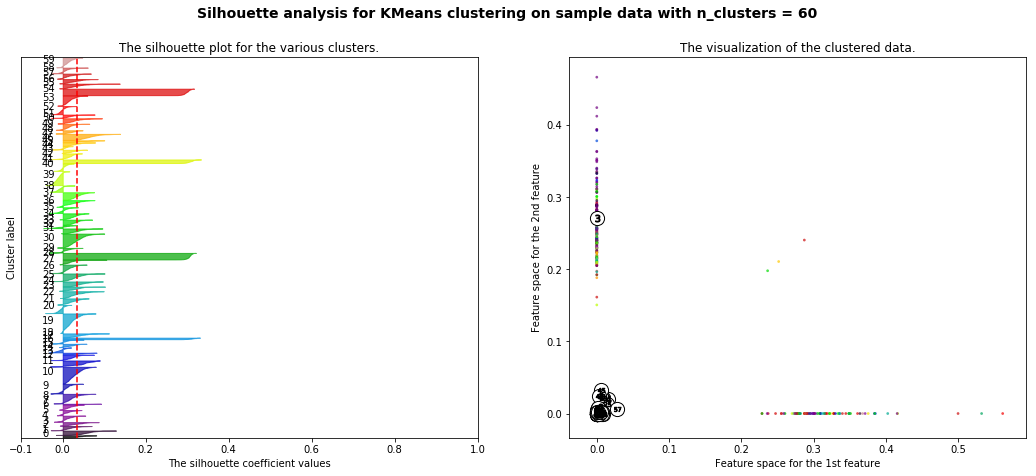

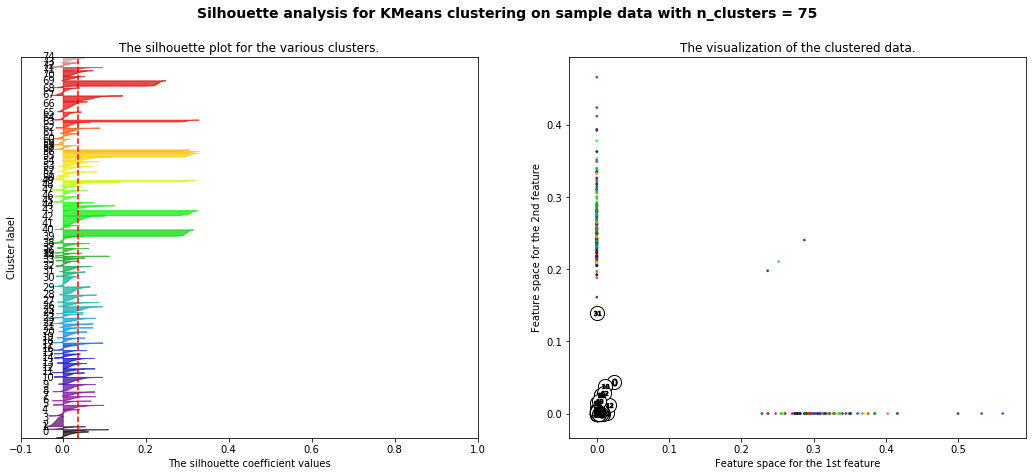

In [310]:
cluster_label_performance = []
range_n_clusters = [2,3,4,5,6,7,8,9,10,12,15,20,25,30,35,40,50,60,75]

for n_clusters in range_n_clusters:

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(x_train) + (n_clusters + 1) * 10])

    clusterer = kmeans(n_clusters=n_clusters, random_state=RANDOM_SEED,  init ='random')
    cluster_labels = clusterer.fit_predict(x_train)

    silhouette_avg = silhouette_score(x_train, cluster_labels)
    mutual_info_score = adjusted_mutual_info_score(y_train,  cluster_labels)
    
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    cluster_label_performance.append([n_clusters,silhouette_avg,mutual_info_score])

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_train, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x_train[:, 0], x_train[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

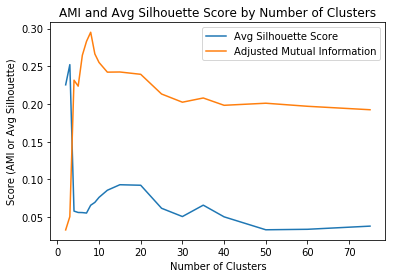

In [311]:
silhouette_data = pd.DataFrame(cluster_label_performance, columns = ['Number of Clusters','Avg Silhouette Score','Adjusted Mutual Information'])
silhouette_data = silhouette_data.set_index('Number of Clusters')
silhouette_data.plot()
plt.legend(loc='best')
plt.ylabel('Score (AMI or Avg Silhouette)')
plt.xlabel('Number of Clusters')
plt.title('AMI and Avg Silhouette Score by Number of Clusters')
plt.show()

In [348]:
del wine_train['kmean cluster']
del wine_train['em cluster']

best_km = kmeans(n_clusters = 15, init = 'random', random_state = RANDOM_SEED)
best_km.fit(x_train)

best_em = GMM(n_components = 6,  random_state = RANDOM_SEED)
best_em.fit(x_train)

##convert to percentages
em_labels = best_em.predict(x_train)
km_labels = best_km.predict(x_train)
wine_train['kmean cluster'] = km_labels
wine_train['em cluster'] = em_labels

In [356]:
common_words = best_km.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : New Zealand, Argentina, Australia, finish, aroma, flavor, thi, uncommon, note, fruit
1 : US, blanc, sauvignon, flavor, thi, lime, gooseberri, crisp, acid, lemon
2 : US, pineappl, chardonnay, butter, flavor, toast, oak, vanilla, sweet, acid
3 : US, blackberri, currant, tannin, flavor, cabernet, cherri, dri, drink, thi
4 : US, black, nose, palat, cherri, thi, pepper, plum, bottl, wine
5 : Germany, riesl, finish, dri, peach, miner, honey, sweet, tangerin, thi
6 : US, pinot, noir, cherri, raspberri, cola, silki, flavor, thi, acid
7 : South Africa, weight, medium, nose, note, thi, balanc, palat, fruit, wine
8 : US, bodi, medium, wine, textur, flavor, thi, aroma, cherri, tannin
9 : US, appl, lemon, thi, pear, palat, flavor, acid, lime, wine
10 : France, wine, fruit, drink, thi, ripe, acid, ha, age, textur
11 : Italy, aroma, wine, thi, fruit, offer, palat, chardonnay, intens, note
12 : US, fruit, thi, wine, flavor, tannin, oak, cherri, finish, barrel
13 : Austria, fresh, palat, fruit, thi

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text xticklabel objects>)

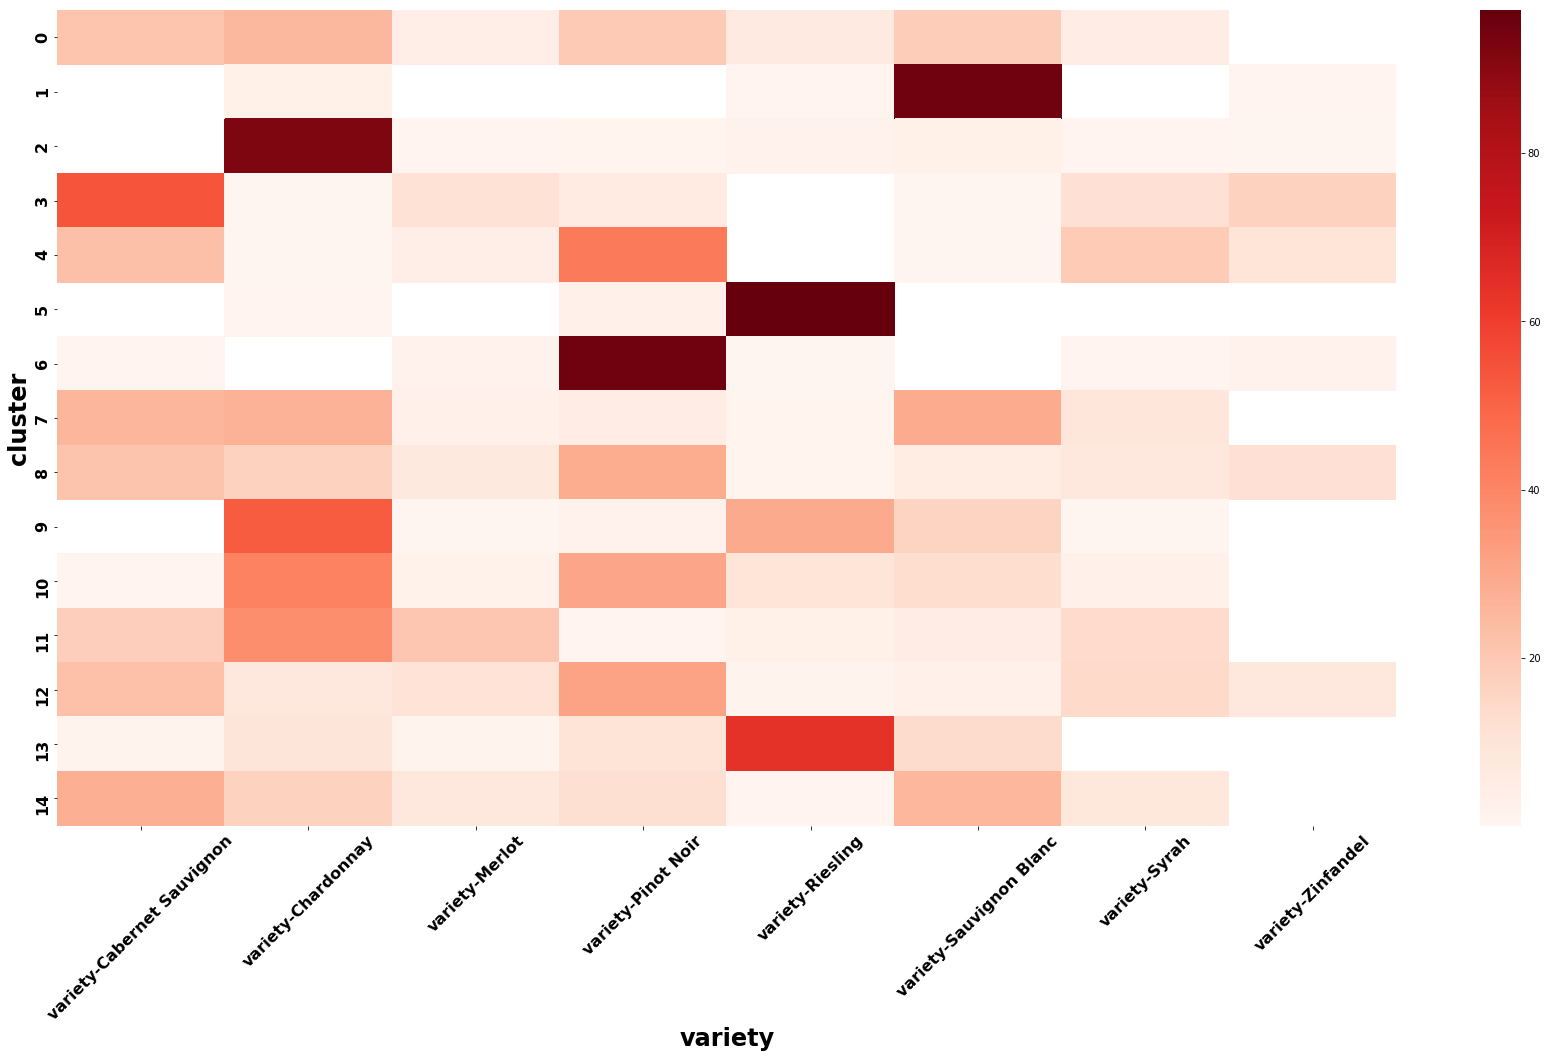

In [350]:
clusters = wine_train.groupby(['kmean cluster', 'variety']).agg({'variety': 'size'})
cluster_pcts = clusters.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(cluster_pcts.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})

for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")

plt.xticks(rotation=45)

In [351]:
common_words = best_em.means_.argsort()[:,-1:-10:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : US, thi, black, wine, fruit, cherri, flavor, palat, nose
1 : France, wine, fruit, drink, thi, ripe, acid, ha, age
2 : Germany, New Zealand, Argentina, Australia, Italy, Austria, finish, South Africa, thi
3 : US, thi, flavor, appl, lemon, acid, chardonnay, wine, pineappl
4 : US, cherri, flavor, thi, wine, tannin, blackberri, dri, oak
5 : Chile, aroma, finish, flavor, feel, palat, berri, green, thi


(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text xticklabel objects>)

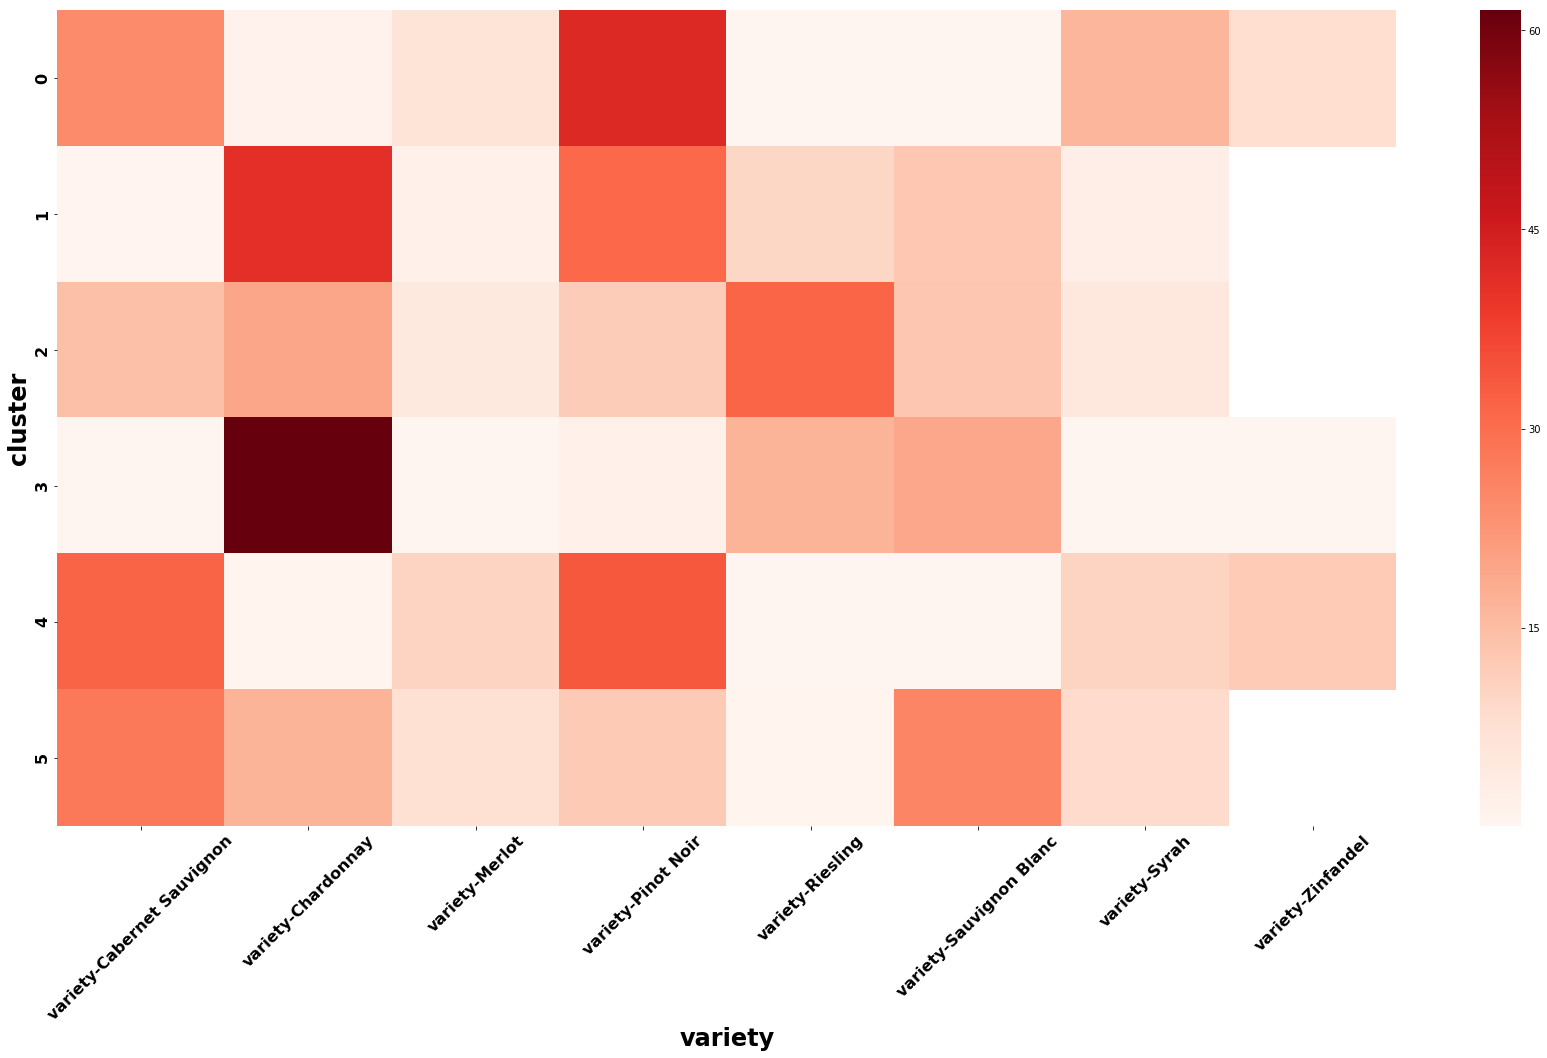

In [353]:
clusters = wine_train.groupby(['em cluster', 'variety']).agg({'variety': 'size'})
cluster_pcts = clusters.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

fig2, ax2 = plt.subplots(figsize = (30, 15))
sns.heatmap(cluster_pcts.unstack(level = 'variety'), ax = ax2, cmap = 'Reds')

ax2.set_xlabel('variety', fontdict = {'weight': 'bold', 'size': 24})
ax2.set_ylabel('cluster', fontdict = {'weight': 'bold', 'size': 24})
for label in ax2.get_xticklabels():
    label.set_size(16)
    label.set_weight("bold")
for label in ax2.get_yticklabels():
    label.set_size(16)
    label.set_weight("bold")
    
plt.xticks(rotation=45)

In [270]:
from sklearn.metrics.pairwise import cosine_similarity

n_components = [2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,35,40,50,60,70,80,90,100,150,200,250,300,350,400,500]
#n_components = [2,3,4,5,6,7,8,9,10,11]
pca_variances = []
print('\nRunning PCA ...')
j = 0
for n in n_components:
    pca = PCA(n_components=n, svd_solver='full', random_state=RANDOM_SEED)
    X_pca = pca.fit_transform(x_train)
    explained_variance = pca.explained_variance_ratio_.sum()
    pca_explained = pca.explained_variance_ratio_[j]
    #rce = reconstructionError(pca, x_train)
    rce = 1 - cosine_similarity(pca.inverse_transform(X_pca),x_train)[0][0]

    print(str(n)+ ' Explained variance: %.4f' % explained_variance)
    print(str(n)+ ' Reconstruction Error: %.4f' % rce)
    pca_variances.append((n,explained_variance,pca_explained, rce))
    j+=1

pca_data = pd.DataFrame(pca_variances, columns=['Number of Components','Cumulative Explained Variance', 'Component Explained Variance','Reconstruction Error'])


Running PCA ...
2 Explained variance: 0.2477
2 Reconstruction Error: 0.8543
3 Explained variance: 0.2796
3 Reconstruction Error: 0.8275
4 Explained variance: 0.3009
4 Reconstruction Error: 0.7629
5 Explained variance: 0.3158
5 Reconstruction Error: 0.7124
6 Explained variance: 0.3288
6 Reconstruction Error: 0.7039
7 Explained variance: 0.3403
7 Reconstruction Error: 0.4238
8 Explained variance: 0.3511
8 Reconstruction Error: 0.3187
9 Explained variance: 0.3607
9 Reconstruction Error: 0.2691
10 Explained variance: 0.3684
10 Reconstruction Error: 0.2573
12 Explained variance: 0.3813
12 Reconstruction Error: 0.2573
14 Explained variance: 0.3918
14 Reconstruction Error: 0.2547
16 Explained variance: 0.4010
16 Reconstruction Error: 0.2519
18 Explained variance: 0.4095
18 Reconstruction Error: 0.2487
20 Explained variance: 0.4173
20 Reconstruction Error: 0.2477
25 Explained variance: 0.4350
25 Reconstruction Error: 0.2444
30 Explained variance: 0.4514
30 Reconstruction Error: 0.2438
35 Expl

Text(0.5,17.2,'Number of Principal Components')

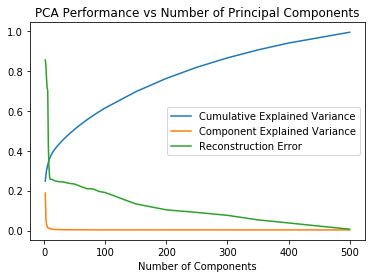

In [271]:
pca_data.plot(title = 'PCA Performance vs Number of Principal Components'
              ,x="Number of Components"
              , y=["Cumulative Explained Variance","Component Explained Variance", "Reconstruction Error"])
ax.set_xlabel("Number of Principal Components")

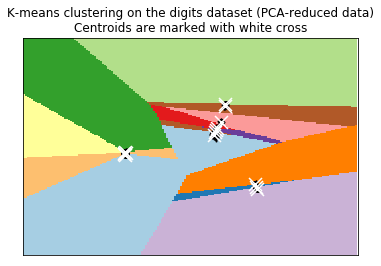

In [273]:
# #############################################################################
# Visualize the results on PCA-reduced data
reduced_data = PCA(n_components=2).fit_transform(x_train)
best_kmeans = kmeans(init='k-means++', n_clusters=15, n_init=10)
best_kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = best_kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = best_kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()

In [354]:
##visualizing PCA
variety_mappings = {'Riesling': 1,'Pinot Noir': 2, 'Cabernet Sauvignon':3, 'Chardonnay':4, 'Merlot':5, 'Sauvignon Blanc':6
                   ,'Zinfandel':7,'Syrah':8} 
wine_train['variety_mapping'] = [variety_mappings[item] for item in wine_train['variety']] 

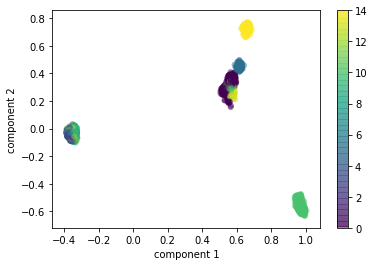

In [279]:
pca = PCA(n_components=2, random_state=5)
projected = pca.fit_transform(x_train)

plt.scatter(projected[:, 0], projected[:, 1],
            c=wine_train['kmean cluster'], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

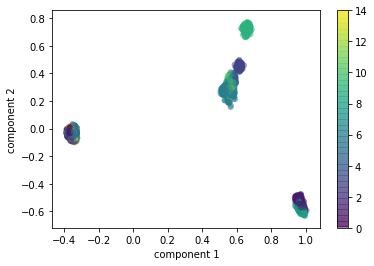

In [280]:
pca = PCA(n_components=2, random_state=5)
projected = pca.fit_transform(x_train)

plt.scatter(projected[:, 0], projected[:, 1],
            c=wine_train['em cluster'], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

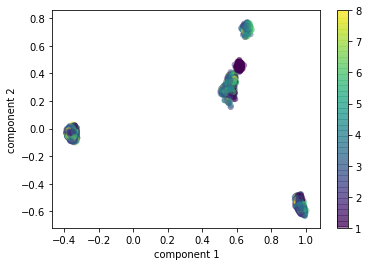

In [286]:
pca = PCA(n_components=2, random_state=RANDOM_SEED)
projected = pca.fit_transform(x_train)

plt.scatter(projected[:, 0], projected[:, 1],
            c=wine_train['variety_mapping'], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [289]:
target_names

array(['Cabernet Sauvignon', 'Chardonnay', 'Merlot', 'Pinot Noir',
       'Riesling', 'Sauvignon Blanc', 'Syrah', 'Zinfandel'], dtype=object)

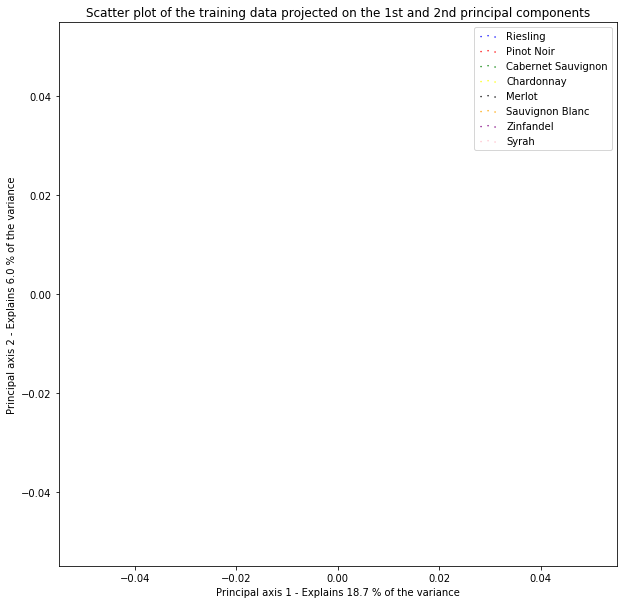

In [290]:
##visualizing PCA with true labels
variety_mappings = {'Riesling': 1,'Pinot Noir': 2, 'Cabernet Sauvignon':3, 'Chardonnay':4, 'Merlot':5, 'Sauvignon Blanc':6
                   ,'Zinfandel':7,'Syrah':8} 

colors = ['blue', 'red','green','yellow','black','orange','purple','pink']
target_names = ['Riesling','Pinot Noir','Cabernet Sauvignon','Chardonnay','Merlot','Sauvignon Blanc','Zinfandel','Syrah']
X_pca = projected

plt.figure(1, figsize=(10, 10))

for color, i, target_name in zip(colors, [1,2,3,4,5,6,7,8], target_names):
    plt.scatter(X_pca[y_train == i, 0], X_pca[y_train  == i, 1], color=color, s=1,
                alpha=1, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title(
        "Scatter plot of the training data projected on the 1st "
        "and 2nd principal components")
plt.xlabel("Principal axis 1 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[0] * 100.0))
plt.ylabel("Principal axis 2 - Explains %.1f %% of the variance" % (
        pca.explained_variance_ratio_[1] * 100.0))

plt.savefig('pca-wine_reviews-01.png', dpi=150)
plt.show()

In [ ]:
print('TSNE')
tsne = TSNE(n_components=2, init='random', random_state=0)
proj = tsne.fit_transform(x_train)

#print('TSNE')
#tsne = TSNE(n_components=2, init='pca', random_state=1001, perplexity=30, method='barnes_hut', n_iter=1000, verbose=1)
#X_tsne = tsne.fit_transform(x_train) # this will either fail or take a while (most likely overnight)

In [591]:
print('Clustering')
# Compute the clusters
best_kmeans = kmeans(n_clusters=8, random_state=0)
clusters = best_kmeans.fit_predict(x_train)
clusters = clusters + 1
clusters 

Clustering


array([1, 6, 8, ..., 7, 1, 1], dtype=int32)

In [600]:
from scipy.stats import mode

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(1,9):
    mask = (clusters == i)
    labels[mask] = mode(wine['variety_mapping'][mask])[0]

# Compute the accuracy
print(accuracy_score(wine['variety_mapping'], labels))
print(labels)

0.4354
[3 4 1 ... 2 3 3]


Plotting


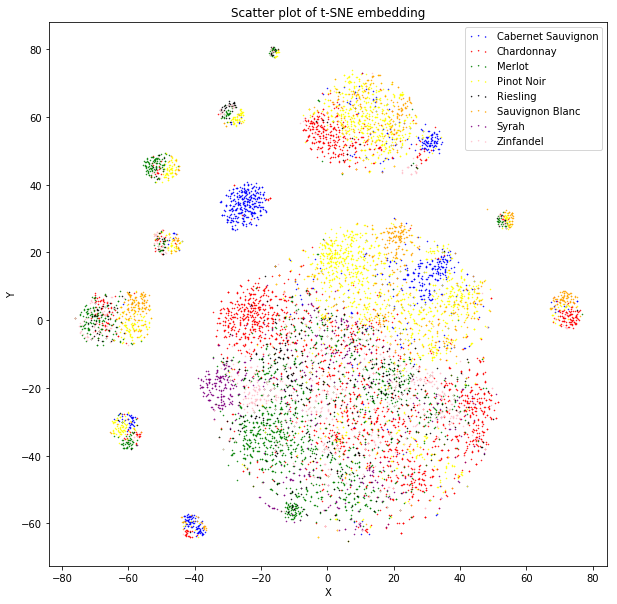

In [606]:
X_tsne = proj

print('Plotting')
y_train = wine['variety_mapping']

plt.figure(2, figsize=(10, 10))
target_names = np.unique(wine['variety'])
colors = ['blue', 'red','green','yellow','black','orange','purple','pink']

for color, i, target_name in zip(colors, [1,2,3,4,5,6,7,8], target_names):
    plt.scatter(X_tsne[y_train == i, 0], X_tsne[y_train == i, 1], color=color, s=1,
                 alpha=1, label=target_name, marker='.')
plt.legend(loc='best', shadow=False, scatterpoints=3)
plt.title('Scatter plot of t-SNE embedding')
plt.xlabel('X')
plt.ylabel('Y')

plt.savefig('t-SNE-wine_reviews.png', dpi=150)
plt.show()

In [ ]:
# %% For chart 4/5
tnse_wine_reviews = TSNE(verbose=10,random_state=RANDOM_SEED).fit_transform(x_train)
tnse_wine_reviews = pd.DataFrame(np.hstack((tnse_wine_reviews,np.atleast_2d(y_train).T)),columns=['x','y','target'])
tnse_wine_reviews.to_csv('wine_reviews_tnse_2d.csv')

Text(0,0.5,'Mean Component Kurtosis')

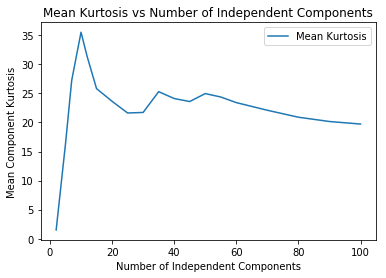

In [358]:
##ICA
dims = [2,5,7,10,12,15,20,25,30,35,40,45,50,55,60,70,80,90,100]
ica = FastICA(random_state=RANDOM_SEED)
kurt = {}
rce = {}
for dim in dims:
    ica.set_params(n_components=dim)
    tmp = ica.fit_transform(x_train)
    tmp = pd.DataFrame(tmp)
    tmp = tmp.kurt(axis=0)
    kurt[dim] = tmp.abs().mean()
    rce[dim] = reconstructionError(ica, x_train)
    #print(str(dim) + ',' + str(kurt[dim]))
    
kurt = pd.Series(kurt, name = 'Mean Kurtosis') 
rce = pd.Series(rce, name = 'Reconstruction Error')
kurt.to_csv('ica wine reviews kurtosis components.csv')

kurt = pd.DataFrame(kurt)
rce = pd.DataFrame(rce)

Text(0.5,1,'Mean Kurtosis (Blue) and Reconstruction Error (Red) vs N Independent Components')

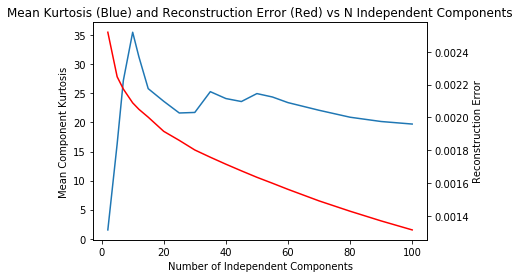

In [359]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(kurt)
ax1.set_xlabel("Number of Independent Components")
ax1.set_ylabel("Mean Component Kurtosis")

ax2 = ax1.twinx()
ax2.plot(rce, 'r-')
ax2.set_ylabel("Reconstruction Error")
rce = pd.DataFrame(rce)
plt.title('Mean Kurtosis (Blue) and Reconstruction Error (Red) vs N Independent Components')

0    8.730534 
1    13.360769
2    3.302083 
3    34.525788
4    21.593650
dtype: float64


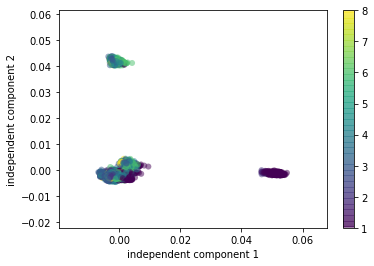

In [373]:
ica = FastICA(random_state=RANDOM_SEED, n_components = 5)
ica_projections = pd.DataFrame(ica.fit_transform(x_train))
tmp = pd.DataFrame(ica_projections)
tmp = tmp.kurt(axis=0)
print(tmp)

plt.scatter(ica_projections.iloc[:, 4], ica_projections.iloc[:, 1],
            c=wine_train['variety_mapping'], edgecolor='none', alpha=0.5)
plt.xlabel('independent component 1')
plt.ylabel('independent component 2')
plt.colorbar();

In [368]:
##RANDOMIZED PROJECTIONS

from helpers import   pairwiseDistCorr,nn_reg,nn_arch,reconstructionError
from itertools import product

dims = [2,3,5,8,10,15,20,25,30,40,50,60,70,80,100,150,200,250,300,400,500]
tmp = defaultdict(dict)
for i,dim in product(range(10),dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(x_train), x_train)
    #print(str(dim) + ',' + str(tmp[dim][i]))

pairwise =pd.DataFrame(tmp).T
pairwise.to_csv('wine reviews RP pairwise.csv')

tmp = defaultdict(dict)
for i,dim in product(range(10),dims):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    rp.fit(x_train)    
    tmp[dim][i] = reconstructionError(rp, x_train)
    #print(str(dim) + ',' + str(tmp[dim][i]))

rce_rp =pd.DataFrame(tmp).T
rce_rp.to_csv('wine reviews RP reconstruction.csv')

Text(0.5,1,'Mean Pairwise Correlation and STD vs Number of Random Components')

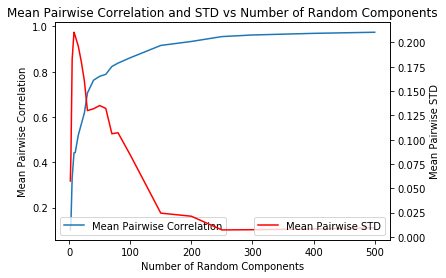

In [369]:
pairwise_joined = (pd.concat((pairwise.mean(axis=1), pairwise.std(axis=1)), axis =1))
pairwise_joined.columns = ["Mean Pairwise Correlation", "Mean Pairwise Standard Deviation"]

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(pairwise_joined.iloc[:,0], label = 'Mean Pairwise Correlation')
ax1.set_xlabel("Number of Random Components")
ax1.set_ylabel("Mean Pairwise Correlation")
ax1.legend(loc='lower left')

ax2 = ax1.twinx()
ax2.plot(pairwise_joined.iloc[:,1], 'r-', label = 'Mean Pairwise STD')
ax2.set_ylabel("Mean Pairwise STD")
ax2.legend(loc='lower right')

plt.title('Mean Pairwise Correlation and STD vs Number of Random Components')

#rce = pd.DataFrame(pairwise_joined)
#plt.title('Mean Pa (Blue) and Reconstruction Error (Red) vs N Independent Components')

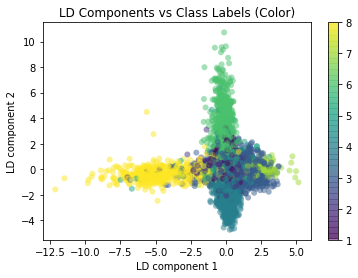

In [427]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from matplotlib.colors import ListedColormap

lda = LinearDiscriminantAnalysis(n_components = 8)
lda_projection = lda.fit_transform(x_train, y_train)

plt.scatter(lda_projection[:, 4], lda_projection[:, 5],
            c=wine_train['variety_mapping'], edgecolor='none', alpha=0.5)
plt.xlabel('LD component 1')
plt.ylabel('LD component 2')
plt.title('LD Components vs Class Labels (Color)')
plt.colorbar();

In [367]:
#Neural Network Grid Search
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
parameters = {'alpha':[0.00001, 0.0001, 0.001, 0.01], 'hidden_layer_sizes':[8,16,32,64,128]
              ,'learning_rate_init':[0.00000001, 0.00001, 0.0001, 0.001, 0.01],'activation':['relu','logistic']
            , 'solver':['adam','lbfgs']}
nn = MLPClassifier(verbose =1)
nn_clf = GridSearchCV(nn, parameters, cv= cv)
nn_clf.fit(x_train, y_train)

nn_grid_search_results = pd.DataFrame(nn_clf.cv_results_).sort_values(by='rank_test_score')

print('Best score:', nn_clf.best_score_) 
print('Best Estimators:',nn_clf.best_estimator_.alpha) 
print('Best Learning Rate:',nn_clf.best_estimator_.learning_rate_init)
print('Best HL:',nn_clf.best_estimator_.hidden_layer_sizes)
print('Best Activation:',nn_clf.best_estimator_.activation)
print('Best Optimizer:',nn_clf.best_estimator_.solver)


Iteration 1, loss = 2.12202884
Iteration 2, loss = 2.12202785
Iteration 3, loss = 2.12202687
Iteration 4, loss = 2.12202589
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.00225961
Iteration 2, loss = 2.00225876
Iteration 3, loss = 2.00225791
Iteration 4, loss = 2.00225706
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.12024005
Iteration 2, loss = 2.12023919
Iteration 3, loss = 2.12023833
Iteration 4, loss = 2.12023748
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.11098129
Iteration 2, loss = 2.11030401
Iteration 3, loss = 2.10963165
Iteration 4, loss = 2.10895751
Iteration 5, loss = 2.10828555
Iteration 6, loss = 2.10761627
Iteration 7, loss = 2.10694824
Iteration 8, loss = 2.10627503
Iteration 9, loss = 2.10560106
Iteration 10, loss = 2.10492215
Iteration 11, loss = 2.10424287
Iteration 12

Iteration 35, loss = 2.06698964
Iteration 36, loss = 2.06613506
Iteration 37, loss = 2.06527722
Iteration 38, loss = 2.06442322
Iteration 39, loss = 2.06356070
Iteration 40, loss = 2.06270115
Iteration 41, loss = 2.06184561
Iteration 42, loss = 2.06098857
Iteration 43, loss = 2.06013674
Iteration 44, loss = 2.05928569
Iteration 45, loss = 2.05843652
Iteration 46, loss = 2.05759063
Iteration 47, loss = 2.05673599
Iteration 48, loss = 2.05588216
Iteration 49, loss = 2.05503091
Iteration 50, loss = 2.05417883
Iteration 51, loss = 2.05333319
Iteration 52, loss = 2.05248247
Iteration 53, loss = 2.05163135
Iteration 54, loss = 2.05077925
Iteration 55, loss = 2.04992794
Iteration 56, loss = 2.04908482
Iteration 57, loss = 2.04823074
Iteration 58, loss = 2.04738513
Iteration 59, loss = 2.04653832
Iteration 60, loss = 2.04569020
Iteration 61, loss = 2.04483922
Iteration 62, loss = 2.04399055
Iteration 63, loss = 2.04314051
Iteration 64, loss = 2.04229747
Iteration 65, loss = 2.04145166
Iteratio

Iteration 94, loss = 2.13882258
Iteration 95, loss = 2.13731079
Iteration 96, loss = 2.13580818
Iteration 97, loss = 2.13429387
Iteration 98, loss = 2.13278169
Iteration 99, loss = 2.13126652
Iteration 100, loss = 2.12975755
Iteration 101, loss = 2.12823727
Iteration 102, loss = 2.12671458
Iteration 103, loss = 2.12519686
Iteration 104, loss = 2.12368095
Iteration 105, loss = 2.12215521
Iteration 106, loss = 2.12063379
Iteration 107, loss = 2.11910461
Iteration 108, loss = 2.11758055
Iteration 109, loss = 2.11605287
Iteration 110, loss = 2.11453527
Iteration 111, loss = 2.11301708
Iteration 112, loss = 2.11149809
Iteration 113, loss = 2.10997783
Iteration 114, loss = 2.10845556
Iteration 115, loss = 2.10693460
Iteration 116, loss = 2.10541975
Iteration 117, loss = 2.10390494
Iteration 118, loss = 2.10239507
Iteration 119, loss = 2.10088323
Iteration 120, loss = 2.09937213
Iteration 121, loss = 2.09785889
Iteration 122, loss = 2.09634702
Iteration 123, loss = 2.09483797
Iteration 124, l

Iteration 151, loss = 1.00268279
Iteration 152, loss = 0.99867029
Iteration 153, loss = 0.99471688
Iteration 154, loss = 0.99077398
Iteration 155, loss = 0.98685894
Iteration 156, loss = 0.98298518
Iteration 157, loss = 0.97915975
Iteration 158, loss = 0.97533963
Iteration 159, loss = 0.97154375
Iteration 160, loss = 0.96780835
Iteration 161, loss = 0.96410204
Iteration 162, loss = 0.96039044
Iteration 163, loss = 0.95672447
Iteration 164, loss = 0.95311575
Iteration 165, loss = 0.94946640
Iteration 166, loss = 0.94590836
Iteration 167, loss = 0.94236965
Iteration 168, loss = 0.93885850
Iteration 169, loss = 0.93537720
Iteration 170, loss = 0.93189940
Iteration 171, loss = 0.92848218
Iteration 172, loss = 0.92508479
Iteration 173, loss = 0.92169380
Iteration 174, loss = 0.91834506
Iteration 175, loss = 0.91504733
Iteration 176, loss = 0.91174805
Iteration 177, loss = 0.90850268
Iteration 178, loss = 0.90526269
Iteration 179, loss = 0.90205707
Iteration 180, loss = 0.89884265
Iteration 

Iteration 9, loss = 2.08467848
Iteration 10, loss = 2.07329048
Iteration 11, loss = 2.06165803
Iteration 12, loss = 2.04995204
Iteration 13, loss = 2.03819330
Iteration 14, loss = 2.02640528
Iteration 15, loss = 2.01479980
Iteration 16, loss = 2.00324022
Iteration 17, loss = 1.99173959
Iteration 18, loss = 1.98047277
Iteration 19, loss = 1.96934361
Iteration 20, loss = 1.95830159
Iteration 21, loss = 1.94739965
Iteration 22, loss = 1.93656638
Iteration 23, loss = 1.92590973
Iteration 24, loss = 1.91531294
Iteration 25, loss = 1.90480838
Iteration 26, loss = 1.89437512
Iteration 27, loss = 1.88409406
Iteration 28, loss = 1.87386104
Iteration 29, loss = 1.86368811
Iteration 30, loss = 1.85358212
Iteration 31, loss = 1.84354455
Iteration 32, loss = 1.83348595
Iteration 33, loss = 1.82322814
Iteration 34, loss = 1.81289630
Iteration 35, loss = 1.80239946
Iteration 36, loss = 1.79174016
Iteration 37, loss = 1.78090132
Iteration 38, loss = 1.76999438
Iteration 39, loss = 1.75893776
Iteration

Iteration 65, loss = 0.43480610
Iteration 66, loss = 0.43167794
Iteration 67, loss = 0.42860266
Iteration 68, loss = 0.42566149
Iteration 69, loss = 0.42292143
Iteration 70, loss = 0.42006584
Iteration 71, loss = 0.41746865
Iteration 72, loss = 0.41475430
Iteration 73, loss = 0.41212091
Iteration 74, loss = 0.40981197
Iteration 75, loss = 0.40735191
Iteration 76, loss = 0.40487145
Iteration 77, loss = 0.40256685
Iteration 78, loss = 0.40044860
Iteration 79, loss = 0.39817933
Iteration 80, loss = 0.39607456
Iteration 81, loss = 0.39390011
Iteration 82, loss = 0.39190443
Iteration 83, loss = 0.39015197
Iteration 84, loss = 0.38780570
Iteration 85, loss = 0.38599161
Iteration 86, loss = 0.38398591
Iteration 87, loss = 0.38211294
Iteration 88, loss = 0.38027069
Iteration 89, loss = 0.37865146
Iteration 90, loss = 0.37664110
Iteration 91, loss = 0.37487151
Iteration 92, loss = 0.37330851
Iteration 93, loss = 0.37156405
Iteration 94, loss = 0.37007044
Iteration 95, loss = 0.36838066
Iteratio

Iteration 119, loss = 0.33031203
Iteration 120, loss = 0.32918713
Iteration 121, loss = 0.32800820
Iteration 122, loss = 0.32682855
Iteration 123, loss = 0.32580925
Iteration 124, loss = 0.32440019
Iteration 125, loss = 0.32353967
Iteration 126, loss = 0.32234845
Iteration 127, loss = 0.32131551
Iteration 128, loss = 0.32023409
Iteration 129, loss = 0.31931261
Iteration 130, loss = 0.31834942
Iteration 131, loss = 0.31731767
Iteration 132, loss = 0.31604186
Iteration 133, loss = 0.31515684
Iteration 134, loss = 0.31429904
Iteration 135, loss = 0.31319338
Iteration 136, loss = 0.31215317
Iteration 137, loss = 0.31137046
Iteration 138, loss = 0.31028021
Iteration 139, loss = 0.30947205
Iteration 140, loss = 0.30848136
Iteration 141, loss = 0.30741863
Iteration 142, loss = 0.30661892
Iteration 143, loss = 0.30571234
Iteration 144, loss = 0.30488729
Iteration 145, loss = 0.30401218
Iteration 146, loss = 0.30305752
Iteration 147, loss = 0.30192734
Iteration 148, loss = 0.30133228
Iteration 

Iteration 172, loss = 0.27889337
Iteration 173, loss = 0.27835977
Iteration 174, loss = 0.27795399
Iteration 175, loss = 0.27704553
Iteration 176, loss = 0.27614274
Iteration 177, loss = 0.27567289
Iteration 178, loss = 0.27480389
Iteration 179, loss = 0.27451758
Iteration 180, loss = 0.27359556
Iteration 181, loss = 0.27309067
Iteration 182, loss = 0.27261576
Iteration 183, loss = 0.27187475
Iteration 184, loss = 0.27110407
Iteration 185, loss = 0.27047354
Iteration 186, loss = 0.26987841
Iteration 187, loss = 0.26909226
Iteration 188, loss = 0.26850890
Iteration 189, loss = 0.26790933
Iteration 190, loss = 0.26733512
Iteration 191, loss = 0.26663326
Iteration 192, loss = 0.26614170
Iteration 193, loss = 0.26546566
Iteration 194, loss = 0.26496111
Iteration 195, loss = 0.26445281
Iteration 196, loss = 0.26361312
Iteration 197, loss = 0.26332112
Iteration 198, loss = 0.26256678
Iteration 199, loss = 0.26188089
Iteration 200, loss = 0.26127355
Iteration 1, loss = 1.87278474
Iteration 2,

Iteration 120, loss = 0.10450584
Iteration 121, loss = 0.09984305
Iteration 122, loss = 0.10110143
Iteration 123, loss = 0.10012455
Iteration 124, loss = 0.09818190
Iteration 125, loss = 0.09675357
Iteration 126, loss = 0.09745269
Iteration 127, loss = 0.09595225
Iteration 128, loss = 0.09707337
Iteration 129, loss = 0.09435033
Iteration 130, loss = 0.09350896
Iteration 131, loss = 0.09074718
Iteration 132, loss = 0.08842211
Iteration 133, loss = 0.08716302
Iteration 134, loss = 0.09209046
Iteration 135, loss = 0.08994507
Iteration 136, loss = 0.08525378
Iteration 137, loss = 0.08349145
Iteration 138, loss = 0.08236435
Iteration 139, loss = 0.08056191
Iteration 140, loss = 0.08076006
Iteration 141, loss = 0.08023112
Iteration 142, loss = 0.07973639
Iteration 143, loss = 0.07725173
Iteration 144, loss = 0.07872820
Iteration 145, loss = 0.07596109
Iteration 146, loss = 0.07622627
Iteration 147, loss = 0.07648776
Iteration 148, loss = 0.07453303
Iteration 149, loss = 0.07405865
Iteration 

Iteration 42, loss = 2.02509628
Iteration 43, loss = 2.02418073
Iteration 44, loss = 2.02326148
Iteration 45, loss = 2.02233772
Iteration 46, loss = 2.02140955
Iteration 47, loss = 2.02047822
Iteration 48, loss = 2.01953925
Iteration 49, loss = 2.01858786
Iteration 50, loss = 2.01763170
Iteration 51, loss = 2.01666993
Iteration 52, loss = 2.01570341
Iteration 53, loss = 2.01473171
Iteration 54, loss = 2.01375240
Iteration 55, loss = 2.01276813
Iteration 56, loss = 2.01177540
Iteration 57, loss = 2.01077917
Iteration 58, loss = 2.00977720
Iteration 59, loss = 2.00876686
Iteration 60, loss = 2.00774455
Iteration 61, loss = 2.00671048
Iteration 62, loss = 2.00566542
Iteration 63, loss = 2.00461758
Iteration 64, loss = 2.00356323
Iteration 65, loss = 2.00250904
Iteration 66, loss = 2.00143755
Iteration 67, loss = 2.00035968
Iteration 68, loss = 1.99927720
Iteration 69, loss = 1.99818114
Iteration 70, loss = 1.99708128
Iteration 71, loss = 1.99596540
Iteration 72, loss = 1.99484957
Iteratio

Iteration 96, loss = 2.04651636
Iteration 97, loss = 2.04461553
Iteration 98, loss = 2.04272071
Iteration 99, loss = 2.04082307
Iteration 100, loss = 2.03893095
Iteration 101, loss = 2.03701808
Iteration 102, loss = 2.03511693
Iteration 103, loss = 2.03320545
Iteration 104, loss = 2.03129178
Iteration 105, loss = 2.02937332
Iteration 106, loss = 2.02744923
Iteration 107, loss = 2.02553231
Iteration 108, loss = 2.02360847
Iteration 109, loss = 2.02168178
Iteration 110, loss = 2.01975099
Iteration 111, loss = 2.01782396
Iteration 112, loss = 2.01589197
Iteration 113, loss = 2.01393808
Iteration 114, loss = 2.01199195
Iteration 115, loss = 2.01004421
Iteration 116, loss = 2.00812459
Iteration 117, loss = 2.00618206
Iteration 118, loss = 2.00425273
Iteration 119, loss = 2.00232536
Iteration 120, loss = 2.00038728
Iteration 121, loss = 1.99846205
Iteration 122, loss = 1.99654249
Iteration 123, loss = 1.99460860
Iteration 124, loss = 1.99268149
Iteration 125, loss = 1.99075010
Iteration 126,

Iteration 151, loss = 1.85005304
Iteration 152, loss = 1.84847796
Iteration 153, loss = 1.84689745
Iteration 154, loss = 1.84531341
Iteration 155, loss = 1.84373832
Iteration 156, loss = 1.84216204
Iteration 157, loss = 1.84059009
Iteration 158, loss = 1.83901181
Iteration 159, loss = 1.83743822
Iteration 160, loss = 1.83585815
Iteration 161, loss = 1.83429103
Iteration 162, loss = 1.83271732
Iteration 163, loss = 1.83114552
Iteration 164, loss = 1.82958322
Iteration 165, loss = 1.82800781
Iteration 166, loss = 1.82644557
Iteration 167, loss = 1.82488424
Iteration 168, loss = 1.82332279
Iteration 169, loss = 1.82176718
Iteration 170, loss = 1.82020662
Iteration 171, loss = 1.81864524
Iteration 172, loss = 1.81709066
Iteration 173, loss = 1.81553393
Iteration 174, loss = 1.81397854
Iteration 175, loss = 1.81242700
Iteration 176, loss = 1.81087688
Iteration 177, loss = 1.80933311
Iteration 178, loss = 1.80778188
Iteration 179, loss = 1.80624016
Iteration 180, loss = 1.80469368
Iteration 

Iteration 8, loss = 2.08444816
Iteration 9, loss = 2.06870178
Iteration 10, loss = 2.05263050
Iteration 11, loss = 2.03646684
Iteration 12, loss = 2.02000215
Iteration 13, loss = 2.00330143
Iteration 14, loss = 1.98638535
Iteration 15, loss = 1.96908222
Iteration 16, loss = 1.95174268
Iteration 17, loss = 1.93419521
Iteration 18, loss = 1.91658780
Iteration 19, loss = 1.89890120
Iteration 20, loss = 1.88099783
Iteration 21, loss = 1.86297537
Iteration 22, loss = 1.84490292
Iteration 23, loss = 1.82680274
Iteration 24, loss = 1.80888935
Iteration 25, loss = 1.79108766
Iteration 26, loss = 1.77352766
Iteration 27, loss = 1.75619740
Iteration 28, loss = 1.73901636
Iteration 29, loss = 1.72204409
Iteration 30, loss = 1.70534880
Iteration 31, loss = 1.68874822
Iteration 32, loss = 1.67229212
Iteration 33, loss = 1.65594346
Iteration 34, loss = 1.63972989
Iteration 35, loss = 1.62363021
Iteration 36, loss = 1.60770367
Iteration 37, loss = 1.59190330
Iteration 38, loss = 1.57645267
Iteration 

Iteration 67, loss = 1.21607006
Iteration 68, loss = 1.20705611
Iteration 69, loss = 1.19813755
Iteration 70, loss = 1.18938311
Iteration 71, loss = 1.18075762
Iteration 72, loss = 1.17223490
Iteration 73, loss = 1.16383690
Iteration 74, loss = 1.15556566
Iteration 75, loss = 1.14738144
Iteration 76, loss = 1.13935227
Iteration 77, loss = 1.13139547
Iteration 78, loss = 1.12355555
Iteration 79, loss = 1.11583840
Iteration 80, loss = 1.10820616
Iteration 81, loss = 1.10072080
Iteration 82, loss = 1.09330754
Iteration 83, loss = 1.08602070
Iteration 84, loss = 1.07881764
Iteration 85, loss = 1.07173233
Iteration 86, loss = 1.06470088
Iteration 87, loss = 1.05780358
Iteration 88, loss = 1.05097362
Iteration 89, loss = 1.04429227
Iteration 90, loss = 1.03765596
Iteration 91, loss = 1.03114085
Iteration 92, loss = 1.02471643
Iteration 93, loss = 1.01835895
Iteration 94, loss = 1.01213999
Iteration 95, loss = 1.00594653
Iteration 96, loss = 0.99983754
Iteration 97, loss = 0.99381028
Iteratio

Iteration 123, loss = 0.25912884
Iteration 124, loss = 0.25793775
Iteration 125, loss = 0.25697241
Iteration 126, loss = 0.25600767
Iteration 127, loss = 0.25469435
Iteration 128, loss = 0.25363310
Iteration 129, loss = 0.25239112
Iteration 130, loss = 0.25125014
Iteration 131, loss = 0.25061507
Iteration 132, loss = 0.24898063
Iteration 133, loss = 0.24799404
Iteration 134, loss = 0.24733819
Iteration 135, loss = 0.24615530
Iteration 136, loss = 0.24497242
Iteration 137, loss = 0.24371901
Iteration 138, loss = 0.24281771
Iteration 139, loss = 0.24195414
Iteration 140, loss = 0.24065905
Iteration 141, loss = 0.23959975
Iteration 142, loss = 0.23861031
Iteration 143, loss = 0.23752958
Iteration 144, loss = 0.23660541
Iteration 145, loss = 0.23551419
Iteration 146, loss = 0.23461538
Iteration 147, loss = 0.23359339
Iteration 148, loss = 0.23278598
Iteration 149, loss = 0.23197452
Iteration 150, loss = 0.23080610
Iteration 151, loss = 0.22970427
Iteration 152, loss = 0.22859623
Iteration 

Iteration 176, loss = 0.20806890
Iteration 177, loss = 0.20691448
Iteration 178, loss = 0.20600008
Iteration 179, loss = 0.20508092
Iteration 180, loss = 0.20438397
Iteration 181, loss = 0.20321437
Iteration 182, loss = 0.20275983
Iteration 183, loss = 0.20163342
Iteration 184, loss = 0.20077510
Iteration 185, loss = 0.20008722
Iteration 186, loss = 0.19946027
Iteration 187, loss = 0.19859963
Iteration 188, loss = 0.19775919
Iteration 189, loss = 0.19682080
Iteration 190, loss = 0.19616115
Iteration 191, loss = 0.19489444
Iteration 192, loss = 0.19463929
Iteration 193, loss = 0.19318061
Iteration 194, loss = 0.19294412
Iteration 195, loss = 0.19166408
Iteration 196, loss = 0.19112375
Iteration 197, loss = 0.19040818
Iteration 198, loss = 0.18927891
Iteration 199, loss = 0.18874727
Iteration 200, loss = 0.18790649
Iteration 1, loss = 2.05621959
Iteration 2, loss = 1.94187356
Iteration 3, loss = 1.78768706
Iteration 4, loss = 1.62887667
Iteration 5, loss = 1.48369328
Iteration 6, loss = 

Iteration 31, loss = 0.12559558
Iteration 32, loss = 0.12059108
Iteration 33, loss = 0.11486115
Iteration 34, loss = 0.11238904
Iteration 35, loss = 0.10553953
Iteration 36, loss = 0.09849543
Iteration 37, loss = 0.09452223
Iteration 38, loss = 0.08977274
Iteration 39, loss = 0.08489819
Iteration 40, loss = 0.08081377
Iteration 41, loss = 0.07825249
Iteration 42, loss = 0.07454836
Iteration 43, loss = 0.07009347
Iteration 44, loss = 0.06755030
Iteration 45, loss = 0.06414654
Iteration 46, loss = 0.06089771
Iteration 47, loss = 0.05662124
Iteration 48, loss = 0.05511599
Iteration 49, loss = 0.05239552
Iteration 50, loss = 0.05030079
Iteration 51, loss = 0.04923019
Iteration 52, loss = 0.04598050
Iteration 53, loss = 0.04312253
Iteration 54, loss = 0.04121634
Iteration 55, loss = 0.03828075
Iteration 56, loss = 0.03824635
Iteration 57, loss = 0.03569327
Iteration 58, loss = 0.03378941
Iteration 59, loss = 0.03232399
Iteration 60, loss = 0.03074185
Iteration 61, loss = 0.02897391
Iteratio

Iteration 30, loss = 0.13694310
Iteration 31, loss = 0.13351666
Iteration 32, loss = 0.12819262
Iteration 33, loss = 0.12150822
Iteration 34, loss = 0.11479705
Iteration 35, loss = 0.11269596
Iteration 36, loss = 0.10594510
Iteration 37, loss = 0.10196032
Iteration 38, loss = 0.10111249
Iteration 39, loss = 0.09584787
Iteration 40, loss = 0.09002416
Iteration 41, loss = 0.08378098
Iteration 42, loss = 0.08235193
Iteration 43, loss = 0.07675672
Iteration 44, loss = 0.07286190
Iteration 45, loss = 0.06833985
Iteration 46, loss = 0.06602123
Iteration 47, loss = 0.06233957
Iteration 48, loss = 0.05854113
Iteration 49, loss = 0.05566388
Iteration 50, loss = 0.05497587
Iteration 51, loss = 0.05120744
Iteration 52, loss = 0.04753638
Iteration 53, loss = 0.04532748
Iteration 54, loss = 0.04327896
Iteration 55, loss = 0.04021215
Iteration 56, loss = 0.03875475
Iteration 57, loss = 0.03654793
Iteration 58, loss = 0.03429177
Iteration 59, loss = 0.03279359
Iteration 60, loss = 0.03084635
Iteratio

Iteration 138, loss = 1.91062975
Iteration 139, loss = 1.90808411
Iteration 140, loss = 1.90554395
Iteration 141, loss = 1.90300830
Iteration 142, loss = 1.90047107
Iteration 143, loss = 1.89794673
Iteration 144, loss = 1.89540521
Iteration 145, loss = 1.89286290
Iteration 146, loss = 1.89033207
Iteration 147, loss = 1.88778482
Iteration 148, loss = 1.88525130
Iteration 149, loss = 1.88272029
Iteration 150, loss = 1.88018093
Iteration 151, loss = 1.87766303
Iteration 152, loss = 1.87513492
Iteration 153, loss = 1.87261939
Iteration 154, loss = 1.87011086
Iteration 155, loss = 1.86760246
Iteration 156, loss = 1.86508111
Iteration 157, loss = 1.86255277
Iteration 158, loss = 1.86003745
Iteration 159, loss = 1.85752740
Iteration 160, loss = 1.85502920
Iteration 161, loss = 1.85251919
Iteration 162, loss = 1.85002004
Iteration 163, loss = 1.84752676
Iteration 164, loss = 1.84502675
Iteration 165, loss = 1.84253248
Iteration 166, loss = 1.84003564
Iteration 167, loss = 1.83754541
Iteration 

Iteration 192, loss = 1.72277912
Iteration 193, loss = 1.72091555
Iteration 194, loss = 1.71904925
Iteration 195, loss = 1.71719500
Iteration 196, loss = 1.71532472
Iteration 197, loss = 1.71346960
Iteration 198, loss = 1.71160411
Iteration 199, loss = 1.70975265
Iteration 200, loss = 1.70789224
Iteration 1, loss = 2.10991924
Iteration 2, loss = 2.10796852
Iteration 3, loss = 2.10604908
Iteration 4, loss = 2.10412450
Iteration 5, loss = 2.10221425
Iteration 6, loss = 2.10029624
Iteration 7, loss = 2.09836640
Iteration 8, loss = 2.09644232
Iteration 9, loss = 2.09452010
Iteration 10, loss = 2.09259209
Iteration 11, loss = 2.09066258
Iteration 12, loss = 2.08872977
Iteration 13, loss = 2.08679433
Iteration 14, loss = 2.08485543
Iteration 15, loss = 2.08290783
Iteration 16, loss = 2.08096341
Iteration 17, loss = 2.07901482
Iteration 18, loss = 2.07706419
Iteration 19, loss = 2.07509617
Iteration 20, loss = 2.07312206
Iteration 21, loss = 2.07112639
Iteration 22, loss = 2.06914431
Iteratio

Iteration 47, loss = 1.18651123
Iteration 48, loss = 1.17286433
Iteration 49, loss = 1.15952018
Iteration 50, loss = 1.14648322
Iteration 51, loss = 1.13376451
Iteration 52, loss = 1.12127879
Iteration 53, loss = 1.10910996
Iteration 54, loss = 1.09721124
Iteration 55, loss = 1.08554933
Iteration 56, loss = 1.07419568
Iteration 57, loss = 1.06308698
Iteration 58, loss = 1.05217138
Iteration 59, loss = 1.04154332
Iteration 60, loss = 1.03114898
Iteration 61, loss = 1.02100750
Iteration 62, loss = 1.01110651
Iteration 63, loss = 1.00137007
Iteration 64, loss = 0.99182749
Iteration 65, loss = 0.98253351
Iteration 66, loss = 0.97341099
Iteration 67, loss = 0.96446820
Iteration 68, loss = 0.95569834
Iteration 69, loss = 0.94716219
Iteration 70, loss = 0.93879587
Iteration 71, loss = 0.93064998
Iteration 72, loss = 0.92260289
Iteration 73, loss = 0.91475078
Iteration 74, loss = 0.90707314
Iteration 75, loss = 0.89949369
Iteration 76, loss = 0.89212900
Iteration 77, loss = 0.88492155
Iteratio

Iteration 101, loss = 0.75956085
Iteration 102, loss = 0.75458005
Iteration 103, loss = 0.74960162
Iteration 104, loss = 0.74474817
Iteration 105, loss = 0.73996272
Iteration 106, loss = 0.73526504
Iteration 107, loss = 0.73065744
Iteration 108, loss = 0.72608406
Iteration 109, loss = 0.72166172
Iteration 110, loss = 0.71723146
Iteration 111, loss = 0.71289149
Iteration 112, loss = 0.70859133
Iteration 113, loss = 0.70443481
Iteration 114, loss = 0.70027959
Iteration 115, loss = 0.69623042
Iteration 116, loss = 0.69222414
Iteration 117, loss = 0.68829575
Iteration 118, loss = 0.68441221
Iteration 119, loss = 0.68060326
Iteration 120, loss = 0.67683557
Iteration 121, loss = 0.67321919
Iteration 122, loss = 0.66952675
Iteration 123, loss = 0.66587916
Iteration 124, loss = 0.66234317
Iteration 125, loss = 0.65889851
Iteration 126, loss = 0.65543898
Iteration 127, loss = 0.65202211
Iteration 128, loss = 0.64865970
Iteration 129, loss = 0.64535920
Iteration 130, loss = 0.64217711
Iteration 

Iteration 155, loss = 0.56509539
Iteration 156, loss = 0.56289551
Iteration 157, loss = 0.56067483
Iteration 158, loss = 0.55855671
Iteration 159, loss = 0.55641619
Iteration 160, loss = 0.55432801
Iteration 161, loss = 0.55227003
Iteration 162, loss = 0.55020759
Iteration 163, loss = 0.54822155
Iteration 164, loss = 0.54619078
Iteration 165, loss = 0.54417664
Iteration 166, loss = 0.54221957
Iteration 167, loss = 0.54022471
Iteration 168, loss = 0.53831571
Iteration 169, loss = 0.53643376
Iteration 170, loss = 0.53453250
Iteration 171, loss = 0.53268573
Iteration 172, loss = 0.53086559
Iteration 173, loss = 0.52907837
Iteration 174, loss = 0.52714671
Iteration 175, loss = 0.52541697
Iteration 176, loss = 0.52361552
Iteration 177, loss = 0.52186714
Iteration 178, loss = 0.52013618
Iteration 179, loss = 0.51841137
Iteration 180, loss = 0.51675042
Iteration 181, loss = 0.51501548
Iteration 182, loss = 0.51337835
Iteration 183, loss = 0.51171072
Iteration 184, loss = 0.51012273
Iteration 

Iteration 11, loss = 0.72949812
Iteration 12, loss = 0.68653190
Iteration 13, loss = 0.64979786
Iteration 14, loss = 0.61915790
Iteration 15, loss = 0.59194294
Iteration 16, loss = 0.56883681
Iteration 17, loss = 0.54890032
Iteration 18, loss = 0.53123281
Iteration 19, loss = 0.51539426
Iteration 20, loss = 0.50145852
Iteration 21, loss = 0.48879349
Iteration 22, loss = 0.47687479
Iteration 23, loss = 0.46635860
Iteration 24, loss = 0.45722904
Iteration 25, loss = 0.44773741
Iteration 26, loss = 0.43998954
Iteration 27, loss = 0.43177642
Iteration 28, loss = 0.42482661
Iteration 29, loss = 0.41807859
Iteration 30, loss = 0.41197146
Iteration 31, loss = 0.40585950
Iteration 32, loss = 0.39975126
Iteration 33, loss = 0.39487890
Iteration 34, loss = 0.38943164
Iteration 35, loss = 0.38480169
Iteration 36, loss = 0.37985397
Iteration 37, loss = 0.37541574
Iteration 38, loss = 0.37154842
Iteration 39, loss = 0.36744177
Iteration 40, loss = 0.36335653
Iteration 41, loss = 0.35915613
Iteratio

Iteration 67, loss = 0.28427968
Iteration 68, loss = 0.28239888
Iteration 69, loss = 0.28085305
Iteration 70, loss = 0.27840201
Iteration 71, loss = 0.27678849
Iteration 72, loss = 0.27496312
Iteration 73, loss = 0.27247165
Iteration 74, loss = 0.27060922
Iteration 75, loss = 0.26867539
Iteration 76, loss = 0.26706118
Iteration 77, loss = 0.26496567
Iteration 78, loss = 0.26357425
Iteration 79, loss = 0.26161593
Iteration 80, loss = 0.26006780
Iteration 81, loss = 0.25871962
Iteration 82, loss = 0.25659717
Iteration 83, loss = 0.25484676
Iteration 84, loss = 0.25339235
Iteration 85, loss = 0.25122547
Iteration 86, loss = 0.25024762
Iteration 87, loss = 0.24851131
Iteration 88, loss = 0.24680346
Iteration 89, loss = 0.24514792
Iteration 90, loss = 0.24344396
Iteration 91, loss = 0.24200428
Iteration 92, loss = 0.24086156
Iteration 93, loss = 0.23880909
Iteration 94, loss = 0.23731147
Iteration 95, loss = 0.23556981
Iteration 96, loss = 0.23427877
Iteration 97, loss = 0.23314835
Iteratio

Iteration 46, loss = 0.01112893
Iteration 47, loss = 0.01043281
Iteration 48, loss = 0.00977754
Iteration 49, loss = 0.00932307
Iteration 50, loss = 0.00874809
Iteration 51, loss = 0.00830072
Iteration 52, loss = 0.00776283
Iteration 53, loss = 0.00737310
Iteration 54, loss = 0.00703568
Iteration 55, loss = 0.00663099
Iteration 56, loss = 0.00628986
Iteration 57, loss = 0.00602056
Iteration 58, loss = 0.00573756
Iteration 59, loss = 0.00549214
Iteration 60, loss = 0.00527084
Iteration 61, loss = 0.00499170
Iteration 62, loss = 0.00477511
Iteration 63, loss = 0.00461357
Iteration 64, loss = 0.00437713
Iteration 65, loss = 0.00416510
Iteration 66, loss = 0.00402746
Iteration 67, loss = 0.00388961
Iteration 68, loss = 0.00373408
Iteration 69, loss = 0.00359420
Iteration 70, loss = 0.00344665
Iteration 71, loss = 0.00330922
Iteration 72, loss = 0.00320790
Iteration 73, loss = 0.00310715
Iteration 74, loss = 0.00298190
Iteration 75, loss = 0.00288915
Iteration 76, loss = 0.00278677
Iteratio

Iteration 116, loss = 1.75660756
Iteration 117, loss = 1.75378949
Iteration 118, loss = 1.75097860
Iteration 119, loss = 1.74815931
Iteration 120, loss = 1.74534555
Iteration 121, loss = 1.74252240
Iteration 122, loss = 1.73971057
Iteration 123, loss = 1.73690332
Iteration 124, loss = 1.73410403
Iteration 125, loss = 1.73130348
Iteration 126, loss = 1.72852457
Iteration 127, loss = 1.72573220
Iteration 128, loss = 1.72296297
Iteration 129, loss = 1.72019029
Iteration 130, loss = 1.71741403
Iteration 131, loss = 1.71465325
Iteration 132, loss = 1.71188035
Iteration 133, loss = 1.70912863
Iteration 134, loss = 1.70635559
Iteration 135, loss = 1.70358889
Iteration 136, loss = 1.70084815
Iteration 137, loss = 1.69810276
Iteration 138, loss = 1.69535467
Iteration 139, loss = 1.69262962
Iteration 140, loss = 1.68990048
Iteration 141, loss = 1.68717248
Iteration 142, loss = 1.68445493
Iteration 143, loss = 1.68174540
Iteration 144, loss = 1.67903494
Iteration 145, loss = 1.67632056
Iteration 

Iteration 169, loss = 1.66299436
Iteration 170, loss = 1.66038195
Iteration 171, loss = 1.65779480
Iteration 172, loss = 1.65520406
Iteration 173, loss = 1.65261102
Iteration 174, loss = 1.65001675
Iteration 175, loss = 1.64743151
Iteration 176, loss = 1.64484338
Iteration 177, loss = 1.64226939
Iteration 178, loss = 1.63967830
Iteration 179, loss = 1.63710775
Iteration 180, loss = 1.63453088
Iteration 181, loss = 1.63195976
Iteration 182, loss = 1.62939174
Iteration 183, loss = 1.62681703
Iteration 184, loss = 1.62425528
Iteration 185, loss = 1.62169735
Iteration 186, loss = 1.61912748
Iteration 187, loss = 1.61657286
Iteration 188, loss = 1.61402300
Iteration 189, loss = 1.61147103
Iteration 190, loss = 1.60892862
Iteration 191, loss = 1.60639099
Iteration 192, loss = 1.60384216
Iteration 193, loss = 1.60129880
Iteration 194, loss = 1.59876363
Iteration 195, loss = 1.59622790
Iteration 196, loss = 1.59370822
Iteration 197, loss = 1.59118715
Iteration 198, loss = 1.58865641
Iteration 

Iteration 24, loss = 1.45971873
Iteration 25, loss = 1.43378490
Iteration 26, loss = 1.40820010
Iteration 27, loss = 1.38304839
Iteration 28, loss = 1.35830404
Iteration 29, loss = 1.33406166
Iteration 30, loss = 1.31011999
Iteration 31, loss = 1.28655523
Iteration 32, loss = 1.26319091
Iteration 33, loss = 1.24028775
Iteration 34, loss = 1.21772432
Iteration 35, loss = 1.19580746
Iteration 36, loss = 1.17470100
Iteration 37, loss = 1.15430979
Iteration 38, loss = 1.13463768
Iteration 39, loss = 1.11564097
Iteration 40, loss = 1.09741679
Iteration 41, loss = 1.07989437
Iteration 42, loss = 1.06300446
Iteration 43, loss = 1.04675653
Iteration 44, loss = 1.03116337
Iteration 45, loss = 1.01593246
Iteration 46, loss = 1.00132487
Iteration 47, loss = 0.98730951
Iteration 48, loss = 0.97382092
Iteration 49, loss = 0.96054234
Iteration 50, loss = 0.94789379
Iteration 51, loss = 0.93559797
Iteration 52, loss = 0.92372701
Iteration 53, loss = 0.91225024
Iteration 54, loss = 0.90105782
Iteratio

Iteration 79, loss = 0.68456331
Iteration 80, loss = 0.67910203
Iteration 81, loss = 0.67374301
Iteration 82, loss = 0.66857826
Iteration 83, loss = 0.66345734
Iteration 84, loss = 0.65853273
Iteration 85, loss = 0.65365475
Iteration 86, loss = 0.64891204
Iteration 87, loss = 0.64421791
Iteration 88, loss = 0.63963060
Iteration 89, loss = 0.63510854
Iteration 90, loss = 0.63073048
Iteration 91, loss = 0.62644958
Iteration 92, loss = 0.62220267
Iteration 93, loss = 0.61812555
Iteration 94, loss = 0.61402524
Iteration 95, loss = 0.61001799
Iteration 96, loss = 0.60610330
Iteration 97, loss = 0.60236505
Iteration 98, loss = 0.59856558
Iteration 99, loss = 0.59489021
Iteration 100, loss = 0.59126040
Iteration 101, loss = 0.58775260
Iteration 102, loss = 0.58416585
Iteration 103, loss = 0.58076231
Iteration 104, loss = 0.57738911
Iteration 105, loss = 0.57416741
Iteration 106, loss = 0.57091415
Iteration 107, loss = 0.56766581
Iteration 108, loss = 0.56455358
Iteration 109, loss = 0.5614390

Iteration 131, loss = 0.50772979
Iteration 132, loss = 0.50548804
Iteration 133, loss = 0.50328031
Iteration 134, loss = 0.50116735
Iteration 135, loss = 0.49902632
Iteration 136, loss = 0.49691005
Iteration 137, loss = 0.49487378
Iteration 138, loss = 0.49288488
Iteration 139, loss = 0.49081319
Iteration 140, loss = 0.48888057
Iteration 141, loss = 0.48688633
Iteration 142, loss = 0.48499861
Iteration 143, loss = 0.48305935
Iteration 144, loss = 0.48129902
Iteration 145, loss = 0.47936247
Iteration 146, loss = 0.47750380
Iteration 147, loss = 0.47577669
Iteration 148, loss = 0.47399046
Iteration 149, loss = 0.47228000
Iteration 150, loss = 0.47044816
Iteration 151, loss = 0.46876263
Iteration 152, loss = 0.46705794
Iteration 153, loss = 0.46542132
Iteration 154, loss = 0.46370108
Iteration 155, loss = 0.46215630
Iteration 156, loss = 0.46052325
Iteration 157, loss = 0.45897980
Iteration 158, loss = 0.45732946
Iteration 159, loss = 0.45575935
Iteration 160, loss = 0.45423956
Iteration 

Iteration 185, loss = 0.05683397
Iteration 186, loss = 0.05585214
Iteration 187, loss = 0.05486732
Iteration 188, loss = 0.05420817
Iteration 189, loss = 0.05320918
Iteration 190, loss = 0.05230873
Iteration 191, loss = 0.05184947
Iteration 192, loss = 0.05086017
Iteration 193, loss = 0.04998281
Iteration 194, loss = 0.04901769
Iteration 195, loss = 0.04807159
Iteration 196, loss = 0.04751500
Iteration 197, loss = 0.04659101
Iteration 198, loss = 0.04594898
Iteration 199, loss = 0.04511236
Iteration 200, loss = 0.04450158
Iteration 1, loss = 1.98425953
Iteration 2, loss = 1.73127580
Iteration 3, loss = 1.43734772
Iteration 4, loss = 1.18865267
Iteration 5, loss = 1.01132279
Iteration 6, loss = 0.88597959
Iteration 7, loss = 0.79447327
Iteration 8, loss = 0.72372046
Iteration 9, loss = 0.66808007
Iteration 10, loss = 0.62370302
Iteration 11, loss = 0.58688688
Iteration 12, loss = 0.55683053
Iteration 13, loss = 0.53186185
Iteration 14, loss = 0.50992010
Iteration 15, loss = 0.49093079
I

Iteration 40, loss = 0.31215814
Iteration 41, loss = 0.30842100
Iteration 42, loss = 0.30492112
Iteration 43, loss = 0.30251632
Iteration 44, loss = 0.29863899
Iteration 45, loss = 0.29502338
Iteration 46, loss = 0.29246531
Iteration 47, loss = 0.28943278
Iteration 48, loss = 0.28634061
Iteration 49, loss = 0.28367940
Iteration 50, loss = 0.28074376
Iteration 51, loss = 0.27775615
Iteration 52, loss = 0.27558435
Iteration 53, loss = 0.27380175
Iteration 54, loss = 0.26996254
Iteration 55, loss = 0.26808150
Iteration 56, loss = 0.26483989
Iteration 57, loss = 0.26298364
Iteration 58, loss = 0.26019668
Iteration 59, loss = 0.25709639
Iteration 60, loss = 0.25489651
Iteration 61, loss = 0.25384697
Iteration 62, loss = 0.25055193
Iteration 63, loss = 0.24771442
Iteration 64, loss = 0.24564377
Iteration 65, loss = 0.24308042
Iteration 66, loss = 0.24069869
Iteration 67, loss = 0.23861433
Iteration 68, loss = 0.23712480
Iteration 69, loss = 0.23399863
Iteration 70, loss = 0.23186388
Iteratio

Iteration 35, loss = 0.00583855
Iteration 36, loss = 0.00545568
Iteration 37, loss = 0.00508139
Iteration 38, loss = 0.00474424
Iteration 39, loss = 0.00444714
Iteration 40, loss = 0.00414337
Iteration 41, loss = 0.00397169
Iteration 42, loss = 0.00370617
Iteration 43, loss = 0.00350532
Iteration 44, loss = 0.00333849
Iteration 45, loss = 0.00315976
Iteration 46, loss = 0.00302493
Iteration 47, loss = 0.00285486
Iteration 48, loss = 0.00273521
Iteration 49, loss = 0.00258789
Iteration 50, loss = 0.00247406
Iteration 51, loss = 0.00238112
Iteration 52, loss = 0.00227784
Iteration 53, loss = 0.00217891
Iteration 54, loss = 0.00210107
Iteration 55, loss = 0.00200658
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.29509644
Iteration 2, loss = 0.59215336
Iteration 3, loss = 0.46011173
Iteration 4, loss = 0.39377761
Iteration 5, loss = 0.35437287
Iteration 6, loss = 0.32872355
Iteration 7, loss = 0.29925142
Iteration 8, loss = 

Iteration 154, loss = 1.54769513
Iteration 155, loss = 1.54428426
Iteration 156, loss = 1.54086678
Iteration 157, loss = 1.53747189
Iteration 158, loss = 1.53406089
Iteration 159, loss = 1.53066154
Iteration 160, loss = 1.52726194
Iteration 161, loss = 1.52386381
Iteration 162, loss = 1.52047070
Iteration 163, loss = 1.51708871
Iteration 164, loss = 1.51370414
Iteration 165, loss = 1.51032500
Iteration 166, loss = 1.50695228
Iteration 167, loss = 1.50357746
Iteration 168, loss = 1.50021519
Iteration 169, loss = 1.49685311
Iteration 170, loss = 1.49348728
Iteration 171, loss = 1.49014008
Iteration 172, loss = 1.48679049
Iteration 173, loss = 1.48344114
Iteration 174, loss = 1.48009847
Iteration 175, loss = 1.47676405
Iteration 176, loss = 1.47342677
Iteration 177, loss = 1.47010029
Iteration 178, loss = 1.46676894
Iteration 179, loss = 1.46343680
Iteration 180, loss = 1.46012786
Iteration 181, loss = 1.45682486
Iteration 182, loss = 1.45351871
Iteration 183, loss = 1.45021307
Iteration 

Iteration 7, loss = 2.06137236
Iteration 8, loss = 2.05746436
Iteration 9, loss = 2.05357860
Iteration 10, loss = 2.04972993
Iteration 11, loss = 2.04590031
Iteration 12, loss = 2.04208248
Iteration 13, loss = 2.03830371
Iteration 14, loss = 2.03453867
Iteration 15, loss = 2.03078717
Iteration 16, loss = 2.02704830
Iteration 17, loss = 2.02333622
Iteration 18, loss = 2.01962986
Iteration 19, loss = 2.01591940
Iteration 20, loss = 2.01223967
Iteration 21, loss = 2.00856339
Iteration 22, loss = 2.00491986
Iteration 23, loss = 2.00126521
Iteration 24, loss = 1.99761812
Iteration 25, loss = 1.99397231
Iteration 26, loss = 1.99032380
Iteration 27, loss = 1.98669286
Iteration 28, loss = 1.98304747
Iteration 29, loss = 1.97942356
Iteration 30, loss = 1.97578671
Iteration 31, loss = 1.97218046
Iteration 32, loss = 1.96857624
Iteration 33, loss = 1.96496273
Iteration 34, loss = 1.96135609
Iteration 35, loss = 1.95774293
Iteration 36, loss = 1.95415694
Iteration 37, loss = 1.95056665
Iteration 3

Iteration 62, loss = 0.64942411
Iteration 63, loss = 0.64297893
Iteration 64, loss = 0.63670781
Iteration 65, loss = 0.63070466
Iteration 66, loss = 0.62478027
Iteration 67, loss = 0.61912684
Iteration 68, loss = 0.61348908
Iteration 69, loss = 0.60806694
Iteration 70, loss = 0.60283089
Iteration 71, loss = 0.59765035
Iteration 72, loss = 0.59271838
Iteration 73, loss = 0.58781234
Iteration 74, loss = 0.58305819
Iteration 75, loss = 0.57841058
Iteration 76, loss = 0.57383743
Iteration 77, loss = 0.56939813
Iteration 78, loss = 0.56504904
Iteration 79, loss = 0.56089748
Iteration 80, loss = 0.55675602
Iteration 81, loss = 0.55279683
Iteration 82, loss = 0.54884382
Iteration 83, loss = 0.54488790
Iteration 84, loss = 0.54118838
Iteration 85, loss = 0.53749500
Iteration 86, loss = 0.53387667
Iteration 87, loss = 0.53039952
Iteration 88, loss = 0.52694570
Iteration 89, loss = 0.52358591
Iteration 90, loss = 0.52036038
Iteration 91, loss = 0.51706360
Iteration 92, loss = 0.51396963
Iteratio

Iteration 117, loss = 0.45138105
Iteration 118, loss = 0.44923564
Iteration 119, loss = 0.44743274
Iteration 120, loss = 0.44557562
Iteration 121, loss = 0.44354510
Iteration 122, loss = 0.44174648
Iteration 123, loss = 0.43979879
Iteration 124, loss = 0.43809967
Iteration 125, loss = 0.43632561
Iteration 126, loss = 0.43454952
Iteration 127, loss = 0.43277447
Iteration 128, loss = 0.43104867
Iteration 129, loss = 0.42942456
Iteration 130, loss = 0.42774446
Iteration 131, loss = 0.42611402
Iteration 132, loss = 0.42456136
Iteration 133, loss = 0.42291670
Iteration 134, loss = 0.42143262
Iteration 135, loss = 0.41978785
Iteration 136, loss = 0.41821669
Iteration 137, loss = 0.41677510
Iteration 138, loss = 0.41527515
Iteration 139, loss = 0.41386697
Iteration 140, loss = 0.41234246
Iteration 141, loss = 0.41093527
Iteration 142, loss = 0.40953519
Iteration 143, loss = 0.40814254
Iteration 144, loss = 0.40684513
Iteration 145, loss = 0.40534542
Iteration 146, loss = 0.40405811
Iteration 

Iteration 170, loss = 0.37247269
Iteration 171, loss = 0.37154820
Iteration 172, loss = 0.37043301
Iteration 173, loss = 0.36933060
Iteration 174, loss = 0.36833957
Iteration 175, loss = 0.36742884
Iteration 176, loss = 0.36628339
Iteration 177, loss = 0.36523932
Iteration 178, loss = 0.36424669
Iteration 179, loss = 0.36329577
Iteration 180, loss = 0.36226487
Iteration 181, loss = 0.36129231
Iteration 182, loss = 0.36035685
Iteration 183, loss = 0.35937165
Iteration 184, loss = 0.35847348
Iteration 185, loss = 0.35751787
Iteration 186, loss = 0.35657528
Iteration 187, loss = 0.35577085
Iteration 188, loss = 0.35480787
Iteration 189, loss = 0.35387842
Iteration 190, loss = 0.35309812
Iteration 191, loss = 0.35210923
Iteration 192, loss = 0.35121843
Iteration 193, loss = 0.35028581
Iteration 194, loss = 0.34951822
Iteration 195, loss = 0.34857318
Iteration 196, loss = 0.34773484
Iteration 197, loss = 0.34681881
Iteration 198, loss = 0.34605078
Iteration 199, loss = 0.34531292
Iteration 

Iteration 25, loss = 0.32943114
Iteration 26, loss = 0.32365443
Iteration 27, loss = 0.31787920
Iteration 28, loss = 0.31363153
Iteration 29, loss = 0.30723377
Iteration 30, loss = 0.30215132
Iteration 31, loss = 0.29741575
Iteration 32, loss = 0.29196077
Iteration 33, loss = 0.28807829
Iteration 34, loss = 0.28313202
Iteration 35, loss = 0.27773137
Iteration 36, loss = 0.27397710
Iteration 37, loss = 0.26965339
Iteration 38, loss = 0.26599465
Iteration 39, loss = 0.26154526
Iteration 40, loss = 0.25648504
Iteration 41, loss = 0.25383614
Iteration 42, loss = 0.24969126
Iteration 43, loss = 0.24586134
Iteration 44, loss = 0.24168533
Iteration 45, loss = 0.23859356
Iteration 46, loss = 0.23453222
Iteration 47, loss = 0.23147691
Iteration 48, loss = 0.22667271
Iteration 49, loss = 0.22293401
Iteration 50, loss = 0.21889621
Iteration 51, loss = 0.21568512
Iteration 52, loss = 0.21211561
Iteration 53, loss = 0.20810732
Iteration 54, loss = 0.20427787
Iteration 55, loss = 0.20082570
Iteratio

Iteration 79, loss = 0.11920988
Iteration 80, loss = 0.11661824
Iteration 81, loss = 0.11392032
Iteration 82, loss = 0.11146220
Iteration 83, loss = 0.10806556
Iteration 84, loss = 0.10519785
Iteration 85, loss = 0.10229600
Iteration 86, loss = 0.10061482
Iteration 87, loss = 0.09784465
Iteration 88, loss = 0.09505982
Iteration 89, loss = 0.09306006
Iteration 90, loss = 0.09010191
Iteration 91, loss = 0.08863914
Iteration 92, loss = 0.08597162
Iteration 93, loss = 0.08308614
Iteration 94, loss = 0.08110878
Iteration 95, loss = 0.07927619
Iteration 96, loss = 0.07686900
Iteration 97, loss = 0.07480407
Iteration 98, loss = 0.07283324
Iteration 99, loss = 0.07055656
Iteration 100, loss = 0.06895402
Iteration 101, loss = 0.06694147
Iteration 102, loss = 0.06488990
Iteration 103, loss = 0.06312577
Iteration 104, loss = 0.06139656
Iteration 105, loss = 0.05989071
Iteration 106, loss = 0.05809394
Iteration 107, loss = 0.05686903
Iteration 108, loss = 0.05519107
Iteration 109, loss = 0.0534892

Iteration 1, loss = 2.04088188
Iteration 2, loss = 2.04088136
Iteration 3, loss = 2.04088085
Iteration 4, loss = 2.04088034
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.08680097
Iteration 2, loss = 2.08680014
Iteration 3, loss = 2.08679931
Iteration 4, loss = 2.08679848
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.22413665
Iteration 2, loss = 2.22413542
Iteration 3, loss = 2.22413420
Iteration 4, loss = 2.22413298
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.99634282
Iteration 2, loss = 1.99571546
Iteration 3, loss = 1.99510024
Iteration 4, loss = 1.99448668
Iteration 5, loss = 1.99387920
Iteration 6, loss = 1.99327752
Iteration 7, loss = 1.99267183
Iteration 8, loss = 1.99206993
Iteration 9, loss = 1.99146996
Iteration 10, loss = 1.99087226
Iteration 11, loss = 1.99027317
Iteration 12

Iteration 38, loss = 2.03892877
Iteration 39, loss = 2.03806372
Iteration 40, loss = 2.03719423
Iteration 41, loss = 2.03633017
Iteration 42, loss = 2.03545619
Iteration 43, loss = 2.03458024
Iteration 44, loss = 2.03370911
Iteration 45, loss = 2.03283316
Iteration 46, loss = 2.03196143
Iteration 47, loss = 2.03108044
Iteration 48, loss = 2.03020323
Iteration 49, loss = 2.02932570
Iteration 50, loss = 2.02844614
Iteration 51, loss = 2.02756079
Iteration 52, loss = 2.02667909
Iteration 53, loss = 2.02579436
Iteration 54, loss = 2.02490863
Iteration 55, loss = 2.02403285
Iteration 56, loss = 2.02314705
Iteration 57, loss = 2.02226716
Iteration 58, loss = 2.02138810
Iteration 59, loss = 2.02050987
Iteration 60, loss = 2.01962505
Iteration 61, loss = 2.01874305
Iteration 62, loss = 2.01786015
Iteration 63, loss = 2.01697650
Iteration 64, loss = 2.01610134
Iteration 65, loss = 2.01522154
Iteration 66, loss = 2.01434340
Iteration 67, loss = 2.01346749
Iteration 68, loss = 2.01258714
Iteratio

Iteration 92, loss = 2.06640449
Iteration 93, loss = 2.06523188
Iteration 94, loss = 2.06406375
Iteration 95, loss = 2.06289783
Iteration 96, loss = 2.06173532
Iteration 97, loss = 2.06057433
Iteration 98, loss = 2.05941837
Iteration 99, loss = 2.05825755
Iteration 100, loss = 2.05710057
Iteration 101, loss = 2.05594183
Iteration 102, loss = 2.05479562
Iteration 103, loss = 2.05364266
Iteration 104, loss = 2.05249409
Iteration 105, loss = 2.05134497
Iteration 106, loss = 2.05020245
Iteration 107, loss = 2.04905965
Iteration 108, loss = 2.04791717
Iteration 109, loss = 2.04678451
Iteration 110, loss = 2.04564509
Iteration 111, loss = 2.04450212
Iteration 112, loss = 2.04337778
Iteration 113, loss = 2.04224233
Iteration 114, loss = 2.04112042
Iteration 115, loss = 2.03999903
Iteration 116, loss = 2.03888679
Iteration 117, loss = 2.03777198
Iteration 118, loss = 2.03665408
Iteration 119, loss = 2.03554124
Iteration 120, loss = 2.03443047
Iteration 121, loss = 2.03331684
Iteration 122, los

Iteration 149, loss = 1.00528829
Iteration 150, loss = 1.00145147
Iteration 151, loss = 0.99764682
Iteration 152, loss = 0.99383738
Iteration 153, loss = 0.99007373
Iteration 154, loss = 0.98633000
Iteration 155, loss = 0.98262757
Iteration 156, loss = 0.97896255
Iteration 157, loss = 0.97531157
Iteration 158, loss = 0.97165508
Iteration 159, loss = 0.96807027
Iteration 160, loss = 0.96454409
Iteration 161, loss = 0.96097768
Iteration 162, loss = 0.95746127
Iteration 163, loss = 0.95400234
Iteration 164, loss = 0.95052467
Iteration 165, loss = 0.94711223
Iteration 166, loss = 0.94370011
Iteration 167, loss = 0.94031003
Iteration 168, loss = 0.93695623
Iteration 169, loss = 0.93363815
Iteration 170, loss = 0.93034775
Iteration 171, loss = 0.92707347
Iteration 172, loss = 0.92382935
Iteration 173, loss = 0.92058613
Iteration 174, loss = 0.91741333
Iteration 175, loss = 0.91421869
Iteration 176, loss = 0.91105605
Iteration 177, loss = 0.90793838
Iteration 178, loss = 0.90482651
Iteration 

Iteration 1, loss = 2.07280592
Iteration 2, loss = 2.06543127
Iteration 3, loss = 2.05803030
Iteration 4, loss = 2.05051918
Iteration 5, loss = 2.04283372
Iteration 6, loss = 2.03481430
Iteration 7, loss = 2.02644526
Iteration 8, loss = 2.01769668
Iteration 9, loss = 2.00865090
Iteration 10, loss = 1.99922547
Iteration 11, loss = 1.98954225
Iteration 12, loss = 1.97951779
Iteration 13, loss = 1.96911908
Iteration 14, loss = 1.95808945
Iteration 15, loss = 1.94655153
Iteration 16, loss = 1.93462344
Iteration 17, loss = 1.92250205
Iteration 18, loss = 1.91023305
Iteration 19, loss = 1.89782201
Iteration 20, loss = 1.88534349
Iteration 21, loss = 1.87281360
Iteration 22, loss = 1.86029577
Iteration 23, loss = 1.84799997
Iteration 24, loss = 1.83583096
Iteration 25, loss = 1.82385383
Iteration 26, loss = 1.81213516
Iteration 27, loss = 1.80055411
Iteration 28, loss = 1.78920434
Iteration 29, loss = 1.77808390
Iteration 30, loss = 1.76712366
Iteration 31, loss = 1.75637702
Iteration 32, los

Iteration 58, loss = 0.45576468
Iteration 59, loss = 0.45193478
Iteration 60, loss = 0.44852307
Iteration 61, loss = 0.44528246
Iteration 62, loss = 0.44194727
Iteration 63, loss = 0.43876622
Iteration 64, loss = 0.43565206
Iteration 65, loss = 0.43261685
Iteration 66, loss = 0.42989959
Iteration 67, loss = 0.42691134
Iteration 68, loss = 0.42415316
Iteration 69, loss = 0.42165119
Iteration 70, loss = 0.41879306
Iteration 71, loss = 0.41640456
Iteration 72, loss = 0.41391757
Iteration 73, loss = 0.41179347
Iteration 74, loss = 0.40921433
Iteration 75, loss = 0.40705031
Iteration 76, loss = 0.40467929
Iteration 77, loss = 0.40251127
Iteration 78, loss = 0.40066276
Iteration 79, loss = 0.39828760
Iteration 80, loss = 0.39630218
Iteration 81, loss = 0.39436482
Iteration 82, loss = 0.39245125
Iteration 83, loss = 0.39063770
Iteration 84, loss = 0.38883455
Iteration 85, loss = 0.38682080
Iteration 86, loss = 0.38501517
Iteration 87, loss = 0.38340492
Iteration 88, loss = 0.38176868
Iteratio

Iteration 114, loss = 0.33624299
Iteration 115, loss = 0.33465262
Iteration 116, loss = 0.33371593
Iteration 117, loss = 0.33242441
Iteration 118, loss = 0.33100086
Iteration 119, loss = 0.32985128
Iteration 120, loss = 0.32839467
Iteration 121, loss = 0.32724277
Iteration 122, loss = 0.32587079
Iteration 123, loss = 0.32467379
Iteration 124, loss = 0.32346789
Iteration 125, loss = 0.32223606
Iteration 126, loss = 0.32149060
Iteration 127, loss = 0.32054979
Iteration 128, loss = 0.31896081
Iteration 129, loss = 0.31794778
Iteration 130, loss = 0.31680132
Iteration 131, loss = 0.31591571
Iteration 132, loss = 0.31500304
Iteration 133, loss = 0.31365207
Iteration 134, loss = 0.31268589
Iteration 135, loss = 0.31163613
Iteration 136, loss = 0.31040095
Iteration 137, loss = 0.30957658
Iteration 138, loss = 0.30836233
Iteration 139, loss = 0.30760670
Iteration 140, loss = 0.30666315
Iteration 141, loss = 0.30560115
Iteration 142, loss = 0.30461226
Iteration 143, loss = 0.30374072
Iteration 

Iteration 169, loss = 0.29511239
Iteration 170, loss = 0.29425346
Iteration 171, loss = 0.29348193
Iteration 172, loss = 0.29285906
Iteration 173, loss = 0.29205913
Iteration 174, loss = 0.29140736
Iteration 175, loss = 0.29055191
Iteration 176, loss = 0.28985243
Iteration 177, loss = 0.28914433
Iteration 178, loss = 0.28848931
Iteration 179, loss = 0.28764355
Iteration 180, loss = 0.28722410
Iteration 181, loss = 0.28660672
Iteration 182, loss = 0.28595114
Iteration 183, loss = 0.28496323
Iteration 184, loss = 0.28430141
Iteration 185, loss = 0.28351811
Iteration 186, loss = 0.28277031
Iteration 187, loss = 0.28222949
Iteration 188, loss = 0.28138990
Iteration 189, loss = 0.28073505
Iteration 190, loss = 0.28042380
Iteration 191, loss = 0.27934560
Iteration 192, loss = 0.27892858
Iteration 193, loss = 0.27821678
Iteration 194, loss = 0.27756080
Iteration 195, loss = 0.27674391
Iteration 196, loss = 0.27610767
Iteration 197, loss = 0.27561787
Iteration 198, loss = 0.27495874
Iteration 

Iteration 109, loss = 0.10743289
Iteration 110, loss = 0.10596919
Iteration 111, loss = 0.10498396
Iteration 112, loss = 0.10308949
Iteration 113, loss = 0.10181669
Iteration 114, loss = 0.10256197
Iteration 115, loss = 0.10158372
Iteration 116, loss = 0.10180183
Iteration 117, loss = 0.09906664
Iteration 118, loss = 0.09938703
Iteration 119, loss = 0.09714940
Iteration 120, loss = 0.09567720
Iteration 121, loss = 0.09493729
Iteration 122, loss = 0.09337950
Iteration 123, loss = 0.09204548
Iteration 124, loss = 0.09042048
Iteration 125, loss = 0.08953012
Iteration 126, loss = 0.08844522
Iteration 127, loss = 0.08989423
Iteration 128, loss = 0.08909581
Iteration 129, loss = 0.08571649
Iteration 130, loss = 0.08564507
Iteration 131, loss = 0.08376291
Iteration 132, loss = 0.08237793
Iteration 133, loss = 0.08189330
Iteration 134, loss = 0.08198952
Iteration 135, loss = 0.07837711
Iteration 136, loss = 0.07873936
Iteration 137, loss = 0.07620815
Iteration 138, loss = 0.07806855
Iteration 

Iteration 1, loss = 2.01515813
Iteration 2, loss = 2.01515742
Iteration 3, loss = 2.01515672
Iteration 4, loss = 2.01515603
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.32323743
Iteration 2, loss = 2.32323597
Iteration 3, loss = 2.32323454
Iteration 4, loss = 2.32323310
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.20174943
Iteration 2, loss = 2.20174821
Iteration 3, loss = 2.20174701
Iteration 4, loss = 2.20174581
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.10211289
Iteration 2, loss = 2.10108490
Iteration 3, loss = 2.10007762
Iteration 4, loss = 2.09907960
Iteration 5, loss = 2.09808636
Iteration 6, loss = 2.09709460
Iteration 7, loss = 2.09610930
Iteration 8, loss = 2.09512888
Iteration 9, loss = 2.09415635
Iteration 10, loss = 2.09319076
Iteration 11, loss = 2.09222514
Iteration 12

Iteration 37, loss = 2.18865460
Iteration 38, loss = 2.18755874
Iteration 39, loss = 2.18645848
Iteration 40, loss = 2.18533772
Iteration 41, loss = 2.18420986
Iteration 42, loss = 2.18307352
Iteration 43, loss = 2.18192847
Iteration 44, loss = 2.18076390
Iteration 45, loss = 2.17958854
Iteration 46, loss = 2.17840219
Iteration 47, loss = 2.17720626
Iteration 48, loss = 2.17600363
Iteration 49, loss = 2.17478499
Iteration 50, loss = 2.17356066
Iteration 51, loss = 2.17232432
Iteration 52, loss = 2.17107352
Iteration 53, loss = 2.16981432
Iteration 54, loss = 2.16853823
Iteration 55, loss = 2.16724568
Iteration 56, loss = 2.16594441
Iteration 57, loss = 2.16463500
Iteration 58, loss = 2.16331316
Iteration 59, loss = 2.16197226
Iteration 60, loss = 2.16062642
Iteration 61, loss = 2.15926386
Iteration 62, loss = 2.15789504
Iteration 63, loss = 2.15651005
Iteration 64, loss = 2.15511729
Iteration 65, loss = 2.15371290
Iteration 66, loss = 2.15229204
Iteration 67, loss = 2.15086572
Iteratio

Iteration 91, loss = 2.03446364
Iteration 92, loss = 2.03308120
Iteration 93, loss = 2.03169513
Iteration 94, loss = 2.03030330
Iteration 95, loss = 2.02890649
Iteration 96, loss = 2.02750498
Iteration 97, loss = 2.02610259
Iteration 98, loss = 2.02469057
Iteration 99, loss = 2.02326817
Iteration 100, loss = 2.02184786
Iteration 101, loss = 2.02042104
Iteration 102, loss = 2.01899686
Iteration 103, loss = 2.01756586
Iteration 104, loss = 2.01612236
Iteration 105, loss = 2.01468563
Iteration 106, loss = 2.01322922
Iteration 107, loss = 2.01178405
Iteration 108, loss = 2.01032623
Iteration 109, loss = 2.00886244
Iteration 110, loss = 2.00739346
Iteration 111, loss = 2.00590925
Iteration 112, loss = 2.00442673
Iteration 113, loss = 2.00292724
Iteration 114, loss = 2.00143111
Iteration 115, loss = 1.99993404
Iteration 116, loss = 1.99842344
Iteration 117, loss = 1.99690648
Iteration 118, loss = 1.99539521
Iteration 119, loss = 1.99387853
Iteration 120, loss = 1.99234014
Iteration 121, loss

Iteration 144, loss = 0.77070465
Iteration 145, loss = 0.76731901
Iteration 146, loss = 0.76396371
Iteration 147, loss = 0.76067049
Iteration 148, loss = 0.75737778
Iteration 149, loss = 0.75412199
Iteration 150, loss = 0.75093116
Iteration 151, loss = 0.74774626
Iteration 152, loss = 0.74461998
Iteration 153, loss = 0.74154892
Iteration 154, loss = 0.73852656
Iteration 155, loss = 0.73540916
Iteration 156, loss = 0.73243785
Iteration 157, loss = 0.72951627
Iteration 158, loss = 0.72657896
Iteration 159, loss = 0.72362509
Iteration 160, loss = 0.72077011
Iteration 161, loss = 0.71793302
Iteration 162, loss = 0.71509023
Iteration 163, loss = 0.71232684
Iteration 164, loss = 0.70954425
Iteration 165, loss = 0.70680731
Iteration 166, loss = 0.70409086
Iteration 167, loss = 0.70141141
Iteration 168, loss = 0.69877479
Iteration 169, loss = 0.69616700
Iteration 170, loss = 0.69351883
Iteration 171, loss = 0.69096411
Iteration 172, loss = 0.68840928
Iteration 173, loss = 0.68592002
Iteration 

Iteration 200, loss = 0.65004347
Iteration 1, loss = 2.17060218
Iteration 2, loss = 2.15804063
Iteration 3, loss = 2.14527306
Iteration 4, loss = 2.13186933
Iteration 5, loss = 2.11774388
Iteration 6, loss = 2.10297898
Iteration 7, loss = 2.08755897
Iteration 8, loss = 2.07159875
Iteration 9, loss = 2.05503146
Iteration 10, loss = 2.03788914
Iteration 11, loss = 2.02019739
Iteration 12, loss = 2.00219352
Iteration 13, loss = 1.98410235
Iteration 14, loss = 1.96622615
Iteration 15, loss = 1.94837640
Iteration 16, loss = 1.93079668
Iteration 17, loss = 1.91328434
Iteration 18, loss = 1.89584970
Iteration 19, loss = 1.87843531
Iteration 20, loss = 1.86106711
Iteration 21, loss = 1.84361477
Iteration 22, loss = 1.82606070
Iteration 23, loss = 1.80858970
Iteration 24, loss = 1.79141871
Iteration 25, loss = 1.77474988
Iteration 26, loss = 1.75847523
Iteration 27, loss = 1.74248941
Iteration 28, loss = 1.72674231
Iteration 29, loss = 1.71142443
Iteration 30, loss = 1.69620768
Iteration 31, lo

Iteration 53, loss = 0.37496396
Iteration 54, loss = 0.37184225
Iteration 55, loss = 0.36903484
Iteration 56, loss = 0.36639103
Iteration 57, loss = 0.36313847
Iteration 58, loss = 0.36089044
Iteration 59, loss = 0.35786151
Iteration 60, loss = 0.35534101
Iteration 61, loss = 0.35266061
Iteration 62, loss = 0.35045054
Iteration 63, loss = 0.34842609
Iteration 64, loss = 0.34550060
Iteration 65, loss = 0.34310123
Iteration 66, loss = 0.34093615
Iteration 67, loss = 0.33847645
Iteration 68, loss = 0.33666759
Iteration 69, loss = 0.33456573
Iteration 70, loss = 0.33257944
Iteration 71, loss = 0.33045270
Iteration 72, loss = 0.32846172
Iteration 73, loss = 0.32637223
Iteration 74, loss = 0.32460938
Iteration 75, loss = 0.32253013
Iteration 76, loss = 0.32083066
Iteration 77, loss = 0.31889914
Iteration 78, loss = 0.31740120
Iteration 79, loss = 0.31526290
Iteration 80, loss = 0.31391115
Iteration 81, loss = 0.31229495
Iteration 82, loss = 0.31073514
Iteration 83, loss = 0.30879212
Iteratio

Iteration 111, loss = 0.28077461
Iteration 112, loss = 0.28011549
Iteration 113, loss = 0.27904858
Iteration 114, loss = 0.27760255
Iteration 115, loss = 0.27605568
Iteration 116, loss = 0.27505003
Iteration 117, loss = 0.27390065
Iteration 118, loss = 0.27289418
Iteration 119, loss = 0.27189068
Iteration 120, loss = 0.27057316
Iteration 121, loss = 0.26948279
Iteration 122, loss = 0.26825737
Iteration 123, loss = 0.26733932
Iteration 124, loss = 0.26656063
Iteration 125, loss = 0.26537121
Iteration 126, loss = 0.26433041
Iteration 127, loss = 0.26276745
Iteration 128, loss = 0.26227245
Iteration 129, loss = 0.26132354
Iteration 130, loss = 0.26013307
Iteration 131, loss = 0.25902829
Iteration 132, loss = 0.25811785
Iteration 133, loss = 0.25696277
Iteration 134, loss = 0.25636567
Iteration 135, loss = 0.25500062
Iteration 136, loss = 0.25419618
Iteration 137, loss = 0.25323619
Iteration 138, loss = 0.25226874
Iteration 139, loss = 0.25103777
Iteration 140, loss = 0.24995490
Iteration 

Iteration 167, loss = 0.21170373
Iteration 168, loss = 0.21091691
Iteration 169, loss = 0.20991098
Iteration 170, loss = 0.20960568
Iteration 171, loss = 0.20830203
Iteration 172, loss = 0.20774029
Iteration 173, loss = 0.20726657
Iteration 174, loss = 0.20602651
Iteration 175, loss = 0.20492825
Iteration 176, loss = 0.20397278
Iteration 177, loss = 0.20334965
Iteration 178, loss = 0.20221059
Iteration 179, loss = 0.20174235
Iteration 180, loss = 0.20096454
Iteration 181, loss = 0.20029871
Iteration 182, loss = 0.19944675
Iteration 183, loss = 0.19832367
Iteration 184, loss = 0.19762594
Iteration 185, loss = 0.19696151
Iteration 186, loss = 0.19609829
Iteration 187, loss = 0.19518726
Iteration 188, loss = 0.19409744
Iteration 189, loss = 0.19352187
Iteration 190, loss = 0.19263967
Iteration 191, loss = 0.19226965
Iteration 192, loss = 0.19176011
Iteration 193, loss = 0.19079820
Iteration 194, loss = 0.19010733
Iteration 195, loss = 0.18890210
Iteration 196, loss = 0.18829831
Iteration 

Iteration 86, loss = 0.02087671
Iteration 87, loss = 0.02039454
Iteration 88, loss = 0.01943636
Iteration 89, loss = 0.01864634
Iteration 90, loss = 0.01871892
Iteration 91, loss = 0.01730987
Iteration 92, loss = 0.01659338
Iteration 93, loss = 0.01606219
Iteration 94, loss = 0.01582765
Iteration 95, loss = 0.01616808
Iteration 96, loss = 0.01535703
Iteration 97, loss = 0.01474688
Iteration 98, loss = 0.01400226
Iteration 99, loss = 0.01361053
Iteration 100, loss = 0.01347368
Iteration 101, loss = 0.01329550
Iteration 102, loss = 0.01262336
Iteration 103, loss = 0.01289225
Iteration 104, loss = 0.01235376
Iteration 105, loss = 0.01186542
Iteration 106, loss = 0.01153118
Iteration 107, loss = 0.01134581
Iteration 108, loss = 0.01103412
Iteration 109, loss = 0.01057335
Iteration 110, loss = 0.01054046
Iteration 111, loss = 0.01010145
Iteration 112, loss = 0.00986570
Iteration 113, loss = 0.00998549
Iteration 114, loss = 0.00972114
Iteration 115, loss = 0.00947527
Iteration 116, loss = 0.

Iteration 76, loss = 1.95543083
Iteration 77, loss = 1.95351996
Iteration 78, loss = 1.95159212
Iteration 79, loss = 1.94967232
Iteration 80, loss = 1.94774343
Iteration 81, loss = 1.94580489
Iteration 82, loss = 1.94387531
Iteration 83, loss = 1.94193329
Iteration 84, loss = 1.93999165
Iteration 85, loss = 1.93804476
Iteration 86, loss = 1.93609500
Iteration 87, loss = 1.93413689
Iteration 88, loss = 1.93217476
Iteration 89, loss = 1.93020383
Iteration 90, loss = 1.92823467
Iteration 91, loss = 1.92626334
Iteration 92, loss = 1.92429299
Iteration 93, loss = 1.92230578
Iteration 94, loss = 1.92032059
Iteration 95, loss = 1.91833289
Iteration 96, loss = 1.91634317
Iteration 97, loss = 1.91436196
Iteration 98, loss = 1.91236196
Iteration 99, loss = 1.91037706
Iteration 100, loss = 1.90838608
Iteration 101, loss = 1.90640309
Iteration 102, loss = 1.90440976
Iteration 103, loss = 1.90241750
Iteration 104, loss = 1.90042181
Iteration 105, loss = 1.89842553
Iteration 106, loss = 1.89642946
I

Iteration 131, loss = 1.88207746
Iteration 132, loss = 1.87994726
Iteration 133, loss = 1.87782386
Iteration 134, loss = 1.87570320
Iteration 135, loss = 1.87357236
Iteration 136, loss = 1.87143771
Iteration 137, loss = 1.86930109
Iteration 138, loss = 1.86716166
Iteration 139, loss = 1.86503837
Iteration 140, loss = 1.86291199
Iteration 141, loss = 1.86077918
Iteration 142, loss = 1.85863618
Iteration 143, loss = 1.85650704
Iteration 144, loss = 1.85438152
Iteration 145, loss = 1.85225321
Iteration 146, loss = 1.85013394
Iteration 147, loss = 1.84801499
Iteration 148, loss = 1.84588574
Iteration 149, loss = 1.84376459
Iteration 150, loss = 1.84163757
Iteration 151, loss = 1.83951532
Iteration 152, loss = 1.83739474
Iteration 153, loss = 1.83527465
Iteration 154, loss = 1.83315528
Iteration 155, loss = 1.83102273
Iteration 156, loss = 1.82890742
Iteration 157, loss = 1.82678900
Iteration 158, loss = 1.82466297
Iteration 159, loss = 1.82255290
Iteration 160, loss = 1.82043523
Iteration 

Iteration 184, loss = 1.74655095
Iteration 185, loss = 1.74441323
Iteration 186, loss = 1.74227023
Iteration 187, loss = 1.74014730
Iteration 188, loss = 1.73801149
Iteration 189, loss = 1.73589288
Iteration 190, loss = 1.73376648
Iteration 191, loss = 1.73164464
Iteration 192, loss = 1.72951821
Iteration 193, loss = 1.72740612
Iteration 194, loss = 1.72527952
Iteration 195, loss = 1.72316209
Iteration 196, loss = 1.72104364
Iteration 197, loss = 1.71893393
Iteration 198, loss = 1.71681857
Iteration 199, loss = 1.71471454
Iteration 200, loss = 1.71260460
Iteration 1, loss = 2.07184339
Iteration 2, loss = 2.05577657
Iteration 3, loss = 2.03912305
Iteration 4, loss = 2.02165788
Iteration 5, loss = 2.00328662
Iteration 6, loss = 1.98422845
Iteration 7, loss = 1.96447856
Iteration 8, loss = 1.94442126
Iteration 9, loss = 1.92398782
Iteration 10, loss = 1.90350526
Iteration 11, loss = 1.88287949
Iteration 12, loss = 1.86222868
Iteration 13, loss = 1.84146526
Iteration 14, loss = 1.82053856


Iteration 39, loss = 1.29181908
Iteration 40, loss = 1.27570985
Iteration 41, loss = 1.26002315
Iteration 42, loss = 1.24477381
Iteration 43, loss = 1.22984586
Iteration 44, loss = 1.21531462
Iteration 45, loss = 1.20115101
Iteration 46, loss = 1.18731505
Iteration 47, loss = 1.17371258
Iteration 48, loss = 1.16048961
Iteration 49, loss = 1.14744391
Iteration 50, loss = 1.13456299
Iteration 51, loss = 1.12170275
Iteration 52, loss = 1.10890586
Iteration 53, loss = 1.09629998
Iteration 54, loss = 1.08407932
Iteration 55, loss = 1.07210682
Iteration 56, loss = 1.06050005
Iteration 57, loss = 1.04922608
Iteration 58, loss = 1.03824856
Iteration 59, loss = 1.02754480
Iteration 60, loss = 1.01712438
Iteration 61, loss = 1.00697248
Iteration 62, loss = 0.99702021
Iteration 63, loss = 0.98737241
Iteration 64, loss = 0.97789173
Iteration 65, loss = 0.96869026
Iteration 66, loss = 0.95971399
Iteration 67, loss = 0.95083225
Iteration 68, loss = 0.94230299
Iteration 69, loss = 0.93389411
Iteratio

Iteration 97, loss = 0.76758088
Iteration 98, loss = 0.76257836
Iteration 99, loss = 0.75767406
Iteration 100, loss = 0.75284660
Iteration 101, loss = 0.74809896
Iteration 102, loss = 0.74343992
Iteration 103, loss = 0.73882618
Iteration 104, loss = 0.73434373
Iteration 105, loss = 0.72987303
Iteration 106, loss = 0.72545773
Iteration 107, loss = 0.72114269
Iteration 108, loss = 0.71689250
Iteration 109, loss = 0.71273957
Iteration 110, loss = 0.70862269
Iteration 111, loss = 0.70459764
Iteration 112, loss = 0.70057530
Iteration 113, loss = 0.69668815
Iteration 114, loss = 0.69275871
Iteration 115, loss = 0.68896838
Iteration 116, loss = 0.68515332
Iteration 117, loss = 0.68147547
Iteration 118, loss = 0.67778892
Iteration 119, loss = 0.67421662
Iteration 120, loss = 0.67066594
Iteration 121, loss = 0.66716538
Iteration 122, loss = 0.66371054
Iteration 123, loss = 0.66027519
Iteration 124, loss = 0.65696050
Iteration 125, loss = 0.65365523
Iteration 126, loss = 0.65038586
Iteration 127

Iteration 152, loss = 0.15290877
Iteration 153, loss = 0.15109007
Iteration 154, loss = 0.15070607
Iteration 155, loss = 0.14906442
Iteration 156, loss = 0.14787552
Iteration 157, loss = 0.14590524
Iteration 158, loss = 0.14511446
Iteration 159, loss = 0.14367915
Iteration 160, loss = 0.14209102
Iteration 161, loss = 0.14122292
Iteration 162, loss = 0.14010628
Iteration 163, loss = 0.13855641
Iteration 164, loss = 0.13791550
Iteration 165, loss = 0.13674017
Iteration 166, loss = 0.13544823
Iteration 167, loss = 0.13364278
Iteration 168, loss = 0.13305629
Iteration 169, loss = 0.13108830
Iteration 170, loss = 0.13033983
Iteration 171, loss = 0.12888824
Iteration 172, loss = 0.12834166
Iteration 173, loss = 0.12668810
Iteration 174, loss = 0.12536484
Iteration 175, loss = 0.12444498
Iteration 176, loss = 0.12305827
Iteration 177, loss = 0.12185272
Iteration 178, loss = 0.12053465
Iteration 179, loss = 0.11969218
Iteration 180, loss = 0.11865173
Iteration 181, loss = 0.11762584
Iteration 

Iteration 5, loss = 1.23011623
Iteration 6, loss = 1.08891651
Iteration 7, loss = 0.98021435
Iteration 8, loss = 0.89529765
Iteration 9, loss = 0.82716267
Iteration 10, loss = 0.77124939
Iteration 11, loss = 0.72507274
Iteration 12, loss = 0.68590477
Iteration 13, loss = 0.65203615
Iteration 14, loss = 0.62290701
Iteration 15, loss = 0.59706082
Iteration 16, loss = 0.57438949
Iteration 17, loss = 0.55441682
Iteration 18, loss = 0.53647879
Iteration 19, loss = 0.52032970
Iteration 20, loss = 0.50561573
Iteration 21, loss = 0.49213028
Iteration 22, loss = 0.48038352
Iteration 23, loss = 0.46934768
Iteration 24, loss = 0.45898240
Iteration 25, loss = 0.44996352
Iteration 26, loss = 0.44166491
Iteration 27, loss = 0.43303440
Iteration 28, loss = 0.42575870
Iteration 29, loss = 0.41848725
Iteration 30, loss = 0.41187629
Iteration 31, loss = 0.40535793
Iteration 32, loss = 0.40008154
Iteration 33, loss = 0.39506106
Iteration 34, loss = 0.38958503
Iteration 35, loss = 0.38435827
Iteration 36,

Iteration 59, loss = 0.00748692
Iteration 60, loss = 0.00718800
Iteration 61, loss = 0.00691460
Iteration 62, loss = 0.00668757
Iteration 63, loss = 0.00648498
Iteration 64, loss = 0.00629217
Iteration 65, loss = 0.00616571
Iteration 66, loss = 0.00601069
Iteration 67, loss = 0.00596974
Iteration 68, loss = 0.00574876
Iteration 69, loss = 0.00561081
Iteration 70, loss = 0.00546963
Iteration 71, loss = 0.00536877
Iteration 72, loss = 0.00526405
Iteration 73, loss = 0.00515106
Iteration 74, loss = 0.00505354
Iteration 75, loss = 0.00497779
Iteration 76, loss = 0.00487084
Iteration 77, loss = 0.00479936
Iteration 78, loss = 0.00472392
Iteration 79, loss = 0.00462118
Iteration 80, loss = 0.00457602
Iteration 81, loss = 0.00450859
Iteration 82, loss = 0.00443756
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.53101567
Iteration 2, loss = 0.73426994
Iteration 3, loss = 0.52791136
Iteration 4, loss = 0.45266732
Iteration 5, loss

Iteration 53, loss = 1.98344627
Iteration 54, loss = 1.98089682
Iteration 55, loss = 1.97834060
Iteration 56, loss = 1.97577141
Iteration 57, loss = 1.97319793
Iteration 58, loss = 1.97062689
Iteration 59, loss = 1.96806167
Iteration 60, loss = 1.96548359
Iteration 61, loss = 1.96289568
Iteration 62, loss = 1.96031207
Iteration 63, loss = 1.95772787
Iteration 64, loss = 1.95513586
Iteration 65, loss = 1.95254630
Iteration 66, loss = 1.94996779
Iteration 67, loss = 1.94736565
Iteration 68, loss = 1.94476313
Iteration 69, loss = 1.94214615
Iteration 70, loss = 1.93954814
Iteration 71, loss = 1.93693998
Iteration 72, loss = 1.93432725
Iteration 73, loss = 1.93170979
Iteration 74, loss = 1.92909119
Iteration 75, loss = 1.92650203
Iteration 76, loss = 1.92389170
Iteration 77, loss = 1.92128809
Iteration 78, loss = 1.91867876
Iteration 79, loss = 1.91608569
Iteration 80, loss = 1.91349055
Iteration 81, loss = 1.91089401
Iteration 82, loss = 1.90829977
Iteration 83, loss = 1.90571436
Iteratio

Iteration 108, loss = 1.81293611
Iteration 109, loss = 1.81004244
Iteration 110, loss = 1.80714575
Iteration 111, loss = 1.80423496
Iteration 112, loss = 1.80134294
Iteration 113, loss = 1.79843731
Iteration 114, loss = 1.79554160
Iteration 115, loss = 1.79264994
Iteration 116, loss = 1.78974639
Iteration 117, loss = 1.78684515
Iteration 118, loss = 1.78395472
Iteration 119, loss = 1.78105483
Iteration 120, loss = 1.77815389
Iteration 121, loss = 1.77525237
Iteration 122, loss = 1.77235259
Iteration 123, loss = 1.76944633
Iteration 124, loss = 1.76655018
Iteration 125, loss = 1.76364281
Iteration 126, loss = 1.76073474
Iteration 127, loss = 1.75784284
Iteration 128, loss = 1.75494102
Iteration 129, loss = 1.75203715
Iteration 130, loss = 1.74913488
Iteration 131, loss = 1.74623807
Iteration 132, loss = 1.74335214
Iteration 133, loss = 1.74045670
Iteration 134, loss = 1.73755460
Iteration 135, loss = 1.73464950
Iteration 136, loss = 1.73175700
Iteration 137, loss = 1.72885871
Iteration 

Iteration 161, loss = 1.61097826
Iteration 162, loss = 1.60828655
Iteration 163, loss = 1.60559818
Iteration 164, loss = 1.60292972
Iteration 165, loss = 1.60026023
Iteration 166, loss = 1.59760003
Iteration 167, loss = 1.59494152
Iteration 168, loss = 1.59229380
Iteration 169, loss = 1.58964495
Iteration 170, loss = 1.58700042
Iteration 171, loss = 1.58436838
Iteration 172, loss = 1.58174683
Iteration 173, loss = 1.57912370
Iteration 174, loss = 1.57651224
Iteration 175, loss = 1.57390800
Iteration 176, loss = 1.57130688
Iteration 177, loss = 1.56872077
Iteration 178, loss = 1.56612746
Iteration 179, loss = 1.56354608
Iteration 180, loss = 1.56098099
Iteration 181, loss = 1.55840311
Iteration 182, loss = 1.55583901
Iteration 183, loss = 1.55327538
Iteration 184, loss = 1.55071621
Iteration 185, loss = 1.54817063
Iteration 186, loss = 1.54561983
Iteration 187, loss = 1.54308648
Iteration 188, loss = 1.54055150
Iteration 189, loss = 1.53802858
Iteration 190, loss = 1.53551306
Iteration 

Iteration 17, loss = 1.62208877
Iteration 18, loss = 1.59147311
Iteration 19, loss = 1.56149959
Iteration 20, loss = 1.53212107
Iteration 21, loss = 1.50333871
Iteration 22, loss = 1.47520320
Iteration 23, loss = 1.44792530
Iteration 24, loss = 1.42144928
Iteration 25, loss = 1.39561456
Iteration 26, loss = 1.37054684
Iteration 27, loss = 1.34617120
Iteration 28, loss = 1.32243166
Iteration 29, loss = 1.29926802
Iteration 30, loss = 1.27666499
Iteration 31, loss = 1.25464549
Iteration 32, loss = 1.23322429
Iteration 33, loss = 1.21229000
Iteration 34, loss = 1.19205332
Iteration 35, loss = 1.17239113
Iteration 36, loss = 1.15326416
Iteration 37, loss = 1.13472733
Iteration 38, loss = 1.11647399
Iteration 39, loss = 1.09883508
Iteration 40, loss = 1.08171595
Iteration 41, loss = 1.06514705
Iteration 42, loss = 1.04919101
Iteration 43, loss = 1.03387115
Iteration 44, loss = 1.01887471
Iteration 45, loss = 1.00450863
Iteration 46, loss = 0.99058022
Iteration 47, loss = 0.97710568
Iteratio

Iteration 72, loss = 0.73771311
Iteration 73, loss = 0.73132823
Iteration 74, loss = 0.72515090
Iteration 75, loss = 0.71906044
Iteration 76, loss = 0.71306741
Iteration 77, loss = 0.70720096
Iteration 78, loss = 0.70155272
Iteration 79, loss = 0.69592690
Iteration 80, loss = 0.69047092
Iteration 81, loss = 0.68513896
Iteration 82, loss = 0.67989975
Iteration 83, loss = 0.67476321
Iteration 84, loss = 0.66968994
Iteration 85, loss = 0.66480159
Iteration 86, loss = 0.65995309
Iteration 87, loss = 0.65520059
Iteration 88, loss = 0.65050806
Iteration 89, loss = 0.64599047
Iteration 90, loss = 0.64150033
Iteration 91, loss = 0.63705537
Iteration 92, loss = 0.63279711
Iteration 93, loss = 0.62859601
Iteration 94, loss = 0.62438877
Iteration 95, loss = 0.62038472
Iteration 96, loss = 0.61633998
Iteration 97, loss = 0.61244222
Iteration 98, loss = 0.60862736
Iteration 99, loss = 0.60480875
Iteration 100, loss = 0.60108584
Iteration 101, loss = 0.59748448
Iteration 102, loss = 0.59391816
Itera

Iteration 125, loss = 0.10344328
Iteration 126, loss = 0.10140111
Iteration 127, loss = 0.09929982
Iteration 128, loss = 0.09775448
Iteration 129, loss = 0.09710155
Iteration 130, loss = 0.09427236
Iteration 131, loss = 0.09309521
Iteration 132, loss = 0.09104479
Iteration 133, loss = 0.08970595
Iteration 134, loss = 0.08804062
Iteration 135, loss = 0.08667396
Iteration 136, loss = 0.08506032
Iteration 137, loss = 0.08390230
Iteration 138, loss = 0.08243240
Iteration 139, loss = 0.08052458
Iteration 140, loss = 0.07939986
Iteration 141, loss = 0.07768549
Iteration 142, loss = 0.07629816
Iteration 143, loss = 0.07491287
Iteration 144, loss = 0.07432673
Iteration 145, loss = 0.07222615
Iteration 146, loss = 0.07071246
Iteration 147, loss = 0.06999890
Iteration 148, loss = 0.06901289
Iteration 149, loss = 0.06713978
Iteration 150, loss = 0.06626137
Iteration 151, loss = 0.06478766
Iteration 152, loss = 0.06337507
Iteration 153, loss = 0.06254108
Iteration 154, loss = 0.06110483
Iteration 

Iteration 177, loss = 0.04672399
Iteration 178, loss = 0.04598138
Iteration 179, loss = 0.04525721
Iteration 180, loss = 0.04432172
Iteration 181, loss = 0.04335963
Iteration 182, loss = 0.04266181
Iteration 183, loss = 0.04169880
Iteration 184, loss = 0.04085852
Iteration 185, loss = 0.04004793
Iteration 186, loss = 0.03945816
Iteration 187, loss = 0.03875583
Iteration 188, loss = 0.03804245
Iteration 189, loss = 0.03738099
Iteration 190, loss = 0.03670055
Iteration 191, loss = 0.03597593
Iteration 192, loss = 0.03537144
Iteration 193, loss = 0.03474401
Iteration 194, loss = 0.03422310
Iteration 195, loss = 0.03342407
Iteration 196, loss = 0.03288682
Iteration 197, loss = 0.03205876
Iteration 198, loss = 0.03172540
Iteration 199, loss = 0.03093814
Iteration 200, loss = 0.03027538
Iteration 1, loss = 1.98145130
Iteration 2, loss = 1.73364387
Iteration 3, loss = 1.46297568
Iteration 4, loss = 1.21311735
Iteration 5, loss = 1.02600606
Iteration 6, loss = 0.89200979
Iteration 7, loss = 0.

Iteration 33, loss = 0.00811613
Iteration 34, loss = 0.00768559
Iteration 35, loss = 0.00726791
Iteration 36, loss = 0.00693145
Iteration 37, loss = 0.00656616
Iteration 38, loss = 0.00630098
Iteration 39, loss = 0.00604826
Iteration 40, loss = 0.00582174
Iteration 41, loss = 0.00561526
Iteration 42, loss = 0.00540584
Iteration 43, loss = 0.00529554
Iteration 44, loss = 0.00507787
Iteration 45, loss = 0.00493202
Iteration 46, loss = 0.00481968
Iteration 47, loss = 0.00467348
Iteration 48, loss = 0.00455876
Iteration 49, loss = 0.00444858
Iteration 50, loss = 0.00434907
Iteration 51, loss = 0.00425954
Iteration 52, loss = 0.00416646
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.32673765
Iteration 2, loss = 0.61385898
Iteration 3, loss = 0.46866659
Iteration 4, loss = 0.40441838
Iteration 5, loss = 0.36739533
Iteration 6, loss = 0.32313432
Iteration 7, loss = 0.28665113
Iteration 8, loss = 0.25464787
Iteration 9, loss = 0

Iteration 101, loss = 1.71299409
Iteration 102, loss = 1.70946860
Iteration 103, loss = 1.70596069
Iteration 104, loss = 1.70245680
Iteration 105, loss = 1.69895087
Iteration 106, loss = 1.69545145
Iteration 107, loss = 1.69195437
Iteration 108, loss = 1.68845322
Iteration 109, loss = 1.68497613
Iteration 110, loss = 1.68148679
Iteration 111, loss = 1.67800465
Iteration 112, loss = 1.67451136
Iteration 113, loss = 1.67101318
Iteration 114, loss = 1.66750306
Iteration 115, loss = 1.66402458
Iteration 116, loss = 1.66053568
Iteration 117, loss = 1.65703818
Iteration 118, loss = 1.65353870
Iteration 119, loss = 1.65003994
Iteration 120, loss = 1.64655221
Iteration 121, loss = 1.64304714
Iteration 122, loss = 1.63957174
Iteration 123, loss = 1.63608137
Iteration 124, loss = 1.63258697
Iteration 125, loss = 1.62911079
Iteration 126, loss = 1.62562052
Iteration 127, loss = 1.62215055
Iteration 128, loss = 1.61866277
Iteration 129, loss = 1.61517559
Iteration 130, loss = 1.61169084
Iteration 

Iteration 153, loss = 1.52176878
Iteration 154, loss = 1.51830621
Iteration 155, loss = 1.51484297
Iteration 156, loss = 1.51140159
Iteration 157, loss = 1.50795506
Iteration 158, loss = 1.50451967
Iteration 159, loss = 1.50108591
Iteration 160, loss = 1.49766505
Iteration 161, loss = 1.49423329
Iteration 162, loss = 1.49081547
Iteration 163, loss = 1.48739083
Iteration 164, loss = 1.48399302
Iteration 165, loss = 1.48060712
Iteration 166, loss = 1.47723313
Iteration 167, loss = 1.47386773
Iteration 168, loss = 1.47049870
Iteration 169, loss = 1.46714536
Iteration 170, loss = 1.46379933
Iteration 171, loss = 1.46045122
Iteration 172, loss = 1.45712545
Iteration 173, loss = 1.45380456
Iteration 174, loss = 1.45048427
Iteration 175, loss = 1.44717653
Iteration 176, loss = 1.44386673
Iteration 177, loss = 1.44057325
Iteration 178, loss = 1.43727877
Iteration 179, loss = 1.43399975
Iteration 180, loss = 1.43073114
Iteration 181, loss = 1.42746339
Iteration 182, loss = 1.42421540
Iteration 

Iteration 6, loss = 1.89877057
Iteration 7, loss = 1.86004851
Iteration 8, loss = 1.82005745
Iteration 9, loss = 1.77937805
Iteration 10, loss = 1.73883995
Iteration 11, loss = 1.69831482
Iteration 12, loss = 1.65787872
Iteration 13, loss = 1.61729247
Iteration 14, loss = 1.57639646
Iteration 15, loss = 1.53549833
Iteration 16, loss = 1.49494516
Iteration 17, loss = 1.45499687
Iteration 18, loss = 1.41583123
Iteration 19, loss = 1.37798551
Iteration 20, loss = 1.34116111
Iteration 21, loss = 1.30581054
Iteration 22, loss = 1.27166919
Iteration 23, loss = 1.23898296
Iteration 24, loss = 1.20776245
Iteration 25, loss = 1.17809881
Iteration 26, loss = 1.14975439
Iteration 27, loss = 1.12278500
Iteration 28, loss = 1.09712886
Iteration 29, loss = 1.07265358
Iteration 30, loss = 1.04928576
Iteration 31, loss = 1.02706453
Iteration 32, loss = 1.00575234
Iteration 33, loss = 0.98559413
Iteration 34, loss = 0.96625481
Iteration 35, loss = 0.94781882
Iteration 36, loss = 0.92994297
Iteration 37

Iteration 61, loss = 0.65953924
Iteration 62, loss = 0.65262599
Iteration 63, loss = 0.64599659
Iteration 64, loss = 0.63941989
Iteration 65, loss = 0.63317348
Iteration 66, loss = 0.62707440
Iteration 67, loss = 0.62131087
Iteration 68, loss = 0.61551240
Iteration 69, loss = 0.60986594
Iteration 70, loss = 0.60439095
Iteration 71, loss = 0.59914081
Iteration 72, loss = 0.59395851
Iteration 73, loss = 0.58896588
Iteration 74, loss = 0.58408784
Iteration 75, loss = 0.57935459
Iteration 76, loss = 0.57469769
Iteration 77, loss = 0.57014717
Iteration 78, loss = 0.56580578
Iteration 79, loss = 0.56133847
Iteration 80, loss = 0.55729291
Iteration 81, loss = 0.55314544
Iteration 82, loss = 0.54906440
Iteration 83, loss = 0.54511629
Iteration 84, loss = 0.54131745
Iteration 85, loss = 0.53760151
Iteration 86, loss = 0.53395317
Iteration 87, loss = 0.53038095
Iteration 88, loss = 0.52691693
Iteration 89, loss = 0.52347537
Iteration 90, loss = 0.52011041
Iteration 91, loss = 0.51686746
Iteratio

Iteration 115, loss = 0.45006166
Iteration 116, loss = 0.44809123
Iteration 117, loss = 0.44613255
Iteration 118, loss = 0.44419701
Iteration 119, loss = 0.44226033
Iteration 120, loss = 0.44040903
Iteration 121, loss = 0.43858131
Iteration 122, loss = 0.43668844
Iteration 123, loss = 0.43498240
Iteration 124, loss = 0.43321449
Iteration 125, loss = 0.43145145
Iteration 126, loss = 0.42979290
Iteration 127, loss = 0.42810435
Iteration 128, loss = 0.42636993
Iteration 129, loss = 0.42474328
Iteration 130, loss = 0.42316887
Iteration 131, loss = 0.42147615
Iteration 132, loss = 0.41999193
Iteration 133, loss = 0.41837383
Iteration 134, loss = 0.41683266
Iteration 135, loss = 0.41528886
Iteration 136, loss = 0.41381474
Iteration 137, loss = 0.41232989
Iteration 138, loss = 0.41094688
Iteration 139, loss = 0.40955323
Iteration 140, loss = 0.40813035
Iteration 141, loss = 0.40662204
Iteration 142, loss = 0.40521087
Iteration 143, loss = 0.40386990
Iteration 144, loss = 0.40260195
Iteration 

Iteration 169, loss = 0.01343286
Iteration 170, loss = 0.01319647
Iteration 171, loss = 0.01288090
Iteration 172, loss = 0.01261824
Iteration 173, loss = 0.01237459
Iteration 174, loss = 0.01207044
Iteration 175, loss = 0.01183855
Iteration 176, loss = 0.01160082
Iteration 177, loss = 0.01137545
Iteration 178, loss = 0.01113728
Iteration 179, loss = 0.01091551
Iteration 180, loss = 0.01076863
Iteration 181, loss = 0.01049649
Iteration 182, loss = 0.01030983
Iteration 183, loss = 0.01013159
Iteration 184, loss = 0.00990990
Iteration 185, loss = 0.00975111
Iteration 186, loss = 0.00960776
Iteration 187, loss = 0.00937786
Iteration 188, loss = 0.00919947
Iteration 189, loss = 0.00900524
Iteration 190, loss = 0.00888332
Iteration 191, loss = 0.00866673
Iteration 192, loss = 0.00851217
Iteration 193, loss = 0.00838033
Iteration 194, loss = 0.00822805
Iteration 195, loss = 0.00808604
Iteration 196, loss = 0.00792960
Iteration 197, loss = 0.00784174
Iteration 198, loss = 0.00768436
Iteration 

Iteration 22, loss = 0.35003262
Iteration 23, loss = 0.34264954
Iteration 24, loss = 0.33540031
Iteration 25, loss = 0.33050495
Iteration 26, loss = 0.32358726
Iteration 27, loss = 0.31727895
Iteration 28, loss = 0.31276376
Iteration 29, loss = 0.30709599
Iteration 30, loss = 0.30286274
Iteration 31, loss = 0.29768370
Iteration 32, loss = 0.29312763
Iteration 33, loss = 0.28864581
Iteration 34, loss = 0.28261395
Iteration 35, loss = 0.27823517
Iteration 36, loss = 0.27423564
Iteration 37, loss = 0.26972586
Iteration 38, loss = 0.26527264
Iteration 39, loss = 0.26152305
Iteration 40, loss = 0.25825109
Iteration 41, loss = 0.25291258
Iteration 42, loss = 0.24928663
Iteration 43, loss = 0.24805499
Iteration 44, loss = 0.24029719
Iteration 45, loss = 0.23720787
Iteration 46, loss = 0.23462504
Iteration 47, loss = 0.23049635
Iteration 48, loss = 0.22612573
Iteration 49, loss = 0.22233971
Iteration 50, loss = 0.21941590
Iteration 51, loss = 0.21425614
Iteration 52, loss = 0.21110650
Iteratio

Iteration 34, loss = 0.00438099
Iteration 35, loss = 0.00424339
Iteration 36, loss = 0.00412858
Iteration 37, loss = 0.00401998
Iteration 38, loss = 0.00392230
Iteration 39, loss = 0.00384453
Iteration 40, loss = 0.00376878
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.19449447
Iteration 2, loss = 0.53928757
Iteration 3, loss = 0.43100350
Iteration 4, loss = 0.36784169
Iteration 5, loss = 0.32315243
Iteration 6, loss = 0.27970751
Iteration 7, loss = 0.24258531
Iteration 8, loss = 0.20137638
Iteration 9, loss = 0.16228213
Iteration 10, loss = 0.12309292
Iteration 11, loss = 0.09243315
Iteration 12, loss = 0.06719281
Iteration 13, loss = 0.05023164
Iteration 14, loss = 0.03701112
Iteration 15, loss = 0.02669650
Iteration 16, loss = 0.02098473
Iteration 17, loss = 0.01730362
Iteration 18, loss = 0.01453382
Iteration 19, loss = 0.01251180
Iteration 20, loss = 0.01101795
Iteration 21, loss = 0.00979714
Iteration 22, loss = 0

Iteration 188, loss = 1.92455924
Iteration 189, loss = 1.92371885
Iteration 190, loss = 1.92288558
Iteration 191, loss = 1.92205046
Iteration 192, loss = 1.92121427
Iteration 193, loss = 1.92038493
Iteration 194, loss = 1.91955475
Iteration 195, loss = 1.91872151
Iteration 196, loss = 1.91789140
Iteration 197, loss = 1.91705925
Iteration 198, loss = 1.91623436
Iteration 199, loss = 1.91540609
Iteration 200, loss = 1.91457687
Iteration 1, loss = 2.09829244
Iteration 2, loss = 2.09757170
Iteration 3, loss = 2.09685977
Iteration 4, loss = 2.09614312
Iteration 5, loss = 2.09542077
Iteration 6, loss = 2.09469636
Iteration 7, loss = 2.09397106
Iteration 8, loss = 2.09324271
Iteration 9, loss = 2.09251329
Iteration 10, loss = 2.09178135
Iteration 11, loss = 2.09104230
Iteration 12, loss = 2.09029974
Iteration 13, loss = 2.08955621
Iteration 14, loss = 2.08880716
Iteration 15, loss = 2.08805284
Iteration 16, loss = 2.08729545
Iteration 17, loss = 2.08653591
Iteration 18, loss = 2.08577204
Iter

Iteration 43, loss = 2.14720205
Iteration 44, loss = 2.14660662
Iteration 45, loss = 2.14601422
Iteration 46, loss = 2.14542481
Iteration 47, loss = 2.14483688
Iteration 48, loss = 2.14425043
Iteration 49, loss = 2.14366609
Iteration 50, loss = 2.14308663
Iteration 51, loss = 2.14251302
Iteration 52, loss = 2.14194461
Iteration 53, loss = 2.14137180
Iteration 54, loss = 2.14080712
Iteration 55, loss = 2.14024288
Iteration 56, loss = 2.13968064
Iteration 57, loss = 2.13912073
Iteration 58, loss = 2.13856429
Iteration 59, loss = 2.13800907
Iteration 60, loss = 2.13745453
Iteration 61, loss = 2.13690411
Iteration 62, loss = 2.13635756
Iteration 63, loss = 2.13581181
Iteration 64, loss = 2.13526875
Iteration 65, loss = 2.13472417
Iteration 66, loss = 2.13418068
Iteration 67, loss = 2.13363470
Iteration 68, loss = 2.13309400
Iteration 69, loss = 2.13255459
Iteration 70, loss = 2.13201868
Iteration 71, loss = 2.13148139
Iteration 72, loss = 2.13094503
Iteration 73, loss = 2.13040809
Iteratio

Iteration 99, loss = 1.27553635
Iteration 100, loss = 1.26968452
Iteration 101, loss = 1.26383097
Iteration 102, loss = 1.25802481
Iteration 103, loss = 1.25228352
Iteration 104, loss = 1.24657860
Iteration 105, loss = 1.24092652
Iteration 106, loss = 1.23532700
Iteration 107, loss = 1.22978393
Iteration 108, loss = 1.22427862
Iteration 109, loss = 1.21880904
Iteration 110, loss = 1.21338457
Iteration 111, loss = 1.20798349
Iteration 112, loss = 1.20264636
Iteration 113, loss = 1.19734427
Iteration 114, loss = 1.19207591
Iteration 115, loss = 1.18684913
Iteration 116, loss = 1.18167724
Iteration 117, loss = 1.17651663
Iteration 118, loss = 1.17141601
Iteration 119, loss = 1.16635266
Iteration 120, loss = 1.16134086
Iteration 121, loss = 1.15636360
Iteration 122, loss = 1.15143464
Iteration 123, loss = 1.14653049
Iteration 124, loss = 1.14166138
Iteration 125, loss = 1.13683241
Iteration 126, loss = 1.13202778
Iteration 127, loss = 1.12726898
Iteration 128, loss = 1.12256103
Iteration 1

Iteration 155, loss = 0.99021171
Iteration 156, loss = 0.98619633
Iteration 157, loss = 0.98220936
Iteration 158, loss = 0.97823701
Iteration 159, loss = 0.97434055
Iteration 160, loss = 0.97047026
Iteration 161, loss = 0.96661078
Iteration 162, loss = 0.96281873
Iteration 163, loss = 0.95903460
Iteration 164, loss = 0.95530096
Iteration 165, loss = 0.95158981
Iteration 166, loss = 0.94796376
Iteration 167, loss = 0.94427223
Iteration 168, loss = 0.94067850
Iteration 169, loss = 0.93708947
Iteration 170, loss = 0.93355299
Iteration 171, loss = 0.93001739
Iteration 172, loss = 0.92654149
Iteration 173, loss = 0.92308474
Iteration 174, loss = 0.91967455
Iteration 175, loss = 0.91625889
Iteration 176, loss = 0.91288993
Iteration 177, loss = 0.90956479
Iteration 178, loss = 0.90621762
Iteration 179, loss = 0.90296011
Iteration 180, loss = 0.89965826
Iteration 181, loss = 0.89646263
Iteration 182, loss = 0.89318898
Iteration 183, loss = 0.89003069
Iteration 184, loss = 0.88686506
Iteration 

Iteration 7, loss = 1.49654553
Iteration 8, loss = 1.41691110
Iteration 9, loss = 1.34273474
Iteration 10, loss = 1.27529387
Iteration 11, loss = 1.21451143
Iteration 12, loss = 1.15996163
Iteration 13, loss = 1.11112752
Iteration 14, loss = 1.06724749
Iteration 15, loss = 1.02731256
Iteration 16, loss = 0.99120507
Iteration 17, loss = 0.95859243
Iteration 18, loss = 0.92865803
Iteration 19, loss = 0.90114326
Iteration 20, loss = 0.87587642
Iteration 21, loss = 0.85234923
Iteration 22, loss = 0.83033921
Iteration 23, loss = 0.80946323
Iteration 24, loss = 0.79013724
Iteration 25, loss = 0.77151615
Iteration 26, loss = 0.75405293
Iteration 27, loss = 0.73754697
Iteration 28, loss = 0.72166706
Iteration 29, loss = 0.70651698
Iteration 30, loss = 0.69204119
Iteration 31, loss = 0.67822116
Iteration 32, loss = 0.66506234
Iteration 33, loss = 0.65261522
Iteration 34, loss = 0.64024243
Iteration 35, loss = 0.62873590
Iteration 36, loss = 0.61751536
Iteration 37, loss = 0.60733806
Iteration 3

Iteration 63, loss = 0.42148966
Iteration 64, loss = 0.41858428
Iteration 65, loss = 0.41570245
Iteration 66, loss = 0.41304611
Iteration 67, loss = 0.40992254
Iteration 68, loss = 0.40710182
Iteration 69, loss = 0.40486197
Iteration 70, loss = 0.40205767
Iteration 71, loss = 0.39976776
Iteration 72, loss = 0.39741796
Iteration 73, loss = 0.39482602
Iteration 74, loss = 0.39259557
Iteration 75, loss = 0.39034952
Iteration 76, loss = 0.38816975
Iteration 77, loss = 0.38602904
Iteration 78, loss = 0.38434899
Iteration 79, loss = 0.38202168
Iteration 80, loss = 0.38004370
Iteration 81, loss = 0.37817766
Iteration 82, loss = 0.37616519
Iteration 83, loss = 0.37442592
Iteration 84, loss = 0.37249554
Iteration 85, loss = 0.37086418
Iteration 86, loss = 0.36921112
Iteration 87, loss = 0.36715268
Iteration 88, loss = 0.36549789
Iteration 89, loss = 0.36408202
Iteration 90, loss = 0.36242154
Iteration 91, loss = 0.36067072
Iteration 92, loss = 0.35904344
Iteration 93, loss = 0.35756206
Iteratio

Iteration 122, loss = 0.33657546
Iteration 123, loss = 0.33545859
Iteration 124, loss = 0.33432610
Iteration 125, loss = 0.33316886
Iteration 126, loss = 0.33218397
Iteration 127, loss = 0.33118548
Iteration 128, loss = 0.33011917
Iteration 129, loss = 0.32916622
Iteration 130, loss = 0.32816658
Iteration 131, loss = 0.32717722
Iteration 132, loss = 0.32638611
Iteration 133, loss = 0.32534139
Iteration 134, loss = 0.32437793
Iteration 135, loss = 0.32315551
Iteration 136, loss = 0.32234684
Iteration 137, loss = 0.32137699
Iteration 138, loss = 0.32052994
Iteration 139, loss = 0.31960076
Iteration 140, loss = 0.31895228
Iteration 141, loss = 0.31776431
Iteration 142, loss = 0.31690394
Iteration 143, loss = 0.31616633
Iteration 144, loss = 0.31526451
Iteration 145, loss = 0.31429076
Iteration 146, loss = 0.31328457
Iteration 147, loss = 0.31274717
Iteration 148, loss = 0.31164474
Iteration 149, loss = 0.31081703
Iteration 150, loss = 0.31013659
Iteration 151, loss = 0.30926475
Iteration 

Iteration 85, loss = 0.15644051
Iteration 86, loss = 0.15322104
Iteration 87, loss = 0.15054379
Iteration 88, loss = 0.15050369
Iteration 89, loss = 0.15192454
Iteration 90, loss = 0.14769663
Iteration 91, loss = 0.14798220
Iteration 92, loss = 0.14630661
Iteration 93, loss = 0.14604463
Iteration 94, loss = 0.14206381
Iteration 95, loss = 0.14132611
Iteration 96, loss = 0.14231246
Iteration 97, loss = 0.14181865
Iteration 98, loss = 0.14161426
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.78670055
Iteration 2, loss = 1.16325361
Iteration 3, loss = 0.79506416
Iteration 4, loss = 0.63653086
Iteration 5, loss = 0.55273378
Iteration 6, loss = 0.49896180
Iteration 7, loss = 0.46281352
Iteration 8, loss = 0.43603147
Iteration 9, loss = 0.41641714
Iteration 10, loss = 0.40237856
Iteration 11, loss = 0.38576403
Iteration 12, loss = 0.37194892
Iteration 13, loss = 0.36178629
Iteration 14, loss = 0.35119164
Iteration 15, loss = 0

Iteration 101, loss = 1.97716231
Iteration 102, loss = 1.97604114
Iteration 103, loss = 1.97491387
Iteration 104, loss = 1.97378361
Iteration 105, loss = 1.97264682
Iteration 106, loss = 1.97150740
Iteration 107, loss = 1.97036746
Iteration 108, loss = 1.96921741
Iteration 109, loss = 1.96806089
Iteration 110, loss = 1.96690239
Iteration 111, loss = 1.96574012
Iteration 112, loss = 1.96456442
Iteration 113, loss = 1.96339553
Iteration 114, loss = 1.96221953
Iteration 115, loss = 1.96104595
Iteration 116, loss = 1.95985979
Iteration 117, loss = 1.95866926
Iteration 118, loss = 1.95747606
Iteration 119, loss = 1.95627879
Iteration 120, loss = 1.95507622
Iteration 121, loss = 1.95386756
Iteration 122, loss = 1.95265744
Iteration 123, loss = 1.95144550
Iteration 124, loss = 1.95022735
Iteration 125, loss = 1.94901346
Iteration 126, loss = 1.94779096
Iteration 127, loss = 1.94655554
Iteration 128, loss = 1.94531672
Iteration 129, loss = 1.94407692
Iteration 130, loss = 1.94283675
Iteration 

Iteration 154, loss = 1.98630626
Iteration 155, loss = 1.98439886
Iteration 156, loss = 1.98248011
Iteration 157, loss = 1.98057060
Iteration 158, loss = 1.97865882
Iteration 159, loss = 1.97674802
Iteration 160, loss = 1.97483734
Iteration 161, loss = 1.97292294
Iteration 162, loss = 1.97101402
Iteration 163, loss = 1.96910942
Iteration 164, loss = 1.96720401
Iteration 165, loss = 1.96529058
Iteration 166, loss = 1.96337894
Iteration 167, loss = 1.96146121
Iteration 168, loss = 1.95954809
Iteration 169, loss = 1.95763232
Iteration 170, loss = 1.95571216
Iteration 171, loss = 1.95379328
Iteration 172, loss = 1.95186520
Iteration 173, loss = 1.94994739
Iteration 174, loss = 1.94802585
Iteration 175, loss = 1.94609933
Iteration 176, loss = 1.94418071
Iteration 177, loss = 1.94225221
Iteration 178, loss = 1.94032954
Iteration 179, loss = 1.93840558
Iteration 180, loss = 1.93648248
Iteration 181, loss = 1.93455535
Iteration 182, loss = 1.93261583
Iteration 183, loss = 1.93067966
Iteration 

Iteration 7, loss = 2.14288672
Iteration 8, loss = 2.12926415
Iteration 9, loss = 2.11504215
Iteration 10, loss = 2.10021030
Iteration 11, loss = 2.08481495
Iteration 12, loss = 2.06889225
Iteration 13, loss = 2.05257074
Iteration 14, loss = 2.03594810
Iteration 15, loss = 2.01898282
Iteration 16, loss = 2.00185248
Iteration 17, loss = 1.98449059
Iteration 18, loss = 1.96683737
Iteration 19, loss = 1.94904101
Iteration 20, loss = 1.93123620
Iteration 21, loss = 1.91323681
Iteration 22, loss = 1.89520505
Iteration 23, loss = 1.87701535
Iteration 24, loss = 1.85881639
Iteration 25, loss = 1.84068213
Iteration 26, loss = 1.82261647
Iteration 27, loss = 1.80458421
Iteration 28, loss = 1.78670321
Iteration 29, loss = 1.76897338
Iteration 30, loss = 1.75135965
Iteration 31, loss = 1.73394674
Iteration 32, loss = 1.71666301
Iteration 33, loss = 1.69952221
Iteration 34, loss = 1.68259744
Iteration 35, loss = 1.66580626
Iteration 36, loss = 1.64929049
Iteration 37, loss = 1.63284737
Iteration 3

Iteration 61, loss = 1.26945594
Iteration 62, loss = 1.25945341
Iteration 63, loss = 1.24963107
Iteration 64, loss = 1.23991622
Iteration 65, loss = 1.23032872
Iteration 66, loss = 1.22084921
Iteration 67, loss = 1.21149655
Iteration 68, loss = 1.20229737
Iteration 69, loss = 1.19320981
Iteration 70, loss = 1.18426320
Iteration 71, loss = 1.17541702
Iteration 72, loss = 1.16670491
Iteration 73, loss = 1.15813235
Iteration 74, loss = 1.14964324
Iteration 75, loss = 1.14125975
Iteration 76, loss = 1.13305457
Iteration 77, loss = 1.12487551
Iteration 78, loss = 1.11684574
Iteration 79, loss = 1.10893232
Iteration 80, loss = 1.10114435
Iteration 81, loss = 1.09343484
Iteration 82, loss = 1.08579516
Iteration 83, loss = 1.07834053
Iteration 84, loss = 1.07097284
Iteration 85, loss = 1.06363249
Iteration 86, loss = 1.05648680
Iteration 87, loss = 1.04937988
Iteration 88, loss = 1.04236584
Iteration 89, loss = 1.03547961
Iteration 90, loss = 1.02862254
Iteration 91, loss = 1.02189524
Iteratio

Iteration 114, loss = 0.91753259
Iteration 115, loss = 0.91232895
Iteration 116, loss = 0.90715153
Iteration 117, loss = 0.90204149
Iteration 118, loss = 0.89702944
Iteration 119, loss = 0.89205522
Iteration 120, loss = 0.88716025
Iteration 121, loss = 0.88230426
Iteration 122, loss = 0.87747622
Iteration 123, loss = 0.87275501
Iteration 124, loss = 0.86808574
Iteration 125, loss = 0.86345910
Iteration 126, loss = 0.85890639
Iteration 127, loss = 0.85439705
Iteration 128, loss = 0.84994017
Iteration 129, loss = 0.84555774
Iteration 130, loss = 0.84117825
Iteration 131, loss = 0.83684021
Iteration 132, loss = 0.83259081
Iteration 133, loss = 0.82839071
Iteration 134, loss = 0.82421462
Iteration 135, loss = 0.82010806
Iteration 136, loss = 0.81600993
Iteration 137, loss = 0.81199521
Iteration 138, loss = 0.80799677
Iteration 139, loss = 0.80408749
Iteration 140, loss = 0.80017783
Iteration 141, loss = 0.79632257
Iteration 142, loss = 0.79249967
Iteration 143, loss = 0.78874125
Iteration 

Iteration 167, loss = 0.20702385
Iteration 168, loss = 0.20624988
Iteration 169, loss = 0.20536450
Iteration 170, loss = 0.20428426
Iteration 171, loss = 0.20336577
Iteration 172, loss = 0.20253973
Iteration 173, loss = 0.20170093
Iteration 174, loss = 0.20074503
Iteration 175, loss = 0.19967351
Iteration 176, loss = 0.19877087
Iteration 177, loss = 0.19838798
Iteration 178, loss = 0.19714231
Iteration 179, loss = 0.19587452
Iteration 180, loss = 0.19516197
Iteration 181, loss = 0.19465968
Iteration 182, loss = 0.19370688
Iteration 183, loss = 0.19259721
Iteration 184, loss = 0.19149437
Iteration 185, loss = 0.19058359
Iteration 186, loss = 0.18958238
Iteration 187, loss = 0.18914112
Iteration 188, loss = 0.18803769
Iteration 189, loss = 0.18737276
Iteration 190, loss = 0.18616033
Iteration 191, loss = 0.18522175
Iteration 192, loss = 0.18465168
Iteration 193, loss = 0.18375182
Iteration 194, loss = 0.18256901
Iteration 195, loss = 0.18204885
Iteration 196, loss = 0.18104154
Iteration 

Iteration 23, loss = 0.59310129
Iteration 24, loss = 0.57803852
Iteration 25, loss = 0.56391547
Iteration 26, loss = 0.55061877
Iteration 27, loss = 0.53868743
Iteration 28, loss = 0.52711137
Iteration 29, loss = 0.51646389
Iteration 30, loss = 0.50682137
Iteration 31, loss = 0.49745760
Iteration 32, loss = 0.48853150
Iteration 33, loss = 0.48062794
Iteration 34, loss = 0.47285968
Iteration 35, loss = 0.46580165
Iteration 36, loss = 0.45881379
Iteration 37, loss = 0.45201891
Iteration 38, loss = 0.44584969
Iteration 39, loss = 0.44023217
Iteration 40, loss = 0.43475676
Iteration 41, loss = 0.42970538
Iteration 42, loss = 0.42436301
Iteration 43, loss = 0.41944045
Iteration 44, loss = 0.41454837
Iteration 45, loss = 0.41057661
Iteration 46, loss = 0.40611062
Iteration 47, loss = 0.40201677
Iteration 48, loss = 0.39794029
Iteration 49, loss = 0.39446418
Iteration 50, loss = 0.39069892
Iteration 51, loss = 0.38730383
Iteration 52, loss = 0.38378623
Iteration 53, loss = 0.38026883
Iteratio

Iteration 78, loss = 0.04612322
Iteration 79, loss = 0.04570698
Iteration 80, loss = 0.04485685
Iteration 81, loss = 0.04451641
Iteration 82, loss = 0.04340083
Iteration 83, loss = 0.04231132
Iteration 84, loss = 0.04152151
Iteration 85, loss = 0.04106537
Iteration 86, loss = 0.04027116
Iteration 87, loss = 0.03945320
Iteration 88, loss = 0.03913624
Iteration 89, loss = 0.03867726
Iteration 90, loss = 0.03842738
Iteration 91, loss = 0.03734265
Iteration 92, loss = 0.03711138
Iteration 93, loss = 0.03729872
Iteration 94, loss = 0.03641748
Iteration 95, loss = 0.03546263
Iteration 96, loss = 0.03553598
Iteration 97, loss = 0.03500322
Iteration 98, loss = 0.03459724
Iteration 99, loss = 0.03376347
Iteration 100, loss = 0.03347351
Iteration 101, loss = 0.03285860
Iteration 102, loss = 0.03255780
Iteration 103, loss = 0.03232246
Iteration 104, loss = 0.03235852
Iteration 105, loss = 0.03200028
Iteration 106, loss = 0.03141408
Iteration 107, loss = 0.03175500
Iteration 108, loss = 0.03146844

Iteration 80, loss = 0.03608992
Iteration 81, loss = 0.03568587
Iteration 82, loss = 0.03467425
Iteration 83, loss = 0.03448946
Iteration 84, loss = 0.03383345
Iteration 85, loss = 0.03361098
Iteration 86, loss = 0.03309102
Iteration 87, loss = 0.03321964
Iteration 88, loss = 0.03227939
Iteration 89, loss = 0.03189163
Iteration 90, loss = 0.03147260
Iteration 91, loss = 0.03102599
Iteration 92, loss = 0.03076486
Iteration 93, loss = 0.03078385
Iteration 94, loss = 0.03020321
Iteration 95, loss = 0.03006396
Iteration 96, loss = 0.02987743
Iteration 97, loss = 0.02962805
Iteration 98, loss = 0.02911352
Iteration 99, loss = 0.02898337
Iteration 100, loss = 0.02856616
Iteration 101, loss = 0.02854962
Iteration 102, loss = 0.02806901
Iteration 103, loss = 0.02801004
Iteration 104, loss = 0.02807320
Iteration 105, loss = 0.02771234
Iteration 106, loss = 0.02762490
Iteration 107, loss = 0.02729514
Iteration 108, loss = 0.02709061
Iteration 109, loss = 0.02698052
Iteration 110, loss = 0.026881

Iteration 185, loss = 1.75853536
Iteration 186, loss = 1.75676690
Iteration 187, loss = 1.75498680
Iteration 188, loss = 1.75321640
Iteration 189, loss = 1.75143415
Iteration 190, loss = 1.74966553
Iteration 191, loss = 1.74789285
Iteration 192, loss = 1.74612434
Iteration 193, loss = 1.74435755
Iteration 194, loss = 1.74259362
Iteration 195, loss = 1.74082562
Iteration 196, loss = 1.73905522
Iteration 197, loss = 1.73729130
Iteration 198, loss = 1.73553141
Iteration 199, loss = 1.73377332
Iteration 200, loss = 1.73201350
Iteration 1, loss = 2.16009618
Iteration 2, loss = 2.15825481
Iteration 3, loss = 2.15642477
Iteration 4, loss = 2.15460449
Iteration 5, loss = 2.15278634
Iteration 6, loss = 2.15097066
Iteration 7, loss = 2.14916370
Iteration 8, loss = 2.14734402
Iteration 9, loss = 2.14553659
Iteration 10, loss = 2.14371622
Iteration 11, loss = 2.14190172
Iteration 12, loss = 2.14009517
Iteration 13, loss = 2.13828456
Iteration 14, loss = 2.13647287
Iteration 15, loss = 2.13466360
I

Iteration 41, loss = 2.08299303
Iteration 42, loss = 2.08116808
Iteration 43, loss = 2.07933554
Iteration 44, loss = 2.07747347
Iteration 45, loss = 2.07560112
Iteration 46, loss = 2.07371575
Iteration 47, loss = 2.07180451
Iteration 48, loss = 2.06987471
Iteration 49, loss = 2.06794054
Iteration 50, loss = 2.06599295
Iteration 51, loss = 2.06402201
Iteration 52, loss = 2.06204187
Iteration 53, loss = 2.06003402
Iteration 54, loss = 2.05802344
Iteration 55, loss = 2.05599182
Iteration 56, loss = 2.05394298
Iteration 57, loss = 2.05189433
Iteration 58, loss = 2.04982235
Iteration 59, loss = 2.04773346
Iteration 60, loss = 2.04563600
Iteration 61, loss = 2.04351770
Iteration 62, loss = 2.04139242
Iteration 63, loss = 2.03925075
Iteration 64, loss = 2.03708523
Iteration 65, loss = 2.03490673
Iteration 66, loss = 2.03271350
Iteration 67, loss = 2.03051514
Iteration 68, loss = 2.02830531
Iteration 69, loss = 2.02607021
Iteration 70, loss = 2.02382955
Iteration 71, loss = 2.02158075
Iteratio

Iteration 94, loss = 0.79800133
Iteration 95, loss = 0.79265906
Iteration 96, loss = 0.78742763
Iteration 97, loss = 0.78229299
Iteration 98, loss = 0.77716121
Iteration 99, loss = 0.77217135
Iteration 100, loss = 0.76725293
Iteration 101, loss = 0.76242481
Iteration 102, loss = 0.75765895
Iteration 103, loss = 0.75295181
Iteration 104, loss = 0.74832345
Iteration 105, loss = 0.74377375
Iteration 106, loss = 0.73925386
Iteration 107, loss = 0.73480668
Iteration 108, loss = 0.73045748
Iteration 109, loss = 0.72616391
Iteration 110, loss = 0.72195039
Iteration 111, loss = 0.71780041
Iteration 112, loss = 0.71372602
Iteration 113, loss = 0.70964472
Iteration 114, loss = 0.70565439
Iteration 115, loss = 0.70169808
Iteration 116, loss = 0.69780907
Iteration 117, loss = 0.69403969
Iteration 118, loss = 0.69026766
Iteration 119, loss = 0.68655886
Iteration 120, loss = 0.68294168
Iteration 121, loss = 0.67933409
Iteration 122, loss = 0.67569896
Iteration 123, loss = 0.67217978
Iteration 124, l

Iteration 149, loss = 0.57826208
Iteration 150, loss = 0.57590621
Iteration 151, loss = 0.57361349
Iteration 152, loss = 0.57134237
Iteration 153, loss = 0.56912460
Iteration 154, loss = 0.56686832
Iteration 155, loss = 0.56465797
Iteration 156, loss = 0.56242023
Iteration 157, loss = 0.56028314
Iteration 158, loss = 0.55817177
Iteration 159, loss = 0.55611976
Iteration 160, loss = 0.55396055
Iteration 161, loss = 0.55194845
Iteration 162, loss = 0.54992171
Iteration 163, loss = 0.54793069
Iteration 164, loss = 0.54595381
Iteration 165, loss = 0.54397548
Iteration 166, loss = 0.54203927
Iteration 167, loss = 0.54012913
Iteration 168, loss = 0.53825859
Iteration 169, loss = 0.53639674
Iteration 170, loss = 0.53453376
Iteration 171, loss = 0.53271117
Iteration 172, loss = 0.53091727
Iteration 173, loss = 0.52915128
Iteration 174, loss = 0.52742182
Iteration 175, loss = 0.52566088
Iteration 176, loss = 0.52390974
Iteration 177, loss = 0.52220507
Iteration 178, loss = 0.52054004
Iteration 

Iteration 1, loss = 1.96999589
Iteration 2, loss = 1.78019238
Iteration 3, loss = 1.57542239
Iteration 4, loss = 1.38611953
Iteration 5, loss = 1.22470457
Iteration 6, loss = 1.09358891
Iteration 7, loss = 0.98791165
Iteration 8, loss = 0.90321286
Iteration 9, loss = 0.83395702
Iteration 10, loss = 0.77716838
Iteration 11, loss = 0.72965887
Iteration 12, loss = 0.68917839
Iteration 13, loss = 0.65483413
Iteration 14, loss = 0.62518813
Iteration 15, loss = 0.59902959
Iteration 16, loss = 0.57689157
Iteration 17, loss = 0.55596358
Iteration 18, loss = 0.53817149
Iteration 19, loss = 0.52181463
Iteration 20, loss = 0.50730184
Iteration 21, loss = 0.49406738
Iteration 22, loss = 0.48201519
Iteration 23, loss = 0.47041817
Iteration 24, loss = 0.45996400
Iteration 25, loss = 0.45134332
Iteration 26, loss = 0.44231790
Iteration 27, loss = 0.43373364
Iteration 28, loss = 0.42646170
Iteration 29, loss = 0.41903151
Iteration 30, loss = 0.41203362
Iteration 31, loss = 0.40590744
Iteration 32, los

Iteration 59, loss = 0.30763038
Iteration 60, loss = 0.30489324
Iteration 61, loss = 0.30261659
Iteration 62, loss = 0.30024497
Iteration 63, loss = 0.29832385
Iteration 64, loss = 0.29587726
Iteration 65, loss = 0.29470282
Iteration 66, loss = 0.29204844
Iteration 67, loss = 0.29012635
Iteration 68, loss = 0.28749701
Iteration 69, loss = 0.28560800
Iteration 70, loss = 0.28403846
Iteration 71, loss = 0.28157329
Iteration 72, loss = 0.28024718
Iteration 73, loss = 0.27759156
Iteration 74, loss = 0.27608899
Iteration 75, loss = 0.27393154
Iteration 76, loss = 0.27206886
Iteration 77, loss = 0.27134548
Iteration 78, loss = 0.26854604
Iteration 79, loss = 0.26719442
Iteration 80, loss = 0.26495708
Iteration 81, loss = 0.26320007
Iteration 82, loss = 0.26242885
Iteration 83, loss = 0.25970480
Iteration 84, loss = 0.25811884
Iteration 85, loss = 0.25631884
Iteration 86, loss = 0.25483574
Iteration 87, loss = 0.25334997
Iteration 88, loss = 0.25089060
Iteration 89, loss = 0.25039985
Iteratio

Iteration 112, loss = 0.21207242
Iteration 113, loss = 0.21116548
Iteration 114, loss = 0.20935693
Iteration 115, loss = 0.20742138
Iteration 116, loss = 0.20637870
Iteration 117, loss = 0.20483791
Iteration 118, loss = 0.20350104
Iteration 119, loss = 0.20232725
Iteration 120, loss = 0.20059354
Iteration 121, loss = 0.19900944
Iteration 122, loss = 0.19776762
Iteration 123, loss = 0.19671773
Iteration 124, loss = 0.19517312
Iteration 125, loss = 0.19379103
Iteration 126, loss = 0.19236184
Iteration 127, loss = 0.19149645
Iteration 128, loss = 0.18973893
Iteration 129, loss = 0.18831054
Iteration 130, loss = 0.18662388
Iteration 131, loss = 0.18582155
Iteration 132, loss = 0.18459903
Iteration 133, loss = 0.18287189
Iteration 134, loss = 0.18199248
Iteration 135, loss = 0.18026569
Iteration 136, loss = 0.17926613
Iteration 137, loss = 0.17833212
Iteration 138, loss = 0.17626737
Iteration 139, loss = 0.17460222
Iteration 140, loss = 0.17373667
Iteration 141, loss = 0.17246175
Iteration 

Iteration 61, loss = 0.02299668
Iteration 62, loss = 0.02271687
Iteration 63, loss = 0.02245558
Iteration 64, loss = 0.02222918
Iteration 65, loss = 0.02208137
Iteration 66, loss = 0.02191942
Iteration 67, loss = 0.02171992
Iteration 68, loss = 0.02158464
Iteration 69, loss = 0.02150450
Iteration 70, loss = 0.02132021
Iteration 71, loss = 0.02110273
Iteration 72, loss = 0.02096539
Iteration 73, loss = 0.02084153
Iteration 74, loss = 0.02067072
Iteration 75, loss = 0.02055768
Iteration 76, loss = 0.02043278
Iteration 77, loss = 0.02042760
Iteration 78, loss = 0.02023356
Iteration 79, loss = 0.02010724
Iteration 80, loss = 0.02010902
Iteration 81, loss = 0.01998577
Iteration 82, loss = 0.01977154
Iteration 83, loss = 0.01967946
Iteration 84, loss = 0.01953812
Iteration 85, loss = 0.01944344
Iteration 86, loss = 0.01929558
Iteration 87, loss = 0.01922927
Iteration 88, loss = 0.01916662
Iteration 89, loss = 0.01909297
Training loss did not improve more than tol=0.000100 for two consecutive

Iteration 117, loss = 1.80228646
Iteration 118, loss = 1.79943213
Iteration 119, loss = 1.79657894
Iteration 120, loss = 1.79373776
Iteration 121, loss = 1.79088847
Iteration 122, loss = 1.78804156
Iteration 123, loss = 1.78520775
Iteration 124, loss = 1.78236993
Iteration 125, loss = 1.77952493
Iteration 126, loss = 1.77668942
Iteration 127, loss = 1.77386920
Iteration 128, loss = 1.77103263
Iteration 129, loss = 1.76819806
Iteration 130, loss = 1.76536660
Iteration 131, loss = 1.76253108
Iteration 132, loss = 1.75968910
Iteration 133, loss = 1.75685529
Iteration 134, loss = 1.75402387
Iteration 135, loss = 1.75119850
Iteration 136, loss = 1.74837844
Iteration 137, loss = 1.74556530
Iteration 138, loss = 1.74275634
Iteration 139, loss = 1.73992749
Iteration 140, loss = 1.73710392
Iteration 141, loss = 1.73427852
Iteration 142, loss = 1.73147690
Iteration 143, loss = 1.72865185
Iteration 144, loss = 1.72585101
Iteration 145, loss = 1.72304827
Iteration 146, loss = 1.72025874
Iteration 

Iteration 169, loss = 1.66325511
Iteration 170, loss = 1.66028893
Iteration 171, loss = 1.65733131
Iteration 172, loss = 1.65436955
Iteration 173, loss = 1.65140734
Iteration 174, loss = 1.64846744
Iteration 175, loss = 1.64553231
Iteration 176, loss = 1.64259526
Iteration 177, loss = 1.63967292
Iteration 178, loss = 1.63675364
Iteration 179, loss = 1.63384669
Iteration 180, loss = 1.63094966
Iteration 181, loss = 1.62806177
Iteration 182, loss = 1.62517774
Iteration 183, loss = 1.62229433
Iteration 184, loss = 1.61942089
Iteration 185, loss = 1.61655834
Iteration 186, loss = 1.61369845
Iteration 187, loss = 1.61084652
Iteration 188, loss = 1.60799550
Iteration 189, loss = 1.60516614
Iteration 190, loss = 1.60233101
Iteration 191, loss = 1.59950550
Iteration 192, loss = 1.59668614
Iteration 193, loss = 1.59387377
Iteration 194, loss = 1.59106930
Iteration 195, loss = 1.58828243
Iteration 196, loss = 1.58548656
Iteration 197, loss = 1.58270663
Iteration 198, loss = 1.57993482
Iteration 

Iteration 25, loss = 1.38495921
Iteration 26, loss = 1.35836975
Iteration 27, loss = 1.33251461
Iteration 28, loss = 1.30733228
Iteration 29, loss = 1.28304490
Iteration 30, loss = 1.25945047
Iteration 31, loss = 1.23665825
Iteration 32, loss = 1.21454406
Iteration 33, loss = 1.19327731
Iteration 34, loss = 1.17269074
Iteration 35, loss = 1.15278781
Iteration 36, loss = 1.13364641
Iteration 37, loss = 1.11510130
Iteration 38, loss = 1.09728441
Iteration 39, loss = 1.07996256
Iteration 40, loss = 1.06332505
Iteration 41, loss = 1.04720481
Iteration 42, loss = 1.03163635
Iteration 43, loss = 1.01660232
Iteration 44, loss = 1.00212449
Iteration 45, loss = 0.98807303
Iteration 46, loss = 0.97449740
Iteration 47, loss = 0.96135876
Iteration 48, loss = 0.94862889
Iteration 49, loss = 0.93633583
Iteration 50, loss = 0.92437782
Iteration 51, loss = 0.91281917
Iteration 52, loss = 0.90161557
Iteration 53, loss = 0.89075729
Iteration 54, loss = 0.88040043
Iteration 55, loss = 0.87029315
Iteratio

Iteration 80, loss = 0.69813866
Iteration 81, loss = 0.69255046
Iteration 82, loss = 0.68716202
Iteration 83, loss = 0.68177291
Iteration 84, loss = 0.67660933
Iteration 85, loss = 0.67142501
Iteration 86, loss = 0.66643345
Iteration 87, loss = 0.66154284
Iteration 88, loss = 0.65669885
Iteration 89, loss = 0.65201634
Iteration 90, loss = 0.64741500
Iteration 91, loss = 0.64288169
Iteration 92, loss = 0.63847165
Iteration 93, loss = 0.63413816
Iteration 94, loss = 0.62979886
Iteration 95, loss = 0.62568753
Iteration 96, loss = 0.62159754
Iteration 97, loss = 0.61752005
Iteration 98, loss = 0.61359987
Iteration 99, loss = 0.60968858
Iteration 100, loss = 0.60591247
Iteration 101, loss = 0.60219338
Iteration 102, loss = 0.59858265
Iteration 103, loss = 0.59496780
Iteration 104, loss = 0.59148830
Iteration 105, loss = 0.58797582
Iteration 106, loss = 0.58464466
Iteration 107, loss = 0.58122983
Iteration 108, loss = 0.57798685
Iteration 109, loss = 0.57472648
Iteration 110, loss = 0.571598

Iteration 133, loss = 0.50620521
Iteration 134, loss = 0.50405858
Iteration 135, loss = 0.50186132
Iteration 136, loss = 0.49974632
Iteration 137, loss = 0.49760558
Iteration 138, loss = 0.49561114
Iteration 139, loss = 0.49353528
Iteration 140, loss = 0.49153234
Iteration 141, loss = 0.48953255
Iteration 142, loss = 0.48767636
Iteration 143, loss = 0.48570764
Iteration 144, loss = 0.48382670
Iteration 145, loss = 0.48194821
Iteration 146, loss = 0.48000455
Iteration 147, loss = 0.47819562
Iteration 148, loss = 0.47635636
Iteration 149, loss = 0.47465587
Iteration 150, loss = 0.47286342
Iteration 151, loss = 0.47113828
Iteration 152, loss = 0.46941066
Iteration 153, loss = 0.46775877
Iteration 154, loss = 0.46604832
Iteration 155, loss = 0.46441106
Iteration 156, loss = 0.46275242
Iteration 157, loss = 0.46116090
Iteration 158, loss = 0.45962382
Iteration 159, loss = 0.45797371
Iteration 160, loss = 0.45647567
Iteration 161, loss = 0.45492809
Iteration 162, loss = 0.45342052
Iteration 

Iteration 186, loss = 0.04868765
Iteration 187, loss = 0.04806149
Iteration 188, loss = 0.04752845
Iteration 189, loss = 0.04682111
Iteration 190, loss = 0.04611803
Iteration 191, loss = 0.04553703
Iteration 192, loss = 0.04523588
Iteration 193, loss = 0.04470036
Iteration 194, loss = 0.04388098
Iteration 195, loss = 0.04340330
Iteration 196, loss = 0.04283753
Iteration 197, loss = 0.04231199
Iteration 198, loss = 0.04167267
Iteration 199, loss = 0.04125102
Iteration 200, loss = 0.04074536
Iteration 1, loss = 1.97455767
Iteration 2, loss = 1.72148951
Iteration 3, loss = 1.46009729
Iteration 4, loss = 1.21875023
Iteration 5, loss = 1.02944482
Iteration 6, loss = 0.89253042
Iteration 7, loss = 0.79481559
Iteration 8, loss = 0.72059105
Iteration 9, loss = 0.66402397
Iteration 10, loss = 0.62000923
Iteration 11, loss = 0.58490161
Iteration 12, loss = 0.55575616
Iteration 13, loss = 0.53130272
Iteration 14, loss = 0.51026196
Iteration 15, loss = 0.49221490
Iteration 16, loss = 0.47711002
It

Iteration 41, loss = 0.30458695
Iteration 42, loss = 0.30077949
Iteration 43, loss = 0.29733090
Iteration 44, loss = 0.29399997
Iteration 45, loss = 0.29136142
Iteration 46, loss = 0.28672913
Iteration 47, loss = 0.28392753
Iteration 48, loss = 0.28140848
Iteration 49, loss = 0.27809150
Iteration 50, loss = 0.27443050
Iteration 51, loss = 0.27123221
Iteration 52, loss = 0.26846313
Iteration 53, loss = 0.26611583
Iteration 54, loss = 0.26248299
Iteration 55, loss = 0.26021801
Iteration 56, loss = 0.25682069
Iteration 57, loss = 0.25384655
Iteration 58, loss = 0.25122526
Iteration 59, loss = 0.24843887
Iteration 60, loss = 0.24541923
Iteration 61, loss = 0.24288325
Iteration 62, loss = 0.24059897
Iteration 63, loss = 0.23770514
Iteration 64, loss = 0.23473108
Iteration 65, loss = 0.23176596
Iteration 66, loss = 0.22958142
Iteration 67, loss = 0.22688110
Iteration 68, loss = 0.22532437
Iteration 69, loss = 0.22165766
Iteration 70, loss = 0.21865638
Iteration 71, loss = 0.21586469
Iteratio

Iteration 25, loss = 0.03016366
Iteration 26, loss = 0.02895587
Iteration 27, loss = 0.02754779
Iteration 28, loss = 0.02636159
Iteration 29, loss = 0.02554451
Iteration 30, loss = 0.02471221
Iteration 31, loss = 0.02414032
Iteration 32, loss = 0.02353214
Iteration 33, loss = 0.02302154
Iteration 34, loss = 0.02260230
Iteration 35, loss = 0.02220004
Iteration 36, loss = 0.02178974
Iteration 37, loss = 0.02143304
Iteration 38, loss = 0.02116556
Iteration 39, loss = 0.02083705
Iteration 40, loss = 0.02067011
Iteration 41, loss = 0.02040416
Iteration 42, loss = 0.02014131
Iteration 43, loss = 0.01992056
Iteration 44, loss = 0.01974595
Iteration 45, loss = 0.01957492
Iteration 46, loss = 0.01941314
Iteration 47, loss = 0.01922752
Iteration 48, loss = 0.01905097
Iteration 49, loss = 0.01886172
Iteration 50, loss = 0.01871617
Iteration 51, loss = 0.01862440
Iteration 52, loss = 0.01846664
Iteration 53, loss = 0.01828723
Iteration 54, loss = 0.01818789
Iteration 55, loss = 0.01801692
Iteratio

Iteration 110, loss = 1.69791969
Iteration 111, loss = 1.69446214
Iteration 112, loss = 1.69100701
Iteration 113, loss = 1.68755094
Iteration 114, loss = 1.68412247
Iteration 115, loss = 1.68067085
Iteration 116, loss = 1.67724136
Iteration 117, loss = 1.67380408
Iteration 118, loss = 1.67039112
Iteration 119, loss = 1.66696441
Iteration 120, loss = 1.66353531
Iteration 121, loss = 1.66011593
Iteration 122, loss = 1.65670354
Iteration 123, loss = 1.65327340
Iteration 124, loss = 1.64986177
Iteration 125, loss = 1.64642628
Iteration 126, loss = 1.64301097
Iteration 127, loss = 1.63959540
Iteration 128, loss = 1.63617177
Iteration 129, loss = 1.63275912
Iteration 130, loss = 1.62935164
Iteration 131, loss = 1.62594852
Iteration 132, loss = 1.62254408
Iteration 133, loss = 1.61914322
Iteration 134, loss = 1.61572918
Iteration 135, loss = 1.61233110
Iteration 136, loss = 1.60891874
Iteration 137, loss = 1.60550930
Iteration 138, loss = 1.60210943
Iteration 139, loss = 1.59869902
Iteration 

Iteration 163, loss = 1.48111997
Iteration 164, loss = 1.47760560
Iteration 165, loss = 1.47410185
Iteration 166, loss = 1.47060170
Iteration 167, loss = 1.46710649
Iteration 168, loss = 1.46361890
Iteration 169, loss = 1.46013655
Iteration 170, loss = 1.45667558
Iteration 171, loss = 1.45320690
Iteration 172, loss = 1.44976229
Iteration 173, loss = 1.44629364
Iteration 174, loss = 1.44287133
Iteration 175, loss = 1.43943055
Iteration 176, loss = 1.43599612
Iteration 177, loss = 1.43257638
Iteration 178, loss = 1.42916736
Iteration 179, loss = 1.42576058
Iteration 180, loss = 1.42236830
Iteration 181, loss = 1.41897213
Iteration 182, loss = 1.41559451
Iteration 183, loss = 1.41222433
Iteration 184, loss = 1.40885968
Iteration 185, loss = 1.40550696
Iteration 186, loss = 1.40216866
Iteration 187, loss = 1.39882059
Iteration 188, loss = 1.39549137
Iteration 189, loss = 1.39217777
Iteration 190, loss = 1.38887304
Iteration 191, loss = 1.38557119
Iteration 192, loss = 1.38228147
Iteration 

Iteration 17, loss = 1.43650483
Iteration 18, loss = 1.39885241
Iteration 19, loss = 1.36229249
Iteration 20, loss = 1.32680822
Iteration 21, loss = 1.29225154
Iteration 22, loss = 1.25868892
Iteration 23, loss = 1.22611656
Iteration 24, loss = 1.19467773
Iteration 25, loss = 1.16446593
Iteration 26, loss = 1.13547037
Iteration 27, loss = 1.10784399
Iteration 28, loss = 1.08168840
Iteration 29, loss = 1.05673767
Iteration 30, loss = 1.03314408
Iteration 31, loss = 1.01081598
Iteration 32, loss = 0.98965388
Iteration 33, loss = 0.96954279
Iteration 34, loss = 0.95043240
Iteration 35, loss = 0.93223720
Iteration 36, loss = 0.91500592
Iteration 37, loss = 0.89864405
Iteration 38, loss = 0.88278969
Iteration 39, loss = 0.86783219
Iteration 40, loss = 0.85346997
Iteration 41, loss = 0.83971580
Iteration 42, loss = 0.82649814
Iteration 43, loss = 0.81400676
Iteration 44, loss = 0.80187950
Iteration 45, loss = 0.79019824
Iteration 46, loss = 0.77906961
Iteration 47, loss = 0.76838944
Iteratio

Iteration 71, loss = 0.59529818
Iteration 72, loss = 0.59026963
Iteration 73, loss = 0.58544843
Iteration 74, loss = 0.58060214
Iteration 75, loss = 0.57596086
Iteration 76, loss = 0.57141284
Iteration 77, loss = 0.56707157
Iteration 78, loss = 0.56270722
Iteration 79, loss = 0.55848819
Iteration 80, loss = 0.55441357
Iteration 81, loss = 0.55047827
Iteration 82, loss = 0.54661008
Iteration 83, loss = 0.54277688
Iteration 84, loss = 0.53901586
Iteration 85, loss = 0.53539364
Iteration 86, loss = 0.53180323
Iteration 87, loss = 0.52835010
Iteration 88, loss = 0.52495592
Iteration 89, loss = 0.52163561
Iteration 90, loss = 0.51844447
Iteration 91, loss = 0.51522936
Iteration 92, loss = 0.51228736
Iteration 93, loss = 0.50909537
Iteration 94, loss = 0.50616798
Iteration 95, loss = 0.50315920
Iteration 96, loss = 0.50043187
Iteration 97, loss = 0.49756579
Iteration 98, loss = 0.49478803
Iteration 99, loss = 0.49216652
Iteration 100, loss = 0.48943014
Iteration 101, loss = 0.48684260
Iterat

Iteration 125, loss = 0.43615333
Iteration 126, loss = 0.43432920
Iteration 127, loss = 0.43263528
Iteration 128, loss = 0.43089798
Iteration 129, loss = 0.42916651
Iteration 130, loss = 0.42757070
Iteration 131, loss = 0.42592540
Iteration 132, loss = 0.42422664
Iteration 133, loss = 0.42268195
Iteration 134, loss = 0.42101926
Iteration 135, loss = 0.41952192
Iteration 136, loss = 0.41793685
Iteration 137, loss = 0.41636571
Iteration 138, loss = 0.41489649
Iteration 139, loss = 0.41340428
Iteration 140, loss = 0.41199987
Iteration 141, loss = 0.41053388
Iteration 142, loss = 0.40901558
Iteration 143, loss = 0.40771364
Iteration 144, loss = 0.40635772
Iteration 145, loss = 0.40493930
Iteration 146, loss = 0.40361504
Iteration 147, loss = 0.40213154
Iteration 148, loss = 0.40089436
Iteration 149, loss = 0.39951938
Iteration 150, loss = 0.39831958
Iteration 151, loss = 0.39696157
Iteration 152, loss = 0.39563458
Iteration 153, loss = 0.39448830
Iteration 154, loss = 0.39317635
Iteration 

Iteration 178, loss = 0.02436235
Iteration 179, loss = 0.02414804
Iteration 180, loss = 0.02394110
Iteration 181, loss = 0.02380372
Iteration 182, loss = 0.02353530
Iteration 183, loss = 0.02334149
Iteration 184, loss = 0.02320795
Iteration 185, loss = 0.02299321
Iteration 186, loss = 0.02287811
Iteration 187, loss = 0.02264807
Iteration 188, loss = 0.02250316
Iteration 189, loss = 0.02235286
Iteration 190, loss = 0.02222950
Iteration 191, loss = 0.02202597
Iteration 192, loss = 0.02188079
Iteration 193, loss = 0.02173625
Iteration 194, loss = 0.02159802
Iteration 195, loss = 0.02147631
Iteration 196, loss = 0.02138733
Iteration 197, loss = 0.02128948
Iteration 198, loss = 0.02114241
Iteration 199, loss = 0.02095344
Iteration 200, loss = 0.02084231
Iteration 1, loss = 1.89537046
Iteration 2, loss = 1.57048843
Iteration 3, loss = 1.22390898
Iteration 4, loss = 0.97226197
Iteration 5, loss = 0.81619111
Iteration 6, loss = 0.71335008
Iteration 7, loss = 0.64196322
Iteration 8, loss = 0.58

Iteration 31, loss = 0.29900672
Iteration 32, loss = 0.29393078
Iteration 33, loss = 0.28945283
Iteration 34, loss = 0.28480575
Iteration 35, loss = 0.28018504
Iteration 36, loss = 0.27581088
Iteration 37, loss = 0.27161436
Iteration 38, loss = 0.26723881
Iteration 39, loss = 0.26325987
Iteration 40, loss = 0.25898960
Iteration 41, loss = 0.25560871
Iteration 42, loss = 0.25152720
Iteration 43, loss = 0.24792549
Iteration 44, loss = 0.24429691
Iteration 45, loss = 0.24002262
Iteration 46, loss = 0.23734902
Iteration 47, loss = 0.23329148
Iteration 48, loss = 0.22960962
Iteration 49, loss = 0.22575770
Iteration 50, loss = 0.22180816
Iteration 51, loss = 0.21758967
Iteration 52, loss = 0.21437591
Iteration 53, loss = 0.21102322
Iteration 54, loss = 0.20684308
Iteration 55, loss = 0.20367007
Iteration 56, loss = 0.20075474
Iteration 57, loss = 0.19698444
Iteration 58, loss = 0.19361968
Iteration 59, loss = 0.18974173
Iteration 60, loss = 0.18661904
Iteration 61, loss = 0.18295947
Iteratio

Iteration 18, loss = 0.02954647
Iteration 19, loss = 0.02767605
Iteration 20, loss = 0.02647326
Iteration 21, loss = 0.02519778
Iteration 22, loss = 0.02450637
Iteration 23, loss = 0.02363982
Iteration 24, loss = 0.02292610
Iteration 25, loss = 0.02241965
Iteration 26, loss = 0.02192101
Iteration 27, loss = 0.02152531
Iteration 28, loss = 0.02115810
Iteration 29, loss = 0.02085603
Iteration 30, loss = 0.02052002
Iteration 31, loss = 0.02019100
Iteration 32, loss = 0.01996367
Iteration 33, loss = 0.01969655
Iteration 34, loss = 0.01945807
Iteration 35, loss = 0.01921778
Iteration 36, loss = 0.01900165
Iteration 37, loss = 0.01877985
Iteration 38, loss = 0.01856037
Iteration 39, loss = 0.01840190
Iteration 40, loss = 0.01820534
Iteration 41, loss = 0.01802642
Iteration 42, loss = 0.01782640
Iteration 43, loss = 0.01764696
Iteration 44, loss = 0.01750698
Iteration 45, loss = 0.01730928
Iteration 46, loss = 0.01717672
Iteration 47, loss = 0.01700157
Iteration 48, loss = 0.01686225
Iteratio

Iteration 119, loss = 2.07608050
Iteration 120, loss = 2.07525285
Iteration 121, loss = 2.07442424
Iteration 122, loss = 2.07359144
Iteration 123, loss = 2.07276030
Iteration 124, loss = 2.07192893
Iteration 125, loss = 2.07108960
Iteration 126, loss = 2.07024739
Iteration 127, loss = 2.06940488
Iteration 128, loss = 2.06855493
Iteration 129, loss = 2.06770546
Iteration 130, loss = 2.06684848
Iteration 131, loss = 2.06598907
Iteration 132, loss = 2.06512616
Iteration 133, loss = 2.06425410
Iteration 134, loss = 2.06337977
Iteration 135, loss = 2.06250151
Iteration 136, loss = 2.06161313
Iteration 137, loss = 2.06071911
Iteration 138, loss = 2.05981791
Iteration 139, loss = 2.05891548
Iteration 140, loss = 2.05799881
Iteration 141, loss = 2.05708008
Iteration 142, loss = 2.05615123
Iteration 143, loss = 2.05522322
Iteration 144, loss = 2.05428342
Iteration 145, loss = 2.05333680
Iteration 146, loss = 2.05238700
Iteration 147, loss = 2.05143521
Iteration 148, loss = 2.05046766
Iteration 

Iteration 177, loss = 2.02060950
Iteration 178, loss = 2.01967467
Iteration 179, loss = 2.01873895
Iteration 180, loss = 2.01780072
Iteration 181, loss = 2.01686861
Iteration 182, loss = 2.01593092
Iteration 183, loss = 2.01499572
Iteration 184, loss = 2.01405818
Iteration 185, loss = 2.01311345
Iteration 186, loss = 2.01217442
Iteration 187, loss = 2.01123537
Iteration 188, loss = 2.01029387
Iteration 189, loss = 2.00935359
Iteration 190, loss = 2.00841109
Iteration 191, loss = 2.00746339
Iteration 192, loss = 2.00651368
Iteration 193, loss = 2.00556603
Iteration 194, loss = 2.00461404
Iteration 195, loss = 2.00366835
Iteration 196, loss = 2.00271508
Iteration 197, loss = 2.00176651
Iteration 198, loss = 2.00081265
Iteration 199, loss = 1.99986658
Iteration 200, loss = 1.99892064
Iteration 1, loss = 2.11886470
Iteration 2, loss = 2.11828593
Iteration 3, loss = 2.11771122
Iteration 4, loss = 2.11713385
Iteration 5, loss = 2.11655286
Iteration 6, loss = 2.11597233
Iteration 7, loss = 2.

Iteration 33, loss = 1.77281383
Iteration 34, loss = 1.76282587
Iteration 35, loss = 1.75288232
Iteration 36, loss = 1.74302750
Iteration 37, loss = 1.73306370
Iteration 38, loss = 1.72319438
Iteration 39, loss = 1.71338714
Iteration 40, loss = 1.70358340
Iteration 41, loss = 1.69387500
Iteration 42, loss = 1.68422041
Iteration 43, loss = 1.67453507
Iteration 44, loss = 1.66494557
Iteration 45, loss = 1.65540679
Iteration 46, loss = 1.64593268
Iteration 47, loss = 1.63652017
Iteration 48, loss = 1.62715169
Iteration 49, loss = 1.61783241
Iteration 50, loss = 1.60857659
Iteration 51, loss = 1.59940110
Iteration 52, loss = 1.59024891
Iteration 53, loss = 1.58120905
Iteration 54, loss = 1.57219771
Iteration 55, loss = 1.56322131
Iteration 56, loss = 1.55430840
Iteration 57, loss = 1.54554568
Iteration 58, loss = 1.53679155
Iteration 59, loss = 1.52809244
Iteration 60, loss = 1.51950013
Iteration 61, loss = 1.51094867
Iteration 62, loss = 1.50247655
Iteration 63, loss = 1.49409382
Iteratio

Iteration 91, loss = 1.29578749
Iteration 92, loss = 1.28887876
Iteration 93, loss = 1.28210727
Iteration 94, loss = 1.27536211
Iteration 95, loss = 1.26871624
Iteration 96, loss = 1.26210813
Iteration 97, loss = 1.25556040
Iteration 98, loss = 1.24909952
Iteration 99, loss = 1.24269202
Iteration 100, loss = 1.23633751
Iteration 101, loss = 1.23004036
Iteration 102, loss = 1.22382044
Iteration 103, loss = 1.21766942
Iteration 104, loss = 1.21155771
Iteration 105, loss = 1.20548182
Iteration 106, loss = 1.19949054
Iteration 107, loss = 1.19357027
Iteration 108, loss = 1.18769330
Iteration 109, loss = 1.18190796
Iteration 110, loss = 1.17611699
Iteration 111, loss = 1.17040399
Iteration 112, loss = 1.16477859
Iteration 113, loss = 1.15915886
Iteration 114, loss = 1.15361618
Iteration 115, loss = 1.14812670
Iteration 116, loss = 1.14266622
Iteration 117, loss = 1.13727397
Iteration 118, loss = 1.13195306
Iteration 119, loss = 1.12665589
Iteration 120, loss = 1.12142996
Iteration 121, loss

Iteration 144, loss = 1.05199128
Iteration 145, loss = 1.04769127
Iteration 146, loss = 1.04343768
Iteration 147, loss = 1.03921779
Iteration 148, loss = 1.03504812
Iteration 149, loss = 1.03089489
Iteration 150, loss = 1.02680903
Iteration 151, loss = 1.02275018
Iteration 152, loss = 1.01870590
Iteration 153, loss = 1.01471468
Iteration 154, loss = 1.01074682
Iteration 155, loss = 1.00685110
Iteration 156, loss = 1.00294189
Iteration 157, loss = 0.99910429
Iteration 158, loss = 0.99528284
Iteration 159, loss = 0.99149817
Iteration 160, loss = 0.98774468
Iteration 161, loss = 0.98403989
Iteration 162, loss = 0.98033314
Iteration 163, loss = 0.97667857
Iteration 164, loss = 0.97307326
Iteration 165, loss = 0.96947520
Iteration 166, loss = 0.96592835
Iteration 167, loss = 0.96239554
Iteration 168, loss = 0.95890235
Iteration 169, loss = 0.95546256
Iteration 170, loss = 0.95201157
Iteration 171, loss = 0.94860916
Iteration 172, loss = 0.94523061
Iteration 173, loss = 0.94187125
Iteration 

Iteration 197, loss = 0.33111012
Iteration 198, loss = 0.33062593
Iteration 199, loss = 0.33023252
Iteration 200, loss = 0.33020540
Iteration 1, loss = 2.01622551
Iteration 2, loss = 1.94803702
Iteration 3, loss = 1.86029262
Iteration 4, loss = 1.76331248
Iteration 5, loss = 1.66212693
Iteration 6, loss = 1.56148307
Iteration 7, loss = 1.46538003
Iteration 8, loss = 1.37616391
Iteration 9, loss = 1.29553173
Iteration 10, loss = 1.22326638
Iteration 11, loss = 1.15918153
Iteration 12, loss = 1.10169466
Iteration 13, loss = 1.05066057
Iteration 14, loss = 1.00488955
Iteration 15, loss = 0.96386406
Iteration 16, loss = 0.92714329
Iteration 17, loss = 0.89401203
Iteration 18, loss = 0.86410391
Iteration 19, loss = 0.83693413
Iteration 20, loss = 0.81244372
Iteration 21, loss = 0.78967231
Iteration 22, loss = 0.76907975
Iteration 23, loss = 0.75008675
Iteration 24, loss = 0.73237757
Iteration 25, loss = 0.71608089
Iteration 26, loss = 0.70060072
Iteration 27, loss = 0.68609919
Iteration 28,

Iteration 52, loss = 0.52389374
Iteration 53, loss = 0.51840366
Iteration 54, loss = 0.51304136
Iteration 55, loss = 0.50789484
Iteration 56, loss = 0.50301752
Iteration 57, loss = 0.49849061
Iteration 58, loss = 0.49374763
Iteration 59, loss = 0.48928676
Iteration 60, loss = 0.48514725
Iteration 61, loss = 0.48106051
Iteration 62, loss = 0.47728969
Iteration 63, loss = 0.47317301
Iteration 64, loss = 0.46968445
Iteration 65, loss = 0.46606406
Iteration 66, loss = 0.46271742
Iteration 67, loss = 0.45945342
Iteration 68, loss = 0.45620200
Iteration 69, loss = 0.45305518
Iteration 70, loss = 0.45021780
Iteration 71, loss = 0.44756351
Iteration 72, loss = 0.44479256
Iteration 73, loss = 0.44188413
Iteration 74, loss = 0.43921193
Iteration 75, loss = 0.43656389
Iteration 76, loss = 0.43432971
Iteration 77, loss = 0.43187114
Iteration 78, loss = 0.42957349
Iteration 79, loss = 0.42721928
Iteration 80, loss = 0.42484123
Iteration 81, loss = 0.42275001
Iteration 82, loss = 0.42065910
Iteratio

Iteration 56, loss = 0.28095305
Iteration 57, loss = 0.27894898
Iteration 58, loss = 0.27765017
Iteration 59, loss = 0.27662468
Iteration 60, loss = 0.27573727
Iteration 61, loss = 0.27563779
Iteration 62, loss = 0.27583877
Iteration 63, loss = 0.27300721
Iteration 64, loss = 0.27119234
Iteration 65, loss = 0.27230103
Iteration 66, loss = 0.27230056
Iteration 67, loss = 0.26804791
Iteration 68, loss = 0.26961465
Iteration 69, loss = 0.27126576
Iteration 70, loss = 0.26913481
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.73986164
Iteration 2, loss = 1.09995807
Iteration 3, loss = 0.80925314
Iteration 4, loss = 0.68678614
Iteration 5, loss = 0.61238224
Iteration 6, loss = 0.56348159
Iteration 7, loss = 0.52582218
Iteration 8, loss = 0.50108164
Iteration 9, loss = 0.47799707
Iteration 10, loss = 0.46026678
Iteration 11, loss = 0.44710483
Iteration 12, loss = 0.43487764
Iteration 13, loss = 0.42253698
Iteration 14, loss = 0

Iteration 140, loss = 1.97120095
Iteration 141, loss = 1.96965413
Iteration 142, loss = 1.96810602
Iteration 143, loss = 1.96655679
Iteration 144, loss = 1.96500386
Iteration 145, loss = 1.96344686
Iteration 146, loss = 1.96188391
Iteration 147, loss = 1.96032610
Iteration 148, loss = 1.95876505
Iteration 149, loss = 1.95720220
Iteration 150, loss = 1.95563874
Iteration 151, loss = 1.95408215
Iteration 152, loss = 1.95251588
Iteration 153, loss = 1.95095372
Iteration 154, loss = 1.94938593
Iteration 155, loss = 1.94781674
Iteration 156, loss = 1.94624612
Iteration 157, loss = 1.94466474
Iteration 158, loss = 1.94308689
Iteration 159, loss = 1.94150331
Iteration 160, loss = 1.93991023
Iteration 161, loss = 1.93832074
Iteration 162, loss = 1.93673780
Iteration 163, loss = 1.93514633
Iteration 164, loss = 1.93356329
Iteration 165, loss = 1.93197323
Iteration 166, loss = 1.93038407
Iteration 167, loss = 1.92878926
Iteration 168, loss = 1.92719695
Iteration 169, loss = 1.92560156
Iteration 

Iteration 197, loss = 1.85192256
Iteration 198, loss = 1.85017711
Iteration 199, loss = 1.84844458
Iteration 200, loss = 1.84670791
Iteration 1, loss = 2.11038847
Iteration 2, loss = 2.10903584
Iteration 3, loss = 2.10769314
Iteration 4, loss = 2.10634513
Iteration 5, loss = 2.10500028
Iteration 6, loss = 2.10365268
Iteration 7, loss = 2.10230108
Iteration 8, loss = 2.10095498
Iteration 9, loss = 2.09960152
Iteration 10, loss = 2.09824886
Iteration 11, loss = 2.09689061
Iteration 12, loss = 2.09552954
Iteration 13, loss = 2.09415947
Iteration 14, loss = 2.09279176
Iteration 15, loss = 2.09141860
Iteration 16, loss = 2.09004442
Iteration 17, loss = 2.08866117
Iteration 18, loss = 2.08727338
Iteration 19, loss = 2.08587503
Iteration 20, loss = 2.08448328
Iteration 21, loss = 2.08308407
Iteration 22, loss = 2.08169431
Iteration 23, loss = 2.08029031
Iteration 24, loss = 2.07888059
Iteration 25, loss = 2.07746275
Iteration 26, loss = 2.07603215
Iteration 27, loss = 2.07459842
Iteration 28,

Iteration 54, loss = 1.40180463
Iteration 55, loss = 1.39119018
Iteration 56, loss = 1.38067863
Iteration 57, loss = 1.37027489
Iteration 58, loss = 1.36002885
Iteration 59, loss = 1.34990561
Iteration 60, loss = 1.33989890
Iteration 61, loss = 1.33001971
Iteration 62, loss = 1.32022715
Iteration 63, loss = 1.31058976
Iteration 64, loss = 1.30104610
Iteration 65, loss = 1.29165905
Iteration 66, loss = 1.28232785
Iteration 67, loss = 1.27314778
Iteration 68, loss = 1.26408932
Iteration 69, loss = 1.25512690
Iteration 70, loss = 1.24633515
Iteration 71, loss = 1.23756912
Iteration 72, loss = 1.22898123
Iteration 73, loss = 1.22048845
Iteration 74, loss = 1.21210800
Iteration 75, loss = 1.20382708
Iteration 76, loss = 1.19567772
Iteration 77, loss = 1.18760906
Iteration 78, loss = 1.17969282
Iteration 79, loss = 1.17186882
Iteration 80, loss = 1.16415464
Iteration 81, loss = 1.15652042
Iteration 82, loss = 1.14899725
Iteration 83, loss = 1.14158351
Iteration 84, loss = 1.13427556
Iteratio

Iteration 108, loss = 0.94637263
Iteration 109, loss = 0.94144708
Iteration 110, loss = 0.93661509
Iteration 111, loss = 0.93183960
Iteration 112, loss = 0.92708512
Iteration 113, loss = 0.92247568
Iteration 114, loss = 0.91781332
Iteration 115, loss = 0.91324157
Iteration 116, loss = 0.90878026
Iteration 117, loss = 0.90434992
Iteration 118, loss = 0.89996060
Iteration 119, loss = 0.89563291
Iteration 120, loss = 0.89133775
Iteration 121, loss = 0.88710773
Iteration 122, loss = 0.88294193
Iteration 123, loss = 0.87879670
Iteration 124, loss = 0.87474261
Iteration 125, loss = 0.87071113
Iteration 126, loss = 0.86668952
Iteration 127, loss = 0.86275987
Iteration 128, loss = 0.85887315
Iteration 129, loss = 0.85500968
Iteration 130, loss = 0.85122936
Iteration 131, loss = 0.84745075
Iteration 132, loss = 0.84375405
Iteration 133, loss = 0.84010064
Iteration 134, loss = 0.83643326
Iteration 135, loss = 0.83283402
Iteration 136, loss = 0.82926854
Iteration 137, loss = 0.82575080
Iteration 

Iteration 161, loss = 0.73659756
Iteration 162, loss = 0.73371572
Iteration 163, loss = 0.73090428
Iteration 164, loss = 0.72811568
Iteration 165, loss = 0.72527652
Iteration 166, loss = 0.72251477
Iteration 167, loss = 0.71980174
Iteration 168, loss = 0.71709173
Iteration 169, loss = 0.71441516
Iteration 170, loss = 0.71180659
Iteration 171, loss = 0.70915752
Iteration 172, loss = 0.70657272
Iteration 173, loss = 0.70400082
Iteration 174, loss = 0.70146028
Iteration 175, loss = 0.69896632
Iteration 176, loss = 0.69648902
Iteration 177, loss = 0.69402028
Iteration 178, loss = 0.69156189
Iteration 179, loss = 0.68916448
Iteration 180, loss = 0.68675345
Iteration 181, loss = 0.68439381
Iteration 182, loss = 0.68203884
Iteration 183, loss = 0.67976148
Iteration 184, loss = 0.67740841
Iteration 185, loss = 0.67514765
Iteration 186, loss = 0.67286780
Iteration 187, loss = 0.67064458
Iteration 188, loss = 0.66841516
Iteration 189, loss = 0.66624436
Iteration 190, loss = 0.66405832
Iteration 

Iteration 19, loss = 0.68206553
Iteration 20, loss = 0.66109625
Iteration 21, loss = 0.64179934
Iteration 22, loss = 0.62421446
Iteration 23, loss = 0.60801559
Iteration 24, loss = 0.59298123
Iteration 25, loss = 0.57916123
Iteration 26, loss = 0.56612087
Iteration 27, loss = 0.55433016
Iteration 28, loss = 0.54345855
Iteration 29, loss = 0.53328370
Iteration 30, loss = 0.52362905
Iteration 31, loss = 0.51480340
Iteration 32, loss = 0.50637777
Iteration 33, loss = 0.49870309
Iteration 34, loss = 0.49136171
Iteration 35, loss = 0.48453238
Iteration 36, loss = 0.47802025
Iteration 37, loss = 0.47207555
Iteration 38, loss = 0.46601510
Iteration 39, loss = 0.46088566
Iteration 40, loss = 0.45553261
Iteration 41, loss = 0.45045764
Iteration 42, loss = 0.44585605
Iteration 43, loss = 0.44132914
Iteration 44, loss = 0.43725870
Iteration 45, loss = 0.43376017
Iteration 46, loss = 0.42894828
Iteration 47, loss = 0.42541765
Iteration 48, loss = 0.42180100
Iteration 49, loss = 0.41817156
Iteratio

Iteration 75, loss = 0.35787520
Iteration 76, loss = 0.35600344
Iteration 77, loss = 0.35468329
Iteration 78, loss = 0.35301208
Iteration 79, loss = 0.35148342
Iteration 80, loss = 0.35012638
Iteration 81, loss = 0.34849939
Iteration 82, loss = 0.34718828
Iteration 83, loss = 0.34590648
Iteration 84, loss = 0.34422808
Iteration 85, loss = 0.34293872
Iteration 86, loss = 0.34173784
Iteration 87, loss = 0.34036907
Iteration 88, loss = 0.33888126
Iteration 89, loss = 0.33760565
Iteration 90, loss = 0.33688241
Iteration 91, loss = 0.33526838
Iteration 92, loss = 0.33435684
Iteration 93, loss = 0.33297664
Iteration 94, loss = 0.33176116
Iteration 95, loss = 0.33058573
Iteration 96, loss = 0.32961003
Iteration 97, loss = 0.32870289
Iteration 98, loss = 0.32811046
Iteration 99, loss = 0.32593294
Iteration 100, loss = 0.32486388
Iteration 101, loss = 0.32419101
Iteration 102, loss = 0.32292295
Iteration 103, loss = 0.32204257
Iteration 104, loss = 0.32076664
Iteration 105, loss = 0.31998233
It

Iteration 60, loss = 0.15704605
Iteration 61, loss = 0.15542168
Iteration 62, loss = 0.15648559
Iteration 63, loss = 0.15614808
Iteration 64, loss = 0.15473693
Iteration 65, loss = 0.15095010
Iteration 66, loss = 0.15079721
Iteration 67, loss = 0.15064008
Iteration 68, loss = 0.15125835
Iteration 69, loss = 0.14951663
Iteration 70, loss = 0.14764242
Iteration 71, loss = 0.14666933
Iteration 72, loss = 0.14975920
Iteration 73, loss = 0.14591993
Iteration 74, loss = 0.14370084
Iteration 75, loss = 0.14349686
Iteration 76, loss = 0.14360281
Iteration 77, loss = 0.14302614
Iteration 78, loss = 0.14166009
Iteration 79, loss = 0.14346764
Iteration 80, loss = 0.14267456
Iteration 81, loss = 0.14026593
Iteration 82, loss = 0.13901569
Iteration 83, loss = 0.14032624
Iteration 84, loss = 0.13952584
Iteration 85, loss = 0.14160709
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.62956823
Iteration 2, loss = 0.94850620
Iteration 3, lo

Iteration 122, loss = 1.82904445
Iteration 123, loss = 1.82680519
Iteration 124, loss = 1.82456846
Iteration 125, loss = 1.82231896
Iteration 126, loss = 1.82007137
Iteration 127, loss = 1.81783650
Iteration 128, loss = 1.81560411
Iteration 129, loss = 1.81337174
Iteration 130, loss = 1.81113014
Iteration 131, loss = 1.80891422
Iteration 132, loss = 1.80669406
Iteration 133, loss = 1.80447760
Iteration 134, loss = 1.80227087
Iteration 135, loss = 1.80006510
Iteration 136, loss = 1.79785158
Iteration 137, loss = 1.79565050
Iteration 138, loss = 1.79344666
Iteration 139, loss = 1.79125852
Iteration 140, loss = 1.78906447
Iteration 141, loss = 1.78686692
Iteration 142, loss = 1.78468405
Iteration 143, loss = 1.78249848
Iteration 144, loss = 1.78032848
Iteration 145, loss = 1.77813820
Iteration 146, loss = 1.77597499
Iteration 147, loss = 1.77380824
Iteration 148, loss = 1.77166117
Iteration 149, loss = 1.76951361
Iteration 150, loss = 1.76736533
Iteration 151, loss = 1.76522094
Iteration 

Iteration 177, loss = 1.77344333
Iteration 178, loss = 1.77170931
Iteration 179, loss = 1.76998184
Iteration 180, loss = 1.76825707
Iteration 181, loss = 1.76654101
Iteration 182, loss = 1.76481262
Iteration 183, loss = 1.76309495
Iteration 184, loss = 1.76137053
Iteration 185, loss = 1.75964471
Iteration 186, loss = 1.75791957
Iteration 187, loss = 1.75620203
Iteration 188, loss = 1.75449042
Iteration 189, loss = 1.75276803
Iteration 190, loss = 1.75104884
Iteration 191, loss = 1.74933723
Iteration 192, loss = 1.74762854
Iteration 193, loss = 1.74591038
Iteration 194, loss = 1.74420374
Iteration 195, loss = 1.74249074
Iteration 196, loss = 1.74077820
Iteration 197, loss = 1.73906540
Iteration 198, loss = 1.73735673
Iteration 199, loss = 1.73563858
Iteration 200, loss = 1.73392703
Iteration 1, loss = 2.18805061
Iteration 2, loss = 2.18599627
Iteration 3, loss = 2.18394795
Iteration 4, loss = 2.18191059
Iteration 5, loss = 2.17987964
Iteration 6, loss = 2.17783883
Iteration 7, loss = 2.

Iteration 33, loss = 1.46506969
Iteration 34, loss = 1.44616507
Iteration 35, loss = 1.42738778
Iteration 36, loss = 1.40874118
Iteration 37, loss = 1.39003669
Iteration 38, loss = 1.37130936
Iteration 39, loss = 1.35291284
Iteration 40, loss = 1.33502695
Iteration 41, loss = 1.31767978
Iteration 42, loss = 1.30087729
Iteration 43, loss = 1.28456568
Iteration 44, loss = 1.26869078
Iteration 45, loss = 1.25323230
Iteration 46, loss = 1.23819784
Iteration 47, loss = 1.22355116
Iteration 48, loss = 1.20924004
Iteration 49, loss = 1.19532380
Iteration 50, loss = 1.18175122
Iteration 51, loss = 1.16848409
Iteration 52, loss = 1.15559499
Iteration 53, loss = 1.14289893
Iteration 54, loss = 1.13059059
Iteration 55, loss = 1.11862169
Iteration 56, loss = 1.10683644
Iteration 57, loss = 1.09535891
Iteration 58, loss = 1.08415083
Iteration 59, loss = 1.07322157
Iteration 60, loss = 1.06256929
Iteration 61, loss = 1.05210449
Iteration 62, loss = 1.04186947
Iteration 63, loss = 1.03188274
Iteratio

Iteration 91, loss = 0.81166851
Iteration 92, loss = 0.80606856
Iteration 93, loss = 0.80062149
Iteration 94, loss = 0.79521528
Iteration 95, loss = 0.78994004
Iteration 96, loss = 0.78470526
Iteration 97, loss = 0.77960016
Iteration 98, loss = 0.77455845
Iteration 99, loss = 0.76956009
Iteration 100, loss = 0.76471834
Iteration 101, loss = 0.75992273
Iteration 102, loss = 0.75521543
Iteration 103, loss = 0.75058793
Iteration 104, loss = 0.74600720
Iteration 105, loss = 0.74157092
Iteration 106, loss = 0.73710847
Iteration 107, loss = 0.73274530
Iteration 108, loss = 0.72846129
Iteration 109, loss = 0.72429194
Iteration 110, loss = 0.72010604
Iteration 111, loss = 0.71605491
Iteration 112, loss = 0.71200178
Iteration 113, loss = 0.70807167
Iteration 114, loss = 0.70413257
Iteration 115, loss = 0.70024498
Iteration 116, loss = 0.69646965
Iteration 117, loss = 0.69272721
Iteration 118, loss = 0.68906831
Iteration 119, loss = 0.68543972
Iteration 120, loss = 0.68183265
Iteration 121, loss

Iteration 145, loss = 0.62963742
Iteration 146, loss = 0.62699209
Iteration 147, loss = 0.62438250
Iteration 148, loss = 0.62182710
Iteration 149, loss = 0.61931940
Iteration 150, loss = 0.61682426
Iteration 151, loss = 0.61430416
Iteration 152, loss = 0.61180366
Iteration 153, loss = 0.60941213
Iteration 154, loss = 0.60702533
Iteration 155, loss = 0.60466086
Iteration 156, loss = 0.60229314
Iteration 157, loss = 0.59999252
Iteration 158, loss = 0.59772403
Iteration 159, loss = 0.59540841
Iteration 160, loss = 0.59323863
Iteration 161, loss = 0.59100318
Iteration 162, loss = 0.58878847
Iteration 163, loss = 0.58665304
Iteration 164, loss = 0.58452314
Iteration 165, loss = 0.58241097
Iteration 166, loss = 0.58032583
Iteration 167, loss = 0.57824948
Iteration 168, loss = 0.57616569
Iteration 169, loss = 0.57416815
Iteration 170, loss = 0.57219020
Iteration 171, loss = 0.57014219
Iteration 172, loss = 0.56820665
Iteration 173, loss = 0.56626433
Iteration 174, loss = 0.56437237
Iteration 

Iteration 199, loss = 0.17534812
Iteration 200, loss = 0.17457741
Iteration 1, loss = 2.08095726
Iteration 2, loss = 1.88905520
Iteration 3, loss = 1.66152007
Iteration 4, loss = 1.45946390
Iteration 5, loss = 1.29486019
Iteration 6, loss = 1.15899917
Iteration 7, loss = 1.04242348
Iteration 8, loss = 0.94549315
Iteration 9, loss = 0.86588768
Iteration 10, loss = 0.80199353
Iteration 11, loss = 0.74979303
Iteration 12, loss = 0.70677144
Iteration 13, loss = 0.67071867
Iteration 14, loss = 0.64013614
Iteration 15, loss = 0.61328436
Iteration 16, loss = 0.59134368
Iteration 17, loss = 0.57087765
Iteration 18, loss = 0.55338231
Iteration 19, loss = 0.53780998
Iteration 20, loss = 0.52391154
Iteration 21, loss = 0.51103648
Iteration 22, loss = 0.49945159
Iteration 23, loss = 0.48951728
Iteration 24, loss = 0.47978762
Iteration 25, loss = 0.47077950
Iteration 26, loss = 0.46303635
Iteration 27, loss = 0.45520802
Iteration 28, loss = 0.44808469
Iteration 29, loss = 0.44164793
Iteration 30, l

Iteration 57, loss = 0.34464821
Iteration 58, loss = 0.34244020
Iteration 59, loss = 0.34096508
Iteration 60, loss = 0.33827576
Iteration 61, loss = 0.33705973
Iteration 62, loss = 0.33514884
Iteration 63, loss = 0.33284115
Iteration 64, loss = 0.33114700
Iteration 65, loss = 0.32916401
Iteration 66, loss = 0.32746499
Iteration 67, loss = 0.32564502
Iteration 68, loss = 0.32409448
Iteration 69, loss = 0.32211580
Iteration 70, loss = 0.32042332
Iteration 71, loss = 0.31926689
Iteration 72, loss = 0.31753363
Iteration 73, loss = 0.31622497
Iteration 74, loss = 0.31418845
Iteration 75, loss = 0.31290059
Iteration 76, loss = 0.31128746
Iteration 77, loss = 0.30999813
Iteration 78, loss = 0.30823193
Iteration 79, loss = 0.30711501
Iteration 80, loss = 0.30536860
Iteration 81, loss = 0.30395847
Iteration 82, loss = 0.30302468
Iteration 83, loss = 0.30194767
Iteration 84, loss = 0.30043052
Iteration 85, loss = 0.29893394
Iteration 86, loss = 0.29731060
Iteration 87, loss = 0.29583035
Iteratio

Iteration 43, loss = 0.12319641
Iteration 44, loss = 0.11900596
Iteration 45, loss = 0.11671640
Iteration 46, loss = 0.11670918
Iteration 47, loss = 0.11503296
Iteration 48, loss = 0.11497187
Iteration 49, loss = 0.11431729
Iteration 50, loss = 0.11436579
Iteration 51, loss = 0.11462697
Iteration 52, loss = 0.11231004
Iteration 53, loss = 0.11149106
Iteration 54, loss = 0.11107322
Iteration 55, loss = 0.10962731
Iteration 56, loss = 0.10834245
Iteration 57, loss = 0.10720452
Iteration 58, loss = 0.10582336
Iteration 59, loss = 0.10634987
Iteration 60, loss = 0.10563674
Iteration 61, loss = 0.10515206
Iteration 62, loss = 0.10513334
Iteration 63, loss = 0.10503856
Iteration 64, loss = 0.10588864
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.53576587
Iteration 2, loss = 0.74779170
Iteration 3, loss = 0.54263220
Iteration 4, loss = 0.46631686
Iteration 5, loss = 0.42729556
Iteration 6, loss = 0.39947549
Iteration 7, loss =

Iteration 151, loss = 1.71158462
Iteration 152, loss = 1.70865454
Iteration 153, loss = 1.70571378
Iteration 154, loss = 1.70279273
Iteration 155, loss = 1.69986795
Iteration 156, loss = 1.69694054
Iteration 157, loss = 1.69402426
Iteration 158, loss = 1.69111838
Iteration 159, loss = 1.68821331
Iteration 160, loss = 1.68531925
Iteration 161, loss = 1.68243730
Iteration 162, loss = 1.67955088
Iteration 163, loss = 1.67669782
Iteration 164, loss = 1.67382527
Iteration 165, loss = 1.67097824
Iteration 166, loss = 1.66811736
Iteration 167, loss = 1.66526725
Iteration 168, loss = 1.66242179
Iteration 169, loss = 1.65958014
Iteration 170, loss = 1.65674400
Iteration 171, loss = 1.65392119
Iteration 172, loss = 1.65110130
Iteration 173, loss = 1.64829223
Iteration 174, loss = 1.64547310
Iteration 175, loss = 1.64268218
Iteration 176, loss = 1.63988420
Iteration 177, loss = 1.63709195
Iteration 178, loss = 1.63432429
Iteration 179, loss = 1.63154567
Iteration 180, loss = 1.62877579
Iteration 

Iteration 5, loss = 2.11893050
Iteration 6, loss = 2.11681762
Iteration 7, loss = 2.11469968
Iteration 8, loss = 2.11258758
Iteration 9, loss = 2.11047728
Iteration 10, loss = 2.10837062
Iteration 11, loss = 2.10624725
Iteration 12, loss = 2.10412527
Iteration 13, loss = 2.10199124
Iteration 14, loss = 2.09986098
Iteration 15, loss = 2.09771762
Iteration 16, loss = 2.09556621
Iteration 17, loss = 2.09340640
Iteration 18, loss = 2.09124129
Iteration 19, loss = 2.08905808
Iteration 20, loss = 2.08687171
Iteration 21, loss = 2.08467186
Iteration 22, loss = 2.08245767
Iteration 23, loss = 2.08024320
Iteration 24, loss = 2.07800736
Iteration 25, loss = 2.07575621
Iteration 26, loss = 2.07350349
Iteration 27, loss = 2.07122209
Iteration 28, loss = 2.06893687
Iteration 29, loss = 2.06662925
Iteration 30, loss = 2.06430838
Iteration 31, loss = 2.06198026
Iteration 32, loss = 2.05962763
Iteration 33, loss = 2.05725115
Iteration 34, loss = 2.05487312
Iteration 35, loss = 2.05245711
Iteration 36,

Iteration 59, loss = 0.85594153
Iteration 60, loss = 0.84684565
Iteration 61, loss = 0.83799669
Iteration 62, loss = 0.82938595
Iteration 63, loss = 0.82111449
Iteration 64, loss = 0.81289839
Iteration 65, loss = 0.80505596
Iteration 66, loss = 0.79734078
Iteration 67, loss = 0.78992785
Iteration 68, loss = 0.78268095
Iteration 69, loss = 0.77546950
Iteration 70, loss = 0.76850631
Iteration 71, loss = 0.76179183
Iteration 72, loss = 0.75526389
Iteration 73, loss = 0.74878398
Iteration 74, loss = 0.74256466
Iteration 75, loss = 0.73641731
Iteration 76, loss = 0.73048242
Iteration 77, loss = 0.72457740
Iteration 78, loss = 0.71893999
Iteration 79, loss = 0.71330782
Iteration 80, loss = 0.70789880
Iteration 81, loss = 0.70256813
Iteration 82, loss = 0.69733903
Iteration 83, loss = 0.69223115
Iteration 84, loss = 0.68722280
Iteration 85, loss = 0.68240245
Iteration 86, loss = 0.67760197
Iteration 87, loss = 0.67291997
Iteration 88, loss = 0.66829766
Iteration 89, loss = 0.66381749
Iteratio

Iteration 112, loss = 0.57750542
Iteration 113, loss = 0.57462532
Iteration 114, loss = 0.57174378
Iteration 115, loss = 0.56899651
Iteration 116, loss = 0.56620610
Iteration 117, loss = 0.56350106
Iteration 118, loss = 0.56084862
Iteration 119, loss = 0.55827050
Iteration 120, loss = 0.55569072
Iteration 121, loss = 0.55313022
Iteration 122, loss = 0.55064236
Iteration 123, loss = 0.54823703
Iteration 124, loss = 0.54579218
Iteration 125, loss = 0.54340968
Iteration 126, loss = 0.54107740
Iteration 127, loss = 0.53876241
Iteration 128, loss = 0.53653731
Iteration 129, loss = 0.53419134
Iteration 130, loss = 0.53204210
Iteration 131, loss = 0.52989338
Iteration 132, loss = 0.52777979
Iteration 133, loss = 0.52563250
Iteration 134, loss = 0.52349886
Iteration 135, loss = 0.52148537
Iteration 136, loss = 0.51950840
Iteration 137, loss = 0.51746551
Iteration 138, loss = 0.51551062
Iteration 139, loss = 0.51356314
Iteration 140, loss = 0.51166777
Iteration 141, loss = 0.50983871
Iteration 

Iteration 167, loss = 0.46974545
Iteration 168, loss = 0.46834226
Iteration 169, loss = 0.46703679
Iteration 170, loss = 0.46571443
Iteration 171, loss = 0.46435235
Iteration 172, loss = 0.46302519
Iteration 173, loss = 0.46181013
Iteration 174, loss = 0.46046393
Iteration 175, loss = 0.45920503
Iteration 176, loss = 0.45803808
Iteration 177, loss = 0.45675462
Iteration 178, loss = 0.45553975
Iteration 179, loss = 0.45429320
Iteration 180, loss = 0.45311180
Iteration 181, loss = 0.45194663
Iteration 182, loss = 0.45071928
Iteration 183, loss = 0.44962470
Iteration 184, loss = 0.44848059
Iteration 185, loss = 0.44737704
Iteration 186, loss = 0.44629606
Iteration 187, loss = 0.44516433
Iteration 188, loss = 0.44403960
Iteration 189, loss = 0.44296371
Iteration 190, loss = 0.44185378
Iteration 191, loss = 0.44080528
Iteration 192, loss = 0.43980084
Iteration 193, loss = 0.43876738
Iteration 194, loss = 0.43774071
Iteration 195, loss = 0.43671304
Iteration 196, loss = 0.43569569
Iteration 

Iteration 21, loss = 0.43671535
Iteration 22, loss = 0.42786971
Iteration 23, loss = 0.42058548
Iteration 24, loss = 0.41400027
Iteration 25, loss = 0.40753625
Iteration 26, loss = 0.40155665
Iteration 27, loss = 0.39667517
Iteration 28, loss = 0.39123793
Iteration 29, loss = 0.38693504
Iteration 30, loss = 0.38189605
Iteration 31, loss = 0.37727813
Iteration 32, loss = 0.37329589
Iteration 33, loss = 0.36993598
Iteration 34, loss = 0.36615184
Iteration 35, loss = 0.36220162
Iteration 36, loss = 0.35907754
Iteration 37, loss = 0.35591741
Iteration 38, loss = 0.35189845
Iteration 39, loss = 0.34841020
Iteration 40, loss = 0.34574165
Iteration 41, loss = 0.34245752
Iteration 42, loss = 0.33966680
Iteration 43, loss = 0.33700356
Iteration 44, loss = 0.33385341
Iteration 45, loss = 0.33161223
Iteration 46, loss = 0.32857604
Iteration 47, loss = 0.32787173
Iteration 48, loss = 0.32380367
Iteration 49, loss = 0.32175705
Iteration 50, loss = 0.31940252
Iteration 51, loss = 0.31718139
Iteratio

Iteration 77, loss = 0.26529577
Iteration 78, loss = 0.26312502
Iteration 79, loss = 0.26176494
Iteration 80, loss = 0.25924555
Iteration 81, loss = 0.25816458
Iteration 82, loss = 0.25650875
Iteration 83, loss = 0.25464670
Iteration 84, loss = 0.25276841
Iteration 85, loss = 0.25178254
Iteration 86, loss = 0.24976580
Iteration 87, loss = 0.24903438
Iteration 88, loss = 0.24685851
Iteration 89, loss = 0.24515964
Iteration 90, loss = 0.24302582
Iteration 91, loss = 0.24206313
Iteration 92, loss = 0.23988095
Iteration 93, loss = 0.23918429
Iteration 94, loss = 0.23690178
Iteration 95, loss = 0.23603626
Iteration 96, loss = 0.23366762
Iteration 97, loss = 0.23279318
Iteration 98, loss = 0.23045337
Iteration 99, loss = 0.22959783
Iteration 100, loss = 0.22774095
Iteration 101, loss = 0.22651938
Iteration 102, loss = 0.22514116
Iteration 103, loss = 0.22317953
Iteration 104, loss = 0.22163214
Iteration 105, loss = 0.22026599
Iteration 106, loss = 0.21896514
Iteration 107, loss = 0.21881459


Iteration 41, loss = 0.10117669
Iteration 42, loss = 0.10084641
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.08310668
Iteration 2, loss = 2.08310259
Iteration 3, loss = 2.08309858
Iteration 4, loss = 2.08309456
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.12217695
Iteration 2, loss = 2.12217217
Iteration 3, loss = 2.12216746
Iteration 4, loss = 2.12216274
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.10149261
Iteration 2, loss = 2.10148904
Iteration 3, loss = 2.10148550
Iteration 4, loss = 2.10148195
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.04142738
Iteration 2, loss = 2.03802674
Iteration 3, loss = 2.03468034
Iteration 4, loss = 2.03137422
Iteration 5, loss = 2.02808283
Iteration 6, loss = 2.02481369
Iteration 7, l

Iteration 32, loss = 1.97922451
Iteration 33, loss = 1.97563952
Iteration 34, loss = 1.97204644
Iteration 35, loss = 1.96845691
Iteration 36, loss = 1.96484964
Iteration 37, loss = 1.96124714
Iteration 38, loss = 1.95764297
Iteration 39, loss = 1.95401081
Iteration 40, loss = 1.95038452
Iteration 41, loss = 1.94674206
Iteration 42, loss = 1.94309810
Iteration 43, loss = 1.93946580
Iteration 44, loss = 1.93581428
Iteration 45, loss = 1.93215778
Iteration 46, loss = 1.92849903
Iteration 47, loss = 1.92484438
Iteration 48, loss = 1.92116519
Iteration 49, loss = 1.91748189
Iteration 50, loss = 1.91377067
Iteration 51, loss = 1.91009591
Iteration 52, loss = 1.90638360
Iteration 53, loss = 1.90267030
Iteration 54, loss = 1.89896995
Iteration 55, loss = 1.89527044
Iteration 56, loss = 1.89157924
Iteration 57, loss = 1.88788969
Iteration 58, loss = 1.88417307
Iteration 59, loss = 1.88046914
Iteration 60, loss = 1.87675725
Iteration 61, loss = 1.87302654
Iteration 62, loss = 1.86929526
Iteratio

Iteration 87, loss = 1.76038718
Iteration 88, loss = 1.75643492
Iteration 89, loss = 1.75246778
Iteration 90, loss = 1.74852082
Iteration 91, loss = 1.74459869
Iteration 92, loss = 1.74070058
Iteration 93, loss = 1.73679309
Iteration 94, loss = 1.73289668
Iteration 95, loss = 1.72898394
Iteration 96, loss = 1.72510546
Iteration 97, loss = 1.72122321
Iteration 98, loss = 1.71735904
Iteration 99, loss = 1.71350243
Iteration 100, loss = 1.70964423
Iteration 101, loss = 1.70580686
Iteration 102, loss = 1.70197264
Iteration 103, loss = 1.69813545
Iteration 104, loss = 1.69430346
Iteration 105, loss = 1.69048403
Iteration 106, loss = 1.68666398
Iteration 107, loss = 1.68287150
Iteration 108, loss = 1.67908207
Iteration 109, loss = 1.67529275
Iteration 110, loss = 1.67151425
Iteration 111, loss = 1.66775803
Iteration 112, loss = 1.66398165
Iteration 113, loss = 1.66022247
Iteration 114, loss = 1.65646746
Iteration 115, loss = 1.65273224
Iteration 116, loss = 1.64899226
Iteration 117, loss = 1

Iteration 139, loss = 0.43851780
Iteration 140, loss = 0.43724720
Iteration 141, loss = 0.43598769
Iteration 142, loss = 0.43456675
Iteration 143, loss = 0.43318351
Iteration 144, loss = 0.43189900
Iteration 145, loss = 0.43071031
Iteration 146, loss = 0.42954090
Iteration 147, loss = 0.42820409
Iteration 148, loss = 0.42694494
Iteration 149, loss = 0.42571782
Iteration 150, loss = 0.42447981
Iteration 151, loss = 0.42335578
Iteration 152, loss = 0.42223461
Iteration 153, loss = 0.42101375
Iteration 154, loss = 0.41990222
Iteration 155, loss = 0.41881636
Iteration 156, loss = 0.41768571
Iteration 157, loss = 0.41653770
Iteration 158, loss = 0.41545066
Iteration 159, loss = 0.41435172
Iteration 160, loss = 0.41329187
Iteration 161, loss = 0.41221541
Iteration 162, loss = 0.41120501
Iteration 163, loss = 0.41019323
Iteration 164, loss = 0.40915009
Iteration 165, loss = 0.40804785
Iteration 166, loss = 0.40714847
Iteration 167, loss = 0.40618670
Iteration 168, loss = 0.40521171
Iteration 

Iteration 191, loss = 0.38624124
Iteration 192, loss = 0.38552434
Iteration 193, loss = 0.38480715
Iteration 194, loss = 0.38399847
Iteration 195, loss = 0.38339650
Iteration 196, loss = 0.38263543
Iteration 197, loss = 0.38188423
Iteration 198, loss = 0.38101025
Iteration 199, loss = 0.38044916
Iteration 200, loss = 0.37971704
Iteration 1, loss = 2.06180663
Iteration 2, loss = 2.02581747
Iteration 3, loss = 1.99072752
Iteration 4, loss = 1.95531270
Iteration 5, loss = 1.91889616
Iteration 6, loss = 1.88141016
Iteration 7, loss = 1.84337100
Iteration 8, loss = 1.80486056
Iteration 9, loss = 1.76661834
Iteration 10, loss = 1.72832285
Iteration 11, loss = 1.68971470
Iteration 12, loss = 1.65075294
Iteration 13, loss = 1.61103540
Iteration 14, loss = 1.57062693
Iteration 15, loss = 1.53029262
Iteration 16, loss = 1.49015256
Iteration 17, loss = 1.45082931
Iteration 18, loss = 1.41253398
Iteration 19, loss = 1.37528930
Iteration 20, loss = 1.33914487
Iteration 21, loss = 1.30452197
Iterati

Iteration 46, loss = 0.28061357
Iteration 47, loss = 0.27770954
Iteration 48, loss = 0.27513948
Iteration 49, loss = 0.27204709
Iteration 50, loss = 0.26893742
Iteration 51, loss = 0.26564701
Iteration 52, loss = 0.26303039
Iteration 53, loss = 0.25981181
Iteration 54, loss = 0.25728169
Iteration 55, loss = 0.25519841
Iteration 56, loss = 0.25175913
Iteration 57, loss = 0.24918338
Iteration 58, loss = 0.24545529
Iteration 59, loss = 0.24375881
Iteration 60, loss = 0.24061139
Iteration 61, loss = 0.23798186
Iteration 62, loss = 0.23499026
Iteration 63, loss = 0.23331006
Iteration 64, loss = 0.23041613
Iteration 65, loss = 0.22812445
Iteration 66, loss = 0.22571214
Iteration 67, loss = 0.22279433
Iteration 68, loss = 0.22052835
Iteration 69, loss = 0.21767689
Iteration 70, loss = 0.21525818
Iteration 71, loss = 0.21349341
Iteration 72, loss = 0.21047992
Iteration 73, loss = 0.20763111
Iteration 74, loss = 0.20643873
Iteration 75, loss = 0.20331766
Iteration 76, loss = 0.20130936
Iteratio

Iteration 102, loss = 0.16015622
Iteration 103, loss = 0.15800416
Iteration 104, loss = 0.15722376
Iteration 105, loss = 0.15665830
Iteration 106, loss = 0.15422151
Iteration 107, loss = 0.15255213
Iteration 108, loss = 0.15022116
Iteration 109, loss = 0.14908384
Iteration 110, loss = 0.14712641
Iteration 111, loss = 0.14556580
Iteration 112, loss = 0.14505600
Iteration 113, loss = 0.14329555
Iteration 114, loss = 0.14151684
Iteration 115, loss = 0.14063765
Iteration 116, loss = 0.13932210
Iteration 117, loss = 0.13776233
Iteration 118, loss = 0.13673339
Iteration 119, loss = 0.13532688
Iteration 120, loss = 0.13454520
Iteration 121, loss = 0.13304583
Iteration 122, loss = 0.13215823
Iteration 123, loss = 0.13083402
Iteration 124, loss = 0.12986208
Iteration 125, loss = 0.12896974
Iteration 126, loss = 0.12786074
Iteration 127, loss = 0.12699272
Iteration 128, loss = 0.12641858
Iteration 129, loss = 0.12516597
Iteration 130, loss = 0.12417390
Iteration 131, loss = 0.12300426
Iteration 

Iteration 155, loss = 0.10781887
Iteration 156, loss = 0.10739649
Iteration 157, loss = 0.10686310
Iteration 158, loss = 0.10643755
Iteration 159, loss = 0.10621643
Iteration 160, loss = 0.10560791
Iteration 161, loss = 0.10531306
Iteration 162, loss = 0.10493260
Iteration 163, loss = 0.10432154
Iteration 164, loss = 0.10376206
Iteration 165, loss = 0.10369825
Iteration 166, loss = 0.10309619
Iteration 167, loss = 0.10283437
Iteration 168, loss = 0.10235651
Iteration 169, loss = 0.10197258
Iteration 170, loss = 0.10171520
Iteration 171, loss = 0.10134843
Iteration 172, loss = 0.10088579
Iteration 173, loss = 0.10052418
Iteration 174, loss = 0.10038151
Iteration 175, loss = 0.09994410
Iteration 176, loss = 0.09963480
Iteration 177, loss = 0.09947241
Iteration 178, loss = 0.09900788
Iteration 179, loss = 0.09892203
Iteration 180, loss = 0.09844201
Iteration 181, loss = 0.09829203
Iteration 182, loss = 0.09779846
Iteration 183, loss = 0.09759000
Iteration 184, loss = 0.09737139
Iteration 

Iteration 99, loss = 1.99802276
Iteration 100, loss = 1.99747423
Iteration 101, loss = 1.99692747
Iteration 102, loss = 1.99638327
Iteration 103, loss = 1.99584928
Iteration 104, loss = 1.99531065
Iteration 105, loss = 1.99477835
Iteration 106, loss = 1.99424591
Iteration 107, loss = 1.99371097
Iteration 108, loss = 1.99318593
Iteration 109, loss = 1.99266321
Iteration 110, loss = 1.99213813
Iteration 111, loss = 1.99161286
Iteration 112, loss = 1.99108912
Iteration 113, loss = 1.99056881
Iteration 114, loss = 1.99005218
Iteration 115, loss = 1.98954506
Iteration 116, loss = 1.98903282
Iteration 117, loss = 1.98852619
Iteration 118, loss = 1.98802569
Iteration 119, loss = 1.98752530
Iteration 120, loss = 1.98702447
Iteration 121, loss = 1.98652499
Iteration 122, loss = 1.98602751
Iteration 123, loss = 1.98553216
Iteration 124, loss = 1.98503928
Iteration 125, loss = 1.98454869
Iteration 126, loss = 1.98405760
Iteration 127, loss = 1.98357489
Iteration 128, loss = 1.98309417
Iteration 1

Iteration 155, loss = 1.99783820
Iteration 156, loss = 1.99727627
Iteration 157, loss = 1.99671008
Iteration 158, loss = 1.99614892
Iteration 159, loss = 1.99559063
Iteration 160, loss = 1.99503511
Iteration 161, loss = 1.99447867
Iteration 162, loss = 1.99392578
Iteration 163, loss = 1.99337617
Iteration 164, loss = 1.99282789
Iteration 165, loss = 1.99227547
Iteration 166, loss = 1.99173026
Iteration 167, loss = 1.99117829
Iteration 168, loss = 1.99063663
Iteration 169, loss = 1.99009661
Iteration 170, loss = 1.98955532
Iteration 171, loss = 1.98902057
Iteration 172, loss = 1.98848254
Iteration 173, loss = 1.98795060
Iteration 174, loss = 1.98742386
Iteration 175, loss = 1.98689524
Iteration 176, loss = 1.98637534
Iteration 177, loss = 1.98584860
Iteration 178, loss = 1.98532131
Iteration 179, loss = 1.98480371
Iteration 180, loss = 1.98427903
Iteration 181, loss = 1.98376330
Iteration 182, loss = 1.98324387
Iteration 183, loss = 1.98273254
Iteration 184, loss = 1.98221757
Iteration 

Iteration 8, loss = 1.96603399
Iteration 9, loss = 1.96166767
Iteration 10, loss = 1.95750162
Iteration 11, loss = 1.95356733
Iteration 12, loss = 1.94976986
Iteration 13, loss = 1.94619469
Iteration 14, loss = 1.94280349
Iteration 15, loss = 1.93951479
Iteration 16, loss = 1.93642465
Iteration 17, loss = 1.93349709
Iteration 18, loss = 1.93069253
Iteration 19, loss = 1.92802118
Iteration 20, loss = 1.92544390
Iteration 21, loss = 1.92296146
Iteration 22, loss = 1.92056551
Iteration 23, loss = 1.91825653
Iteration 24, loss = 1.91605621
Iteration 25, loss = 1.91388233
Iteration 26, loss = 1.91182020
Iteration 27, loss = 1.90978280
Iteration 28, loss = 1.90783583
Iteration 29, loss = 1.90590269
Iteration 30, loss = 1.90400048
Iteration 31, loss = 1.90213815
Iteration 32, loss = 1.90033639
Iteration 33, loss = 1.89852634
Iteration 34, loss = 1.89679281
Iteration 35, loss = 1.89505954
Iteration 36, loss = 1.89335778
Iteration 37, loss = 1.89165854
Iteration 38, loss = 1.88998334
Iteration 

Iteration 64, loss = 1.86215526
Iteration 65, loss = 1.86039475
Iteration 66, loss = 1.85862598
Iteration 67, loss = 1.85682898
Iteration 68, loss = 1.85504139
Iteration 69, loss = 1.85322291
Iteration 70, loss = 1.85141447
Iteration 71, loss = 1.84958895
Iteration 72, loss = 1.84774587
Iteration 73, loss = 1.84589161
Iteration 74, loss = 1.84401151
Iteration 75, loss = 1.84210872
Iteration 76, loss = 1.84020823
Iteration 77, loss = 1.83827713
Iteration 78, loss = 1.83633113
Iteration 79, loss = 1.83433650
Iteration 80, loss = 1.83235323
Iteration 81, loss = 1.83034073
Iteration 82, loss = 1.82831648
Iteration 83, loss = 1.82625858
Iteration 84, loss = 1.82417403
Iteration 85, loss = 1.82207475
Iteration 86, loss = 1.81994960
Iteration 87, loss = 1.81779897
Iteration 88, loss = 1.81561328
Iteration 89, loss = 1.81343240
Iteration 90, loss = 1.81120473
Iteration 91, loss = 1.80896799
Iteration 92, loss = 1.80670980
Iteration 93, loss = 1.80442249
Iteration 94, loss = 1.80209603
Iteratio

Iteration 118, loss = 1.78932610
Iteration 119, loss = 1.78709462
Iteration 120, loss = 1.78485668
Iteration 121, loss = 1.78259287
Iteration 122, loss = 1.78031847
Iteration 123, loss = 1.77802312
Iteration 124, loss = 1.77571419
Iteration 125, loss = 1.77337646
Iteration 126, loss = 1.77102486
Iteration 127, loss = 1.76865850
Iteration 128, loss = 1.76626600
Iteration 129, loss = 1.76387172
Iteration 130, loss = 1.76143237
Iteration 131, loss = 1.75899478
Iteration 132, loss = 1.75654239
Iteration 133, loss = 1.75406551
Iteration 134, loss = 1.75158731
Iteration 135, loss = 1.74906904
Iteration 136, loss = 1.74653114
Iteration 137, loss = 1.74398277
Iteration 138, loss = 1.74140376
Iteration 139, loss = 1.73883627
Iteration 140, loss = 1.73622711
Iteration 141, loss = 1.73362447
Iteration 142, loss = 1.73100808
Iteration 143, loss = 1.72835665
Iteration 144, loss = 1.72569702
Iteration 145, loss = 1.72302333
Iteration 146, loss = 1.72034077
Iteration 147, loss = 1.71765224
Iteration 

Iteration 171, loss = 0.43772037
Iteration 172, loss = 0.43606289
Iteration 173, loss = 0.43436554
Iteration 174, loss = 0.43267577
Iteration 175, loss = 0.43113461
Iteration 176, loss = 0.42951750
Iteration 177, loss = 0.42795746
Iteration 178, loss = 0.42637684
Iteration 179, loss = 0.42474933
Iteration 180, loss = 0.42318868
Iteration 181, loss = 0.42185027
Iteration 182, loss = 0.42016670
Iteration 183, loss = 0.41864214
Iteration 184, loss = 0.41727028
Iteration 185, loss = 0.41579162
Iteration 186, loss = 0.41425798
Iteration 187, loss = 0.41295907
Iteration 188, loss = 0.41149058
Iteration 189, loss = 0.41017306
Iteration 190, loss = 0.40880886
Iteration 191, loss = 0.40736200
Iteration 192, loss = 0.40602554
Iteration 193, loss = 0.40470367
Iteration 194, loss = 0.40342996
Iteration 195, loss = 0.40213971
Iteration 196, loss = 0.40086144
Iteration 197, loss = 0.39953531
Iteration 198, loss = 0.39835938
Iteration 199, loss = 0.39701024
Iteration 200, loss = 0.39583436
Iteration 

Iteration 25, loss = 1.45622797
Iteration 26, loss = 1.42418366
Iteration 27, loss = 1.39327356
Iteration 28, loss = 1.36331007
Iteration 29, loss = 1.33443182
Iteration 30, loss = 1.30678552
Iteration 31, loss = 1.28033144
Iteration 32, loss = 1.25480254
Iteration 33, loss = 1.23073277
Iteration 34, loss = 1.20767814
Iteration 35, loss = 1.18572550
Iteration 36, loss = 1.16458943
Iteration 37, loss = 1.14469672
Iteration 38, loss = 1.12570601
Iteration 39, loss = 1.10736278
Iteration 40, loss = 1.08995094
Iteration 41, loss = 1.07341189
Iteration 42, loss = 1.05763023
Iteration 43, loss = 1.04238482
Iteration 44, loss = 1.02779380
Iteration 45, loss = 1.01375768
Iteration 46, loss = 1.00029327
Iteration 47, loss = 0.98737087
Iteration 48, loss = 0.97505630
Iteration 49, loss = 0.96299628
Iteration 50, loss = 0.95133975
Iteration 51, loss = 0.94021392
Iteration 52, loss = 0.92934323
Iteration 53, loss = 0.91889384
Iteration 54, loss = 0.90867975
Iteration 55, loss = 0.89900861
Iteratio

Iteration 80, loss = 0.19421285
Iteration 81, loss = 0.19241785
Iteration 82, loss = 0.19023043
Iteration 83, loss = 0.18802557
Iteration 84, loss = 0.18672020
Iteration 85, loss = 0.18389233
Iteration 86, loss = 0.18235208
Iteration 87, loss = 0.18009041
Iteration 88, loss = 0.17813320
Iteration 89, loss = 0.17625276
Iteration 90, loss = 0.17455753
Iteration 91, loss = 0.17227241
Iteration 92, loss = 0.17115677
Iteration 93, loss = 0.16922986
Iteration 94, loss = 0.16775943
Iteration 95, loss = 0.16589338
Iteration 96, loss = 0.16409322
Iteration 97, loss = 0.16234218
Iteration 98, loss = 0.16083402
Iteration 99, loss = 0.15884058
Iteration 100, loss = 0.15742074
Iteration 101, loss = 0.15617086
Iteration 102, loss = 0.15362180
Iteration 103, loss = 0.15158778
Iteration 104, loss = 0.15062611
Iteration 105, loss = 0.14943653
Iteration 106, loss = 0.14733170
Iteration 107, loss = 0.14608898
Iteration 108, loss = 0.14430797
Iteration 109, loss = 0.14266540
Iteration 110, loss = 0.141548

Iteration 133, loss = 0.13185388
Iteration 134, loss = 0.13055856
Iteration 135, loss = 0.13050921
Iteration 136, loss = 0.12846247
Iteration 137, loss = 0.12737989
Iteration 138, loss = 0.12596180
Iteration 139, loss = 0.12471672
Iteration 140, loss = 0.12343289
Iteration 141, loss = 0.12254191
Iteration 142, loss = 0.12188419
Iteration 143, loss = 0.11994347
Iteration 144, loss = 0.11879808
Iteration 145, loss = 0.11798897
Iteration 146, loss = 0.11635739
Iteration 147, loss = 0.11518360
Iteration 148, loss = 0.11394181
Iteration 149, loss = 0.11191210
Iteration 150, loss = 0.11204566
Iteration 151, loss = 0.11060698
Iteration 152, loss = 0.10931551
Iteration 153, loss = 0.10796610
Iteration 154, loss = 0.10733060
Iteration 155, loss = 0.10594421
Iteration 156, loss = 0.10496548
Iteration 157, loss = 0.10380122
Iteration 158, loss = 0.10270949
Iteration 159, loss = 0.10146419
Iteration 160, loss = 0.10019300
Iteration 161, loss = 0.09990562
Iteration 162, loss = 0.09887973
Iteration 

Iteration 189, loss = 0.05638779
Iteration 190, loss = 0.05561009
Iteration 191, loss = 0.05479256
Iteration 192, loss = 0.05428985
Iteration 193, loss = 0.05385850
Iteration 194, loss = 0.05300655
Iteration 195, loss = 0.05241428
Iteration 196, loss = 0.05196660
Iteration 197, loss = 0.05139497
Iteration 198, loss = 0.05125227
Iteration 199, loss = 0.04994098
Iteration 200, loss = 0.04944976
Iteration 1, loss = 2.13887509
Iteration 2, loss = 2.13887328
Iteration 3, loss = 2.13887147
Iteration 4, loss = 2.13886965
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.15176916
Iteration 2, loss = 2.15176695
Iteration 3, loss = 2.15176476
Iteration 4, loss = 2.15176256
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.18395154
Iteration 2, loss = 2.18394928
Iteration 3, loss = 2.18394702
Iteration 4, loss = 2.18394475
Training loss did not improve more than tol=0.0001

Iteration 25, loss = 2.14867563
Iteration 26, loss = 2.14686240
Iteration 27, loss = 2.14505446
Iteration 28, loss = 2.14326337
Iteration 29, loss = 2.14148400
Iteration 30, loss = 2.13970663
Iteration 31, loss = 2.13794986
Iteration 32, loss = 2.13617946
Iteration 33, loss = 2.13444363
Iteration 34, loss = 2.13270291
Iteration 35, loss = 2.13097298
Iteration 36, loss = 2.12926656
Iteration 37, loss = 2.12756895
Iteration 38, loss = 2.12587691
Iteration 39, loss = 2.12420509
Iteration 40, loss = 2.12252994
Iteration 41, loss = 2.12087803
Iteration 42, loss = 2.11922979
Iteration 43, loss = 2.11758941
Iteration 44, loss = 2.11595221
Iteration 45, loss = 2.11433078
Iteration 46, loss = 2.11272143
Iteration 47, loss = 2.11112403
Iteration 48, loss = 2.10951986
Iteration 49, loss = 2.10793804
Iteration 50, loss = 2.10635804
Iteration 51, loss = 2.10479718
Iteration 52, loss = 2.10323490
Iteration 53, loss = 2.10169524
Iteration 54, loss = 2.10015641
Iteration 55, loss = 2.09863010
Iteratio

Iteration 79, loss = 1.98124223
Iteration 80, loss = 1.98033900
Iteration 81, loss = 1.97945803
Iteration 82, loss = 1.97856903
Iteration 83, loss = 1.97769960
Iteration 84, loss = 1.97682955
Iteration 85, loss = 1.97596103
Iteration 86, loss = 1.97510453
Iteration 87, loss = 1.97425760
Iteration 88, loss = 1.97341276
Iteration 89, loss = 1.97258179
Iteration 90, loss = 1.97175052
Iteration 91, loss = 1.97093275
Iteration 92, loss = 1.97011281
Iteration 93, loss = 1.96931481
Iteration 94, loss = 1.96850167
Iteration 95, loss = 1.96769182
Iteration 96, loss = 1.96690047
Iteration 97, loss = 1.96610844
Iteration 98, loss = 1.96532817
Iteration 99, loss = 1.96454323
Iteration 100, loss = 1.96376337
Iteration 101, loss = 1.96300053
Iteration 102, loss = 1.96224040
Iteration 103, loss = 1.96149599
Iteration 104, loss = 1.96074192
Iteration 105, loss = 1.95999455
Iteration 106, loss = 1.95926255
Iteration 107, loss = 1.95852786
Iteration 108, loss = 1.95780754
Iteration 109, loss = 1.9570851

Iteration 135, loss = 1.55959099
Iteration 136, loss = 1.55549203
Iteration 137, loss = 1.55138986
Iteration 138, loss = 1.54730914
Iteration 139, loss = 1.54321682
Iteration 140, loss = 1.53912124
Iteration 141, loss = 1.53501246
Iteration 142, loss = 1.53092420
Iteration 143, loss = 1.52685262
Iteration 144, loss = 1.52276534
Iteration 145, loss = 1.51865295
Iteration 146, loss = 1.51460138
Iteration 147, loss = 1.51050188
Iteration 148, loss = 1.50645083
Iteration 149, loss = 1.50239531
Iteration 150, loss = 1.49835537
Iteration 151, loss = 1.49427596
Iteration 152, loss = 1.49025203
Iteration 153, loss = 1.48619539
Iteration 154, loss = 1.48215264
Iteration 155, loss = 1.47813713
Iteration 156, loss = 1.47413473
Iteration 157, loss = 1.47012634
Iteration 158, loss = 1.46611651
Iteration 159, loss = 1.46211885
Iteration 160, loss = 1.45813227
Iteration 161, loss = 1.45413752
Iteration 162, loss = 1.45019137
Iteration 163, loss = 1.44619500
Iteration 164, loss = 1.44224861
Iteration 

Iteration 192, loss = 1.35106304
Iteration 193, loss = 1.34725199
Iteration 194, loss = 1.34346826
Iteration 195, loss = 1.33968913
Iteration 196, loss = 1.33595565
Iteration 197, loss = 1.33220634
Iteration 198, loss = 1.32847695
Iteration 199, loss = 1.32476630
Iteration 200, loss = 1.32108762
Iteration 1, loss = 2.16190272
Iteration 2, loss = 2.14227640
Iteration 3, loss = 2.12397699
Iteration 4, loss = 2.10695948
Iteration 5, loss = 2.09100154
Iteration 6, loss = 2.07603353
Iteration 7, loss = 2.06207428
Iteration 8, loss = 2.04899025
Iteration 9, loss = 2.03668229
Iteration 10, loss = 2.02519361
Iteration 11, loss = 2.01439564
Iteration 12, loss = 2.00434372
Iteration 13, loss = 1.99481867
Iteration 14, loss = 1.98601697
Iteration 15, loss = 1.97764705
Iteration 16, loss = 1.96995989
Iteration 17, loss = 1.96260851
Iteration 18, loss = 1.95585912
Iteration 19, loss = 1.94938726
Iteration 20, loss = 1.94347476
Iteration 21, loss = 1.93785795
Iteration 22, loss = 1.93261631
Iteratio

Iteration 50, loss = 0.74699479
Iteration 51, loss = 0.73798572
Iteration 52, loss = 0.72890728
Iteration 53, loss = 0.72012043
Iteration 54, loss = 0.71175741
Iteration 55, loss = 0.70354462
Iteration 56, loss = 0.69560487
Iteration 57, loss = 0.68777936
Iteration 58, loss = 0.68015955
Iteration 59, loss = 0.67301722
Iteration 60, loss = 0.66574520
Iteration 61, loss = 0.65873141
Iteration 62, loss = 0.65191624
Iteration 63, loss = 0.64529273
Iteration 64, loss = 0.63915134
Iteration 65, loss = 0.63273820
Iteration 66, loss = 0.62653878
Iteration 67, loss = 0.62063375
Iteration 68, loss = 0.61467110
Iteration 69, loss = 0.60907651
Iteration 70, loss = 0.60345308
Iteration 71, loss = 0.59798274
Iteration 72, loss = 0.59269425
Iteration 73, loss = 0.58731857
Iteration 74, loss = 0.58234623
Iteration 75, loss = 0.57740052
Iteration 76, loss = 0.57237659
Iteration 77, loss = 0.56770549
Iteration 78, loss = 0.56323497
Iteration 79, loss = 0.55860805
Iteration 80, loss = 0.55411115
Iteratio

Iteration 106, loss = 0.44351808
Iteration 107, loss = 0.44136628
Iteration 108, loss = 0.43914283
Iteration 109, loss = 0.43667953
Iteration 110, loss = 0.43450075
Iteration 111, loss = 0.43244154
Iteration 112, loss = 0.43027729
Iteration 113, loss = 0.42822888
Iteration 114, loss = 0.42614898
Iteration 115, loss = 0.42412523
Iteration 116, loss = 0.42235962
Iteration 117, loss = 0.42049709
Iteration 118, loss = 0.41840473
Iteration 119, loss = 0.41633236
Iteration 120, loss = 0.41449516
Iteration 121, loss = 0.41289462
Iteration 122, loss = 0.41097448
Iteration 123, loss = 0.40920434
Iteration 124, loss = 0.40731862
Iteration 125, loss = 0.40564615
Iteration 126, loss = 0.40400647
Iteration 127, loss = 0.40231929
Iteration 128, loss = 0.40060956
Iteration 129, loss = 0.39916647
Iteration 130, loss = 0.39752056
Iteration 131, loss = 0.39604662
Iteration 132, loss = 0.39459314
Iteration 133, loss = 0.39286956
Iteration 134, loss = 0.39144216
Iteration 135, loss = 0.38987567
Iteration 

Iteration 163, loss = 0.35577053
Iteration 164, loss = 0.35459091
Iteration 165, loss = 0.35346043
Iteration 166, loss = 0.35234871
Iteration 167, loss = 0.35137738
Iteration 168, loss = 0.35040498
Iteration 169, loss = 0.34932848
Iteration 170, loss = 0.34805100
Iteration 171, loss = 0.34723063
Iteration 172, loss = 0.34633280
Iteration 173, loss = 0.34520394
Iteration 174, loss = 0.34427158
Iteration 175, loss = 0.34342313
Iteration 176, loss = 0.34256732
Iteration 177, loss = 0.34130805
Iteration 178, loss = 0.34056642
Iteration 179, loss = 0.33942959
Iteration 180, loss = 0.33837654
Iteration 181, loss = 0.33747319
Iteration 182, loss = 0.33666370
Iteration 183, loss = 0.33571783
Iteration 184, loss = 0.33468645
Iteration 185, loss = 0.33410282
Iteration 186, loss = 0.33298776
Iteration 187, loss = 0.33197928
Iteration 188, loss = 0.33121417
Iteration 189, loss = 0.33035567
Iteration 190, loss = 0.32929649
Iteration 191, loss = 0.32863221
Iteration 192, loss = 0.32761328
Iteration 

Iteration 25, loss = 0.31507084
Iteration 26, loss = 0.30662646
Iteration 27, loss = 0.30209199
Iteration 28, loss = 0.29713186
Iteration 29, loss = 0.29073376
Iteration 30, loss = 0.28498691
Iteration 31, loss = 0.27921404
Iteration 32, loss = 0.27392733
Iteration 33, loss = 0.26846893
Iteration 34, loss = 0.26438099
Iteration 35, loss = 0.25980025
Iteration 36, loss = 0.25527050
Iteration 37, loss = 0.25118833
Iteration 38, loss = 0.24695681
Iteration 39, loss = 0.24257527
Iteration 40, loss = 0.23818894
Iteration 41, loss = 0.23239833
Iteration 42, loss = 0.22731908
Iteration 43, loss = 0.22294520
Iteration 44, loss = 0.21954525
Iteration 45, loss = 0.21463985
Iteration 46, loss = 0.20957878
Iteration 47, loss = 0.20597166
Iteration 48, loss = 0.20203311
Iteration 49, loss = 0.19952426
Iteration 50, loss = 0.19288887
Iteration 51, loss = 0.18997313
Iteration 52, loss = 0.18551364
Iteration 53, loss = 0.18227588
Iteration 54, loss = 0.17714285
Iteration 55, loss = 0.17295815
Iteratio

Iteration 95, loss = 0.05252018
Iteration 96, loss = 0.05111006
Iteration 97, loss = 0.04970518
Iteration 98, loss = 0.04802858
Iteration 99, loss = 0.04670031
Iteration 100, loss = 0.04532849
Iteration 101, loss = 0.04368522
Iteration 102, loss = 0.04231571
Iteration 103, loss = 0.04100880
Iteration 104, loss = 0.03995637
Iteration 105, loss = 0.03883429
Iteration 106, loss = 0.03740368
Iteration 107, loss = 0.03650119
Iteration 108, loss = 0.03522280
Iteration 109, loss = 0.03440466
Iteration 110, loss = 0.03317140
Iteration 111, loss = 0.03227396
Iteration 112, loss = 0.03117362
Iteration 113, loss = 0.03034847
Iteration 114, loss = 0.02964267
Iteration 115, loss = 0.02883765
Iteration 116, loss = 0.02779578
Iteration 117, loss = 0.02711642
Iteration 118, loss = 0.02632973
Iteration 119, loss = 0.02558470
Iteration 120, loss = 0.02490387
Iteration 121, loss = 0.02419099
Iteration 122, loss = 0.02356480
Iteration 123, loss = 0.02290462
Iteration 124, loss = 0.02235027
Iteration 125, 

Iteration 139, loss = 1.92113768
Iteration 140, loss = 1.92049610
Iteration 141, loss = 1.91987538
Iteration 142, loss = 1.91925974
Iteration 143, loss = 1.91865312
Iteration 144, loss = 1.91804861
Iteration 145, loss = 1.91743605
Iteration 146, loss = 1.91686427
Iteration 147, loss = 1.91627621
Iteration 148, loss = 1.91570283
Iteration 149, loss = 1.91514497
Iteration 150, loss = 1.91459121
Iteration 151, loss = 1.91404107
Iteration 152, loss = 1.91350600
Iteration 153, loss = 1.91296593
Iteration 154, loss = 1.91244327
Iteration 155, loss = 1.91192065
Iteration 156, loss = 1.91141084
Iteration 157, loss = 1.91090763
Iteration 158, loss = 1.91040513
Iteration 159, loss = 1.90991698
Iteration 160, loss = 1.90942921
Iteration 161, loss = 1.90895345
Iteration 162, loss = 1.90847465
Iteration 163, loss = 1.90800498
Iteration 164, loss = 1.90754370
Iteration 165, loss = 1.90708670
Iteration 166, loss = 1.90663255
Iteration 167, loss = 1.90618241
Iteration 168, loss = 1.90575707
Iteration 

Iteration 191, loss = 1.89624828
Iteration 192, loss = 1.89596319
Iteration 193, loss = 1.89568505
Iteration 194, loss = 1.89540394
Iteration 195, loss = 1.89512467
Iteration 196, loss = 1.89485923
Iteration 197, loss = 1.89458669
Iteration 198, loss = 1.89431476
Iteration 199, loss = 1.89404738
Iteration 200, loss = 1.89378534
Iteration 1, loss = 2.01489136
Iteration 2, loss = 2.01288116
Iteration 3, loss = 2.01088953
Iteration 4, loss = 2.00894048
Iteration 5, loss = 2.00702199
Iteration 6, loss = 2.00514466
Iteration 7, loss = 2.00328934
Iteration 8, loss = 2.00147039
Iteration 9, loss = 1.99970729
Iteration 10, loss = 1.99794652
Iteration 11, loss = 1.99621120
Iteration 12, loss = 1.99453822
Iteration 13, loss = 1.99285141
Iteration 14, loss = 1.99120699
Iteration 15, loss = 1.98959171
Iteration 16, loss = 1.98801255
Iteration 17, loss = 1.98645842
Iteration 18, loss = 1.98494519
Iteration 19, loss = 1.98347784
Iteration 20, loss = 1.98198991
Iteration 21, loss = 1.98054368
Iterati

Iteration 47, loss = 1.82132182
Iteration 48, loss = 1.81802154
Iteration 49, loss = 1.81466266
Iteration 50, loss = 1.81118849
Iteration 51, loss = 1.80772978
Iteration 52, loss = 1.80412900
Iteration 53, loss = 1.80052167
Iteration 54, loss = 1.79677233
Iteration 55, loss = 1.79302051
Iteration 56, loss = 1.78917402
Iteration 57, loss = 1.78523108
Iteration 58, loss = 1.78131553
Iteration 59, loss = 1.77724043
Iteration 60, loss = 1.77310067
Iteration 61, loss = 1.76893034
Iteration 62, loss = 1.76467987
Iteration 63, loss = 1.76032114
Iteration 64, loss = 1.75594032
Iteration 65, loss = 1.75146242
Iteration 66, loss = 1.74696718
Iteration 67, loss = 1.74238272
Iteration 68, loss = 1.73777455
Iteration 69, loss = 1.73297349
Iteration 70, loss = 1.72824437
Iteration 71, loss = 1.72331255
Iteration 72, loss = 1.71843182
Iteration 73, loss = 1.71344670
Iteration 74, loss = 1.70840575
Iteration 75, loss = 1.70330977
Iteration 76, loss = 1.69815780
Iteration 77, loss = 1.69296868
Iteratio

Iteration 101, loss = 1.55121047
Iteration 102, loss = 1.54526659
Iteration 103, loss = 1.53934101
Iteration 104, loss = 1.53339818
Iteration 105, loss = 1.52744104
Iteration 106, loss = 1.52149777
Iteration 107, loss = 1.51557350
Iteration 108, loss = 1.50957860
Iteration 109, loss = 1.50370530
Iteration 110, loss = 1.49779684
Iteration 111, loss = 1.49185466
Iteration 112, loss = 1.48597143
Iteration 113, loss = 1.48001786
Iteration 114, loss = 1.47416055
Iteration 115, loss = 1.46828592
Iteration 116, loss = 1.46243699
Iteration 117, loss = 1.45657256
Iteration 118, loss = 1.45077623
Iteration 119, loss = 1.44497303
Iteration 120, loss = 1.43920125
Iteration 121, loss = 1.43344476
Iteration 122, loss = 1.42768644
Iteration 123, loss = 1.42197580
Iteration 124, loss = 1.41625022
Iteration 125, loss = 1.41052049
Iteration 126, loss = 1.40486071
Iteration 127, loss = 1.39921958
Iteration 128, loss = 1.39361423
Iteration 129, loss = 1.38802120
Iteration 130, loss = 1.38244223
Iteration 

Iteration 154, loss = 1.27224841
Iteration 155, loss = 1.26759906
Iteration 156, loss = 1.26294767
Iteration 157, loss = 1.25834440
Iteration 158, loss = 1.25374319
Iteration 159, loss = 1.24915909
Iteration 160, loss = 1.24465841
Iteration 161, loss = 1.24011570
Iteration 162, loss = 1.23561145
Iteration 163, loss = 1.23113363
Iteration 164, loss = 1.22670590
Iteration 165, loss = 1.22226588
Iteration 166, loss = 1.21785199
Iteration 167, loss = 1.21353754
Iteration 168, loss = 1.20918009
Iteration 169, loss = 1.20482274
Iteration 170, loss = 1.20054534
Iteration 171, loss = 1.19626570
Iteration 172, loss = 1.19200346
Iteration 173, loss = 1.18782731
Iteration 174, loss = 1.18363499
Iteration 175, loss = 1.17945160
Iteration 176, loss = 1.17531954
Iteration 177, loss = 1.17120215
Iteration 178, loss = 1.16706838
Iteration 179, loss = 1.16297017
Iteration 180, loss = 1.15895115
Iteration 181, loss = 1.15493345
Iteration 182, loss = 1.15093357
Iteration 183, loss = 1.14696272
Iteration 

Iteration 5, loss = 1.82430305
Iteration 6, loss = 1.79054813
Iteration 7, loss = 1.75056107
Iteration 8, loss = 1.70453016
Iteration 9, loss = 1.65250814
Iteration 10, loss = 1.59635471
Iteration 11, loss = 1.53722906
Iteration 12, loss = 1.47714544
Iteration 13, loss = 1.41810608
Iteration 14, loss = 1.36112320
Iteration 15, loss = 1.30627008
Iteration 16, loss = 1.25467596
Iteration 17, loss = 1.20661367
Iteration 18, loss = 1.16179486
Iteration 19, loss = 1.12041788
Iteration 20, loss = 1.08205883
Iteration 21, loss = 1.04685252
Iteration 22, loss = 1.01390349
Iteration 23, loss = 0.98345772
Iteration 24, loss = 0.95492517
Iteration 25, loss = 0.92840247
Iteration 26, loss = 0.90363215
Iteration 27, loss = 0.88040137
Iteration 28, loss = 0.85874701
Iteration 29, loss = 0.83794403
Iteration 30, loss = 0.81865322
Iteration 31, loss = 0.80017714
Iteration 32, loss = 0.78311612
Iteration 33, loss = 0.76619421
Iteration 34, loss = 0.75018364
Iteration 35, loss = 0.73511070
Iteration 36,

Iteration 62, loss = 0.50805837
Iteration 63, loss = 0.50302217
Iteration 64, loss = 0.49874164
Iteration 65, loss = 0.49357957
Iteration 66, loss = 0.48944453
Iteration 67, loss = 0.48492708
Iteration 68, loss = 0.48047867
Iteration 69, loss = 0.47666143
Iteration 70, loss = 0.47283783
Iteration 71, loss = 0.46880433
Iteration 72, loss = 0.46512512
Iteration 73, loss = 0.46147318
Iteration 74, loss = 0.45767656
Iteration 75, loss = 0.45447370
Iteration 76, loss = 0.45117420
Iteration 77, loss = 0.44793374
Iteration 78, loss = 0.44482208
Iteration 79, loss = 0.44174014
Iteration 80, loss = 0.43866257
Iteration 81, loss = 0.43589850
Iteration 82, loss = 0.43313425
Iteration 83, loss = 0.43017890
Iteration 84, loss = 0.42742869
Iteration 85, loss = 0.42481701
Iteration 86, loss = 0.42225966
Iteration 87, loss = 0.41956751
Iteration 88, loss = 0.41729557
Iteration 89, loss = 0.41486271
Iteration 90, loss = 0.41255346
Iteration 91, loss = 0.41026150
Iteration 92, loss = 0.40807056
Iteratio

Iteration 116, loss = 0.01100710
Iteration 117, loss = 0.01067497
Iteration 118, loss = 0.01034948
Iteration 119, loss = 0.01010774
Iteration 120, loss = 0.00985494
Iteration 121, loss = 0.00955366
Iteration 122, loss = 0.00932875
Iteration 123, loss = 0.00906882
Iteration 124, loss = 0.00886278
Iteration 125, loss = 0.00867825
Iteration 126, loss = 0.00841719
Iteration 127, loss = 0.00819393
Iteration 128, loss = 0.00804974
Iteration 129, loss = 0.00781789
Iteration 130, loss = 0.00766463
Iteration 131, loss = 0.00746886
Iteration 132, loss = 0.00733070
Iteration 133, loss = 0.00715201
Iteration 134, loss = 0.00699727
Iteration 135, loss = 0.00684998
Iteration 136, loss = 0.00669320
Iteration 137, loss = 0.00655052
Iteration 138, loss = 0.00641139
Iteration 139, loss = 0.00628186
Iteration 140, loss = 0.00616550
Iteration 141, loss = 0.00604356
Iteration 142, loss = 0.00595191
Iteration 143, loss = 0.00582668
Iteration 144, loss = 0.00570392
Iteration 145, loss = 0.00559454
Iteration 

Iteration 66, loss = 0.07602707
Iteration 67, loss = 0.07291923
Iteration 68, loss = 0.06909119
Iteration 69, loss = 0.06729568
Iteration 70, loss = 0.06332909
Iteration 71, loss = 0.06020450
Iteration 72, loss = 0.05749081
Iteration 73, loss = 0.05480650
Iteration 74, loss = 0.05194040
Iteration 75, loss = 0.05012352
Iteration 76, loss = 0.04815530
Iteration 77, loss = 0.04519439
Iteration 78, loss = 0.04289971
Iteration 79, loss = 0.04131630
Iteration 80, loss = 0.03943697
Iteration 81, loss = 0.03741015
Iteration 82, loss = 0.03572087
Iteration 83, loss = 0.03437243
Iteration 84, loss = 0.03286617
Iteration 85, loss = 0.03146031
Iteration 86, loss = 0.03010087
Iteration 87, loss = 0.02877344
Iteration 88, loss = 0.02754970
Iteration 89, loss = 0.02631018
Iteration 90, loss = 0.02536337
Iteration 91, loss = 0.02450877
Iteration 92, loss = 0.02354975
Iteration 93, loss = 0.02270348
Iteration 94, loss = 0.02154883
Iteration 95, loss = 0.02072422
Iteration 96, loss = 0.02001088
Iteratio

Iteration 145, loss = 1.88426819
Iteration 146, loss = 1.88390232
Iteration 147, loss = 1.88353852
Iteration 148, loss = 1.88317806
Iteration 149, loss = 1.88281624
Iteration 150, loss = 1.88245691
Iteration 151, loss = 1.88209815
Iteration 152, loss = 1.88174609
Iteration 153, loss = 1.88138074
Iteration 154, loss = 1.88102002
Iteration 155, loss = 1.88065994
Iteration 156, loss = 1.88030835
Iteration 157, loss = 1.87994938
Iteration 158, loss = 1.87959020
Iteration 159, loss = 1.87922988
Iteration 160, loss = 1.87887555
Iteration 161, loss = 1.87851729
Iteration 162, loss = 1.87816287
Iteration 163, loss = 1.87780166
Iteration 164, loss = 1.87745077
Iteration 165, loss = 1.87709475
Iteration 166, loss = 1.87674188
Iteration 167, loss = 1.87637343
Iteration 168, loss = 1.87602639
Iteration 169, loss = 1.87566590
Iteration 170, loss = 1.87531196
Iteration 171, loss = 1.87495659
Iteration 172, loss = 1.87459891
Iteration 173, loss = 1.87422808
Iteration 174, loss = 1.87387727
Iteration 

Iteration 200, loss = 1.86504605
Iteration 1, loss = 2.06277005
Iteration 2, loss = 2.05825354
Iteration 3, loss = 2.05386638
Iteration 4, loss = 2.04959563
Iteration 5, loss = 2.04545339
Iteration 6, loss = 2.04138212
Iteration 7, loss = 2.03745915
Iteration 8, loss = 2.03360889
Iteration 9, loss = 2.02988788
Iteration 10, loss = 2.02623914
Iteration 11, loss = 2.02271492
Iteration 12, loss = 2.01926248
Iteration 13, loss = 2.01592249
Iteration 14, loss = 2.01263380
Iteration 15, loss = 2.00940932
Iteration 16, loss = 2.00628462
Iteration 17, loss = 2.00323752
Iteration 18, loss = 2.00026926
Iteration 19, loss = 1.99737097
Iteration 20, loss = 1.99451420
Iteration 21, loss = 1.99179801
Iteration 22, loss = 1.98909311
Iteration 23, loss = 1.98649153
Iteration 24, loss = 1.98394643
Iteration 25, loss = 1.98145800
Iteration 26, loss = 1.97903945
Iteration 27, loss = 1.97665686
Iteration 28, loss = 1.97437829
Iteration 29, loss = 1.97214211
Iteration 30, loss = 1.96994511
Iteration 31, lo

Iteration 54, loss = 1.70456683
Iteration 55, loss = 1.69800080
Iteration 56, loss = 1.69134694
Iteration 57, loss = 1.68466251
Iteration 58, loss = 1.67786944
Iteration 59, loss = 1.67092816
Iteration 60, loss = 1.66392390
Iteration 61, loss = 1.65685954
Iteration 62, loss = 1.64976276
Iteration 63, loss = 1.64252122
Iteration 64, loss = 1.63527503
Iteration 65, loss = 1.62797296
Iteration 66, loss = 1.62050840
Iteration 67, loss = 1.61306474
Iteration 68, loss = 1.60553837
Iteration 69, loss = 1.59798779
Iteration 70, loss = 1.59037828
Iteration 71, loss = 1.58274876
Iteration 72, loss = 1.57505171
Iteration 73, loss = 1.56739063
Iteration 74, loss = 1.55959148
Iteration 75, loss = 1.55181826
Iteration 76, loss = 1.54396316
Iteration 77, loss = 1.53620860
Iteration 78, loss = 1.52837171
Iteration 79, loss = 1.52052127
Iteration 80, loss = 1.51274622
Iteration 81, loss = 1.50488129
Iteration 82, loss = 1.49719039
Iteration 83, loss = 1.48923543
Iteration 84, loss = 1.48147101
Iteratio

Iteration 107, loss = 1.31460783
Iteration 108, loss = 1.30765753
Iteration 109, loss = 1.30092286
Iteration 110, loss = 1.29416873
Iteration 111, loss = 1.28747664
Iteration 112, loss = 1.28093702
Iteration 113, loss = 1.27425761
Iteration 114, loss = 1.26769366
Iteration 115, loss = 1.26126435
Iteration 116, loss = 1.25481561
Iteration 117, loss = 1.24828154
Iteration 118, loss = 1.24195840
Iteration 119, loss = 1.23573614
Iteration 120, loss = 1.22948411
Iteration 121, loss = 1.22323056
Iteration 122, loss = 1.21704007
Iteration 123, loss = 1.21099469
Iteration 124, loss = 1.20487065
Iteration 125, loss = 1.19895245
Iteration 126, loss = 1.19304360
Iteration 127, loss = 1.18703543
Iteration 128, loss = 1.18122495
Iteration 129, loss = 1.17540698
Iteration 130, loss = 1.16966782
Iteration 131, loss = 1.16400891
Iteration 132, loss = 1.15828786
Iteration 133, loss = 1.15271935
Iteration 134, loss = 1.14718855
Iteration 135, loss = 1.14167936
Iteration 136, loss = 1.13613903
Iteration 

Iteration 160, loss = 1.01062541
Iteration 161, loss = 1.00627223
Iteration 162, loss = 1.00201937
Iteration 163, loss = 0.99779278
Iteration 164, loss = 0.99360115
Iteration 165, loss = 0.98948741
Iteration 166, loss = 0.98532249
Iteration 167, loss = 0.98119084
Iteration 168, loss = 0.97716357
Iteration 169, loss = 0.97313195
Iteration 170, loss = 0.96919422
Iteration 171, loss = 0.96526145
Iteration 172, loss = 0.96133670
Iteration 173, loss = 0.95745090
Iteration 174, loss = 0.95360577
Iteration 175, loss = 0.94984237
Iteration 176, loss = 0.94603614
Iteration 177, loss = 0.94227741
Iteration 178, loss = 0.93864604
Iteration 179, loss = 0.93496440
Iteration 180, loss = 0.93130857
Iteration 181, loss = 0.92775013
Iteration 182, loss = 0.92411520
Iteration 183, loss = 0.92057419
Iteration 184, loss = 0.91706628
Iteration 185, loss = 0.91361084
Iteration 186, loss = 0.91007979
Iteration 187, loss = 0.90671322
Iteration 188, loss = 0.90336635
Iteration 189, loss = 0.89996878
Iteration 

Iteration 13, loss = 1.25829916
Iteration 14, loss = 1.19949861
Iteration 15, loss = 1.14577909
Iteration 16, loss = 1.09508961
Iteration 17, loss = 1.05001559
Iteration 18, loss = 1.00774801
Iteration 19, loss = 0.96961225
Iteration 20, loss = 0.93436103
Iteration 21, loss = 0.90165205
Iteration 22, loss = 0.87149323
Iteration 23, loss = 0.84424954
Iteration 24, loss = 0.81788083
Iteration 25, loss = 0.79369830
Iteration 26, loss = 0.77122985
Iteration 27, loss = 0.74966650
Iteration 28, loss = 0.72998865
Iteration 29, loss = 0.71123718
Iteration 30, loss = 0.69377290
Iteration 31, loss = 0.67724443
Iteration 32, loss = 0.66203551
Iteration 33, loss = 0.64800169
Iteration 34, loss = 0.63370018
Iteration 35, loss = 0.62074087
Iteration 36, loss = 0.60894831
Iteration 37, loss = 0.59713104
Iteration 38, loss = 0.58634643
Iteration 39, loss = 0.57586577
Iteration 40, loss = 0.56666657
Iteration 41, loss = 0.55718500
Iteration 42, loss = 0.54887689
Iteration 43, loss = 0.54048040
Iteratio

Iteration 67, loss = 0.41267575
Iteration 68, loss = 0.40967884
Iteration 69, loss = 0.40680151
Iteration 70, loss = 0.40467815
Iteration 71, loss = 0.40123060
Iteration 72, loss = 0.39892351
Iteration 73, loss = 0.39562916
Iteration 74, loss = 0.39334503
Iteration 75, loss = 0.39117169
Iteration 76, loss = 0.38846629
Iteration 77, loss = 0.38629141
Iteration 78, loss = 0.38420394
Iteration 79, loss = 0.38168816
Iteration 80, loss = 0.38000418
Iteration 81, loss = 0.37724959
Iteration 82, loss = 0.37539596
Iteration 83, loss = 0.37341010
Iteration 84, loss = 0.37129780
Iteration 85, loss = 0.36921686
Iteration 86, loss = 0.36777419
Iteration 87, loss = 0.36607716
Iteration 88, loss = 0.36389528
Iteration 89, loss = 0.36231430
Iteration 90, loss = 0.36019760
Iteration 91, loss = 0.35824989
Iteration 92, loss = 0.35671924
Iteration 93, loss = 0.35541003
Iteration 94, loss = 0.35338185
Iteration 95, loss = 0.35163133
Iteration 96, loss = 0.35075848
Iteration 97, loss = 0.34885366
Iteratio

Iteration 120, loss = 0.00698055
Iteration 121, loss = 0.00681255
Iteration 122, loss = 0.00668418
Iteration 123, loss = 0.00656477
Iteration 124, loss = 0.00643084
Iteration 125, loss = 0.00629733
Iteration 126, loss = 0.00617776
Iteration 127, loss = 0.00605193
Iteration 128, loss = 0.00594242
Iteration 129, loss = 0.00583819
Iteration 130, loss = 0.00574866
Iteration 131, loss = 0.00566901
Iteration 132, loss = 0.00554338
Iteration 133, loss = 0.00546602
Iteration 134, loss = 0.00536117
Iteration 135, loss = 0.00527812
Iteration 136, loss = 0.00520875
Iteration 137, loss = 0.00512088
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.78963220
Iteration 2, loss = 1.24089771
Iteration 3, loss = 0.84579971
Iteration 4, loss = 0.66360353
Iteration 5, loss = 0.56501409
Iteration 6, loss = 0.50617396
Iteration 7, loss = 0.46368851
Iteration 8, loss = 0.43662920
Iteration 9, loss = 0.41390680
Iteration 10, loss = 0.39480508
Iter

Iteration 100, loss = 0.01120728
Iteration 101, loss = 0.01086530
Iteration 102, loss = 0.01053614
Iteration 103, loss = 0.01026804
Iteration 104, loss = 0.00991228
Iteration 105, loss = 0.00963555
Iteration 106, loss = 0.00938701
Iteration 107, loss = 0.00910542
Iteration 108, loss = 0.00882389
Iteration 109, loss = 0.00859924
Iteration 110, loss = 0.00837307
Iteration 111, loss = 0.00816937
Iteration 112, loss = 0.00798956
Iteration 113, loss = 0.00777518
Iteration 114, loss = 0.00757720
Iteration 115, loss = 0.00741239
Iteration 116, loss = 0.00723038
Iteration 117, loss = 0.00706428
Iteration 118, loss = 0.00692794
Iteration 119, loss = 0.00675912
Iteration 120, loss = 0.00662492
Iteration 121, loss = 0.00647814
Iteration 122, loss = 0.00634409
Iteration 123, loss = 0.00623176
Iteration 124, loss = 0.00612053
Iteration 125, loss = 0.00599830
Iteration 126, loss = 0.00590111
Iteration 127, loss = 0.00578044
Iteration 128, loss = 0.00566307
Iteration 129, loss = 0.00557838
Iteration 

Iteration 197, loss = 1.83873190
Iteration 198, loss = 1.83819038
Iteration 199, loss = 1.83764904
Iteration 200, loss = 1.83711204
Iteration 1, loss = 2.07338962
Iteration 2, loss = 2.06214333
Iteration 3, loss = 2.05156305
Iteration 4, loss = 2.04149915
Iteration 5, loss = 2.03211785
Iteration 6, loss = 2.02322415
Iteration 7, loss = 2.01496227
Iteration 8, loss = 2.00715939
Iteration 9, loss = 1.99996680
Iteration 10, loss = 1.99326071
Iteration 11, loss = 1.98692199
Iteration 12, loss = 1.98103079
Iteration 13, loss = 1.97558886
Iteration 14, loss = 1.97046259
Iteration 15, loss = 1.96578549
Iteration 16, loss = 1.96140018
Iteration 17, loss = 1.95734240
Iteration 18, loss = 1.95356984
Iteration 19, loss = 1.95011071
Iteration 20, loss = 1.94688096
Iteration 21, loss = 1.94391366
Iteration 22, loss = 1.94109727
Iteration 23, loss = 1.93850408
Iteration 24, loss = 1.93609323
Iteration 25, loss = 1.93385519
Iteration 26, loss = 1.93179477
Iteration 27, loss = 1.92987327
Iteration 28,

Iteration 51, loss = 1.92257638
Iteration 52, loss = 1.92097223
Iteration 53, loss = 1.91947191
Iteration 54, loss = 1.91798246
Iteration 55, loss = 1.91657783
Iteration 56, loss = 1.91523349
Iteration 57, loss = 1.91395620
Iteration 58, loss = 1.91271794
Iteration 59, loss = 1.91153444
Iteration 60, loss = 1.91039699
Iteration 61, loss = 1.90930247
Iteration 62, loss = 1.90824910
Iteration 63, loss = 1.90724320
Iteration 64, loss = 1.90626649
Iteration 65, loss = 1.90533199
Iteration 66, loss = 1.90442849
Iteration 67, loss = 1.90355330
Iteration 68, loss = 1.90270708
Iteration 69, loss = 1.90189622
Iteration 70, loss = 1.90110706
Iteration 71, loss = 1.90033794
Iteration 72, loss = 1.89958029
Iteration 73, loss = 1.89885281
Iteration 74, loss = 1.89814870
Iteration 75, loss = 1.89743865
Iteration 76, loss = 1.89675859
Iteration 77, loss = 1.89609189
Iteration 78, loss = 1.89544924
Iteration 79, loss = 1.89482054
Iteration 80, loss = 1.89420951
Iteration 81, loss = 1.89359902
Iteratio

Iteration 107, loss = 1.10406033
Iteration 108, loss = 1.09714813
Iteration 109, loss = 1.09042286
Iteration 110, loss = 1.08380013
Iteration 111, loss = 1.07724292
Iteration 112, loss = 1.07056866
Iteration 113, loss = 1.06427661
Iteration 114, loss = 1.05774296
Iteration 115, loss = 1.05154126
Iteration 116, loss = 1.04534471
Iteration 117, loss = 1.03920126
Iteration 118, loss = 1.03325008
Iteration 119, loss = 1.02719960
Iteration 120, loss = 1.02132686
Iteration 121, loss = 1.01553642
Iteration 122, loss = 1.00981052
Iteration 123, loss = 1.00407628
Iteration 124, loss = 0.99843478
Iteration 125, loss = 0.99304254
Iteration 126, loss = 0.98751406
Iteration 127, loss = 0.98212272
Iteration 128, loss = 0.97676074
Iteration 129, loss = 0.97147986
Iteration 130, loss = 0.96617116
Iteration 131, loss = 0.96115719
Iteration 132, loss = 0.95602612
Iteration 133, loss = 0.95099064
Iteration 134, loss = 0.94595985
Iteration 135, loss = 0.94107095
Iteration 136, loss = 0.93627682
Iteration 

Iteration 159, loss = 0.84527359
Iteration 160, loss = 0.84135366
Iteration 161, loss = 0.83765869
Iteration 162, loss = 0.83394407
Iteration 163, loss = 0.83025426
Iteration 164, loss = 0.82669798
Iteration 165, loss = 0.82318303
Iteration 166, loss = 0.81952766
Iteration 167, loss = 0.81608269
Iteration 168, loss = 0.81264936
Iteration 169, loss = 0.80920020
Iteration 170, loss = 0.80581097
Iteration 171, loss = 0.80238671
Iteration 172, loss = 0.79904656
Iteration 173, loss = 0.79573280
Iteration 174, loss = 0.79235350
Iteration 175, loss = 0.78918266
Iteration 176, loss = 0.78597759
Iteration 177, loss = 0.78265597
Iteration 178, loss = 0.77961232
Iteration 179, loss = 0.77662322
Iteration 180, loss = 0.77355237
Iteration 181, loss = 0.77024009
Iteration 182, loss = 0.76728413
Iteration 183, loss = 0.76437311
Iteration 184, loss = 0.76149450
Iteration 185, loss = 0.75834501
Iteration 186, loss = 0.75539083
Iteration 187, loss = 0.75257546
Iteration 188, loss = 0.74964686
Iteration 

Iteration 13, loss = 1.00857130
Iteration 14, loss = 0.95795117
Iteration 15, loss = 0.91145356
Iteration 16, loss = 0.87126932
Iteration 17, loss = 0.83510335
Iteration 18, loss = 0.80183399
Iteration 19, loss = 0.77291438
Iteration 20, loss = 0.74649432
Iteration 21, loss = 0.72177458
Iteration 22, loss = 0.70040223
Iteration 23, loss = 0.67858607
Iteration 24, loss = 0.65926630
Iteration 25, loss = 0.64162435
Iteration 26, loss = 0.62627695
Iteration 27, loss = 0.61013146
Iteration 28, loss = 0.59602846
Iteration 29, loss = 0.58258261
Iteration 30, loss = 0.57002776
Iteration 31, loss = 0.55789816
Iteration 32, loss = 0.54827713
Iteration 33, loss = 0.53784599
Iteration 34, loss = 0.52771402
Iteration 35, loss = 0.51831535
Iteration 36, loss = 0.51045608
Iteration 37, loss = 0.50175164
Iteration 38, loss = 0.49473043
Iteration 39, loss = 0.48661779
Iteration 40, loss = 0.48007993
Iteration 41, loss = 0.47326706
Iteration 42, loss = 0.46724562
Iteration 43, loss = 0.46190410
Iteratio

Iteration 67, loss = 0.37496133
Iteration 68, loss = 0.37245734
Iteration 69, loss = 0.37090220
Iteration 70, loss = 0.36834137
Iteration 71, loss = 0.36612500
Iteration 72, loss = 0.36490872
Iteration 73, loss = 0.36310168
Iteration 74, loss = 0.35995319
Iteration 75, loss = 0.35820368
Iteration 76, loss = 0.35547349
Iteration 77, loss = 0.35355593
Iteration 78, loss = 0.35242778
Iteration 79, loss = 0.35037709
Iteration 80, loss = 0.34899286
Iteration 81, loss = 0.34723647
Iteration 82, loss = 0.34471794
Iteration 83, loss = 0.34361576
Iteration 84, loss = 0.34181958
Iteration 85, loss = 0.34084649
Iteration 86, loss = 0.33902706
Iteration 87, loss = 0.33728723
Iteration 88, loss = 0.33656418
Iteration 89, loss = 0.33413060
Iteration 90, loss = 0.33216918
Iteration 91, loss = 0.33058708
Iteration 92, loss = 0.33054990
Iteration 93, loss = 0.32832687
Iteration 94, loss = 0.32711739
Iteration 95, loss = 0.32594972
Iteration 96, loss = 0.32417769
Iteration 97, loss = 0.32294469
Iteratio

Iteration 120, loss = 0.29240457
Iteration 121, loss = 0.29119512
Iteration 122, loss = 0.29044499
Iteration 123, loss = 0.28914828
Iteration 124, loss = 0.28840540
Iteration 125, loss = 0.28759812
Iteration 126, loss = 0.28664194
Iteration 127, loss = 0.28588598
Iteration 128, loss = 0.28484799
Iteration 129, loss = 0.28433585
Iteration 130, loss = 0.28326280
Iteration 131, loss = 0.28211156
Iteration 132, loss = 0.28198383
Iteration 133, loss = 0.28124623
Iteration 134, loss = 0.28084873
Iteration 135, loss = 0.27943825
Iteration 136, loss = 0.27824178
Iteration 137, loss = 0.27732005
Iteration 138, loss = 0.27697636
Iteration 139, loss = 0.27644112
Iteration 140, loss = 0.27511055
Iteration 141, loss = 0.27447923
Iteration 142, loss = 0.27374480
Iteration 143, loss = 0.27342053
Iteration 144, loss = 0.27198136
Iteration 145, loss = 0.27311812
Iteration 146, loss = 0.27103752
Iteration 147, loss = 0.26944177
Iteration 148, loss = 0.26948737
Iteration 149, loss = 0.26904104
Iteration 

Iteration 47, loss = 0.12943423
Iteration 48, loss = 0.12643151
Iteration 49, loss = 0.11954441
Iteration 50, loss = 0.11324104
Iteration 51, loss = 0.10678517
Iteration 52, loss = 0.09979670
Iteration 53, loss = 0.09387852
Iteration 54, loss = 0.08859029
Iteration 55, loss = 0.08064877
Iteration 56, loss = 0.07503369
Iteration 57, loss = 0.07210248
Iteration 58, loss = 0.06666902
Iteration 59, loss = 0.06126661
Iteration 60, loss = 0.05844840
Iteration 61, loss = 0.05404585
Iteration 62, loss = 0.05251555
Iteration 63, loss = 0.04706224
Iteration 64, loss = 0.04404478
Iteration 65, loss = 0.04125723
Iteration 66, loss = 0.03796119
Iteration 67, loss = 0.03567432
Iteration 68, loss = 0.03373077
Iteration 69, loss = 0.03186847
Iteration 70, loss = 0.02952900
Iteration 71, loss = 0.02813292
Iteration 72, loss = 0.02608866
Iteration 73, loss = 0.02459190
Iteration 74, loss = 0.02334024
Iteration 75, loss = 0.02188424
Iteration 76, loss = 0.02073105
Iteration 77, loss = 0.01978810
Iteratio

Iteration 43, loss = 2.09456189
Iteration 44, loss = 2.09366738
Iteration 45, loss = 2.09277973
Iteration 46, loss = 2.09189940
Iteration 47, loss = 2.09101953
Iteration 48, loss = 2.09014550
Iteration 49, loss = 2.08927505
Iteration 50, loss = 2.08840744
Iteration 51, loss = 2.08754316
Iteration 52, loss = 2.08667939
Iteration 53, loss = 2.08580883
Iteration 54, loss = 2.08494921
Iteration 55, loss = 2.08409200
Iteration 56, loss = 2.08324099
Iteration 57, loss = 2.08238424
Iteration 58, loss = 2.08154011
Iteration 59, loss = 2.08069603
Iteration 60, loss = 2.07985211
Iteration 61, loss = 2.07901677
Iteration 62, loss = 2.07818487
Iteration 63, loss = 2.07735100
Iteration 64, loss = 2.07652473
Iteration 65, loss = 2.07570448
Iteration 66, loss = 2.07488526
Iteration 67, loss = 2.07406791
Iteration 68, loss = 2.07325165
Iteration 69, loss = 2.07243692
Iteration 70, loss = 2.07162244
Iteration 71, loss = 2.07080851
Iteration 72, loss = 2.07000243
Iteration 73, loss = 2.06920037
Iteratio

Iteration 100, loss = 1.98003094
Iteration 101, loss = 1.97954655
Iteration 102, loss = 1.97906382
Iteration 103, loss = 1.97858246
Iteration 104, loss = 1.97810993
Iteration 105, loss = 1.97763254
Iteration 106, loss = 1.97716080
Iteration 107, loss = 1.97668441
Iteration 108, loss = 1.97621792
Iteration 109, loss = 1.97574584
Iteration 110, loss = 1.97527768
Iteration 111, loss = 1.97481285
Iteration 112, loss = 1.97435138
Iteration 113, loss = 1.97388716
Iteration 114, loss = 1.97343100
Iteration 115, loss = 1.97297122
Iteration 116, loss = 1.97251219
Iteration 117, loss = 1.97205617
Iteration 118, loss = 1.97160278
Iteration 119, loss = 1.97115559
Iteration 120, loss = 1.97071072
Iteration 121, loss = 1.97026110
Iteration 122, loss = 1.96982049
Iteration 123, loss = 1.96937418
Iteration 124, loss = 1.96893111
Iteration 125, loss = 1.96848999
Iteration 126, loss = 1.96805402
Iteration 127, loss = 1.96762121
Iteration 128, loss = 1.96718688
Iteration 129, loss = 1.96676143
Iteration 

Iteration 155, loss = 2.05830681
Iteration 156, loss = 2.05751554
Iteration 157, loss = 2.05673114
Iteration 158, loss = 2.05594875
Iteration 159, loss = 2.05516705
Iteration 160, loss = 2.05438819
Iteration 161, loss = 2.05361543
Iteration 162, loss = 2.05283892
Iteration 163, loss = 2.05206989
Iteration 164, loss = 2.05130275
Iteration 165, loss = 2.05053272
Iteration 166, loss = 2.04977389
Iteration 167, loss = 2.04901169
Iteration 168, loss = 2.04825426
Iteration 169, loss = 2.04750354
Iteration 170, loss = 2.04674980
Iteration 171, loss = 2.04600411
Iteration 172, loss = 2.04525661
Iteration 173, loss = 2.04450595
Iteration 174, loss = 2.04376942
Iteration 175, loss = 2.04302601
Iteration 176, loss = 2.04229143
Iteration 177, loss = 2.04155013
Iteration 178, loss = 2.04081996
Iteration 179, loss = 2.04009088
Iteration 180, loss = 2.03936652
Iteration 181, loss = 2.03864282
Iteration 182, loss = 2.03791794
Iteration 183, loss = 2.03719751
Iteration 184, loss = 2.03647750
Iteration 

Iteration 8, loss = 1.99400411
Iteration 9, loss = 1.98863549
Iteration 10, loss = 1.98358796
Iteration 11, loss = 1.97877899
Iteration 12, loss = 1.97417093
Iteration 13, loss = 1.96978000
Iteration 14, loss = 1.96559754
Iteration 15, loss = 1.96165696
Iteration 16, loss = 1.95792448
Iteration 17, loss = 1.95435126
Iteration 18, loss = 1.95096022
Iteration 19, loss = 1.94773480
Iteration 20, loss = 1.94467586
Iteration 21, loss = 1.94183614
Iteration 22, loss = 1.93910092
Iteration 23, loss = 1.93652777
Iteration 24, loss = 1.93404731
Iteration 25, loss = 1.93172845
Iteration 26, loss = 1.92951093
Iteration 27, loss = 1.92741094
Iteration 28, loss = 1.92543760
Iteration 29, loss = 1.92354514
Iteration 30, loss = 1.92175545
Iteration 31, loss = 1.92007155
Iteration 32, loss = 1.91845443
Iteration 33, loss = 1.91691872
Iteration 34, loss = 1.91544739
Iteration 35, loss = 1.91407103
Iteration 36, loss = 1.91272514
Iteration 37, loss = 1.91145535
Iteration 38, loss = 1.91020428
Iteration 

Iteration 67, loss = 1.87223258
Iteration 68, loss = 1.87041283
Iteration 69, loss = 1.86860706
Iteration 70, loss = 1.86676732
Iteration 71, loss = 1.86492997
Iteration 72, loss = 1.86307849
Iteration 73, loss = 1.86121840
Iteration 74, loss = 1.85934278
Iteration 75, loss = 1.85744103
Iteration 76, loss = 1.85555463
Iteration 77, loss = 1.85363356
Iteration 78, loss = 1.85170339
Iteration 79, loss = 1.84975116
Iteration 80, loss = 1.84779371
Iteration 81, loss = 1.84579809
Iteration 82, loss = 1.84380160
Iteration 83, loss = 1.84179356
Iteration 84, loss = 1.83976021
Iteration 85, loss = 1.83769664
Iteration 86, loss = 1.83562534
Iteration 87, loss = 1.83353203
Iteration 88, loss = 1.83141879
Iteration 89, loss = 1.82928555
Iteration 90, loss = 1.82712754
Iteration 91, loss = 1.82495192
Iteration 92, loss = 1.82275017
Iteration 93, loss = 1.82053679
Iteration 94, loss = 1.81829942
Iteration 95, loss = 1.81606117
Iteration 96, loss = 1.81378843
Iteration 97, loss = 1.81149537
Iteratio

Iteration 123, loss = 0.52757516
Iteration 124, loss = 0.52501659
Iteration 125, loss = 0.52238838
Iteration 126, loss = 0.51979697
Iteration 127, loss = 0.51731184
Iteration 128, loss = 0.51485128
Iteration 129, loss = 0.51265368
Iteration 130, loss = 0.51014921
Iteration 131, loss = 0.50776128
Iteration 132, loss = 0.50548679
Iteration 133, loss = 0.50325708
Iteration 134, loss = 0.50098627
Iteration 135, loss = 0.49880924
Iteration 136, loss = 0.49655228
Iteration 137, loss = 0.49446723
Iteration 138, loss = 0.49232595
Iteration 139, loss = 0.49037825
Iteration 140, loss = 0.48829219
Iteration 141, loss = 0.48642596
Iteration 142, loss = 0.48435921
Iteration 143, loss = 0.48240308
Iteration 144, loss = 0.48040586
Iteration 145, loss = 0.47849584
Iteration 146, loss = 0.47660051
Iteration 147, loss = 0.47477004
Iteration 148, loss = 0.47307886
Iteration 149, loss = 0.47106245
Iteration 150, loss = 0.46930110
Iteration 151, loss = 0.46762450
Iteration 152, loss = 0.46613251
Iteration 

Iteration 177, loss = 0.44640856
Iteration 178, loss = 0.44479750
Iteration 179, loss = 0.44334060
Iteration 180, loss = 0.44181524
Iteration 181, loss = 0.44026360
Iteration 182, loss = 0.43892437
Iteration 183, loss = 0.43741398
Iteration 184, loss = 0.43592895
Iteration 185, loss = 0.43449369
Iteration 186, loss = 0.43313118
Iteration 187, loss = 0.43170473
Iteration 188, loss = 0.43027323
Iteration 189, loss = 0.42909520
Iteration 190, loss = 0.42754313
Iteration 191, loss = 0.42618205
Iteration 192, loss = 0.42494611
Iteration 193, loss = 0.42356613
Iteration 194, loss = 0.42225185
Iteration 195, loss = 0.42103163
Iteration 196, loss = 0.41969582
Iteration 197, loss = 0.41846159
Iteration 198, loss = 0.41726484
Iteration 199, loss = 0.41595611
Iteration 200, loss = 0.41481081
Iteration 1, loss = 2.11941453
Iteration 2, loss = 2.04355456
Iteration 3, loss = 1.98875124
Iteration 4, loss = 1.94837329
Iteration 5, loss = 1.91680537
Iteration 6, loss = 1.89145621
Iteration 7, loss = 1.

Iteration 34, loss = 0.35337740
Iteration 35, loss = 0.34831140
Iteration 36, loss = 0.34505022
Iteration 37, loss = 0.34083996
Iteration 38, loss = 0.33594855
Iteration 39, loss = 0.33234774
Iteration 40, loss = 0.32739950
Iteration 41, loss = 0.32383504
Iteration 42, loss = 0.32086255
Iteration 43, loss = 0.31737087
Iteration 44, loss = 0.31378176
Iteration 45, loss = 0.30940364
Iteration 46, loss = 0.30576343
Iteration 47, loss = 0.30279058
Iteration 48, loss = 0.30033666
Iteration 49, loss = 0.29631548
Iteration 50, loss = 0.29287537
Iteration 51, loss = 0.29031754
Iteration 52, loss = 0.28653350
Iteration 53, loss = 0.28437742
Iteration 54, loss = 0.28135976
Iteration 55, loss = 0.27816683
Iteration 56, loss = 0.27625522
Iteration 57, loss = 0.27307539
Iteration 58, loss = 0.27115311
Iteration 59, loss = 0.26651115
Iteration 60, loss = 0.26365118
Iteration 61, loss = 0.26181869
Iteration 62, loss = 0.25898286
Iteration 63, loss = 0.25701818
Iteration 64, loss = 0.25469840
Iteratio

Iteration 91, loss = 0.17947539
Iteration 92, loss = 0.17744605
Iteration 93, loss = 0.17665531
Iteration 94, loss = 0.17598869
Iteration 95, loss = 0.17282472
Iteration 96, loss = 0.17103556
Iteration 97, loss = 0.16990241
Iteration 98, loss = 0.16798856
Iteration 99, loss = 0.16642025
Iteration 100, loss = 0.16501152
Iteration 101, loss = 0.16355429
Iteration 102, loss = 0.16294712
Iteration 103, loss = 0.16088200
Iteration 104, loss = 0.15894576
Iteration 105, loss = 0.15715740
Iteration 106, loss = 0.15731142
Iteration 107, loss = 0.15497227
Iteration 108, loss = 0.15331090
Iteration 109, loss = 0.15211562
Iteration 110, loss = 0.15000763
Iteration 111, loss = 0.14915645
Iteration 112, loss = 0.14718545
Iteration 113, loss = 0.14600053
Iteration 114, loss = 0.14538375
Iteration 115, loss = 0.14337409
Iteration 116, loss = 0.14214815
Iteration 117, loss = 0.14072772
Iteration 118, loss = 0.13939503
Iteration 119, loss = 0.13781954
Iteration 120, loss = 0.13673579
Iteration 121, loss

Iteration 148, loss = 0.11465713
Iteration 149, loss = 0.11308479
Iteration 150, loss = 0.11155397
Iteration 151, loss = 0.11109939
Iteration 152, loss = 0.11062635
Iteration 153, loss = 0.10925965
Iteration 154, loss = 0.10794620
Iteration 155, loss = 0.10753942
Iteration 156, loss = 0.10646401
Iteration 157, loss = 0.10557526
Iteration 158, loss = 0.10437351
Iteration 159, loss = 0.10302762
Iteration 160, loss = 0.10214091
Iteration 161, loss = 0.10119200
Iteration 162, loss = 0.10092405
Iteration 163, loss = 0.09991065
Iteration 164, loss = 0.09902142
Iteration 165, loss = 0.09769666
Iteration 166, loss = 0.09687626
Iteration 167, loss = 0.09595637
Iteration 168, loss = 0.09494942
Iteration 169, loss = 0.09418675
Iteration 170, loss = 0.09300547
Iteration 171, loss = 0.09219687
Iteration 172, loss = 0.09158686
Iteration 173, loss = 0.09102953
Iteration 174, loss = 0.08954659
Iteration 175, loss = 0.08826112
Iteration 176, loss = 0.08778060
Iteration 177, loss = 0.08713910
Iteration 

Iteration 182, loss = 1.97398613
Iteration 183, loss = 1.97325191
Iteration 184, loss = 1.97252103
Iteration 185, loss = 1.97179450
Iteration 186, loss = 1.97107430
Iteration 187, loss = 1.97035315
Iteration 188, loss = 1.96963754
Iteration 189, loss = 1.96892742
Iteration 190, loss = 1.96822024
Iteration 191, loss = 1.96751720
Iteration 192, loss = 1.96682273
Iteration 193, loss = 1.96613347
Iteration 194, loss = 1.96544293
Iteration 195, loss = 1.96476266
Iteration 196, loss = 1.96408943
Iteration 197, loss = 1.96341593
Iteration 198, loss = 1.96274837
Iteration 199, loss = 1.96207687
Iteration 200, loss = 1.96141640
Iteration 1, loss = 2.11931338
Iteration 2, loss = 2.11759476
Iteration 3, loss = 2.11589256
Iteration 4, loss = 2.11418572
Iteration 5, loss = 2.11250443
Iteration 6, loss = 2.11083319
Iteration 7, loss = 2.10917161
Iteration 8, loss = 2.10752574
Iteration 9, loss = 2.10588281
Iteration 10, loss = 2.10425982
Iteration 11, loss = 2.10264151
Iteration 12, loss = 2.1010383

Iteration 37, loss = 2.16876462
Iteration 38, loss = 2.16687682
Iteration 39, loss = 2.16498589
Iteration 40, loss = 2.16310369
Iteration 41, loss = 2.16122973
Iteration 42, loss = 2.15937233
Iteration 43, loss = 2.15751156
Iteration 44, loss = 2.15566114
Iteration 45, loss = 2.15382321
Iteration 46, loss = 2.15200250
Iteration 47, loss = 2.15018761
Iteration 48, loss = 2.14836806
Iteration 49, loss = 2.14657346
Iteration 50, loss = 2.14477423
Iteration 51, loss = 2.14299956
Iteration 52, loss = 2.14122475
Iteration 53, loss = 2.13945709
Iteration 54, loss = 2.13769408
Iteration 55, loss = 2.13594991
Iteration 56, loss = 2.13420410
Iteration 57, loss = 2.13246995
Iteration 58, loss = 2.13073211
Iteration 59, loss = 2.12901510
Iteration 60, loss = 2.12730262
Iteration 61, loss = 2.12558454
Iteration 62, loss = 2.12389468
Iteration 63, loss = 2.12219926
Iteration 64, loss = 2.12051192
Iteration 65, loss = 2.11883721
Iteration 66, loss = 2.11717102
Iteration 67, loss = 2.11550892
Iteratio

Iteration 91, loss = 1.73436597
Iteration 92, loss = 1.73064162
Iteration 93, loss = 1.72691836
Iteration 94, loss = 1.72317940
Iteration 95, loss = 1.71939799
Iteration 96, loss = 1.71560953
Iteration 97, loss = 1.71176640
Iteration 98, loss = 1.70791658
Iteration 99, loss = 1.70405632
Iteration 100, loss = 1.70014728
Iteration 101, loss = 1.69619665
Iteration 102, loss = 1.69225436
Iteration 103, loss = 1.68827715
Iteration 104, loss = 1.68431290
Iteration 105, loss = 1.68030428
Iteration 106, loss = 1.67631529
Iteration 107, loss = 1.67227453
Iteration 108, loss = 1.66823422
Iteration 109, loss = 1.66414107
Iteration 110, loss = 1.66007193
Iteration 111, loss = 1.65598414
Iteration 112, loss = 1.65189242
Iteration 113, loss = 1.64778769
Iteration 114, loss = 1.64365786
Iteration 115, loss = 1.63952616
Iteration 116, loss = 1.63538646
Iteration 117, loss = 1.63125266
Iteration 118, loss = 1.62708711
Iteration 119, loss = 1.62293525
Iteration 120, loss = 1.61879869
Iteration 121, loss

Iteration 146, loss = 1.52764440
Iteration 147, loss = 1.52332609
Iteration 148, loss = 1.51903064
Iteration 149, loss = 1.51470288
Iteration 150, loss = 1.51040717
Iteration 151, loss = 1.50610961
Iteration 152, loss = 1.50181555
Iteration 153, loss = 1.49751675
Iteration 154, loss = 1.49323799
Iteration 155, loss = 1.48894556
Iteration 156, loss = 1.48465737
Iteration 157, loss = 1.48039408
Iteration 158, loss = 1.47612424
Iteration 159, loss = 1.47187009
Iteration 160, loss = 1.46762416
Iteration 161, loss = 1.46337030
Iteration 162, loss = 1.45913146
Iteration 163, loss = 1.45491645
Iteration 164, loss = 1.45069353
Iteration 165, loss = 1.44649258
Iteration 166, loss = 1.44230266
Iteration 167, loss = 1.43809772
Iteration 168, loss = 1.43392045
Iteration 169, loss = 1.42974163
Iteration 170, loss = 1.42558498
Iteration 171, loss = 1.42143317
Iteration 172, loss = 1.41727284
Iteration 173, loss = 1.41313406
Iteration 174, loss = 1.40901172
Iteration 175, loss = 1.40491256
Iteration 

Iteration 200, loss = 1.33480848
Iteration 1, loss = 2.06641188
Iteration 2, loss = 1.96730607
Iteration 3, loss = 1.91978781
Iteration 4, loss = 1.89411167
Iteration 5, loss = 1.87597718
Iteration 6, loss = 1.85888933
Iteration 7, loss = 1.84028853
Iteration 8, loss = 1.81875323
Iteration 9, loss = 1.79377086
Iteration 10, loss = 1.76511898
Iteration 11, loss = 1.73249855
Iteration 12, loss = 1.69642250
Iteration 13, loss = 1.65729979
Iteration 14, loss = 1.61554431
Iteration 15, loss = 1.57173087
Iteration 16, loss = 1.52702710
Iteration 17, loss = 1.48238752
Iteration 18, loss = 1.43814356
Iteration 19, loss = 1.39509497
Iteration 20, loss = 1.35283918
Iteration 21, loss = 1.31257072
Iteration 22, loss = 1.27417598
Iteration 23, loss = 1.23737731
Iteration 24, loss = 1.20274745
Iteration 25, loss = 1.16982505
Iteration 26, loss = 1.13865386
Iteration 27, loss = 1.10931352
Iteration 28, loss = 1.08187554
Iteration 29, loss = 1.05565500
Iteration 30, loss = 1.03110237
Iteration 31, lo

Iteration 58, loss = 0.63639365
Iteration 59, loss = 0.62858491
Iteration 60, loss = 0.62123602
Iteration 61, loss = 0.61419785
Iteration 62, loss = 0.60742366
Iteration 63, loss = 0.60074093
Iteration 64, loss = 0.59434443
Iteration 65, loss = 0.58812047
Iteration 66, loss = 0.58212139
Iteration 67, loss = 0.57617147
Iteration 68, loss = 0.57048739
Iteration 69, loss = 0.56505860
Iteration 70, loss = 0.55959161
Iteration 71, loss = 0.55439214
Iteration 72, loss = 0.54942334
Iteration 73, loss = 0.54444235
Iteration 74, loss = 0.53980620
Iteration 75, loss = 0.53514049
Iteration 76, loss = 0.53049522
Iteration 77, loss = 0.52616431
Iteration 78, loss = 0.52186446
Iteration 79, loss = 0.51755785
Iteration 80, loss = 0.51353630
Iteration 81, loss = 0.50953375
Iteration 82, loss = 0.50560802
Iteration 83, loss = 0.50194624
Iteration 84, loss = 0.49825354
Iteration 85, loss = 0.49485559
Iteration 86, loss = 0.49111076
Iteration 87, loss = 0.48781623
Iteration 88, loss = 0.48450652
Iteratio

Iteration 115, loss = 0.42339524
Iteration 116, loss = 0.42099794
Iteration 117, loss = 0.41887327
Iteration 118, loss = 0.41702209
Iteration 119, loss = 0.41499336
Iteration 120, loss = 0.41307631
Iteration 121, loss = 0.41130251
Iteration 122, loss = 0.40934724
Iteration 123, loss = 0.40764699
Iteration 124, loss = 0.40574858
Iteration 125, loss = 0.40402555
Iteration 126, loss = 0.40233634
Iteration 127, loss = 0.40049460
Iteration 128, loss = 0.39889313
Iteration 129, loss = 0.39715992
Iteration 130, loss = 0.39554550
Iteration 131, loss = 0.39401096
Iteration 132, loss = 0.39241909
Iteration 133, loss = 0.39083483
Iteration 134, loss = 0.38919534
Iteration 135, loss = 0.38774672
Iteration 136, loss = 0.38611129
Iteration 137, loss = 0.38479055
Iteration 138, loss = 0.38352106
Iteration 139, loss = 0.38193522
Iteration 140, loss = 0.38059923
Iteration 141, loss = 0.37906039
Iteration 142, loss = 0.37764746
Iteration 143, loss = 0.37649323
Iteration 144, loss = 0.37509619
Iteration 

Iteration 168, loss = 0.01830304
Iteration 169, loss = 0.01816928
Iteration 170, loss = 0.01802275
Iteration 171, loss = 0.01788267
Iteration 172, loss = 0.01779707
Iteration 173, loss = 0.01765462
Iteration 174, loss = 0.01749653
Iteration 175, loss = 0.01745858
Iteration 176, loss = 0.01728526
Iteration 177, loss = 0.01717587
Iteration 178, loss = 0.01705868
Iteration 179, loss = 0.01700010
Iteration 180, loss = 0.01685286
Iteration 181, loss = 0.01674777
Iteration 182, loss = 0.01665546
Iteration 183, loss = 0.01652180
Iteration 184, loss = 0.01641135
Iteration 185, loss = 0.01632000
Iteration 186, loss = 0.01623229
Iteration 187, loss = 0.01611963
Iteration 188, loss = 0.01603758
Iteration 189, loss = 0.01596168
Iteration 190, loss = 0.01585424
Iteration 191, loss = 0.01578206
Iteration 192, loss = 0.01569463
Iteration 193, loss = 0.01561994
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.92205363
Iteration 2, loss = 

Iteration 31, loss = 0.28740009
Iteration 32, loss = 0.28269676
Iteration 33, loss = 0.27907163
Iteration 34, loss = 0.27341465
Iteration 35, loss = 0.26852136
Iteration 36, loss = 0.26460978
Iteration 37, loss = 0.25886818
Iteration 38, loss = 0.25448923
Iteration 39, loss = 0.25106414
Iteration 40, loss = 0.24661880
Iteration 41, loss = 0.24324029
Iteration 42, loss = 0.23912340
Iteration 43, loss = 0.23441780
Iteration 44, loss = 0.23037264
Iteration 45, loss = 0.22670815
Iteration 46, loss = 0.22175991
Iteration 47, loss = 0.21831365
Iteration 48, loss = 0.21495959
Iteration 49, loss = 0.21114741
Iteration 50, loss = 0.20624354
Iteration 51, loss = 0.20213334
Iteration 52, loss = 0.19914626
Iteration 53, loss = 0.19514252
Iteration 54, loss = 0.19158564
Iteration 55, loss = 0.18726444
Iteration 56, loss = 0.18358386
Iteration 57, loss = 0.18020351
Iteration 58, loss = 0.17812822
Iteration 59, loss = 0.17326523
Iteration 60, loss = 0.16915020
Iteration 61, loss = 0.16563931
Iteratio

Iteration 66, loss = 1.98277677
Iteration 67, loss = 1.98152038
Iteration 68, loss = 1.98025702
Iteration 69, loss = 1.97900951
Iteration 70, loss = 1.97778833
Iteration 71, loss = 1.97657463
Iteration 72, loss = 1.97536346
Iteration 73, loss = 1.97418142
Iteration 74, loss = 1.97299654
Iteration 75, loss = 1.97182346
Iteration 76, loss = 1.97066363
Iteration 77, loss = 1.96951587
Iteration 78, loss = 1.96838720
Iteration 79, loss = 1.96726758
Iteration 80, loss = 1.96614855
Iteration 81, loss = 1.96504710
Iteration 82, loss = 1.96395686
Iteration 83, loss = 1.96287219
Iteration 84, loss = 1.96182015
Iteration 85, loss = 1.96075540
Iteration 86, loss = 1.95971696
Iteration 87, loss = 1.95868405
Iteration 88, loss = 1.95765785
Iteration 89, loss = 1.95663436
Iteration 90, loss = 1.95562926
Iteration 91, loss = 1.95462851
Iteration 92, loss = 1.95365652
Iteration 93, loss = 1.95267429
Iteration 94, loss = 1.95171253
Iteration 95, loss = 1.95075547
Iteration 96, loss = 1.94982076
Iteratio

Iteration 120, loss = 1.92198065
Iteration 121, loss = 1.92137456
Iteration 122, loss = 1.92076178
Iteration 123, loss = 1.92016829
Iteration 124, loss = 1.91958190
Iteration 125, loss = 1.91899747
Iteration 126, loss = 1.91843081
Iteration 127, loss = 1.91786327
Iteration 128, loss = 1.91730916
Iteration 129, loss = 1.91675266
Iteration 130, loss = 1.91620617
Iteration 131, loss = 1.91567715
Iteration 132, loss = 1.91515833
Iteration 133, loss = 1.91463576
Iteration 134, loss = 1.91411930
Iteration 135, loss = 1.91361610
Iteration 136, loss = 1.91311684
Iteration 137, loss = 1.91261998
Iteration 138, loss = 1.91214461
Iteration 139, loss = 1.91166205
Iteration 140, loss = 1.91119486
Iteration 141, loss = 1.91072086
Iteration 142, loss = 1.91026746
Iteration 143, loss = 1.90980756
Iteration 144, loss = 1.90935986
Iteration 145, loss = 1.90890395
Iteration 146, loss = 1.90846907
Iteration 147, loss = 1.90803576
Iteration 148, loss = 1.90760657
Iteration 149, loss = 1.90717805
Iteration 

Iteration 174, loss = 1.89670380
Iteration 175, loss = 1.89621911
Iteration 176, loss = 1.89574764
Iteration 177, loss = 1.89527549
Iteration 178, loss = 1.89481459
Iteration 179, loss = 1.89435626
Iteration 180, loss = 1.89389648
Iteration 181, loss = 1.89345002
Iteration 182, loss = 1.89300784
Iteration 183, loss = 1.89257528
Iteration 184, loss = 1.89214038
Iteration 185, loss = 1.89170551
Iteration 186, loss = 1.89127366
Iteration 187, loss = 1.89085084
Iteration 188, loss = 1.89042434
Iteration 189, loss = 1.89000821
Iteration 190, loss = 1.88959675
Iteration 191, loss = 1.88918731
Iteration 192, loss = 1.88878722
Iteration 193, loss = 1.88839078
Iteration 194, loss = 1.88798999
Iteration 195, loss = 1.88759830
Iteration 196, loss = 1.88720569
Iteration 197, loss = 1.88681576
Iteration 198, loss = 1.88642927
Iteration 199, loss = 1.88605013
Iteration 200, loss = 1.88567201
Iteration 1, loss = 2.09864747
Iteration 2, loss = 2.07004347
Iteration 3, loss = 2.04470085
Iteration 4, los

Iteration 28, loss = 1.87664513
Iteration 29, loss = 1.87424104
Iteration 30, loss = 1.87184328
Iteration 31, loss = 1.86939728
Iteration 32, loss = 1.86694676
Iteration 33, loss = 1.86450385
Iteration 34, loss = 1.86193766
Iteration 35, loss = 1.85938719
Iteration 36, loss = 1.85682109
Iteration 37, loss = 1.85420250
Iteration 38, loss = 1.85148973
Iteration 39, loss = 1.84875662
Iteration 40, loss = 1.84597870
Iteration 41, loss = 1.84316340
Iteration 42, loss = 1.84023938
Iteration 43, loss = 1.83730057
Iteration 44, loss = 1.83430739
Iteration 45, loss = 1.83121806
Iteration 46, loss = 1.82811527
Iteration 47, loss = 1.82492684
Iteration 48, loss = 1.82166292
Iteration 49, loss = 1.81837399
Iteration 50, loss = 1.81495136
Iteration 51, loss = 1.81154848
Iteration 52, loss = 1.80798701
Iteration 53, loss = 1.80444369
Iteration 54, loss = 1.80079385
Iteration 55, loss = 1.79709912
Iteration 56, loss = 1.79327192
Iteration 57, loss = 1.78945622
Iteration 58, loss = 1.78550360
Iteratio

Iteration 82, loss = 1.66934341
Iteration 83, loss = 1.66397498
Iteration 84, loss = 1.65864453
Iteration 85, loss = 1.65320307
Iteration 86, loss = 1.64774902
Iteration 87, loss = 1.64227858
Iteration 88, loss = 1.63674551
Iteration 89, loss = 1.63115830
Iteration 90, loss = 1.62556728
Iteration 91, loss = 1.61993725
Iteration 92, loss = 1.61423117
Iteration 93, loss = 1.60850336
Iteration 94, loss = 1.60279216
Iteration 95, loss = 1.59706299
Iteration 96, loss = 1.59126466
Iteration 97, loss = 1.58546128
Iteration 98, loss = 1.57965841
Iteration 99, loss = 1.57387416
Iteration 100, loss = 1.56799196
Iteration 101, loss = 1.56211469
Iteration 102, loss = 1.55627547
Iteration 103, loss = 1.55036968
Iteration 104, loss = 1.54444185
Iteration 105, loss = 1.53852521
Iteration 106, loss = 1.53265896
Iteration 107, loss = 1.52668264
Iteration 108, loss = 1.52078415
Iteration 109, loss = 1.51478158
Iteration 110, loss = 1.50884502
Iteration 111, loss = 1.50288932
Iteration 112, loss = 1.4969

Iteration 139, loss = 0.33362181
Iteration 140, loss = 0.33240859
Iteration 141, loss = 0.33154903
Iteration 142, loss = 0.33056929
Iteration 143, loss = 0.32917213
Iteration 144, loss = 0.32864639
Iteration 145, loss = 0.32731849
Iteration 146, loss = 0.32621511
Iteration 147, loss = 0.32546954
Iteration 148, loss = 0.32447819
Iteration 149, loss = 0.32354051
Iteration 150, loss = 0.32252878
Iteration 151, loss = 0.32174830
Iteration 152, loss = 0.32072006
Iteration 153, loss = 0.31971703
Iteration 154, loss = 0.31891567
Iteration 155, loss = 0.31807202
Iteration 156, loss = 0.31678555
Iteration 157, loss = 0.31600333
Iteration 158, loss = 0.31516976
Iteration 159, loss = 0.31439283
Iteration 160, loss = 0.31402778
Iteration 161, loss = 0.31295959
Iteration 162, loss = 0.31149701
Iteration 163, loss = 0.31107010
Iteration 164, loss = 0.31005087
Iteration 165, loss = 0.30908753
Iteration 166, loss = 0.30843880
Iteration 167, loss = 0.30761125
Iteration 168, loss = 0.30669679
Iteration 

Iteration 194, loss = 0.29226460
Iteration 195, loss = 0.29178399
Iteration 196, loss = 0.29127222
Iteration 197, loss = 0.29060571
Iteration 198, loss = 0.29001116
Iteration 199, loss = 0.28920430
Iteration 200, loss = 0.28842400
Iteration 1, loss = 2.08013816
Iteration 2, loss = 1.92936377
Iteration 3, loss = 1.88654650
Iteration 4, loss = 1.86263223
Iteration 5, loss = 1.83616873
Iteration 6, loss = 1.80455898
Iteration 7, loss = 1.76765227
Iteration 8, loss = 1.72402455
Iteration 9, loss = 1.67474298
Iteration 10, loss = 1.62076345
Iteration 11, loss = 1.56390646
Iteration 12, loss = 1.50602426
Iteration 13, loss = 1.44891738
Iteration 14, loss = 1.39298836
Iteration 15, loss = 1.33969599
Iteration 16, loss = 1.28914454
Iteration 17, loss = 1.24056697
Iteration 18, loss = 1.19598681
Iteration 19, loss = 1.15336365
Iteration 20, loss = 1.11431268
Iteration 21, loss = 1.07781756
Iteration 22, loss = 1.04368272
Iteration 23, loss = 1.01197248
Iteration 24, loss = 0.98256415
Iteration 

Iteration 49, loss = 0.16733740
Iteration 50, loss = 0.15974786
Iteration 51, loss = 0.15535327
Iteration 52, loss = 0.15322261
Iteration 53, loss = 0.14618727
Iteration 54, loss = 0.14118725
Iteration 55, loss = 0.13689638
Iteration 56, loss = 0.13308292
Iteration 57, loss = 0.12953116
Iteration 58, loss = 0.12372670
Iteration 59, loss = 0.11990528
Iteration 60, loss = 0.11508566
Iteration 61, loss = 0.11183639
Iteration 62, loss = 0.10670479
Iteration 63, loss = 0.10312539
Iteration 64, loss = 0.09966696
Iteration 65, loss = 0.09636451
Iteration 66, loss = 0.09205320
Iteration 67, loss = 0.08772253
Iteration 68, loss = 0.08549622
Iteration 69, loss = 0.08186620
Iteration 70, loss = 0.07906077
Iteration 71, loss = 0.07618289
Iteration 72, loss = 0.07292168
Iteration 73, loss = 0.06993524
Iteration 74, loss = 0.06749037
Iteration 75, loss = 0.06515997
Iteration 76, loss = 0.06274446
Iteration 77, loss = 0.06081427
Iteration 78, loss = 0.05815163
Iteration 79, loss = 0.05630704
Iteratio

Iteration 134, loss = 0.01876027
Iteration 135, loss = 0.01863233
Iteration 136, loss = 0.01843032
Iteration 137, loss = 0.01829551
Iteration 138, loss = 0.01815533
Iteration 139, loss = 0.01806156
Iteration 140, loss = 0.01792112
Iteration 141, loss = 0.01781323
Iteration 142, loss = 0.01765904
Iteration 143, loss = 0.01753626
Iteration 144, loss = 0.01742692
Iteration 145, loss = 0.01732413
Iteration 146, loss = 0.01721239
Iteration 147, loss = 0.01706097
Iteration 148, loss = 0.01695115
Iteration 149, loss = 0.01688960
Iteration 150, loss = 0.01675966
Iteration 151, loss = 0.01665327
Iteration 152, loss = 0.01656321
Iteration 153, loss = 0.01646913
Iteration 154, loss = 0.01638674
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.85635210
Iteration 2, loss = 1.43183620
Iteration 3, loss = 1.01930947
Iteration 4, loss = 0.80650870
Iteration 5, loss = 0.67952563
Iteration 6, loss = 0.59738996
Iteration 7, loss = 0.53406466

Iteration 51, loss = 1.94348324
Iteration 52, loss = 1.94206079
Iteration 53, loss = 1.94067365
Iteration 54, loss = 1.93933707
Iteration 55, loss = 1.93797447
Iteration 56, loss = 1.93671015
Iteration 57, loss = 1.93544500
Iteration 58, loss = 1.93421242
Iteration 59, loss = 1.93302003
Iteration 60, loss = 1.93186785
Iteration 61, loss = 1.93074388
Iteration 62, loss = 1.92964397
Iteration 63, loss = 1.92856884
Iteration 64, loss = 1.92752552
Iteration 65, loss = 1.92650600
Iteration 66, loss = 1.92550961
Iteration 67, loss = 1.92454710
Iteration 68, loss = 1.92361443
Iteration 69, loss = 1.92267962
Iteration 70, loss = 1.92178210
Iteration 71, loss = 1.92090190
Iteration 72, loss = 1.92004338
Iteration 73, loss = 1.91921704
Iteration 74, loss = 1.91840235
Iteration 75, loss = 1.91760275
Iteration 76, loss = 1.91683928
Iteration 77, loss = 1.91607964
Iteration 78, loss = 1.91533959
Iteration 79, loss = 1.91461192
Iteration 80, loss = 1.91390999
Iteration 81, loss = 1.91321671
Iteratio

Iteration 106, loss = 1.90547961
Iteration 107, loss = 1.90482398
Iteration 108, loss = 1.90417240
Iteration 109, loss = 1.90353763
Iteration 110, loss = 1.90290797
Iteration 111, loss = 1.90230200
Iteration 112, loss = 1.90169605
Iteration 113, loss = 1.90110284
Iteration 114, loss = 1.90052443
Iteration 115, loss = 1.89997443
Iteration 116, loss = 1.89940401
Iteration 117, loss = 1.89886750
Iteration 118, loss = 1.89832725
Iteration 119, loss = 1.89779639
Iteration 120, loss = 1.89727646
Iteration 121, loss = 1.89675925
Iteration 122, loss = 1.89627374
Iteration 123, loss = 1.89577714
Iteration 124, loss = 1.89529200
Iteration 125, loss = 1.89481524
Iteration 126, loss = 1.89434003
Iteration 127, loss = 1.89387330
Iteration 128, loss = 1.89341271
Iteration 129, loss = 1.89296450
Iteration 130, loss = 1.89250110
Iteration 131, loss = 1.89205882
Iteration 132, loss = 1.89162443
Iteration 133, loss = 1.89119394
Iteration 134, loss = 1.89077052
Iteration 135, loss = 1.89033752
Iteration 

Iteration 159, loss = 1.88346282
Iteration 160, loss = 1.88313284
Iteration 161, loss = 1.88281198
Iteration 162, loss = 1.88248332
Iteration 163, loss = 1.88216538
Iteration 164, loss = 1.88184278
Iteration 165, loss = 1.88152595
Iteration 166, loss = 1.88120495
Iteration 167, loss = 1.88087464
Iteration 168, loss = 1.88055071
Iteration 169, loss = 1.88023959
Iteration 170, loss = 1.87990658
Iteration 171, loss = 1.87957855
Iteration 172, loss = 1.87926657
Iteration 173, loss = 1.87894177
Iteration 174, loss = 1.87861381
Iteration 175, loss = 1.87829007
Iteration 176, loss = 1.87795548
Iteration 177, loss = 1.87763244
Iteration 178, loss = 1.87730511
Iteration 179, loss = 1.87698121
Iteration 180, loss = 1.87666166
Iteration 181, loss = 1.87632099
Iteration 182, loss = 1.87599767
Iteration 183, loss = 1.87566846
Iteration 184, loss = 1.87534499
Iteration 185, loss = 1.87501721
Iteration 186, loss = 1.87468170
Iteration 187, loss = 1.87435367
Iteration 188, loss = 1.87402026
Iteration 

Iteration 12, loss = 1.89498394
Iteration 13, loss = 1.89054913
Iteration 14, loss = 1.88622698
Iteration 15, loss = 1.88224214
Iteration 16, loss = 1.87831291
Iteration 17, loss = 1.87439350
Iteration 18, loss = 1.87060317
Iteration 19, loss = 1.86666720
Iteration 20, loss = 1.86276733
Iteration 21, loss = 1.85889555
Iteration 22, loss = 1.85492020
Iteration 23, loss = 1.85094205
Iteration 24, loss = 1.84683905
Iteration 25, loss = 1.84270602
Iteration 26, loss = 1.83847621
Iteration 27, loss = 1.83418551
Iteration 28, loss = 1.82988698
Iteration 29, loss = 1.82543338
Iteration 30, loss = 1.82085285
Iteration 31, loss = 1.81631588
Iteration 32, loss = 1.81157409
Iteration 33, loss = 1.80677074
Iteration 34, loss = 1.80189777
Iteration 35, loss = 1.79691639
Iteration 36, loss = 1.79186841
Iteration 37, loss = 1.78685402
Iteration 38, loss = 1.78149378
Iteration 39, loss = 1.77615973
Iteration 40, loss = 1.77059103
Iteration 41, loss = 1.76510280
Iteration 42, loss = 1.75946247
Iteratio

Iteration 66, loss = 1.63227296
Iteration 67, loss = 1.62485484
Iteration 68, loss = 1.61730343
Iteration 69, loss = 1.60978245
Iteration 70, loss = 1.60201753
Iteration 71, loss = 1.59444205
Iteration 72, loss = 1.58658885
Iteration 73, loss = 1.57875804
Iteration 74, loss = 1.57088346
Iteration 75, loss = 1.56303122
Iteration 76, loss = 1.55515175
Iteration 77, loss = 1.54724185
Iteration 78, loss = 1.53932323
Iteration 79, loss = 1.53139313
Iteration 80, loss = 1.52348837
Iteration 81, loss = 1.51540193
Iteration 82, loss = 1.50747101
Iteration 83, loss = 1.49953586
Iteration 84, loss = 1.49155737
Iteration 85, loss = 1.48362325
Iteration 86, loss = 1.47572729
Iteration 87, loss = 1.46774825
Iteration 88, loss = 1.45984410
Iteration 89, loss = 1.45199799
Iteration 90, loss = 1.44412589
Iteration 91, loss = 1.43634152
Iteration 92, loss = 1.42851812
Iteration 93, loss = 1.42075868
Iteration 94, loss = 1.41296122
Iteration 95, loss = 1.40529280
Iteration 96, loss = 1.39760258
Iteratio

Iteration 119, loss = 0.32579390
Iteration 120, loss = 0.32411555
Iteration 121, loss = 0.32283317
Iteration 122, loss = 0.32172667
Iteration 123, loss = 0.32075462
Iteration 124, loss = 0.31973583
Iteration 125, loss = 0.31846364
Iteration 126, loss = 0.31749468
Iteration 127, loss = 0.31625818
Iteration 128, loss = 0.31583073
Iteration 129, loss = 0.31478798
Iteration 130, loss = 0.31391976
Iteration 131, loss = 0.31317868
Iteration 132, loss = 0.31188940
Iteration 133, loss = 0.31061704
Iteration 134, loss = 0.30979184
Iteration 135, loss = 0.30871443
Iteration 136, loss = 0.30839572
Iteration 137, loss = 0.30718284
Iteration 138, loss = 0.30671285
Iteration 139, loss = 0.30561821
Iteration 140, loss = 0.30438294
Iteration 141, loss = 0.30347981
Iteration 142, loss = 0.30210654
Iteration 143, loss = 0.30160960
Iteration 144, loss = 0.30111029
Iteration 145, loss = 0.29992756
Iteration 146, loss = 0.29931291
Iteration 147, loss = 0.29803882
Iteration 148, loss = 0.29763887
Iteration 

Iteration 174, loss = 0.28118525
Iteration 175, loss = 0.28027949
Iteration 176, loss = 0.27947799
Iteration 177, loss = 0.27938926
Iteration 178, loss = 0.27828509
Iteration 179, loss = 0.27731642
Iteration 180, loss = 0.27689295
Iteration 181, loss = 0.27680467
Iteration 182, loss = 0.27613970
Iteration 183, loss = 0.27532444
Iteration 184, loss = 0.27473097
Iteration 185, loss = 0.27364343
Iteration 186, loss = 0.27328019
Iteration 187, loss = 0.27267973
Iteration 188, loss = 0.27240493
Iteration 189, loss = 0.27163631
Iteration 190, loss = 0.27087458
Iteration 191, loss = 0.27048542
Iteration 192, loss = 0.26974618
Iteration 193, loss = 0.26957171
Iteration 194, loss = 0.26857444
Iteration 195, loss = 0.26822528
Iteration 196, loss = 0.26696638
Iteration 197, loss = 0.26657372
Iteration 198, loss = 0.26651929
Iteration 199, loss = 0.26585156
Iteration 200, loss = 0.26518547
Iteration 1, loss = 1.94441946
Iteration 2, loss = 1.88864731
Iteration 3, loss = 1.85442144
Iteration 4, los

Iteration 29, loss = 0.25105413
Iteration 30, loss = 0.24812393
Iteration 31, loss = 0.24204858
Iteration 32, loss = 0.23538556
Iteration 33, loss = 0.23164757
Iteration 34, loss = 0.22497591
Iteration 35, loss = 0.22126832
Iteration 36, loss = 0.21445203
Iteration 37, loss = 0.21210318
Iteration 38, loss = 0.20523529
Iteration 39, loss = 0.19984026
Iteration 40, loss = 0.19757990
Iteration 41, loss = 0.19017483
Iteration 42, loss = 0.18793829
Iteration 43, loss = 0.18189285
Iteration 44, loss = 0.17788265
Iteration 45, loss = 0.17226863
Iteration 46, loss = 0.16497303
Iteration 47, loss = 0.15882057
Iteration 48, loss = 0.15265506
Iteration 49, loss = 0.14781445
Iteration 50, loss = 0.14231183
Iteration 51, loss = 0.14088839
Iteration 52, loss = 0.13222399
Iteration 53, loss = 0.12629208
Iteration 54, loss = 0.12227908
Iteration 55, loss = 0.11756429
Iteration 56, loss = 0.11324948
Iteration 57, loss = 0.10663496
Iteration 58, loss = 0.10395400
Iteration 59, loss = 0.09985199
Iteratio

Iteration 108, loss = 0.02429054
Iteration 109, loss = 0.02408574
Iteration 110, loss = 0.02379955
Iteration 111, loss = 0.02361668
Iteration 112, loss = 0.02333636
Iteration 113, loss = 0.02308883
Iteration 114, loss = 0.02294299
Iteration 115, loss = 0.02273388
Iteration 116, loss = 0.02248771
Iteration 117, loss = 0.02222771
Iteration 118, loss = 0.02205212
Iteration 119, loss = 0.02187054
Iteration 120, loss = 0.02169454
Iteration 121, loss = 0.02155566
Iteration 122, loss = 0.02136470
Iteration 123, loss = 0.02121422
Iteration 124, loss = 0.02110786
Iteration 125, loss = 0.02096266
Iteration 126, loss = 0.02072762
Iteration 127, loss = 0.02060856
Iteration 128, loss = 0.02043360
Iteration 129, loss = 0.02033096
Iteration 130, loss = 0.02019387
Iteration 131, loss = 0.02007436
Iteration 132, loss = 0.01991675
Iteration 133, loss = 0.01983468
Iteration 134, loss = 0.01965534
Iteration 135, loss = 0.01953010
Iteration 136, loss = 0.01942332
Iteration 137, loss = 0.01926135
Iteration 

Iteration 10, loss = 2.10836554
Iteration 11, loss = 2.09837584
Iteration 12, loss = 2.08878283
Iteration 13, loss = 2.07967591
Iteration 14, loss = 2.07099289
Iteration 15, loss = 2.06264964
Iteration 16, loss = 2.05469867
Iteration 17, loss = 2.04716138
Iteration 18, loss = 2.03984183
Iteration 19, loss = 2.03289209
Iteration 20, loss = 2.02629174
Iteration 21, loss = 2.02002967
Iteration 22, loss = 2.01404472
Iteration 23, loss = 2.00828738
Iteration 24, loss = 2.00281739
Iteration 25, loss = 1.99759204
Iteration 26, loss = 1.99259400
Iteration 27, loss = 1.98785089
Iteration 28, loss = 1.98334028
Iteration 29, loss = 1.97905472
Iteration 30, loss = 1.97493719
Iteration 31, loss = 1.97101025
Iteration 32, loss = 1.96727976
Iteration 33, loss = 1.96364777
Iteration 34, loss = 1.96024075
Iteration 35, loss = 1.95697444
Iteration 36, loss = 1.95388586
Iteration 37, loss = 1.95090190
Iteration 38, loss = 1.94807780
Iteration 39, loss = 1.94541653
Iteration 40, loss = 1.94288842
Iteratio

Iteration 66, loss = 1.90390959
Iteration 67, loss = 1.90310723
Iteration 68, loss = 1.90232844
Iteration 69, loss = 1.90157482
Iteration 70, loss = 1.90086110
Iteration 71, loss = 1.90017950
Iteration 72, loss = 1.89953057
Iteration 73, loss = 1.89889724
Iteration 74, loss = 1.89826045
Iteration 75, loss = 1.89766145
Iteration 76, loss = 1.89705522
Iteration 77, loss = 1.89648031
Iteration 78, loss = 1.89591022
Iteration 79, loss = 1.89534352
Iteration 80, loss = 1.89480086
Iteration 81, loss = 1.89426008
Iteration 82, loss = 1.89373844
Iteration 83, loss = 1.89320760
Iteration 84, loss = 1.89269249
Iteration 85, loss = 1.89219402
Iteration 86, loss = 1.89166728
Iteration 87, loss = 1.89117344
Iteration 88, loss = 1.89068095
Iteration 89, loss = 1.89018786
Iteration 90, loss = 1.88970619
Iteration 91, loss = 1.88921995
Iteration 92, loss = 1.88875153
Iteration 93, loss = 1.88826237
Iteration 94, loss = 1.88778426
Iteration 95, loss = 1.88732459
Iteration 96, loss = 1.88685209
Iteratio

Iteration 119, loss = 1.87715344
Iteration 120, loss = 1.87664948
Iteration 121, loss = 1.87615348
Iteration 122, loss = 1.87566392
Iteration 123, loss = 1.87517862
Iteration 124, loss = 1.87468508
Iteration 125, loss = 1.87420830
Iteration 126, loss = 1.87369862
Iteration 127, loss = 1.87321044
Iteration 128, loss = 1.87273236
Iteration 129, loss = 1.87223969
Iteration 130, loss = 1.87174103
Iteration 131, loss = 1.87124577
Iteration 132, loss = 1.87077030
Iteration 133, loss = 1.87026877
Iteration 134, loss = 1.86977805
Iteration 135, loss = 1.86928125
Iteration 136, loss = 1.86879141
Iteration 137, loss = 1.86829991
Iteration 138, loss = 1.86781735
Iteration 139, loss = 1.86729983
Iteration 140, loss = 1.86682424
Iteration 141, loss = 1.86632037
Iteration 142, loss = 1.86583170
Iteration 143, loss = 1.86532513
Iteration 144, loss = 1.86483508
Iteration 145, loss = 1.86433365
Iteration 146, loss = 1.86383876
Iteration 147, loss = 1.86333211
Iteration 148, loss = 1.86284568
Iteration 

Iteration 171, loss = 0.80102500
Iteration 172, loss = 0.79785586
Iteration 173, loss = 0.79459024
Iteration 174, loss = 0.79143959
Iteration 175, loss = 0.78825945
Iteration 176, loss = 0.78516865
Iteration 177, loss = 0.78196833
Iteration 178, loss = 0.77905207
Iteration 179, loss = 0.77599756
Iteration 180, loss = 0.77304258
Iteration 181, loss = 0.76996826
Iteration 182, loss = 0.76712661
Iteration 183, loss = 0.76416281
Iteration 184, loss = 0.76136383
Iteration 185, loss = 0.75855265
Iteration 186, loss = 0.75557788
Iteration 187, loss = 0.75277279
Iteration 188, loss = 0.74989847
Iteration 189, loss = 0.74724771
Iteration 190, loss = 0.74454758
Iteration 191, loss = 0.74175875
Iteration 192, loss = 0.73916043
Iteration 193, loss = 0.73636889
Iteration 194, loss = 0.73389753
Iteration 195, loss = 0.73148569
Iteration 196, loss = 0.72873041
Iteration 197, loss = 0.72617449
Iteration 198, loss = 0.72375751
Iteration 199, loss = 0.72115251
Iteration 200, loss = 0.71854651
Iteration 

Iteration 25, loss = 1.80967561
Iteration 26, loss = 1.80356986
Iteration 27, loss = 1.79737425
Iteration 28, loss = 1.79106492
Iteration 29, loss = 1.78455772
Iteration 30, loss = 1.77804580
Iteration 31, loss = 1.77127469
Iteration 32, loss = 1.76429304
Iteration 33, loss = 1.75725014
Iteration 34, loss = 1.74989762
Iteration 35, loss = 1.74251108
Iteration 36, loss = 1.73492369
Iteration 37, loss = 1.72722152
Iteration 38, loss = 1.71924957
Iteration 39, loss = 1.71141003
Iteration 40, loss = 1.70301691
Iteration 41, loss = 1.69473412
Iteration 42, loss = 1.68615049
Iteration 43, loss = 1.67744124
Iteration 44, loss = 1.66875352
Iteration 45, loss = 1.65988020
Iteration 46, loss = 1.65074737
Iteration 47, loss = 1.64163035
Iteration 48, loss = 1.63230178
Iteration 49, loss = 1.62288751
Iteration 50, loss = 1.61341403
Iteration 51, loss = 1.60414808
Iteration 52, loss = 1.59432592
Iteration 53, loss = 1.58456363
Iteration 54, loss = 1.57493614
Iteration 55, loss = 1.56495554
Iteratio

Iteration 79, loss = 0.35118119
Iteration 80, loss = 0.34880411
Iteration 81, loss = 0.34612293
Iteration 82, loss = 0.34460028
Iteration 83, loss = 0.34398722
Iteration 84, loss = 0.34140118
Iteration 85, loss = 0.33998271
Iteration 86, loss = 0.33925364
Iteration 87, loss = 0.33699623
Iteration 88, loss = 0.33578842
Iteration 89, loss = 0.33425997
Iteration 90, loss = 0.33271285
Iteration 91, loss = 0.33180554
Iteration 92, loss = 0.32960763
Iteration 93, loss = 0.32857256
Iteration 94, loss = 0.32682811
Iteration 95, loss = 0.32588033
Iteration 96, loss = 0.32399173
Iteration 97, loss = 0.32336679
Iteration 98, loss = 0.32234180
Iteration 99, loss = 0.32084552
Iteration 100, loss = 0.31924960
Iteration 101, loss = 0.31830510
Iteration 102, loss = 0.31691680
Iteration 103, loss = 0.31566554
Iteration 104, loss = 0.31427802
Iteration 105, loss = 0.31376563
Iteration 106, loss = 0.31227415
Iteration 107, loss = 0.31104447
Iteration 108, loss = 0.31016441
Iteration 109, loss = 0.3092005

Iteration 133, loss = 0.29001513
Iteration 134, loss = 0.28949793
Iteration 135, loss = 0.28801337
Iteration 136, loss = 0.28763758
Iteration 137, loss = 0.28644630
Iteration 138, loss = 0.28580411
Iteration 139, loss = 0.28546044
Iteration 140, loss = 0.28417949
Iteration 141, loss = 0.28354806
Iteration 142, loss = 0.28308372
Iteration 143, loss = 0.28187342
Iteration 144, loss = 0.28173451
Iteration 145, loss = 0.28032279
Iteration 146, loss = 0.28019539
Iteration 147, loss = 0.27965923
Iteration 148, loss = 0.27883790
Iteration 149, loss = 0.27778396
Iteration 150, loss = 0.27789139
Iteration 151, loss = 0.27683515
Iteration 152, loss = 0.27612831
Iteration 153, loss = 0.27541811
Iteration 154, loss = 0.27439987
Iteration 155, loss = 0.27441863
Iteration 156, loss = 0.27286393
Iteration 157, loss = 0.27252361
Iteration 158, loss = 0.27286868
Iteration 159, loss = 0.27161425
Iteration 160, loss = 0.27039895
Iteration 161, loss = 0.27036104
Iteration 162, loss = 0.27030574
Iteration 

Iteration 186, loss = 0.25079067
Iteration 187, loss = 0.25014641
Iteration 188, loss = 0.25013857
Iteration 189, loss = 0.25006412
Iteration 190, loss = 0.24991934
Iteration 191, loss = 0.24883589
Iteration 192, loss = 0.24780404
Iteration 193, loss = 0.24816530
Iteration 194, loss = 0.24976956
Iteration 195, loss = 0.24586662
Iteration 196, loss = 0.24746506
Iteration 197, loss = 0.24611692
Iteration 198, loss = 0.24467995
Iteration 199, loss = 0.24458810
Iteration 200, loss = 0.24380672
Iteration 1, loss = 1.79724392
Iteration 2, loss = 1.14413386
Iteration 3, loss = 0.76446320
Iteration 4, loss = 0.61366300
Iteration 5, loss = 0.52657062
Iteration 6, loss = 0.47036509
Iteration 7, loss = 0.43351363
Iteration 8, loss = 0.40966368
Iteration 9, loss = 0.39412521
Iteration 10, loss = 0.37697043
Iteration 11, loss = 0.36161569
Iteration 12, loss = 0.35143755
Iteration 13, loss = 0.34062184
Iteration 14, loss = 0.33104160
Iteration 15, loss = 0.32444460
Iteration 16, loss = 0.31619913
It

Iteration 53, loss = 0.12028281
Iteration 54, loss = 0.11467507
Iteration 55, loss = 0.10862016
Iteration 56, loss = 0.10389726
Iteration 57, loss = 0.09795001
Iteration 58, loss = 0.09222849
Iteration 59, loss = 0.08786953
Iteration 60, loss = 0.08450350
Iteration 61, loss = 0.08037942
Iteration 62, loss = 0.07563961
Iteration 63, loss = 0.07140949
Iteration 64, loss = 0.06831152
Iteration 65, loss = 0.06442203
Iteration 66, loss = 0.06176347
Iteration 67, loss = 0.05988993
Iteration 68, loss = 0.05726619
Iteration 69, loss = 0.05439855
Iteration 70, loss = 0.05191871
Iteration 71, loss = 0.05081453
Iteration 72, loss = 0.04822378
Iteration 73, loss = 0.04682384
Iteration 74, loss = 0.04471837
Iteration 75, loss = 0.04339392
Iteration 76, loss = 0.04216134
Iteration 77, loss = 0.04127708
Iteration 78, loss = 0.04011765
Iteration 79, loss = 0.03888134
Iteration 80, loss = 0.03790525
Iteration 81, loss = 0.03657380
Iteration 82, loss = 0.03620052
Iteration 83, loss = 0.03531220
Iteratio

Iteration 109, loss = 0.02538458
Iteration 110, loss = 0.02515229
Iteration 111, loss = 0.02499552
Iteration 112, loss = 0.02474845
Iteration 113, loss = 0.02462602
Iteration 114, loss = 0.02442520
Iteration 115, loss = 0.02424729
Iteration 116, loss = 0.02404309
Iteration 117, loss = 0.02382095
Iteration 118, loss = 0.02370913
Iteration 119, loss = 0.02354980
Iteration 120, loss = 0.02335302
Iteration 121, loss = 0.02320504
Iteration 122, loss = 0.02299366
Iteration 123, loss = 0.02286620
Iteration 124, loss = 0.02270327
Iteration 125, loss = 0.02255327
Iteration 126, loss = 0.02240606
Iteration 127, loss = 0.02221193
Iteration 128, loss = 0.02206760
Iteration 129, loss = 0.02194401
Iteration 130, loss = 0.02179125
Iteration 131, loss = 0.02163434
Iteration 132, loss = 0.02147930
Iteration 133, loss = 0.02135716
Iteration 134, loss = 0.02120484
Iteration 135, loss = 0.02107089
Iteration 136, loss = 0.02094225
Iteration 137, loss = 0.02080123
Iteration 138, loss = 0.02066995
Iteration 

Iteration 180, loss = 1.96989911
Iteration 181, loss = 1.96939998
Iteration 182, loss = 1.96890964
Iteration 183, loss = 1.96840891
Iteration 184, loss = 1.96791636
Iteration 185, loss = 1.96742539
Iteration 186, loss = 1.96693872
Iteration 187, loss = 1.96645279
Iteration 188, loss = 1.96596650
Iteration 189, loss = 1.96548280
Iteration 190, loss = 1.96499517
Iteration 191, loss = 1.96451572
Iteration 192, loss = 1.96403430
Iteration 193, loss = 1.96355050
Iteration 194, loss = 1.96307774
Iteration 195, loss = 1.96260042
Iteration 196, loss = 1.96212710
Iteration 197, loss = 1.96165036
Iteration 198, loss = 1.96118468
Iteration 199, loss = 1.96071966
Iteration 200, loss = 1.96025495
Iteration 1, loss = 2.16352548
Iteration 2, loss = 2.16248512
Iteration 3, loss = 2.16145447
Iteration 4, loss = 2.16043015
Iteration 5, loss = 2.15940618
Iteration 6, loss = 2.15838522
Iteration 7, loss = 2.15736572
Iteration 8, loss = 2.15634196
Iteration 9, loss = 2.15533072
Iteration 10, loss = 2.15431

Iteration 36, loss = 2.14648980
Iteration 37, loss = 2.14545354
Iteration 38, loss = 2.14442516
Iteration 39, loss = 2.14340106
Iteration 40, loss = 2.14237584
Iteration 41, loss = 2.14135612
Iteration 42, loss = 2.14033824
Iteration 43, loss = 2.13932445
Iteration 44, loss = 2.13830889
Iteration 45, loss = 2.13730617
Iteration 46, loss = 2.13630704
Iteration 47, loss = 2.13530012
Iteration 48, loss = 2.13430654
Iteration 49, loss = 2.13331057
Iteration 50, loss = 2.13231824
Iteration 51, loss = 2.13133202
Iteration 52, loss = 2.13033838
Iteration 53, loss = 2.12935549
Iteration 54, loss = 2.12837250
Iteration 55, loss = 2.12739209
Iteration 56, loss = 2.12641840
Iteration 57, loss = 2.12544657
Iteration 58, loss = 2.12447676
Iteration 59, loss = 2.12351415
Iteration 60, loss = 2.12255525
Iteration 61, loss = 2.12159698
Iteration 62, loss = 2.12064535
Iteration 63, loss = 2.11969496
Iteration 64, loss = 2.11875093
Iteration 65, loss = 2.11780546
Iteration 66, loss = 2.11686532
Iteratio

Iteration 95, loss = 1.82097858
Iteration 96, loss = 1.81890868
Iteration 97, loss = 1.81679607
Iteration 98, loss = 1.81467504
Iteration 99, loss = 1.81253164
Iteration 100, loss = 1.81034684
Iteration 101, loss = 1.80814822
Iteration 102, loss = 1.80592354
Iteration 103, loss = 1.80368138
Iteration 104, loss = 1.80141679
Iteration 105, loss = 1.79914955
Iteration 106, loss = 1.79683803
Iteration 107, loss = 1.79448792
Iteration 108, loss = 1.79212936
Iteration 109, loss = 1.78976762
Iteration 110, loss = 1.78733870
Iteration 111, loss = 1.78492926
Iteration 112, loss = 1.78247917
Iteration 113, loss = 1.78001464
Iteration 114, loss = 1.77754233
Iteration 115, loss = 1.77505277
Iteration 116, loss = 1.77253376
Iteration 117, loss = 1.76999936
Iteration 118, loss = 1.76744049
Iteration 119, loss = 1.76485806
Iteration 120, loss = 1.76228207
Iteration 121, loss = 1.75967244
Iteration 122, loss = 1.75705308
Iteration 123, loss = 1.75442488
Iteration 124, loss = 1.75177175
Iteration 125, 

Iteration 151, loss = 1.68616780
Iteration 152, loss = 1.68331346
Iteration 153, loss = 1.68044677
Iteration 154, loss = 1.67757140
Iteration 155, loss = 1.67468561
Iteration 156, loss = 1.67180132
Iteration 157, loss = 1.66891855
Iteration 158, loss = 1.66601071
Iteration 159, loss = 1.66311234
Iteration 160, loss = 1.66021970
Iteration 161, loss = 1.65728808
Iteration 162, loss = 1.65437532
Iteration 163, loss = 1.65145931
Iteration 164, loss = 1.64852813
Iteration 165, loss = 1.64562182
Iteration 166, loss = 1.64268896
Iteration 167, loss = 1.63976142
Iteration 168, loss = 1.63683275
Iteration 169, loss = 1.63390129
Iteration 170, loss = 1.63097161
Iteration 171, loss = 1.62803144
Iteration 172, loss = 1.62510761
Iteration 173, loss = 1.62218907
Iteration 174, loss = 1.61926037
Iteration 175, loss = 1.61631519
Iteration 176, loss = 1.61341084
Iteration 177, loss = 1.61045061
Iteration 178, loss = 1.60751521
Iteration 179, loss = 1.60458065
Iteration 180, loss = 1.60164503
Iteration 

Iteration 8, loss = 1.85730983
Iteration 9, loss = 1.84036377
Iteration 10, loss = 1.82130121
Iteration 11, loss = 1.79976862
Iteration 12, loss = 1.77620027
Iteration 13, loss = 1.75015798
Iteration 14, loss = 1.72196482
Iteration 15, loss = 1.69232756
Iteration 16, loss = 1.66118247
Iteration 17, loss = 1.62944539
Iteration 18, loss = 1.59689734
Iteration 19, loss = 1.56456206
Iteration 20, loss = 1.53224297
Iteration 21, loss = 1.50055623
Iteration 22, loss = 1.46942555
Iteration 23, loss = 1.43930526
Iteration 24, loss = 1.40994299
Iteration 25, loss = 1.38166112
Iteration 26, loss = 1.35468722
Iteration 27, loss = 1.32882488
Iteration 28, loss = 1.30379324
Iteration 29, loss = 1.28012599
Iteration 30, loss = 1.25740637
Iteration 31, loss = 1.23588499
Iteration 32, loss = 1.21517239
Iteration 33, loss = 1.19531093
Iteration 34, loss = 1.17639310
Iteration 35, loss = 1.15845109
Iteration 36, loss = 1.14109716
Iteration 37, loss = 1.12478725
Iteration 38, loss = 1.10894770
Iteration 

Iteration 63, loss = 0.82512434
Iteration 64, loss = 0.81721453
Iteration 65, loss = 0.80941124
Iteration 66, loss = 0.80192198
Iteration 67, loss = 0.79451551
Iteration 68, loss = 0.78728862
Iteration 69, loss = 0.78019438
Iteration 70, loss = 0.77328441
Iteration 71, loss = 0.76655517
Iteration 72, loss = 0.76005339
Iteration 73, loss = 0.75348997
Iteration 74, loss = 0.74725662
Iteration 75, loss = 0.74102509
Iteration 76, loss = 0.73497916
Iteration 77, loss = 0.72927763
Iteration 78, loss = 0.72337421
Iteration 79, loss = 0.71773047
Iteration 80, loss = 0.71214203
Iteration 81, loss = 0.70672248
Iteration 82, loss = 0.70138523
Iteration 83, loss = 0.69621508
Iteration 84, loss = 0.69106491
Iteration 85, loss = 0.68598682
Iteration 86, loss = 0.68119656
Iteration 87, loss = 0.67615482
Iteration 88, loss = 0.67148394
Iteration 89, loss = 0.66673962
Iteration 90, loss = 0.66208402
Iteration 91, loss = 0.65768875
Iteration 92, loss = 0.65319504
Iteration 93, loss = 0.64890850
Iteratio

Iteration 117, loss = 0.56315656
Iteration 118, loss = 0.56006770
Iteration 119, loss = 0.55707793
Iteration 120, loss = 0.55432444
Iteration 121, loss = 0.55145694
Iteration 122, loss = 0.54870664
Iteration 123, loss = 0.54602373
Iteration 124, loss = 0.54318987
Iteration 125, loss = 0.54072600
Iteration 126, loss = 0.53785437
Iteration 127, loss = 0.53541978
Iteration 128, loss = 0.53278615
Iteration 129, loss = 0.53033022
Iteration 130, loss = 0.52780129
Iteration 131, loss = 0.52549202
Iteration 132, loss = 0.52301961
Iteration 133, loss = 0.52077849
Iteration 134, loss = 0.51826292
Iteration 135, loss = 0.51603764
Iteration 136, loss = 0.51392296
Iteration 137, loss = 0.51156737
Iteration 138, loss = 0.50933819
Iteration 139, loss = 0.50730261
Iteration 140, loss = 0.50514721
Iteration 141, loss = 0.50317246
Iteration 142, loss = 0.50097638
Iteration 143, loss = 0.49887674
Iteration 144, loss = 0.49691060
Iteration 145, loss = 0.49487376
Iteration 146, loss = 0.49309278
Iteration 

Iteration 171, loss = 0.16217825
Iteration 172, loss = 0.16171177
Iteration 173, loss = 0.16086049
Iteration 174, loss = 0.15953015
Iteration 175, loss = 0.16019979
Iteration 176, loss = 0.15943363
Iteration 177, loss = 0.15868439
Iteration 178, loss = 0.15709180
Iteration 179, loss = 0.15688990
Iteration 180, loss = 0.15691252
Iteration 181, loss = 0.15566607
Iteration 182, loss = 0.15551824
Iteration 183, loss = 0.15544760
Iteration 184, loss = 0.15423795
Iteration 185, loss = 0.15327700
Iteration 186, loss = 0.15246260
Iteration 187, loss = 0.15232645
Iteration 188, loss = 0.15128354
Iteration 189, loss = 0.15135647
Iteration 190, loss = 0.15025261
Iteration 191, loss = 0.14962411
Iteration 192, loss = 0.14904388
Iteration 193, loss = 0.14908167
Iteration 194, loss = 0.14812973
Iteration 195, loss = 0.14745950
Iteration 196, loss = 0.14721357
Iteration 197, loss = 0.14626989
Iteration 198, loss = 0.14590702
Iteration 199, loss = 0.14534148
Iteration 200, loss = 0.14442079
Iteration 

Iteration 25, loss = 0.40401202
Iteration 26, loss = 0.39773591
Iteration 27, loss = 0.39033625
Iteration 28, loss = 0.38490710
Iteration 29, loss = 0.37948547
Iteration 30, loss = 0.37487973
Iteration 31, loss = 0.37105385
Iteration 32, loss = 0.36518090
Iteration 33, loss = 0.36120675
Iteration 34, loss = 0.35635124
Iteration 35, loss = 0.35326810
Iteration 36, loss = 0.34929945
Iteration 37, loss = 0.34689947
Iteration 38, loss = 0.34377374
Iteration 39, loss = 0.33922297
Iteration 40, loss = 0.33704658
Iteration 41, loss = 0.33353571
Iteration 42, loss = 0.33057811
Iteration 43, loss = 0.32722512
Iteration 44, loss = 0.32600434
Iteration 45, loss = 0.32316927
Iteration 46, loss = 0.31939656
Iteration 47, loss = 0.31809964
Iteration 48, loss = 0.31538601
Iteration 49, loss = 0.31342765
Iteration 50, loss = 0.31035247
Iteration 51, loss = 0.30806261
Iteration 52, loss = 0.30634538
Iteration 53, loss = 0.30395009
Iteration 54, loss = 0.30208978
Iteration 55, loss = 0.30012293
Iteratio

Iteration 60, loss = 1.99890313
Iteration 61, loss = 1.99794132
Iteration 62, loss = 1.99697654
Iteration 63, loss = 1.99602279
Iteration 64, loss = 1.99507498
Iteration 65, loss = 1.99413946
Iteration 66, loss = 1.99322022
Iteration 67, loss = 1.99230575
Iteration 68, loss = 1.99137911
Iteration 69, loss = 1.99046949
Iteration 70, loss = 1.98956390
Iteration 71, loss = 1.98866736
Iteration 72, loss = 1.98777500
Iteration 73, loss = 1.98689193
Iteration 74, loss = 1.98600926
Iteration 75, loss = 1.98513503
Iteration 76, loss = 1.98426432
Iteration 77, loss = 1.98340821
Iteration 78, loss = 1.98254314
Iteration 79, loss = 1.98169517
Iteration 80, loss = 1.98085043
Iteration 81, loss = 1.98002138
Iteration 82, loss = 1.97919247
Iteration 83, loss = 1.97836323
Iteration 84, loss = 1.97754483
Iteration 85, loss = 1.97673556
Iteration 86, loss = 1.97593107
Iteration 87, loss = 1.97513344
Iteration 88, loss = 1.97434018
Iteration 89, loss = 1.97354627
Iteration 90, loss = 1.97276476
Iteratio

Iteration 115, loss = 2.02363382
Iteration 116, loss = 2.02254873
Iteration 117, loss = 2.02147356
Iteration 118, loss = 2.02040728
Iteration 119, loss = 2.01933801
Iteration 120, loss = 2.01827702
Iteration 121, loss = 2.01722447
Iteration 122, loss = 2.01618757
Iteration 123, loss = 2.01515476
Iteration 124, loss = 2.01411114
Iteration 125, loss = 2.01308264
Iteration 126, loss = 2.01205581
Iteration 127, loss = 2.01102584
Iteration 128, loss = 2.01000883
Iteration 129, loss = 2.00900172
Iteration 130, loss = 2.00799428
Iteration 131, loss = 2.00699260
Iteration 132, loss = 2.00600431
Iteration 133, loss = 2.00501459
Iteration 134, loss = 2.00402816
Iteration 135, loss = 2.00305257
Iteration 136, loss = 2.00207593
Iteration 137, loss = 2.00109994
Iteration 138, loss = 2.00013456
Iteration 139, loss = 1.99917521
Iteration 140, loss = 1.99822066
Iteration 141, loss = 1.99727231
Iteration 142, loss = 1.99634579
Iteration 143, loss = 1.99540491
Iteration 144, loss = 1.99447239
Iteration 

Iteration 167, loss = 1.93110402
Iteration 168, loss = 1.93063123
Iteration 169, loss = 1.93016710
Iteration 170, loss = 1.92970746
Iteration 171, loss = 1.92925941
Iteration 172, loss = 1.92881356
Iteration 173, loss = 1.92836338
Iteration 174, loss = 1.92792084
Iteration 175, loss = 1.92748054
Iteration 176, loss = 1.92705465
Iteration 177, loss = 1.92661811
Iteration 178, loss = 1.92619257
Iteration 179, loss = 1.92576969
Iteration 180, loss = 1.92534934
Iteration 181, loss = 1.92493737
Iteration 182, loss = 1.92452527
Iteration 183, loss = 1.92411499
Iteration 184, loss = 1.92371801
Iteration 185, loss = 1.92331912
Iteration 186, loss = 1.92291605
Iteration 187, loss = 1.92253518
Iteration 188, loss = 1.92213733
Iteration 189, loss = 1.92175999
Iteration 190, loss = 1.92137935
Iteration 191, loss = 1.92100672
Iteration 192, loss = 1.92063379
Iteration 193, loss = 1.92026050
Iteration 194, loss = 1.91988998
Iteration 195, loss = 1.91952596
Iteration 196, loss = 1.91916307
Iteration 

Iteration 25, loss = 1.92578027
Iteration 26, loss = 1.92126654
Iteration 27, loss = 1.91697710
Iteration 28, loss = 1.91287697
Iteration 29, loss = 1.90905470
Iteration 30, loss = 1.90533848
Iteration 31, loss = 1.90189098
Iteration 32, loss = 1.89852971
Iteration 33, loss = 1.89533907
Iteration 34, loss = 1.89227166
Iteration 35, loss = 1.88931896
Iteration 36, loss = 1.88651751
Iteration 37, loss = 1.88382590
Iteration 38, loss = 1.88117470
Iteration 39, loss = 1.87861473
Iteration 40, loss = 1.87611543
Iteration 41, loss = 1.87372192
Iteration 42, loss = 1.87130422
Iteration 43, loss = 1.86899495
Iteration 44, loss = 1.86670457
Iteration 45, loss = 1.86444540
Iteration 46, loss = 1.86218096
Iteration 47, loss = 1.85993791
Iteration 48, loss = 1.85768648
Iteration 49, loss = 1.85546515
Iteration 50, loss = 1.85323473
Iteration 51, loss = 1.85098765
Iteration 52, loss = 1.84871980
Iteration 53, loss = 1.84643911
Iteration 54, loss = 1.84416170
Iteration 55, loss = 1.84178686
Iteratio

Iteration 83, loss = 1.76992885
Iteration 84, loss = 1.76667560
Iteration 85, loss = 1.76337772
Iteration 86, loss = 1.76003134
Iteration 87, loss = 1.75664410
Iteration 88, loss = 1.75318354
Iteration 89, loss = 1.74972886
Iteration 90, loss = 1.74621438
Iteration 91, loss = 1.74267664
Iteration 92, loss = 1.73910779
Iteration 93, loss = 1.73546506
Iteration 94, loss = 1.73182093
Iteration 95, loss = 1.72813254
Iteration 96, loss = 1.72440897
Iteration 97, loss = 1.72066109
Iteration 98, loss = 1.71686049
Iteration 99, loss = 1.71306131
Iteration 100, loss = 1.70918007
Iteration 101, loss = 1.70528950
Iteration 102, loss = 1.70138778
Iteration 103, loss = 1.69744560
Iteration 104, loss = 1.69348546
Iteration 105, loss = 1.68948489
Iteration 106, loss = 1.68545310
Iteration 107, loss = 1.68143202
Iteration 108, loss = 1.67736197
Iteration 109, loss = 1.67329342
Iteration 110, loss = 1.66915072
Iteration 111, loss = 1.66502341
Iteration 112, loss = 1.66088953
Iteration 113, loss = 1.656

Iteration 140, loss = 0.39622304
Iteration 141, loss = 0.39462483
Iteration 142, loss = 0.39334735
Iteration 143, loss = 0.39193779
Iteration 144, loss = 0.39069153
Iteration 145, loss = 0.38942711
Iteration 146, loss = 0.38821922
Iteration 147, loss = 0.38687891
Iteration 148, loss = 0.38592682
Iteration 149, loss = 0.38485536
Iteration 150, loss = 0.38365449
Iteration 151, loss = 0.38233752
Iteration 152, loss = 0.38106293
Iteration 153, loss = 0.37992260
Iteration 154, loss = 0.37887186
Iteration 155, loss = 0.37776884
Iteration 156, loss = 0.37666172
Iteration 157, loss = 0.37560865
Iteration 158, loss = 0.37472037
Iteration 159, loss = 0.37339415
Iteration 160, loss = 0.37251125
Iteration 161, loss = 0.37141637
Iteration 162, loss = 0.37047561
Iteration 163, loss = 0.36941858
Iteration 164, loss = 0.36858459
Iteration 165, loss = 0.36734419
Iteration 166, loss = 0.36655347
Iteration 167, loss = 0.36544552
Iteration 168, loss = 0.36443418
Iteration 169, loss = 0.36343709
Iteration 

Iteration 196, loss = 0.34626763
Iteration 197, loss = 0.34536169
Iteration 198, loss = 0.34468190
Iteration 199, loss = 0.34404965
Iteration 200, loss = 0.34326046
Iteration 1, loss = 2.06497178
Iteration 2, loss = 1.96253333
Iteration 3, loss = 1.91156658
Iteration 4, loss = 1.88415533
Iteration 5, loss = 1.86407865
Iteration 6, loss = 1.84358541
Iteration 7, loss = 1.82013101
Iteration 8, loss = 1.79336687
Iteration 9, loss = 1.76178958
Iteration 10, loss = 1.72619909
Iteration 11, loss = 1.68741536
Iteration 12, loss = 1.64512547
Iteration 13, loss = 1.60081892
Iteration 14, loss = 1.55548247
Iteration 15, loss = 1.50986225
Iteration 16, loss = 1.46505949
Iteration 17, loss = 1.42150611
Iteration 18, loss = 1.37949393
Iteration 19, loss = 1.33956437
Iteration 20, loss = 1.30147156
Iteration 21, loss = 1.26560954
Iteration 22, loss = 1.23186293
Iteration 23, loss = 1.19998774
Iteration 24, loss = 1.17042470
Iteration 25, loss = 1.14212498
Iteration 26, loss = 1.11574608
Iteration 27

Iteration 55, loss = 0.23054045
Iteration 56, loss = 0.22801125
Iteration 57, loss = 0.22553351
Iteration 58, loss = 0.22227599
Iteration 59, loss = 0.21862918
Iteration 60, loss = 0.21694420
Iteration 61, loss = 0.21395946
Iteration 62, loss = 0.21097973
Iteration 63, loss = 0.20744198
Iteration 64, loss = 0.20493940
Iteration 65, loss = 0.20261208
Iteration 66, loss = 0.19976500
Iteration 67, loss = 0.19571772
Iteration 68, loss = 0.19395951
Iteration 69, loss = 0.19060225
Iteration 70, loss = 0.18869500
Iteration 71, loss = 0.18609748
Iteration 72, loss = 0.18349386
Iteration 73, loss = 0.18085692
Iteration 74, loss = 0.17875158
Iteration 75, loss = 0.17536705
Iteration 76, loss = 0.17297946
Iteration 77, loss = 0.17095706
Iteration 78, loss = 0.16817722
Iteration 79, loss = 0.16573787
Iteration 80, loss = 0.16384719
Iteration 81, loss = 0.16201856
Iteration 82, loss = 0.15981980
Iteration 83, loss = 0.15664643
Iteration 84, loss = 0.15513715
Iteration 85, loss = 0.15311544
Iteratio

Iteration 111, loss = 0.11387327
Iteration 112, loss = 0.11351099
Iteration 113, loss = 0.11142735
Iteration 114, loss = 0.11107072
Iteration 115, loss = 0.10939634
Iteration 116, loss = 0.10821514
Iteration 117, loss = 0.10692410
Iteration 118, loss = 0.10553513
Iteration 119, loss = 0.10519790
Iteration 120, loss = 0.10416273
Iteration 121, loss = 0.10354565
Iteration 122, loss = 0.10230982
Iteration 123, loss = 0.10102336
Iteration 124, loss = 0.10047826
Iteration 125, loss = 0.09953350
Iteration 126, loss = 0.09989691
Iteration 127, loss = 0.09818161
Iteration 128, loss = 0.09717515
Iteration 129, loss = 0.09680882
Iteration 130, loss = 0.09631568
Iteration 131, loss = 0.09574347
Iteration 132, loss = 0.09483154
Iteration 133, loss = 0.09387238
Iteration 134, loss = 0.09291423
Iteration 135, loss = 0.09254765
Iteration 136, loss = 0.09194989
Iteration 137, loss = 0.09095524
Iteration 138, loss = 0.09019701
Iteration 139, loss = 0.08985563
Iteration 140, loss = 0.08950537
Iteration 

Iteration 163, loss = 0.07793391
Iteration 164, loss = 0.07745293
Iteration 165, loss = 0.07695621
Iteration 166, loss = 0.07655132
Iteration 167, loss = 0.07619136
Iteration 168, loss = 0.07600600
Iteration 169, loss = 0.07617595
Iteration 170, loss = 0.07542300
Iteration 171, loss = 0.07508829
Iteration 172, loss = 0.07518349
Iteration 173, loss = 0.07474673
Iteration 174, loss = 0.07452790
Iteration 175, loss = 0.07400378
Iteration 176, loss = 0.07368377
Iteration 177, loss = 0.07360601
Iteration 178, loss = 0.07313234
Iteration 179, loss = 0.07285127
Iteration 180, loss = 0.07270676
Iteration 181, loss = 0.07233091
Iteration 182, loss = 0.07216228
Iteration 183, loss = 0.07206621
Iteration 184, loss = 0.07190502
Iteration 185, loss = 0.07157130
Iteration 186, loss = 0.07152984
Iteration 187, loss = 0.07130541
Iteration 188, loss = 0.07089787
Iteration 189, loss = 0.07047351
Iteration 190, loss = 0.07039428
Iteration 191, loss = 0.07004767
Iteration 192, loss = 0.07021772
Iteration 

Iteration 197, loss = 1.88381965
Iteration 198, loss = 1.88356395
Iteration 199, loss = 1.88331447
Iteration 200, loss = 1.88306000
Iteration 1, loss = 2.06656517
Iteration 2, loss = 2.06392967
Iteration 3, loss = 2.06132422
Iteration 4, loss = 2.05877354
Iteration 5, loss = 2.05624310
Iteration 6, loss = 2.05378372
Iteration 7, loss = 2.05134627
Iteration 8, loss = 2.04894836
Iteration 9, loss = 2.04658149
Iteration 10, loss = 2.04425346
Iteration 11, loss = 2.04194535
Iteration 12, loss = 2.03968463
Iteration 13, loss = 2.03745337
Iteration 14, loss = 2.03525703
Iteration 15, loss = 2.03312110
Iteration 16, loss = 2.03100592
Iteration 17, loss = 2.02893773
Iteration 18, loss = 2.02689507
Iteration 19, loss = 2.02491086
Iteration 20, loss = 2.02292297
Iteration 21, loss = 2.02097167
Iteration 22, loss = 2.01907708
Iteration 23, loss = 2.01718838
Iteration 24, loss = 2.01532905
Iteration 25, loss = 2.01350184
Iteration 26, loss = 2.01167645
Iteration 27, loss = 2.00989654
Iteration 28,

Iteration 52, loss = 1.97893058
Iteration 53, loss = 1.97759244
Iteration 54, loss = 1.97628230
Iteration 55, loss = 1.97499524
Iteration 56, loss = 1.97371492
Iteration 57, loss = 1.97247777
Iteration 58, loss = 1.97124892
Iteration 59, loss = 1.97003601
Iteration 60, loss = 1.96883207
Iteration 61, loss = 1.96766750
Iteration 62, loss = 1.96649323
Iteration 63, loss = 1.96535324
Iteration 64, loss = 1.96423423
Iteration 65, loss = 1.96312805
Iteration 66, loss = 1.96203965
Iteration 67, loss = 1.96098711
Iteration 68, loss = 1.95993995
Iteration 69, loss = 1.95891155
Iteration 70, loss = 1.95788754
Iteration 71, loss = 1.95688355
Iteration 72, loss = 1.95588300
Iteration 73, loss = 1.95490705
Iteration 74, loss = 1.95394487
Iteration 75, loss = 1.95299562
Iteration 76, loss = 1.95205832
Iteration 77, loss = 1.95115193
Iteration 78, loss = 1.95025125
Iteration 79, loss = 1.94936384
Iteration 80, loss = 1.94850372
Iteration 81, loss = 1.94763336
Iteration 82, loss = 1.94677277
Iteratio

Iteration 106, loss = 1.51686166
Iteration 107, loss = 1.51120540
Iteration 108, loss = 1.50552425
Iteration 109, loss = 1.49987075
Iteration 110, loss = 1.49421577
Iteration 111, loss = 1.48855361
Iteration 112, loss = 1.48287727
Iteration 113, loss = 1.47726296
Iteration 114, loss = 1.47165277
Iteration 115, loss = 1.46603014
Iteration 116, loss = 1.46044816
Iteration 117, loss = 1.45481407
Iteration 118, loss = 1.44926769
Iteration 119, loss = 1.44362623
Iteration 120, loss = 1.43805273
Iteration 121, loss = 1.43252468
Iteration 122, loss = 1.42698158
Iteration 123, loss = 1.42149302
Iteration 124, loss = 1.41598409
Iteration 125, loss = 1.41045890
Iteration 126, loss = 1.40497085
Iteration 127, loss = 1.39951122
Iteration 128, loss = 1.39406192
Iteration 129, loss = 1.38864856
Iteration 130, loss = 1.38326577
Iteration 131, loss = 1.37782224
Iteration 132, loss = 1.37244897
Iteration 133, loss = 1.36713652
Iteration 134, loss = 1.36179696
Iteration 135, loss = 1.35648771
Iteration 

Iteration 161, loss = 1.25625843
Iteration 162, loss = 1.25167114
Iteration 163, loss = 1.24709877
Iteration 164, loss = 1.24253183
Iteration 165, loss = 1.23800974
Iteration 166, loss = 1.23352082
Iteration 167, loss = 1.22900077
Iteration 168, loss = 1.22459472
Iteration 169, loss = 1.22012497
Iteration 170, loss = 1.21573418
Iteration 171, loss = 1.21135892
Iteration 172, loss = 1.20705600
Iteration 173, loss = 1.20269306
Iteration 174, loss = 1.19844822
Iteration 175, loss = 1.19413099
Iteration 176, loss = 1.18988755
Iteration 177, loss = 1.18565833
Iteration 178, loss = 1.18147608
Iteration 179, loss = 1.17728034
Iteration 180, loss = 1.17315581
Iteration 181, loss = 1.16907070
Iteration 182, loss = 1.16497541
Iteration 183, loss = 1.16088424
Iteration 184, loss = 1.15685122
Iteration 185, loss = 1.15283868
Iteration 186, loss = 1.14884241
Iteration 187, loss = 1.14488788
Iteration 188, loss = 1.14094005
Iteration 189, loss = 1.13704807
Iteration 190, loss = 1.13316136
Iteration 

Iteration 14, loss = 1.35665119
Iteration 15, loss = 1.30155375
Iteration 16, loss = 1.24956506
Iteration 17, loss = 1.20095007
Iteration 18, loss = 1.15635211
Iteration 19, loss = 1.11437129
Iteration 20, loss = 1.07583712
Iteration 21, loss = 1.04036630
Iteration 22, loss = 1.00790257
Iteration 23, loss = 0.97750810
Iteration 24, loss = 0.94984113
Iteration 25, loss = 0.92394525
Iteration 26, loss = 0.89979839
Iteration 27, loss = 0.87728656
Iteration 28, loss = 0.85653072
Iteration 29, loss = 0.83662161
Iteration 30, loss = 0.81823692
Iteration 31, loss = 0.80076798
Iteration 32, loss = 0.78365390
Iteration 33, loss = 0.76802767
Iteration 34, loss = 0.75360846
Iteration 35, loss = 0.73948246
Iteration 36, loss = 0.72609845
Iteration 37, loss = 0.71338126
Iteration 38, loss = 0.70096567
Iteration 39, loss = 0.68933135
Iteration 40, loss = 0.67850018
Iteration 41, loss = 0.66792008
Iteration 42, loss = 0.65775407
Iteration 43, loss = 0.64797911
Iteration 44, loss = 0.63881321
Iteratio

Iteration 70, loss = 0.49892931
Iteration 71, loss = 0.49551535
Iteration 72, loss = 0.49142629
Iteration 73, loss = 0.48753040
Iteration 74, loss = 0.48423544
Iteration 75, loss = 0.48058808
Iteration 76, loss = 0.47730571
Iteration 77, loss = 0.47426943
Iteration 78, loss = 0.47093206
Iteration 79, loss = 0.46826658
Iteration 80, loss = 0.46497572
Iteration 81, loss = 0.46190588
Iteration 82, loss = 0.45906137
Iteration 83, loss = 0.45618219
Iteration 84, loss = 0.45391199
Iteration 85, loss = 0.45108588
Iteration 86, loss = 0.44846310
Iteration 87, loss = 0.44597074
Iteration 88, loss = 0.44329508
Iteration 89, loss = 0.44110818
Iteration 90, loss = 0.43893823
Iteration 91, loss = 0.43643697
Iteration 92, loss = 0.43421695
Iteration 93, loss = 0.43221817
Iteration 94, loss = 0.43011981
Iteration 95, loss = 0.42760766
Iteration 96, loss = 0.42559947
Iteration 97, loss = 0.42388031
Iteration 98, loss = 0.42163173
Iteration 99, loss = 0.42016837
Iteration 100, loss = 0.41802626
Iterati

Iteration 123, loss = 0.37513211
Iteration 124, loss = 0.37404956
Iteration 125, loss = 0.37285963
Iteration 126, loss = 0.37183551
Iteration 127, loss = 0.37033897
Iteration 128, loss = 0.36907201
Iteration 129, loss = 0.36807650
Iteration 130, loss = 0.36703883
Iteration 131, loss = 0.36596999
Iteration 132, loss = 0.36475552
Iteration 133, loss = 0.36373736
Iteration 134, loss = 0.36315290
Iteration 135, loss = 0.36160597
Iteration 136, loss = 0.36061680
Iteration 137, loss = 0.35945122
Iteration 138, loss = 0.35842633
Iteration 139, loss = 0.35750241
Iteration 140, loss = 0.35639847
Iteration 141, loss = 0.35565173
Iteration 142, loss = 0.35458155
Iteration 143, loss = 0.35352138
Iteration 144, loss = 0.35301292
Iteration 145, loss = 0.35180830
Iteration 146, loss = 0.35104096
Iteration 147, loss = 0.34986970
Iteration 148, loss = 0.34885096
Iteration 149, loss = 0.34800942
Iteration 150, loss = 0.34734381
Iteration 151, loss = 0.34632664
Iteration 152, loss = 0.34532539
Iteration 

Iteration 176, loss = 0.06533180
Iteration 177, loss = 0.06584773
Iteration 178, loss = 0.06547665
Iteration 179, loss = 0.06501541
Iteration 180, loss = 0.06492350
Iteration 181, loss = 0.06500948
Iteration 182, loss = 0.06466688
Iteration 183, loss = 0.06401674
Iteration 184, loss = 0.06392417
Iteration 185, loss = 0.06393624
Iteration 186, loss = 0.06359959
Iteration 187, loss = 0.06339537
Iteration 188, loss = 0.06345855
Iteration 189, loss = 0.06325083
Iteration 190, loss = 0.06280799
Iteration 191, loss = 0.06252283
Iteration 192, loss = 0.06260904
Iteration 193, loss = 0.06230776
Iteration 194, loss = 0.06179423
Iteration 195, loss = 0.06228119
Iteration 196, loss = 0.06197600
Iteration 197, loss = 0.06165729
Iteration 198, loss = 0.06176429
Iteration 199, loss = 0.06170899
Iteration 200, loss = 0.06173642
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.84518695
Iteration 2, loss = 1.45970151
Iteration 3, loss = 1.

Iteration 36, loss = 0.27896541
Iteration 37, loss = 0.27497032
Iteration 38, loss = 0.27428289
Iteration 39, loss = 0.26914448
Iteration 40, loss = 0.26595458
Iteration 41, loss = 0.26177589
Iteration 42, loss = 0.25752815
Iteration 43, loss = 0.25593061
Iteration 44, loss = 0.25158872
Iteration 45, loss = 0.24968701
Iteration 46, loss = 0.24739680
Iteration 47, loss = 0.24106482
Iteration 48, loss = 0.24001586
Iteration 49, loss = 0.23348642
Iteration 50, loss = 0.23165628
Iteration 51, loss = 0.22734533
Iteration 52, loss = 0.22367157
Iteration 53, loss = 0.22141843
Iteration 54, loss = 0.21698803
Iteration 55, loss = 0.21268082
Iteration 56, loss = 0.20865708
Iteration 57, loss = 0.20767436
Iteration 58, loss = 0.20249441
Iteration 59, loss = 0.19904205
Iteration 60, loss = 0.19611139
Iteration 61, loss = 0.19423890
Iteration 62, loss = 0.18842263
Iteration 63, loss = 0.18494094
Iteration 64, loss = 0.18159467
Iteration 65, loss = 0.17782793
Iteration 66, loss = 0.17653638
Iteratio

Iteration 71, loss = 1.92362600
Iteration 72, loss = 1.92280971
Iteration 73, loss = 1.92201501
Iteration 74, loss = 1.92122962
Iteration 75, loss = 1.92047468
Iteration 76, loss = 1.91972535
Iteration 77, loss = 1.91899164
Iteration 78, loss = 1.91828045
Iteration 79, loss = 1.91758529
Iteration 80, loss = 1.91689481
Iteration 81, loss = 1.91621285
Iteration 82, loss = 1.91555824
Iteration 83, loss = 1.91489900
Iteration 84, loss = 1.91425906
Iteration 85, loss = 1.91363121
Iteration 86, loss = 1.91300499
Iteration 87, loss = 1.91239713
Iteration 88, loss = 1.91180653
Iteration 89, loss = 1.91121254
Iteration 90, loss = 1.91063398
Iteration 91, loss = 1.91005450
Iteration 92, loss = 1.90948703
Iteration 93, loss = 1.90894190
Iteration 94, loss = 1.90838648
Iteration 95, loss = 1.90784082
Iteration 96, loss = 1.90730773
Iteration 97, loss = 1.90677865
Iteration 98, loss = 1.90626523
Iteration 99, loss = 1.90576287
Iteration 100, loss = 1.90524753
Iteration 101, loss = 1.90476200
Iterat

Iteration 125, loss = 1.88992676
Iteration 126, loss = 1.88958669
Iteration 127, loss = 1.88924762
Iteration 128, loss = 1.88891669
Iteration 129, loss = 1.88857164
Iteration 130, loss = 1.88823388
Iteration 131, loss = 1.88790011
Iteration 132, loss = 1.88755602
Iteration 133, loss = 1.88722188
Iteration 134, loss = 1.88688471
Iteration 135, loss = 1.88654593
Iteration 136, loss = 1.88620948
Iteration 137, loss = 1.88586969
Iteration 138, loss = 1.88552542
Iteration 139, loss = 1.88518778
Iteration 140, loss = 1.88485146
Iteration 141, loss = 1.88451314
Iteration 142, loss = 1.88416971
Iteration 143, loss = 1.88383016
Iteration 144, loss = 1.88349231
Iteration 145, loss = 1.88315681
Iteration 146, loss = 1.88281920
Iteration 147, loss = 1.88247971
Iteration 148, loss = 1.88212806
Iteration 149, loss = 1.88180176
Iteration 150, loss = 1.88145587
Iteration 151, loss = 1.88110828
Iteration 152, loss = 1.88077776
Iteration 153, loss = 1.88043590
Iteration 154, loss = 1.88009230
Iteration 

Iteration 178, loss = 1.87995822
Iteration 179, loss = 1.87963154
Iteration 180, loss = 1.87931700
Iteration 181, loss = 1.87898475
Iteration 182, loss = 1.87866243
Iteration 183, loss = 1.87834416
Iteration 184, loss = 1.87802325
Iteration 185, loss = 1.87770428
Iteration 186, loss = 1.87737116
Iteration 187, loss = 1.87705457
Iteration 188, loss = 1.87672588
Iteration 189, loss = 1.87640129
Iteration 190, loss = 1.87609472
Iteration 191, loss = 1.87576566
Iteration 192, loss = 1.87543048
Iteration 193, loss = 1.87510817
Iteration 194, loss = 1.87478288
Iteration 195, loss = 1.87446124
Iteration 196, loss = 1.87413032
Iteration 197, loss = 1.87380992
Iteration 198, loss = 1.87347932
Iteration 199, loss = 1.87315557
Iteration 200, loss = 1.87283504
Iteration 1, loss = 2.13496613
Iteration 2, loss = 2.09064638
Iteration 3, loss = 2.05387163
Iteration 4, loss = 2.02237011
Iteration 5, loss = 1.99541176
Iteration 6, loss = 1.97231916
Iteration 7, loss = 1.95309955
Iteration 8, loss = 1.93

Iteration 33, loss = 1.81329147
Iteration 34, loss = 1.80882133
Iteration 35, loss = 1.80430513
Iteration 36, loss = 1.79962158
Iteration 37, loss = 1.79474024
Iteration 38, loss = 1.78986063
Iteration 39, loss = 1.78486872
Iteration 40, loss = 1.77977483
Iteration 41, loss = 1.77467665
Iteration 42, loss = 1.76938570
Iteration 43, loss = 1.76403358
Iteration 44, loss = 1.75859173
Iteration 45, loss = 1.75298043
Iteration 46, loss = 1.74740268
Iteration 47, loss = 1.74165284
Iteration 48, loss = 1.73569335
Iteration 49, loss = 1.72986771
Iteration 50, loss = 1.72373967
Iteration 51, loss = 1.71764450
Iteration 52, loss = 1.71142768
Iteration 53, loss = 1.70506371
Iteration 54, loss = 1.69866650
Iteration 55, loss = 1.69223479
Iteration 56, loss = 1.68552367
Iteration 57, loss = 1.67890996
Iteration 58, loss = 1.67225274
Iteration 59, loss = 1.66546517
Iteration 60, loss = 1.65856655
Iteration 61, loss = 1.65158682
Iteration 62, loss = 1.64457021
Iteration 63, loss = 1.63753155
Iteratio

Iteration 89, loss = 1.45377631
Iteration 90, loss = 1.44623858
Iteration 91, loss = 1.43882350
Iteration 92, loss = 1.43135474
Iteration 93, loss = 1.42405892
Iteration 94, loss = 1.41665560
Iteration 95, loss = 1.40920854
Iteration 96, loss = 1.40198322
Iteration 97, loss = 1.39457620
Iteration 98, loss = 1.38736798
Iteration 99, loss = 1.38009441
Iteration 100, loss = 1.37299881
Iteration 101, loss = 1.36582757
Iteration 102, loss = 1.35869055
Iteration 103, loss = 1.35167978
Iteration 104, loss = 1.34463828
Iteration 105, loss = 1.33770060
Iteration 106, loss = 1.33072872
Iteration 107, loss = 1.32384913
Iteration 108, loss = 1.31697669
Iteration 109, loss = 1.31022145
Iteration 110, loss = 1.30344727
Iteration 111, loss = 1.29674324
Iteration 112, loss = 1.29005215
Iteration 113, loss = 1.28342898
Iteration 114, loss = 1.27687685
Iteration 115, loss = 1.27030825
Iteration 116, loss = 1.26388971
Iteration 117, loss = 1.25737517
Iteration 118, loss = 1.25105920
Iteration 119, loss =

Iteration 144, loss = 0.33059321
Iteration 145, loss = 0.32942221
Iteration 146, loss = 0.32894711
Iteration 147, loss = 0.32837226
Iteration 148, loss = 0.32752271
Iteration 149, loss = 0.32675586
Iteration 150, loss = 0.32587284
Iteration 151, loss = 0.32537671
Iteration 152, loss = 0.32447355
Iteration 153, loss = 0.32395831
Iteration 154, loss = 0.32339123
Iteration 155, loss = 0.32321337
Iteration 156, loss = 0.32247277
Iteration 157, loss = 0.32120674
Iteration 158, loss = 0.32033195
Iteration 159, loss = 0.32034947
Iteration 160, loss = 0.31931569
Iteration 161, loss = 0.31877726
Iteration 162, loss = 0.31805277
Iteration 163, loss = 0.31724330
Iteration 164, loss = 0.31642037
Iteration 165, loss = 0.31593750
Iteration 166, loss = 0.31554963
Iteration 167, loss = 0.31526808
Iteration 168, loss = 0.31442265
Iteration 169, loss = 0.31424449
Iteration 170, loss = 0.31305447
Iteration 171, loss = 0.31258514
Iteration 172, loss = 0.31195410
Iteration 173, loss = 0.31136690
Iteration 

Iteration 196, loss = 0.30210077
Iteration 197, loss = 0.30193492
Iteration 198, loss = 0.30144669
Iteration 199, loss = 0.30115674
Iteration 200, loss = 0.30068168
Iteration 1, loss = 2.01411634
Iteration 2, loss = 1.89201895
Iteration 3, loss = 1.85714665
Iteration 4, loss = 1.82254516
Iteration 5, loss = 1.78040077
Iteration 6, loss = 1.72975964
Iteration 7, loss = 1.67152923
Iteration 8, loss = 1.60398418
Iteration 9, loss = 1.53122765
Iteration 10, loss = 1.45626458
Iteration 11, loss = 1.38139786
Iteration 12, loss = 1.31131242
Iteration 13, loss = 1.24497681
Iteration 14, loss = 1.18258354
Iteration 15, loss = 1.12690674
Iteration 16, loss = 1.07641192
Iteration 17, loss = 1.03089101
Iteration 18, loss = 0.98987814
Iteration 19, loss = 0.95201926
Iteration 20, loss = 0.91819178
Iteration 21, loss = 0.88764671
Iteration 22, loss = 0.85918337
Iteration 23, loss = 0.83291433
Iteration 24, loss = 0.80834023
Iteration 25, loss = 0.78612582
Iteration 26, loss = 0.76536059
Iteration 27

Iteration 53, loss = 0.22549460
Iteration 54, loss = 0.22435792
Iteration 55, loss = 0.22120347
Iteration 56, loss = 0.21888240
Iteration 57, loss = 0.21564746
Iteration 58, loss = 0.20788280
Iteration 59, loss = 0.20653511
Iteration 60, loss = 0.20336554
Iteration 61, loss = 0.19957421
Iteration 62, loss = 0.19757408
Iteration 63, loss = 0.19225131
Iteration 64, loss = 0.19016044
Iteration 65, loss = 0.18592915
Iteration 66, loss = 0.18154405
Iteration 67, loss = 0.17744761
Iteration 68, loss = 0.17415904
Iteration 69, loss = 0.17312713
Iteration 70, loss = 0.16821962
Iteration 71, loss = 0.16676858
Iteration 72, loss = 0.16530377
Iteration 73, loss = 0.15927040
Iteration 74, loss = 0.15482651
Iteration 75, loss = 0.15401518
Iteration 76, loss = 0.15098482
Iteration 77, loss = 0.14707776
Iteration 78, loss = 0.14517004
Iteration 79, loss = 0.14309106
Iteration 80, loss = 0.14059807
Iteration 81, loss = 0.13816240
Iteration 82, loss = 0.13570038
Iteration 83, loss = 0.13284121
Iteratio

Iteration 1, loss = 1.79280628
Iteration 2, loss = 1.24215401
Iteration 3, loss = 0.86230221
Iteration 4, loss = 0.69005903
Iteration 5, loss = 0.59045701
Iteration 6, loss = 0.52682234
Iteration 7, loss = 0.48691370
Iteration 8, loss = 0.45944845
Iteration 9, loss = 0.43730055
Iteration 10, loss = 0.42004504
Iteration 11, loss = 0.40733551
Iteration 12, loss = 0.39570180
Iteration 13, loss = 0.38700129
Iteration 14, loss = 0.38235952
Iteration 15, loss = 0.37259824
Iteration 16, loss = 0.36188917
Iteration 17, loss = 0.35661559
Iteration 18, loss = 0.35421625
Iteration 19, loss = 0.34812948
Iteration 20, loss = 0.34202045
Iteration 21, loss = 0.33804330
Iteration 22, loss = 0.33151298
Iteration 23, loss = 0.32875163
Iteration 24, loss = 0.32688300
Iteration 25, loss = 0.32126008
Iteration 26, loss = 0.31538428
Iteration 27, loss = 0.31191565
Iteration 28, loss = 0.31165113
Iteration 29, loss = 0.30592086
Iteration 30, loss = 0.30169174
Iteration 31, loss = 0.30069541
Iteration 32, los

Iteration 79, loss = 1.89694839
Iteration 80, loss = 1.89649384
Iteration 81, loss = 1.89604249
Iteration 82, loss = 1.89559333
Iteration 83, loss = 1.89516204
Iteration 84, loss = 1.89471719
Iteration 85, loss = 1.89427396
Iteration 86, loss = 1.89384723
Iteration 87, loss = 1.89342534
Iteration 88, loss = 1.89296399
Iteration 89, loss = 1.89254759
Iteration 90, loss = 1.89210725
Iteration 91, loss = 1.89167441
Iteration 92, loss = 1.89127038
Iteration 93, loss = 1.89081486
Iteration 94, loss = 1.89039198
Iteration 95, loss = 1.88996157
Iteration 96, loss = 1.88955696
Iteration 97, loss = 1.88912683
Iteration 98, loss = 1.88868189
Iteration 99, loss = 1.88825689
Iteration 100, loss = 1.88784420
Iteration 101, loss = 1.88741107
Iteration 102, loss = 1.88697335
Iteration 103, loss = 1.88654494
Iteration 104, loss = 1.88610268
Iteration 105, loss = 1.88571076
Iteration 106, loss = 1.88524469
Iteration 107, loss = 1.88483067
Iteration 108, loss = 1.88439594
Iteration 109, loss = 1.8839559

Iteration 134, loss = 1.86967469
Iteration 135, loss = 1.86916279
Iteration 136, loss = 1.86869116
Iteration 137, loss = 1.86821193
Iteration 138, loss = 1.86773240
Iteration 139, loss = 1.86724380
Iteration 140, loss = 1.86676314
Iteration 141, loss = 1.86628374
Iteration 142, loss = 1.86579780
Iteration 143, loss = 1.86534811
Iteration 144, loss = 1.86484828
Iteration 145, loss = 1.86435300
Iteration 146, loss = 1.86388711
Iteration 147, loss = 1.86337347
Iteration 148, loss = 1.86289050
Iteration 149, loss = 1.86240381
Iteration 150, loss = 1.86191146
Iteration 151, loss = 1.86141000
Iteration 152, loss = 1.86093356
Iteration 153, loss = 1.86042998
Iteration 154, loss = 1.85995149
Iteration 155, loss = 1.85943325
Iteration 156, loss = 1.85895434
Iteration 157, loss = 1.85844922
Iteration 158, loss = 1.85796683
Iteration 159, loss = 1.85748255
Iteration 160, loss = 1.85695847
Iteration 161, loss = 1.85644704
Iteration 162, loss = 1.85595958
Iteration 163, loss = 1.85547434
Iteration 

Iteration 187, loss = 1.84187334
Iteration 188, loss = 1.84133378
Iteration 189, loss = 1.84081688
Iteration 190, loss = 1.84025212
Iteration 191, loss = 1.83971006
Iteration 192, loss = 1.83915775
Iteration 193, loss = 1.83861374
Iteration 194, loss = 1.83806281
Iteration 195, loss = 1.83752214
Iteration 196, loss = 1.83697990
Iteration 197, loss = 1.83640581
Iteration 198, loss = 1.83586060
Iteration 199, loss = 1.83531678
Iteration 200, loss = 1.83474644
Iteration 1, loss = 2.10649007
Iteration 2, loss = 2.03857870
Iteration 3, loss = 1.99187258
Iteration 4, loss = 1.95829382
Iteration 5, loss = 1.93452444
Iteration 6, loss = 1.91822409
Iteration 7, loss = 1.90707738
Iteration 8, loss = 1.89927231
Iteration 9, loss = 1.89315413
Iteration 10, loss = 1.88785383
Iteration 11, loss = 1.88304333
Iteration 12, loss = 1.87821801
Iteration 13, loss = 1.87367319
Iteration 14, loss = 1.86900338
Iteration 15, loss = 1.86409681
Iteration 16, loss = 1.85926085
Iteration 17, loss = 1.85440154
Ite

Iteration 41, loss = 1.68687855
Iteration 42, loss = 1.67799323
Iteration 43, loss = 1.66942850
Iteration 44, loss = 1.66054400
Iteration 45, loss = 1.65178647
Iteration 46, loss = 1.64259058
Iteration 47, loss = 1.63358429
Iteration 48, loss = 1.62440046
Iteration 49, loss = 1.61492982
Iteration 50, loss = 1.60542114
Iteration 51, loss = 1.59602507
Iteration 52, loss = 1.58651770
Iteration 53, loss = 1.57673915
Iteration 54, loss = 1.56731270
Iteration 55, loss = 1.55735070
Iteration 56, loss = 1.54750154
Iteration 57, loss = 1.53788434
Iteration 58, loss = 1.52803756
Iteration 59, loss = 1.51816282
Iteration 60, loss = 1.50827673
Iteration 61, loss = 1.49833613
Iteration 62, loss = 1.48876527
Iteration 63, loss = 1.47854882
Iteration 64, loss = 1.46871870
Iteration 65, loss = 1.45898962
Iteration 66, loss = 1.44906399
Iteration 67, loss = 1.43926880
Iteration 68, loss = 1.42952865
Iteration 69, loss = 1.41994159
Iteration 70, loss = 1.41024509
Iteration 71, loss = 1.40048371
Iteratio

Iteration 97, loss = 1.18630423
Iteration 98, loss = 1.17846854
Iteration 99, loss = 1.17099983
Iteration 100, loss = 1.16372121
Iteration 101, loss = 1.15598254
Iteration 102, loss = 1.14873882
Iteration 103, loss = 1.14152140
Iteration 104, loss = 1.13437021
Iteration 105, loss = 1.12732065
Iteration 106, loss = 1.12021427
Iteration 107, loss = 1.11342825
Iteration 108, loss = 1.10671928
Iteration 109, loss = 1.09997564
Iteration 110, loss = 1.09326284
Iteration 111, loss = 1.08677341
Iteration 112, loss = 1.08032877
Iteration 113, loss = 1.07380633
Iteration 114, loss = 1.06752537
Iteration 115, loss = 1.06131519
Iteration 116, loss = 1.05519695
Iteration 117, loss = 1.04921127
Iteration 118, loss = 1.04317375
Iteration 119, loss = 1.03721745
Iteration 120, loss = 1.03134789
Iteration 121, loss = 1.02556964
Iteration 122, loss = 1.01986503
Iteration 123, loss = 1.01434386
Iteration 124, loss = 1.00875144
Iteration 125, loss = 1.00343500
Iteration 126, loss = 0.99787966
Iteration 127

Iteration 150, loss = 0.31290342
Iteration 151, loss = 0.31280797
Iteration 152, loss = 0.31231448
Iteration 153, loss = 0.31092052
Iteration 154, loss = 0.31091998
Iteration 155, loss = 0.31089954
Iteration 156, loss = 0.30925533
Iteration 157, loss = 0.30903128
Iteration 158, loss = 0.30910444
Iteration 159, loss = 0.30804408
Iteration 160, loss = 0.30737449
Iteration 161, loss = 0.30814496
Iteration 162, loss = 0.30682061
Iteration 163, loss = 0.30671604
Iteration 164, loss = 0.30593964
Iteration 165, loss = 0.30514809
Iteration 166, loss = 0.30493281
Iteration 167, loss = 0.30415613
Iteration 168, loss = 0.30326246
Iteration 169, loss = 0.30264508
Iteration 170, loss = 0.30292286
Iteration 171, loss = 0.30191382
Iteration 172, loss = 0.30135591
Iteration 173, loss = 0.30122242
Iteration 174, loss = 0.30041387
Iteration 175, loss = 0.30101630
Iteration 176, loss = 0.29955574
Iteration 177, loss = 0.29930121
Iteration 178, loss = 0.29881815
Iteration 179, loss = 0.29941161
Iteration 

Iteration 4, loss = 1.76388284
Iteration 5, loss = 1.69388585
Iteration 6, loss = 1.60892183
Iteration 7, loss = 1.51537585
Iteration 8, loss = 1.41888763
Iteration 9, loss = 1.32631462
Iteration 10, loss = 1.23914913
Iteration 11, loss = 1.16137657
Iteration 12, loss = 1.09276992
Iteration 13, loss = 1.03365041
Iteration 14, loss = 0.98113684
Iteration 15, loss = 0.93480642
Iteration 16, loss = 0.89326925
Iteration 17, loss = 0.85666898
Iteration 18, loss = 0.82447610
Iteration 19, loss = 0.79399171
Iteration 20, loss = 0.76661036
Iteration 21, loss = 0.74247576
Iteration 22, loss = 0.71850404
Iteration 23, loss = 0.69802769
Iteration 24, loss = 0.67790183
Iteration 25, loss = 0.66047200
Iteration 26, loss = 0.64241647
Iteration 27, loss = 0.62789833
Iteration 28, loss = 0.61457079
Iteration 29, loss = 0.59966900
Iteration 30, loss = 0.58806993
Iteration 31, loss = 0.57568860
Iteration 32, loss = 0.56460026
Iteration 33, loss = 0.55518902
Iteration 34, loss = 0.54476737
Iteration 35, 

Iteration 59, loss = 0.22254064
Iteration 60, loss = 0.21954705
Iteration 61, loss = 0.21787464
Iteration 62, loss = 0.21269538
Iteration 63, loss = 0.20665765
Iteration 64, loss = 0.20246805
Iteration 65, loss = 0.20061137
Iteration 66, loss = 0.20114394
Iteration 67, loss = 0.18927875
Iteration 68, loss = 0.18909702
Iteration 69, loss = 0.18473678
Iteration 70, loss = 0.18240926
Iteration 71, loss = 0.17995783
Iteration 72, loss = 0.17449826
Iteration 73, loss = 0.16835795
Iteration 74, loss = 0.16602020
Iteration 75, loss = 0.16483791
Iteration 76, loss = 0.15907732
Iteration 77, loss = 0.15898433
Iteration 78, loss = 0.15519687
Iteration 79, loss = 0.14984502
Iteration 80, loss = 0.14748313
Iteration 81, loss = 0.14542196
Iteration 82, loss = 0.14272452
Iteration 83, loss = 0.13980512
Iteration 84, loss = 0.13901686
Iteration 85, loss = 0.13639376
Iteration 86, loss = 0.13573341
Iteration 87, loss = 0.13202752
Iteration 88, loss = 0.13016840
Iteration 89, loss = 0.12846092
Iteratio

Iteration 60, loss = 0.21339465
Iteration 61, loss = 0.21255691
Iteration 62, loss = 0.20673960
Iteration 63, loss = 0.20208174
Iteration 64, loss = 0.20247493
Iteration 65, loss = 0.19124038
Iteration 66, loss = 0.19224961
Iteration 67, loss = 0.18478246
Iteration 68, loss = 0.18016838
Iteration 69, loss = 0.17699440
Iteration 70, loss = 0.17469986
Iteration 71, loss = 0.17089119
Iteration 72, loss = 0.16744676
Iteration 73, loss = 0.16426685
Iteration 74, loss = 0.15927833
Iteration 75, loss = 0.16094105
Iteration 76, loss = 0.15675191
Iteration 77, loss = 0.15027918
Iteration 78, loss = 0.14648722
Iteration 79, loss = 0.14575037
Iteration 80, loss = 0.14183208
Iteration 81, loss = 0.13766185
Iteration 82, loss = 0.13687063
Iteration 83, loss = 0.13400642
Iteration 84, loss = 0.13170261
Iteration 85, loss = 0.13065466
Iteration 86, loss = 0.13053688
Iteration 87, loss = 0.12696632
Iteration 88, loss = 0.12509326
Iteration 89, loss = 0.12366318
Iteration 90, loss = 0.12168374
Iteratio

Iteration 141, loss = 2.14046008
Iteration 142, loss = 2.13946950
Iteration 143, loss = 2.13848204
Iteration 144, loss = 2.13749160
Iteration 145, loss = 2.13650857
Iteration 146, loss = 2.13552614
Iteration 147, loss = 2.13454593
Iteration 148, loss = 2.13357899
Iteration 149, loss = 2.13260409
Iteration 150, loss = 2.13163175
Iteration 151, loss = 2.13066523
Iteration 152, loss = 2.12969326
Iteration 153, loss = 2.12873224
Iteration 154, loss = 2.12777524
Iteration 155, loss = 2.12680822
Iteration 156, loss = 2.12585478
Iteration 157, loss = 2.12490168
Iteration 158, loss = 2.12394847
Iteration 159, loss = 2.12300409
Iteration 160, loss = 2.12205819
Iteration 161, loss = 2.12112160
Iteration 162, loss = 2.12017755
Iteration 163, loss = 2.11924228
Iteration 164, loss = 2.11831277
Iteration 165, loss = 2.11738506
Iteration 166, loss = 2.11645154
Iteration 167, loss = 2.11552650
Iteration 168, loss = 2.11459476
Iteration 169, loss = 2.11367546
Iteration 170, loss = 2.11275533
Iteration 

Iteration 193, loss = 1.97958459
Iteration 194, loss = 1.97905953
Iteration 195, loss = 1.97853711
Iteration 196, loss = 1.97801949
Iteration 197, loss = 1.97750149
Iteration 198, loss = 1.97697641
Iteration 199, loss = 1.97646672
Iteration 200, loss = 1.97595195
Iteration 1, loss = 2.10337536
Iteration 2, loss = 2.10236974
Iteration 3, loss = 2.10136724
Iteration 4, loss = 2.10037582
Iteration 5, loss = 2.09938379
Iteration 6, loss = 2.09838967
Iteration 7, loss = 2.09740584
Iteration 8, loss = 2.09641689
Iteration 9, loss = 2.09543075
Iteration 10, loss = 2.09444971
Iteration 11, loss = 2.09347393
Iteration 12, loss = 2.09250245
Iteration 13, loss = 2.09152926
Iteration 14, loss = 2.09057234
Iteration 15, loss = 2.08961446
Iteration 16, loss = 2.08865090
Iteration 17, loss = 2.08769945
Iteration 18, loss = 2.08674799
Iteration 19, loss = 2.08580503
Iteration 20, loss = 2.08485948
Iteration 21, loss = 2.08392256
Iteration 22, loss = 2.08298644
Iteration 23, loss = 2.08205436
Iteration

Iteration 48, loss = 1.88474841
Iteration 49, loss = 1.88310920
Iteration 50, loss = 1.88148747
Iteration 51, loss = 1.87988878
Iteration 52, loss = 1.87828980
Iteration 53, loss = 1.87670713
Iteration 54, loss = 1.87515143
Iteration 55, loss = 1.87360566
Iteration 56, loss = 1.87208644
Iteration 57, loss = 1.87054915
Iteration 58, loss = 1.86900833
Iteration 59, loss = 1.86749045
Iteration 60, loss = 1.86598491
Iteration 61, loss = 1.86445215
Iteration 62, loss = 1.86292084
Iteration 63, loss = 1.86139691
Iteration 64, loss = 1.85985002
Iteration 65, loss = 1.85831146
Iteration 66, loss = 1.85675183
Iteration 67, loss = 1.85518864
Iteration 68, loss = 1.85361423
Iteration 69, loss = 1.85201920
Iteration 70, loss = 1.85042058
Iteration 71, loss = 1.84881526
Iteration 72, loss = 1.84718888
Iteration 73, loss = 1.84555598
Iteration 74, loss = 1.84389391
Iteration 75, loss = 1.84223697
Iteration 76, loss = 1.84057687
Iteration 77, loss = 1.83886724
Iteration 78, loss = 1.83715217
Iteratio

Iteration 102, loss = 1.81261801
Iteration 103, loss = 1.81054529
Iteration 104, loss = 1.80846164
Iteration 105, loss = 1.80634469
Iteration 106, loss = 1.80421086
Iteration 107, loss = 1.80206062
Iteration 108, loss = 1.79988903
Iteration 109, loss = 1.79770145
Iteration 110, loss = 1.79549669
Iteration 111, loss = 1.79327650
Iteration 112, loss = 1.79103491
Iteration 113, loss = 1.78876895
Iteration 114, loss = 1.78648665
Iteration 115, loss = 1.78419684
Iteration 116, loss = 1.78187660
Iteration 117, loss = 1.77954634
Iteration 118, loss = 1.77719073
Iteration 119, loss = 1.77483739
Iteration 120, loss = 1.77246561
Iteration 121, loss = 1.77005750
Iteration 122, loss = 1.76764895
Iteration 123, loss = 1.76521968
Iteration 124, loss = 1.76275088
Iteration 125, loss = 1.76029058
Iteration 126, loss = 1.75782710
Iteration 127, loss = 1.75531297
Iteration 128, loss = 1.75280406
Iteration 129, loss = 1.75027660
Iteration 130, loss = 1.74774913
Iteration 131, loss = 1.74518556
Iteration 

Iteration 154, loss = 1.67882286
Iteration 155, loss = 1.67617641
Iteration 156, loss = 1.67355507
Iteration 157, loss = 1.67089638
Iteration 158, loss = 1.66827066
Iteration 159, loss = 1.66564608
Iteration 160, loss = 1.66302758
Iteration 161, loss = 1.66038857
Iteration 162, loss = 1.65776946
Iteration 163, loss = 1.65515913
Iteration 164, loss = 1.65253897
Iteration 165, loss = 1.64992840
Iteration 166, loss = 1.64733197
Iteration 167, loss = 1.64473954
Iteration 168, loss = 1.64213377
Iteration 169, loss = 1.63955572
Iteration 170, loss = 1.63697423
Iteration 171, loss = 1.63439062
Iteration 172, loss = 1.63181129
Iteration 173, loss = 1.62925304
Iteration 174, loss = 1.62668546
Iteration 175, loss = 1.62412008
Iteration 176, loss = 1.62157876
Iteration 177, loss = 1.61902499
Iteration 178, loss = 1.61649399
Iteration 179, loss = 1.61395131
Iteration 180, loss = 1.61140919
Iteration 181, loss = 1.60888475
Iteration 182, loss = 1.60636632
Iteration 183, loss = 1.60385321
Iteration 

Iteration 7, loss = 1.88725951
Iteration 8, loss = 1.87350523
Iteration 9, loss = 1.85920543
Iteration 10, loss = 1.84391737
Iteration 11, loss = 1.82698539
Iteration 12, loss = 1.80808493
Iteration 13, loss = 1.78718029
Iteration 14, loss = 1.76444384
Iteration 15, loss = 1.73984210
Iteration 16, loss = 1.71391311
Iteration 17, loss = 1.68675329
Iteration 18, loss = 1.65899691
Iteration 19, loss = 1.63092674
Iteration 20, loss = 1.60287026
Iteration 21, loss = 1.57508710
Iteration 22, loss = 1.54775306
Iteration 23, loss = 1.52116845
Iteration 24, loss = 1.49515755
Iteration 25, loss = 1.47008400
Iteration 26, loss = 1.44562736
Iteration 27, loss = 1.42234228
Iteration 28, loss = 1.39937752
Iteration 29, loss = 1.37739266
Iteration 30, loss = 1.35610857
Iteration 31, loss = 1.33550987
Iteration 32, loss = 1.31564880
Iteration 33, loss = 1.29638138
Iteration 34, loss = 1.27770819
Iteration 35, loss = 1.25961441
Iteration 36, loss = 1.24226916
Iteration 37, loss = 1.22529283
Iteration 3

Iteration 60, loss = 0.92345859
Iteration 61, loss = 0.91435112
Iteration 62, loss = 0.90560809
Iteration 63, loss = 0.89679659
Iteration 64, loss = 0.88838276
Iteration 65, loss = 0.88000282
Iteration 66, loss = 0.87185695
Iteration 67, loss = 0.86389546
Iteration 68, loss = 0.85612615
Iteration 69, loss = 0.84850785
Iteration 70, loss = 0.84101775
Iteration 71, loss = 0.83361311
Iteration 72, loss = 0.82648514
Iteration 73, loss = 0.81944961
Iteration 74, loss = 0.81262197
Iteration 75, loss = 0.80599714
Iteration 76, loss = 0.79943310
Iteration 77, loss = 0.79300586
Iteration 78, loss = 0.78679477
Iteration 79, loss = 0.78082845
Iteration 80, loss = 0.77471662
Iteration 81, loss = 0.76898725
Iteration 82, loss = 0.76329467
Iteration 83, loss = 0.75776706
Iteration 84, loss = 0.75222991
Iteration 85, loss = 0.74695601
Iteration 86, loss = 0.74168347
Iteration 87, loss = 0.73662652
Iteration 88, loss = 0.73163954
Iteration 89, loss = 0.72681600
Iteration 90, loss = 0.72214531
Iteratio

Iteration 14, loss = 0.62727816
Iteration 15, loss = 0.60864076
Iteration 16, loss = 0.59377657
Iteration 17, loss = 0.57822209
Iteration 18, loss = 0.56481394
Iteration 19, loss = 0.55323679
Iteration 20, loss = 0.54281445
Iteration 21, loss = 0.53427380
Iteration 22, loss = 0.52550918
Iteration 23, loss = 0.51868736
Iteration 24, loss = 0.51107996
Iteration 25, loss = 0.50456779
Iteration 26, loss = 0.49988568
Iteration 27, loss = 0.49326943
Iteration 28, loss = 0.48901858
Iteration 29, loss = 0.48450418
Iteration 30, loss = 0.47926384
Iteration 31, loss = 0.47607145
Iteration 32, loss = 0.47265966
Iteration 33, loss = 0.46807069
Iteration 34, loss = 0.46322671
Iteration 35, loss = 0.46166725
Iteration 36, loss = 0.45791533
Iteration 37, loss = 0.45501661
Iteration 38, loss = 0.45259513
Iteration 39, loss = 0.44962301
Iteration 40, loss = 0.44778848
Iteration 41, loss = 0.44506910
Iteration 42, loss = 0.44203142
Iteration 43, loss = 0.44069564
Iteration 44, loss = 0.43804559
Iteratio

Iteration 28, loss = 2.04507420
Iteration 29, loss = 2.04373241
Iteration 30, loss = 2.04240993
Iteration 31, loss = 2.04108961
Iteration 32, loss = 2.03976955
Iteration 33, loss = 2.03846774
Iteration 34, loss = 2.03717112
Iteration 35, loss = 2.03588034
Iteration 36, loss = 2.03460635
Iteration 37, loss = 2.03334084
Iteration 38, loss = 2.03207643
Iteration 39, loss = 2.03081873
Iteration 40, loss = 2.02957094
Iteration 41, loss = 2.02832217
Iteration 42, loss = 2.02708991
Iteration 43, loss = 2.02586678
Iteration 44, loss = 2.02465528
Iteration 45, loss = 2.02344808
Iteration 46, loss = 2.02224509
Iteration 47, loss = 2.02105642
Iteration 48, loss = 2.01986727
Iteration 49, loss = 2.01869656
Iteration 50, loss = 2.01752489
Iteration 51, loss = 2.01635471
Iteration 52, loss = 2.01519992
Iteration 53, loss = 2.01405527
Iteration 54, loss = 2.01291918
Iteration 55, loss = 2.01178766
Iteration 56, loss = 2.01065174
Iteration 57, loss = 2.00954029
Iteration 58, loss = 2.00842203
Iteratio

Iteration 86, loss = 2.14650491
Iteration 87, loss = 2.14509973
Iteration 88, loss = 2.14369438
Iteration 89, loss = 2.14228936
Iteration 90, loss = 2.14089734
Iteration 91, loss = 2.13950391
Iteration 92, loss = 2.13811640
Iteration 93, loss = 2.13674046
Iteration 94, loss = 2.13536887
Iteration 95, loss = 2.13400648
Iteration 96, loss = 2.13265768
Iteration 97, loss = 2.13129917
Iteration 98, loss = 2.12996283
Iteration 99, loss = 2.12861558
Iteration 100, loss = 2.12727185
Iteration 101, loss = 2.12593753
Iteration 102, loss = 2.12460731
Iteration 103, loss = 2.12328739
Iteration 104, loss = 2.12197272
Iteration 105, loss = 2.12067109
Iteration 106, loss = 2.11937005
Iteration 107, loss = 2.11807726
Iteration 108, loss = 2.11679876
Iteration 109, loss = 2.11552111
Iteration 110, loss = 2.11424665
Iteration 111, loss = 2.11297630
Iteration 112, loss = 2.11171407
Iteration 113, loss = 2.11044711
Iteration 114, loss = 2.10920193
Iteration 115, loss = 2.10795830
Iteration 116, loss = 2.

Iteration 138, loss = 1.93184762
Iteration 139, loss = 1.93143537
Iteration 140, loss = 1.93101859
Iteration 141, loss = 1.93061621
Iteration 142, loss = 1.93021267
Iteration 143, loss = 1.92981116
Iteration 144, loss = 1.92941178
Iteration 145, loss = 1.92902096
Iteration 146, loss = 1.92862937
Iteration 147, loss = 1.92824419
Iteration 148, loss = 1.92786262
Iteration 149, loss = 1.92748069
Iteration 150, loss = 1.92710378
Iteration 151, loss = 1.92672769
Iteration 152, loss = 1.92635688
Iteration 153, loss = 1.92598367
Iteration 154, loss = 1.92560901
Iteration 155, loss = 1.92524190
Iteration 156, loss = 1.92487588
Iteration 157, loss = 1.92452244
Iteration 158, loss = 1.92415960
Iteration 159, loss = 1.92380632
Iteration 160, loss = 1.92344996
Iteration 161, loss = 1.92310324
Iteration 162, loss = 1.92275873
Iteration 163, loss = 1.92241455
Iteration 164, loss = 1.92207449
Iteration 165, loss = 1.92173466
Iteration 166, loss = 1.92138894
Iteration 167, loss = 1.92105594
Iteration 

Iteration 190, loss = 1.40363750
Iteration 191, loss = 1.40026888
Iteration 192, loss = 1.39689829
Iteration 193, loss = 1.39356545
Iteration 194, loss = 1.39020753
Iteration 195, loss = 1.38687258
Iteration 196, loss = 1.38358238
Iteration 197, loss = 1.38024847
Iteration 198, loss = 1.37697361
Iteration 199, loss = 1.37368156
Iteration 200, loss = 1.37041501
Iteration 1, loss = 2.22901781
Iteration 2, loss = 2.20683423
Iteration 3, loss = 2.18606203
Iteration 4, loss = 2.16661236
Iteration 5, loss = 2.14822693
Iteration 6, loss = 2.13097648
Iteration 7, loss = 2.11468587
Iteration 8, loss = 2.09937174
Iteration 9, loss = 2.08500544
Iteration 10, loss = 2.07140970
Iteration 11, loss = 2.05877208
Iteration 12, loss = 2.04678569
Iteration 13, loss = 2.03558919
Iteration 14, loss = 2.02501310
Iteration 15, loss = 2.01495261
Iteration 16, loss = 2.00555461
Iteration 17, loss = 1.99673516
Iteration 18, loss = 1.98838634
Iteration 19, loss = 1.98053600
Iteration 20, loss = 1.97315942
Iterat

Iteration 44, loss = 1.85445690
Iteration 45, loss = 1.85225376
Iteration 46, loss = 1.85001214
Iteration 47, loss = 1.84771016
Iteration 48, loss = 1.84540807
Iteration 49, loss = 1.84301835
Iteration 50, loss = 1.84063003
Iteration 51, loss = 1.83823066
Iteration 52, loss = 1.83575099
Iteration 53, loss = 1.83324379
Iteration 54, loss = 1.83072524
Iteration 55, loss = 1.82813192
Iteration 56, loss = 1.82552276
Iteration 57, loss = 1.82288210
Iteration 58, loss = 1.82018649
Iteration 59, loss = 1.81747524
Iteration 60, loss = 1.81471987
Iteration 61, loss = 1.81191377
Iteration 62, loss = 1.80906243
Iteration 63, loss = 1.80619559
Iteration 64, loss = 1.80326786
Iteration 65, loss = 1.80032298
Iteration 66, loss = 1.79729428
Iteration 67, loss = 1.79426362
Iteration 68, loss = 1.79115467
Iteration 69, loss = 1.78804122
Iteration 70, loss = 1.78487716
Iteration 71, loss = 1.78168858
Iteration 72, loss = 1.77847029
Iteration 73, loss = 1.77520485
Iteration 74, loss = 1.77191861
Iteratio

Iteration 100, loss = 0.57717229
Iteration 101, loss = 0.57476871
Iteration 102, loss = 0.57230140
Iteration 103, loss = 0.56989523
Iteration 104, loss = 0.56743304
Iteration 105, loss = 0.56525029
Iteration 106, loss = 0.56290942
Iteration 107, loss = 0.56081983
Iteration 108, loss = 0.55859746
Iteration 109, loss = 0.55638367
Iteration 110, loss = 0.55417202
Iteration 111, loss = 0.55206850
Iteration 112, loss = 0.55006787
Iteration 113, loss = 0.54821203
Iteration 114, loss = 0.54622973
Iteration 115, loss = 0.54442540
Iteration 116, loss = 0.54245313
Iteration 117, loss = 0.54048756
Iteration 118, loss = 0.53880081
Iteration 119, loss = 0.53711022
Iteration 120, loss = 0.53520051
Iteration 121, loss = 0.53360112
Iteration 122, loss = 0.53202432
Iteration 123, loss = 0.53039613
Iteration 124, loss = 0.52876900
Iteration 125, loss = 0.52719247
Iteration 126, loss = 0.52564860
Iteration 127, loss = 0.52393602
Iteration 128, loss = 0.52245216
Iteration 129, loss = 0.52094528
Iteration 

Iteration 153, loss = 0.49651285
Iteration 154, loss = 0.49562144
Iteration 155, loss = 0.49466715
Iteration 156, loss = 0.49348531
Iteration 157, loss = 0.49275343
Iteration 158, loss = 0.49179704
Iteration 159, loss = 0.49078808
Iteration 160, loss = 0.48984143
Iteration 161, loss = 0.48891255
Iteration 162, loss = 0.48809153
Iteration 163, loss = 0.48724578
Iteration 164, loss = 0.48620482
Iteration 165, loss = 0.48531963
Iteration 166, loss = 0.48447251
Iteration 167, loss = 0.48363243
Iteration 168, loss = 0.48301301
Iteration 169, loss = 0.48199777
Iteration 170, loss = 0.48121766
Iteration 171, loss = 0.48034230
Iteration 172, loss = 0.47964288
Iteration 173, loss = 0.47867470
Iteration 174, loss = 0.47803073
Iteration 175, loss = 0.47731713
Iteration 176, loss = 0.47637394
Iteration 177, loss = 0.47570335
Iteration 178, loss = 0.47498464
Iteration 179, loss = 0.47410883
Iteration 180, loss = 0.47375385
Iteration 181, loss = 0.47287132
Iteration 182, loss = 0.47199273
Iteration 

Iteration 7, loss = 0.75227061
Iteration 8, loss = 0.69952307
Iteration 9, loss = 0.65720080
Iteration 10, loss = 0.62507089
Iteration 11, loss = 0.59988535
Iteration 12, loss = 0.57983134
Iteration 13, loss = 0.56300391
Iteration 14, loss = 0.54987890
Iteration 15, loss = 0.53813258
Iteration 16, loss = 0.52763316
Iteration 17, loss = 0.51847011
Iteration 18, loss = 0.51404837
Iteration 19, loss = 0.50408262
Iteration 20, loss = 0.49736826
Iteration 21, loss = 0.49023665
Iteration 22, loss = 0.48720447
Iteration 23, loss = 0.48145297
Iteration 24, loss = 0.47583241
Iteration 25, loss = 0.47068267
Iteration 26, loss = 0.46804271
Iteration 27, loss = 0.46638405
Iteration 28, loss = 0.46012282
Iteration 29, loss = 0.45707607
Iteration 30, loss = 0.45410226
Iteration 31, loss = 0.45074231
Iteration 32, loss = 0.45020245
Iteration 33, loss = 0.44919691
Iteration 34, loss = 0.44480253
Iteration 35, loss = 0.43939437
Iteration 36, loss = 0.43923511
Iteration 37, loss = 0.43543227
Iteration 3

Iteration 56, loss = 0.40469395
Iteration 57, loss = 0.40558545
Iteration 58, loss = 0.40367467
Iteration 59, loss = 0.40359409
Iteration 60, loss = 0.40143542
Iteration 61, loss = 0.40157314
Iteration 62, loss = 0.40036807
Iteration 63, loss = 0.39828116
Iteration 64, loss = 0.39641555
Iteration 65, loss = 0.39849089
Iteration 66, loss = 0.39567461
Iteration 67, loss = 0.39538065
Iteration 68, loss = 0.39524499
Iteration 69, loss = 0.39340152
Iteration 70, loss = 0.39465628
Iteration 71, loss = 0.39249159
Iteration 72, loss = 0.39003011
Iteration 73, loss = 0.39133428
Iteration 74, loss = 0.38836220
Iteration 75, loss = 0.38843985
Iteration 76, loss = 0.38702349
Iteration 77, loss = 0.38676783
Iteration 78, loss = 0.38607234
Iteration 79, loss = 0.38585060
Iteration 80, loss = 0.38465394
Iteration 81, loss = 0.38538704
Iteration 82, loss = 0.38588380
Iteration 83, loss = 0.38496277
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, 

Iteration 6, loss = 2.09400717
Iteration 7, loss = 2.09104391
Iteration 8, loss = 2.08814560
Iteration 9, loss = 2.08527483
Iteration 10, loss = 2.08244337
Iteration 11, loss = 2.07963321
Iteration 12, loss = 2.07687734
Iteration 13, loss = 2.07413305
Iteration 14, loss = 2.07143174
Iteration 15, loss = 2.06877205
Iteration 16, loss = 2.06612093
Iteration 17, loss = 2.06350636
Iteration 18, loss = 2.06093880
Iteration 19, loss = 2.05839448
Iteration 20, loss = 2.05589327
Iteration 21, loss = 2.05341806
Iteration 22, loss = 2.05097220
Iteration 23, loss = 2.04857058
Iteration 24, loss = 2.04619824
Iteration 25, loss = 2.04384229
Iteration 26, loss = 2.04154427
Iteration 27, loss = 2.03926014
Iteration 28, loss = 2.03699307
Iteration 29, loss = 2.03475399
Iteration 30, loss = 2.03253668
Iteration 31, loss = 2.03033682
Iteration 32, loss = 2.02818424
Iteration 33, loss = 2.02607526
Iteration 34, loss = 2.02398047
Iteration 35, loss = 2.02193640
Iteration 36, loss = 2.01989391
Iteration 37

Iteration 62, loss = 1.93160605
Iteration 63, loss = 1.93090368
Iteration 64, loss = 1.93020816
Iteration 65, loss = 1.92952804
Iteration 66, loss = 1.92885678
Iteration 67, loss = 1.92820253
Iteration 68, loss = 1.92757289
Iteration 69, loss = 1.92693509
Iteration 70, loss = 1.92632329
Iteration 71, loss = 1.92571615
Iteration 72, loss = 1.92511495
Iteration 73, loss = 1.92453370
Iteration 74, loss = 1.92396205
Iteration 75, loss = 1.92341175
Iteration 76, loss = 1.92286886
Iteration 77, loss = 1.92233475
Iteration 78, loss = 1.92182047
Iteration 79, loss = 1.92130160
Iteration 80, loss = 1.92080147
Iteration 81, loss = 1.92031072
Iteration 82, loss = 1.91982601
Iteration 83, loss = 1.91935681
Iteration 84, loss = 1.91889295
Iteration 85, loss = 1.91842600
Iteration 86, loss = 1.91798193
Iteration 87, loss = 1.91754407
Iteration 88, loss = 1.91711972
Iteration 89, loss = 1.91670504
Iteration 90, loss = 1.91629624
Iteration 91, loss = 1.91588590
Iteration 92, loss = 1.91548328
Iteratio

Iteration 118, loss = 1.47715086
Iteration 119, loss = 1.47190835
Iteration 120, loss = 1.46670845
Iteration 121, loss = 1.46153636
Iteration 122, loss = 1.45633887
Iteration 123, loss = 1.45118649
Iteration 124, loss = 1.44601743
Iteration 125, loss = 1.44087549
Iteration 126, loss = 1.43578166
Iteration 127, loss = 1.43065893
Iteration 128, loss = 1.42559033
Iteration 129, loss = 1.42054787
Iteration 130, loss = 1.41550336
Iteration 131, loss = 1.41044640
Iteration 132, loss = 1.40542333
Iteration 133, loss = 1.40043743
Iteration 134, loss = 1.39546137
Iteration 135, loss = 1.39054107
Iteration 136, loss = 1.38556795
Iteration 137, loss = 1.38061645
Iteration 138, loss = 1.37578843
Iteration 139, loss = 1.37092463
Iteration 140, loss = 1.36605932
Iteration 141, loss = 1.36122775
Iteration 142, loss = 1.35642501
Iteration 143, loss = 1.35165446
Iteration 144, loss = 1.34689720
Iteration 145, loss = 1.34217407
Iteration 146, loss = 1.33750147
Iteration 147, loss = 1.33279421
Iteration 

Iteration 170, loss = 1.26605450
Iteration 171, loss = 1.26190458
Iteration 172, loss = 1.25771647
Iteration 173, loss = 1.25357144
Iteration 174, loss = 1.24947630
Iteration 175, loss = 1.24534425
Iteration 176, loss = 1.24129570
Iteration 177, loss = 1.23725762
Iteration 178, loss = 1.23323732
Iteration 179, loss = 1.22923371
Iteration 180, loss = 1.22525668
Iteration 181, loss = 1.22131522
Iteration 182, loss = 1.21741439
Iteration 183, loss = 1.21353010
Iteration 184, loss = 1.20963363
Iteration 185, loss = 1.20583665
Iteration 186, loss = 1.20200847
Iteration 187, loss = 1.19822399
Iteration 188, loss = 1.19446796
Iteration 189, loss = 1.19069983
Iteration 190, loss = 1.18699123
Iteration 191, loss = 1.18328145
Iteration 192, loss = 1.17967804
Iteration 193, loss = 1.17601330
Iteration 194, loss = 1.17239032
Iteration 195, loss = 1.16880101
Iteration 196, loss = 1.16528638
Iteration 197, loss = 1.16168820
Iteration 198, loss = 1.15817471
Iteration 199, loss = 1.15469149
Iteration 

Iteration 27, loss = 0.96588162
Iteration 28, loss = 0.94706444
Iteration 29, loss = 0.92918211
Iteration 30, loss = 0.91248596
Iteration 31, loss = 0.89703263
Iteration 32, loss = 0.88192728
Iteration 33, loss = 0.86791462
Iteration 34, loss = 0.85454244
Iteration 35, loss = 0.84175125
Iteration 36, loss = 0.82971531
Iteration 37, loss = 0.81804373
Iteration 38, loss = 0.80701683
Iteration 39, loss = 0.79649508
Iteration 40, loss = 0.78621303
Iteration 41, loss = 0.77661242
Iteration 42, loss = 0.76722848
Iteration 43, loss = 0.75821371
Iteration 44, loss = 0.74963819
Iteration 45, loss = 0.74138782
Iteration 46, loss = 0.73293998
Iteration 47, loss = 0.72506769
Iteration 48, loss = 0.71768358
Iteration 49, loss = 0.71070920
Iteration 50, loss = 0.70339372
Iteration 51, loss = 0.69660640
Iteration 52, loss = 0.68994696
Iteration 53, loss = 0.68359822
Iteration 54, loss = 0.67784323
Iteration 55, loss = 0.67173887
Iteration 56, loss = 0.66602398
Iteration 57, loss = 0.66074006
Iteratio

Iteration 84, loss = 0.54920319
Iteration 85, loss = 0.54729398
Iteration 86, loss = 0.54485338
Iteration 87, loss = 0.54286315
Iteration 88, loss = 0.54129945
Iteration 89, loss = 0.53890812
Iteration 90, loss = 0.53730241
Iteration 91, loss = 0.53521515
Iteration 92, loss = 0.53383088
Iteration 93, loss = 0.53180159
Iteration 94, loss = 0.53006840
Iteration 95, loss = 0.52857176
Iteration 96, loss = 0.52673026
Iteration 97, loss = 0.52498980
Iteration 98, loss = 0.52352043
Iteration 99, loss = 0.52198717
Iteration 100, loss = 0.52043908
Iteration 101, loss = 0.51876544
Iteration 102, loss = 0.51739160
Iteration 103, loss = 0.51587382
Iteration 104, loss = 0.51462072
Iteration 105, loss = 0.51317809
Iteration 106, loss = 0.51182435
Iteration 107, loss = 0.51029779
Iteration 108, loss = 0.50901655
Iteration 109, loss = 0.50757898
Iteration 110, loss = 0.50673342
Iteration 111, loss = 0.50516642
Iteration 112, loss = 0.50425356
Iteration 113, loss = 0.50280920
Iteration 114, loss = 0.50

Iteration 141, loss = 0.47332354
Iteration 142, loss = 0.47270910
Iteration 143, loss = 0.47203772
Iteration 144, loss = 0.47102801
Iteration 145, loss = 0.47020535
Iteration 146, loss = 0.46934370
Iteration 147, loss = 0.46843574
Iteration 148, loss = 0.46762914
Iteration 149, loss = 0.46719613
Iteration 150, loss = 0.46617357
Iteration 151, loss = 0.46544284
Iteration 152, loss = 0.46493210
Iteration 153, loss = 0.46399863
Iteration 154, loss = 0.46317861
Iteration 155, loss = 0.46243514
Iteration 156, loss = 0.46172858
Iteration 157, loss = 0.46109565
Iteration 158, loss = 0.46030028
Iteration 159, loss = 0.45963588
Iteration 160, loss = 0.45928910
Iteration 161, loss = 0.45828435
Iteration 162, loss = 0.45747975
Iteration 163, loss = 0.45728098
Iteration 164, loss = 0.45620661
Iteration 165, loss = 0.45554184
Iteration 166, loss = 0.45542844
Iteration 167, loss = 0.45491459
Iteration 168, loss = 0.45356092
Iteration 169, loss = 0.45323340
Iteration 170, loss = 0.45250780
Iteration 

Iteration 61, loss = 0.40976865
Iteration 62, loss = 0.40735596
Iteration 63, loss = 0.40664249
Iteration 64, loss = 0.40576607
Iteration 65, loss = 0.40618724
Iteration 66, loss = 0.40422922
Iteration 67, loss = 0.40517788
Iteration 68, loss = 0.40840187
Iteration 69, loss = 0.40654016
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.13273338
Iteration 2, loss = 2.13272697
Iteration 3, loss = 2.13272058
Iteration 4, loss = 2.13271420
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.11895436
Iteration 2, loss = 2.11894773
Iteration 3, loss = 2.11894113
Iteration 4, loss = 2.11893447
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 2.17379912
Iteration 2, loss = 2.17379201
Iteration 3, loss = 2.17378489
Iteration 4, loss = 2.17377776
Training loss did not improve more than tol=0.000100 for two consec

Iteration 23, loss = 2.04000014
Iteration 24, loss = 2.03650747
Iteration 25, loss = 2.03305709
Iteration 26, loss = 2.02972133
Iteration 27, loss = 2.02643177
Iteration 28, loss = 2.02323237
Iteration 29, loss = 2.02010234
Iteration 30, loss = 2.01707638
Iteration 31, loss = 2.01410927
Iteration 32, loss = 2.01123617
Iteration 33, loss = 2.00839291
Iteration 34, loss = 2.00563586
Iteration 35, loss = 2.00294130
Iteration 36, loss = 2.00027565
Iteration 37, loss = 1.99770596
Iteration 38, loss = 1.99517631
Iteration 39, loss = 1.99268896
Iteration 40, loss = 1.99024453
Iteration 41, loss = 1.98787084
Iteration 42, loss = 1.98554748
Iteration 43, loss = 1.98330079
Iteration 44, loss = 1.98107510
Iteration 45, loss = 1.97892005
Iteration 46, loss = 1.97680397
Iteration 47, loss = 1.97471350
Iteration 48, loss = 1.97269057
Iteration 49, loss = 1.97071411
Iteration 50, loss = 1.96875896
Iteration 51, loss = 1.96687960
Iteration 52, loss = 1.96502448
Iteration 53, loss = 1.96320122
Iteratio

Iteration 80, loss = 1.90994553
Iteration 81, loss = 1.90933651
Iteration 82, loss = 1.90874867
Iteration 83, loss = 1.90817518
Iteration 84, loss = 1.90759738
Iteration 85, loss = 1.90704528
Iteration 86, loss = 1.90649002
Iteration 87, loss = 1.90594541
Iteration 88, loss = 1.90541187
Iteration 89, loss = 1.90490048
Iteration 90, loss = 1.90438659
Iteration 91, loss = 1.90386957
Iteration 92, loss = 1.90337100
Iteration 93, loss = 1.90287094
Iteration 94, loss = 1.90238418
Iteration 95, loss = 1.90190672
Iteration 96, loss = 1.90143083
Iteration 97, loss = 1.90095778
Iteration 98, loss = 1.90049965
Iteration 99, loss = 1.90003743
Iteration 100, loss = 1.89958052
Iteration 101, loss = 1.89913440
Iteration 102, loss = 1.89868791
Iteration 103, loss = 1.89824472
Iteration 104, loss = 1.89781980
Iteration 105, loss = 1.89738711
Iteration 106, loss = 1.89695214
Iteration 107, loss = 1.89652815
Iteration 108, loss = 1.89610449
Iteration 109, loss = 1.89569493
Iteration 110, loss = 1.895280

Iteration 135, loss = 1.18164408
Iteration 136, loss = 1.17669299
Iteration 137, loss = 1.17167115
Iteration 138, loss = 1.16665476
Iteration 139, loss = 1.16177350
Iteration 140, loss = 1.15689145
Iteration 141, loss = 1.15210175
Iteration 142, loss = 1.14733362
Iteration 143, loss = 1.14266278
Iteration 144, loss = 1.13795162
Iteration 145, loss = 1.13343406
Iteration 146, loss = 1.12874476
Iteration 147, loss = 1.12423705
Iteration 148, loss = 1.11973835
Iteration 149, loss = 1.11542337
Iteration 150, loss = 1.11093010
Iteration 151, loss = 1.10665241
Iteration 152, loss = 1.10230818
Iteration 153, loss = 1.09798689
Iteration 154, loss = 1.09376791
Iteration 155, loss = 1.08958319
Iteration 156, loss = 1.08547952
Iteration 157, loss = 1.08141570
Iteration 158, loss = 1.07731240
Iteration 159, loss = 1.07329097
Iteration 160, loss = 1.06929510
Iteration 161, loss = 1.06534774
Iteration 162, loss = 1.06138109
Iteration 163, loss = 1.05757887
Iteration 164, loss = 1.05373495
Iteration 

Iteration 188, loss = 0.97854230
Iteration 189, loss = 0.97554965
Iteration 190, loss = 0.97255462
Iteration 191, loss = 0.96960533
Iteration 192, loss = 0.96664468
Iteration 193, loss = 0.96374506
Iteration 194, loss = 0.96085499
Iteration 195, loss = 0.95802505
Iteration 196, loss = 0.95529574
Iteration 197, loss = 0.95235219
Iteration 198, loss = 0.94958439
Iteration 199, loss = 0.94689375
Iteration 200, loss = 0.94407445
Iteration 1, loss = 2.09115158
Iteration 2, loss = 2.04101705
Iteration 3, loss = 2.00276897
Iteration 4, loss = 1.97392877
Iteration 5, loss = 1.95296630
Iteration 6, loss = 1.93761479
Iteration 7, loss = 1.92632667
Iteration 8, loss = 1.91779175
Iteration 9, loss = 1.91118832
Iteration 10, loss = 1.90561892
Iteration 11, loss = 1.90089321
Iteration 12, loss = 1.89675881
Iteration 13, loss = 1.89287886
Iteration 14, loss = 1.88923388
Iteration 15, loss = 1.88570249
Iteration 16, loss = 1.88235636
Iteration 17, loss = 1.87893032
Iteration 18, loss = 1.87536907
Iter

Iteration 42, loss = 0.66911658
Iteration 43, loss = 0.66231559
Iteration 44, loss = 0.65581810
Iteration 45, loss = 0.65034662
Iteration 46, loss = 0.64424928
Iteration 47, loss = 0.63851976
Iteration 48, loss = 0.63313080
Iteration 49, loss = 0.62779319
Iteration 50, loss = 0.62324638
Iteration 51, loss = 0.61843097
Iteration 52, loss = 0.61382979
Iteration 53, loss = 0.60938159
Iteration 54, loss = 0.60511885
Iteration 55, loss = 0.60121602
Iteration 56, loss = 0.59703063
Iteration 57, loss = 0.59344044
Iteration 58, loss = 0.58981816
Iteration 59, loss = 0.58645671
Iteration 60, loss = 0.58295429
Iteration 61, loss = 0.57988120
Iteration 62, loss = 0.57676991
Iteration 63, loss = 0.57373814
Iteration 64, loss = 0.57067926
Iteration 65, loss = 0.56845759
Iteration 66, loss = 0.56527019
Iteration 67, loss = 0.56262015
Iteration 68, loss = 0.55998680
Iteration 69, loss = 0.55742675
Iteration 70, loss = 0.55496017
Iteration 71, loss = 0.55296526
Iteration 72, loss = 0.55134799
Iteratio

Iteration 98, loss = 0.50492714
Iteration 99, loss = 0.50393490
Iteration 100, loss = 0.50234200
Iteration 101, loss = 0.50170099
Iteration 102, loss = 0.50009250
Iteration 103, loss = 0.49899384
Iteration 104, loss = 0.49776113
Iteration 105, loss = 0.49683974
Iteration 106, loss = 0.49636003
Iteration 107, loss = 0.49414379
Iteration 108, loss = 0.49289449
Iteration 109, loss = 0.49181397
Iteration 110, loss = 0.49101961
Iteration 111, loss = 0.49030313
Iteration 112, loss = 0.49009208
Iteration 113, loss = 0.48847159
Iteration 114, loss = 0.48775356
Iteration 115, loss = 0.48624778
Iteration 116, loss = 0.48467154
Iteration 117, loss = 0.48412497
Iteration 118, loss = 0.48371624
Iteration 119, loss = 0.48279947
Iteration 120, loss = 0.48146185
Iteration 121, loss = 0.48032255
Iteration 122, loss = 0.47950888
Iteration 123, loss = 0.47928130
Iteration 124, loss = 0.47755640
Iteration 125, loss = 0.47690209
Iteration 126, loss = 0.47679512
Iteration 127, loss = 0.47609769
Iteration 12

Iteration 150, loss = 0.45782758
Iteration 151, loss = 0.45721090
Iteration 152, loss = 0.45678306
Iteration 153, loss = 0.45564167
Iteration 154, loss = 0.45519887
Iteration 155, loss = 0.45470610
Iteration 156, loss = 0.45467746
Iteration 157, loss = 0.45362301
Iteration 158, loss = 0.45301204
Iteration 159, loss = 0.45178755
Iteration 160, loss = 0.45181642
Iteration 161, loss = 0.45112826
Iteration 162, loss = 0.45083428
Iteration 163, loss = 0.44999836
Iteration 164, loss = 0.44883329
Iteration 165, loss = 0.44849333
Iteration 166, loss = 0.44832055
Iteration 167, loss = 0.44815537
Iteration 168, loss = 0.44672741
Iteration 169, loss = 0.44686276
Iteration 170, loss = 0.44652343
Iteration 171, loss = 0.44577961
Iteration 172, loss = 0.44512394
Iteration 173, loss = 0.44485929
Iteration 174, loss = 0.44412945
Iteration 175, loss = 0.44317950
Iteration 176, loss = 0.44287210
Iteration 177, loss = 0.44248032
Iteration 178, loss = 0.44168166
Iteration 179, loss = 0.44149118
Iteration 

Iteration 59, loss = 1.92605254
Iteration 60, loss = 1.92439609
Iteration 61, loss = 1.92282480
Iteration 62, loss = 1.92130678
Iteration 63, loss = 1.91985743
Iteration 64, loss = 1.91849761
Iteration 65, loss = 1.91717364
Iteration 66, loss = 1.91591006
Iteration 67, loss = 1.91467577
Iteration 68, loss = 1.91348330
Iteration 69, loss = 1.91234957
Iteration 70, loss = 1.91126157
Iteration 71, loss = 1.91021192
Iteration 72, loss = 1.90919451
Iteration 73, loss = 1.90821794
Iteration 74, loss = 1.90726833
Iteration 75, loss = 1.90634108
Iteration 76, loss = 1.90545282
Iteration 77, loss = 1.90460367
Iteration 78, loss = 1.90377735
Iteration 79, loss = 1.90295596
Iteration 80, loss = 1.90218581
Iteration 81, loss = 1.90140906
Iteration 82, loss = 1.90066872
Iteration 83, loss = 1.89993918
Iteration 84, loss = 1.89922689
Iteration 85, loss = 1.89852999
Iteration 86, loss = 1.89786572
Iteration 87, loss = 1.89719286
Iteration 88, loss = 1.89656182
Iteration 89, loss = 1.89592873
Iteratio

Iteration 112, loss = 1.88229654
Iteration 113, loss = 1.88187316
Iteration 114, loss = 1.88140404
Iteration 115, loss = 1.88094383
Iteration 116, loss = 1.88049571
Iteration 117, loss = 1.88003612
Iteration 118, loss = 1.87957127
Iteration 119, loss = 1.87912388
Iteration 120, loss = 1.87867216
Iteration 121, loss = 1.87819759
Iteration 122, loss = 1.87775873
Iteration 123, loss = 1.87728658
Iteration 124, loss = 1.87683096
Iteration 125, loss = 1.87637968
Iteration 126, loss = 1.87592184
Iteration 127, loss = 1.87546810
Iteration 128, loss = 1.87499673
Iteration 129, loss = 1.87453413
Iteration 130, loss = 1.87406483
Iteration 131, loss = 1.87361541
Iteration 132, loss = 1.87312871
Iteration 133, loss = 1.87268615
Iteration 134, loss = 1.87220566
Iteration 135, loss = 1.87174467
Iteration 136, loss = 1.87128305
Iteration 137, loss = 1.87082022
Iteration 138, loss = 1.87035058
Iteration 139, loss = 1.86986099
Iteration 140, loss = 1.86939877
Iteration 141, loss = 1.86895322
Iteration 

Iteration 165, loss = 1.85368992
Iteration 166, loss = 1.85318302
Iteration 167, loss = 1.85268099
Iteration 168, loss = 1.85214480
Iteration 169, loss = 1.85163624
Iteration 170, loss = 1.85112976
Iteration 171, loss = 1.85058230
Iteration 172, loss = 1.85007743
Iteration 173, loss = 1.84953862
Iteration 174, loss = 1.84906108
Iteration 175, loss = 1.84850987
Iteration 176, loss = 1.84797428
Iteration 177, loss = 1.84744389
Iteration 178, loss = 1.84694457
Iteration 179, loss = 1.84639584
Iteration 180, loss = 1.84588657
Iteration 181, loss = 1.84534248
Iteration 182, loss = 1.84483053
Iteration 183, loss = 1.84429139
Iteration 184, loss = 1.84374468
Iteration 185, loss = 1.84324727
Iteration 186, loss = 1.84268127
Iteration 187, loss = 1.84214816
Iteration 188, loss = 1.84161433
Iteration 189, loss = 1.84108536
Iteration 190, loss = 1.84054040
Iteration 191, loss = 1.83999887
Iteration 192, loss = 1.83943839
Iteration 193, loss = 1.83891247
Iteration 194, loss = 1.83839398
Iteration 

Iteration 20, loss = 1.84171138
Iteration 21, loss = 1.83687046
Iteration 22, loss = 1.83168417
Iteration 23, loss = 1.82653027
Iteration 24, loss = 1.82103984
Iteration 25, loss = 1.81569225
Iteration 26, loss = 1.81018278
Iteration 27, loss = 1.80456699
Iteration 28, loss = 1.79890306
Iteration 29, loss = 1.79278523
Iteration 30, loss = 1.78680143
Iteration 31, loss = 1.78066537
Iteration 32, loss = 1.77442330
Iteration 33, loss = 1.76787344
Iteration 34, loss = 1.76144065
Iteration 35, loss = 1.75464099
Iteration 36, loss = 1.74793805
Iteration 37, loss = 1.74097389
Iteration 38, loss = 1.73384466
Iteration 39, loss = 1.72661140
Iteration 40, loss = 1.71928997
Iteration 41, loss = 1.71185195
Iteration 42, loss = 1.70427659
Iteration 43, loss = 1.69647490
Iteration 44, loss = 1.68863846
Iteration 45, loss = 1.68065709
Iteration 46, loss = 1.67267645
Iteration 47, loss = 1.66454707
Iteration 48, loss = 1.65624431
Iteration 49, loss = 1.64795156
Iteration 50, loss = 1.63937938
Iteratio

Iteration 75, loss = 1.41684083
Iteration 76, loss = 1.40808048
Iteration 77, loss = 1.39962351
Iteration 78, loss = 1.39101860
Iteration 79, loss = 1.38256597
Iteration 80, loss = 1.37409644
Iteration 81, loss = 1.36571440
Iteration 82, loss = 1.35756951
Iteration 83, loss = 1.34931098
Iteration 84, loss = 1.34112107
Iteration 85, loss = 1.33307633
Iteration 86, loss = 1.32519102
Iteration 87, loss = 1.31731441
Iteration 88, loss = 1.30959238
Iteration 89, loss = 1.30183932
Iteration 90, loss = 1.29430314
Iteration 91, loss = 1.28663911
Iteration 92, loss = 1.27916225
Iteration 93, loss = 1.27180634
Iteration 94, loss = 1.26458486
Iteration 95, loss = 1.25730627
Iteration 96, loss = 1.25005482
Iteration 97, loss = 1.24303540
Iteration 98, loss = 1.23622582
Iteration 99, loss = 1.22921859
Iteration 100, loss = 1.22251246
Iteration 101, loss = 1.21579660
Iteration 102, loss = 1.20908759
Iteration 103, loss = 1.20258348
Iteration 104, loss = 1.19618414
Iteration 105, loss = 1.18963159
It

Iteration 129, loss = 0.46809642
Iteration 130, loss = 0.46733249
Iteration 131, loss = 0.46728325
Iteration 132, loss = 0.46578506
Iteration 133, loss = 0.46523214
Iteration 134, loss = 0.46416847
Iteration 135, loss = 0.46514789
Iteration 136, loss = 0.46311766
Iteration 137, loss = 0.46266185
Iteration 138, loss = 0.46160259
Iteration 139, loss = 0.46111814
Iteration 140, loss = 0.46066832
Iteration 141, loss = 0.46029971
Iteration 142, loss = 0.45903367
Iteration 143, loss = 0.45861257
Iteration 144, loss = 0.45848808
Iteration 145, loss = 0.45787734
Iteration 146, loss = 0.45695987
Iteration 147, loss = 0.45680483
Iteration 148, loss = 0.45524902
Iteration 149, loss = 0.45469029
Iteration 150, loss = 0.45434108
Iteration 151, loss = 0.45445307
Iteration 152, loss = 0.45266659
Iteration 153, loss = 0.45326194
Iteration 154, loss = 0.45184574
Iteration 155, loss = 0.45150696
Iteration 156, loss = 0.45074989
Iteration 157, loss = 0.44996554
Iteration 158, loss = 0.45007906
Iteration 

Iteration 179, loss = 0.44184783
Iteration 180, loss = 0.43972170
Iteration 181, loss = 0.43992737
Iteration 182, loss = 0.43976430
Iteration 183, loss = 0.44051998
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.92771712
Iteration 2, loss = 1.86701332
Iteration 3, loss = 1.81759453
Iteration 4, loss = 1.75746347
Iteration 5, loss = 1.68494386
Iteration 6, loss = 1.60129506
Iteration 7, loss = 1.51413846
Iteration 8, loss = 1.42497516
Iteration 9, loss = 1.34060735
Iteration 10, loss = 1.26572476
Iteration 11, loss = 1.19907900
Iteration 12, loss = 1.14025767
Iteration 13, loss = 1.09055961
Iteration 14, loss = 1.04532525
Iteration 15, loss = 1.00645462
Iteration 16, loss = 0.97068934
Iteration 17, loss = 0.93972964
Iteration 18, loss = 0.91113826
Iteration 19, loss = 0.88659577
Iteration 20, loss = 0.86412647
Iteration 21, loss = 0.84138406
Iteration 22, loss = 0.82216464
Iteration 23, loss = 0.80517927
Iteration 24, los

Iteration 16, loss = 0.53198272
Iteration 17, loss = 0.52748979
Iteration 18, loss = 0.52190804
Iteration 19, loss = 0.51914487
Iteration 20, loss = 0.52160071
Iteration 21, loss = 0.52708833
Iteration 22, loss = 0.50837952
Iteration 23, loss = 0.51220095
Iteration 24, loss = 0.51068782
Iteration 25, loss = 0.49983264
Iteration 26, loss = 0.49451922
Iteration 27, loss = 0.49251910
Iteration 28, loss = 0.50683385
Iteration 29, loss = 0.49564695
Iteration 30, loss = 0.48939031
Iteration 31, loss = 0.48557433
Iteration 32, loss = 0.48546916
Iteration 33, loss = 0.49507663
Iteration 34, loss = 0.49243225
Iteration 35, loss = 0.48275090
Iteration 36, loss = 0.47757834
Iteration 37, loss = 0.47899024
Iteration 38, loss = 0.47546312
Iteration 39, loss = 0.47178790
Iteration 40, loss = 0.47577210
Iteration 41, loss = 0.47406706
Iteration 42, loss = 0.47186363
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.
Iteration 1, loss = 1.77323915
Iteration 2, l

Iteration 183, loss = 0.40899273
Iteration 184, loss = 0.40832494
Iteration 185, loss = 0.40769542
Iteration 186, loss = 0.40695483
Iteration 187, loss = 0.40629789
Iteration 188, loss = 0.40565497
Iteration 189, loss = 0.40498623
Iteration 190, loss = 0.40433727
Iteration 191, loss = 0.40372054
Iteration 192, loss = 0.40304917
Iteration 193, loss = 0.40245983
Iteration 194, loss = 0.40181858
Iteration 195, loss = 0.40118798
Iteration 196, loss = 0.40062816
Iteration 197, loss = 0.40004791
Iteration 198, loss = 0.39939818
Iteration 199, loss = 0.39876035
Iteration 200, loss = 0.39817648
Best score: 0.7871
Best Estimators: 0.0001
Best Learning Rate: 0.0001
Best HL: 64
Best Activation: relu
Best Optimizer: adam


In [370]:
print('Best score:', nn_clf.best_score_) 
print('Best Estimators:',nn_clf.best_estimator_.alpha) 
print('Best Learning Rate:',nn_clf.best_estimator_.learning_rate_init)
print('Best HL:',nn_clf.best_estimator_.hidden_layer_sizes)
print('Best Activation:',nn_clf.best_estimator_.activation)
print('Best Optimizer:',nn_clf.best_estimator_.solver)

Best score: 0.7871
Best Estimators: 0.0001
Best Learning Rate: 0.0001
Best HL: 64
Best Activation: relu
Best Optimizer: adam
